# Project Overview

By: Jen Wadkins


**Austin Housing Price Predictor**

> This is an in-depth notebook which explores the Austin Housing Dataset through several different models. The notebook includes a thorough EDA and cleaning section, numerous visualizations, exploration of different models, feature selection and engineering methods, nlp, neural networks, transfer learning, and model ensembling to create the final model.



## Table of Contents

* **Project Overview**
    * Business Objective
    * Package Imports
    * Notebook Functions
        * Cleaning Functions
        * Text Processing Functions
        * Visualization Functions
        * Preprocessing Functions
        * Tuning Functions
        * Scoring Functions
        * Stacking Functions
        * Neural Net Functions


* **Obtaining Our Data**

* **Cleaning Our Data**

* **Visualizing Our Data**
    * Study Target Variable
    * Correlations/Multicollinearity
    * Visualizing Categoricals and Continous
    * Looking for Polynomial Relationships

* **Standard Models**
    * Data Preprocessing
    * Spot Check Models
    * Feature Selectors
    * NLP with TF-IDF
    * Tuned Baseline Predictions

* **Neural Networks**
    * Tabular Features
    * Pretrained NLP Embeddings
        * NLP Feature Extraction
    * Images
        * With Data Augmentation
        * Without Augmentation
        * Image Feature Extraction
    * Multi-Input NN

* **Ensembling**
    * Feature extracted predictions
    * Model Stacking Selector
    * Final Ensemble and Predictions
    
* **Analysis**
    * Analysis
    * Future Work

* **APPENDIX**
    * Neural Network Training and Tuning
    * Standard Model Tuning
    * References


## Business Objective

Build a model that accurately predicts house prices in Austin. Determine the importance of various features both in the home and to include in listing descriptions. Use features to inform intelligent photo recommendations.

## Package Imports

In [1]:
# data processing tools
import pandas as pd
import numpy as np
from numpy import mean, std, argmax
from math import sqrt
import gc, os, shutil, time, cv2, itertools
from collections import Counter
from typing import Iterator, List, Union, Tuple, Any
from datetime import datetime

# preprocessing
from statsmodels.tsa.stattools import adfuller
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_validate, HalvingGridSearchCV, validation_curve, cross_val_score, GridSearchCV, KFold, RepeatedKFold, RandomizedSearchCV
from missingpy import MissForest

# scoring and algorithm selection packages
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.inspection import permutation_importance

# model tools
import statsmodels.api as sm
from statsmodels.formula.api import ols

import scipy.stats as stats
from scipy.stats import norm

from sklearn.linear_model import LinearRegression, BayesianRidge, Lars, Ridge 
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

# import keras packages
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.preprocessing import sequence, text

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, GlobalMaxPooling1D, Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, Input, GlobalAveragePooling2D, LSTM, Embedding, concatenate, Bidirectional, LSTM
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, History, LearningRateScheduler
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# NLP tools
import spacy
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore warnings (gets rid of Pandas copy warnings)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

randomstate=42

## Notebook Functions

### Cleaning Functions

In [2]:
# A lot of our variables are not normally shaped, so we can't reliably remove outliers via standard deviation.
# We will use IQR to remove our outliers with the following function

def iqr_outliers(column, iqr_rate):
    """return the lower range and upper range for a column based on IQR*rate
    Inputs:
    column: the column to find iqr
    iqr_rate: iqr rate to determine lower and upper bounds
    
    Outputs:
    lower_range, upper_range: lower and upper bounds for column"""
    Q1,Q3 = np.percentile(column , [25,75]) # get the lower and upper quartiles
    iqr = Q3 - Q1 # find the interquartile range
    lower_range = Q1 - (iqr_rate * iqr) # find the lower range based on iqr rate
    upper_range = Q3 + (iqr_rate * iqr) # find the upper range based on iqr rate
    return lower_range,upper_range  

### Text Processing Functions

In [3]:
def text_block_processor(text):
    '''Takes a block of text. Removes all special characters and numbers and
    converts to lower case. Makes words into nlp tokens. For each token, checks
    if stop word. If not, lemmatizes token and appends to line. Returns cleans line.
    Inputs: Block of text
    Outputs: Cleaned block of text with special characters and stop words removed, and words lemmatized
    '''
    
    line = re.sub(r'[^a-zA-Z\s]', '', text).lower() # removes all special characters and numbers, and makes lower case
    tokens = nlp(line)
    words = []
    for token in tokens:
        if token.is_stop == False:
            token_preprocessed = preprocessor(token.lemma_)
            if token_preprocessed != '': # only continues if returned word is not empty
                words.append(token_preprocessed) # appends word to list of words
    line = ' '.join(words)
    
    if 'zestimate' in line: # if the line only includes "zestimate", it is a default listing with no information
        return 'DEFAULT'
    else:
        return line

### Visualization Functions

In [4]:
def visualize_training_results(results):
    '''Visualize training results from a neural network history
    parameters:
    results: neural network results'''
    history = results.history
    plt.figure(figsize=(20,10))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'train_loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

In [5]:
def visualize_augmentations(data_generator, item):
    """Visualizes the keras augmentations with matplotlib in 3x3 grid. This function is part of create_generators() and
    can be accessed from there.
    
    This function from https://rosenfelder.ai/keras-regression-efficient-net/

    Parameters:
    data_generator : a setup data generator
    item: one entry from the dataframe to generate a visual sample

    """
    series = pd.DataFrame(item).transpose()

    iterator_visualizations = data_generator.flow_from_dataframe(  # type: ignore
        dataframe=series,
        x_col="location",
        y_col="price",
        class_mode="raw",
        target_size=(299, 299),  # size of the image
        batch_size=1,  # use only one image for visualization
    )

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
        batch = next(iterator_visualizations)  # get the next image of the generator (always the same image)
        img = batch[0]  # type: ignore
        img = img[0, :, :, :]  # remove one dimension for plotting without issues
        plt.imshow(img)
    plt.show()
    plt.close()

### Preprocessing Functions

In [6]:
# smooth mean function by MAx Halford at https://maxhalford.github.io/blog/target-encoding/

def calc_smooth_mean(source_df, by, on, m, target_df):
    """Target encodes categoricals using a smooth mean if the target doesn't have enough samples
    Inputs:
    source_df: source data to use for target encodings(usually train data)
    by: field to be compared for encoding
    on: which field to encode (usually price)
    m: number of samples required before smoothing
    target_df: the target data to be encoded
    Outputs:
    value map for target df
    """
    # Compute the global mean
    mean = source_df[on].mean() 

    # Compute the number of values and the mean of each group
    agg = source_df.groupby(by)[on].agg(['count', 'mean'])  
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return round(target_df[by].map(smooth), 0) 

In [7]:
# Adding target encoding

def target_encoding(source_df, target_df):
    '''Takes in a source dataframe and a target dataframe to perform target encoding
    
    Inputs:
    source_df: the source df to get the target encoded values. Should be a training set
    target_df: the target df for the target encodings
    
    Outputs: target df with target encodings'''
    
    num_of_samples = source_df.shape[0]
    
    # determining minimum number of samples for to use their
    # own mean rather than expanding into the full data set mean 
    zip_samples = num_of_samples/source_df['zipcode'].unique().shape[0]
    month_samples = num_of_samples/source_df['sale_date'].unique().shape[0]
    
    # create smooth additive encoded variables for zipcode, year built, and monthsold
    target_df['zip_smooth'] = calc_smooth_mean(source_df, 'zipcode', 'price', zip_samples, target_df)
    target_df['year_smooth'] = calc_smooth_mean(source_df, 'yearBuilt', 'price', 300, target_df)
    target_df['month_smooth'] = calc_smooth_mean(source_df, 'sale_date', 'price', month_samples, target_df)
    
    # Create a wider lat and long zone to calculate an area mean
    target_df['lat_zone'] = round(target_df['latitude'], 2)
    target_df['long_zone'] = round(target_df['longitude'], 2)
    
    lat_samples = num_of_samples/target_df['lat_zone'].unique().shape[0]
    long_samples = num_of_samples/target_df['long_zone'].unique().shape[0]
    
    # calculate smooth mean variables for lat and long, then create an interactive variable describing both together
    target_df['lat_smooth'] = calc_smooth_mean(source_df, 'lat_zone', 'price', lat_samples, target_df)
    target_df['long_smooth'] = calc_smooth_mean(source_df, 'long_zone', 'price', long_samples, target_df)
    target_df['lat_long'] = (source_df['lat_smooth'] + target_df['long_smooth'])/2
       
    return target_df

In [8]:
def processing_pipeline(train, val, test, categoricals, continuous, poly, drop_fields):
    '''Takes in train, validation and test sets as well as lists of the cat, cont and polynomial fields, 
    as well as a list of fields to drop. Returns processed feature sets.
    
    Inputs:
    train, val, test: feature sets for train, validation and testing
    categoricals: list of categorical features
    continuous: list of continuous features
    poly: list of features that need polynomials
    drop_fields: list of features to drop after target encoding
    
    Outputs:
    processed_train, processed_val, processed_test: fully processed inputs'''

    # Target encoding
    train = target_encoding(train, train)
    val = target_encoding(train, val)
    test = target_encoding(train, test)
    
    # drop fields after target encoding
    train_cont = train.drop(drop_fields, axis=1)
    val_cont = val.drop(drop_fields, axis=1)
    test_cont = test.drop(drop_fields, axis=1)

    
    # continuous pipeline
    cont_pipeline = Pipeline([
        ('imputer', MissForest()),
        ('scaler', StandardScaler()),
         ])
    
    # polynomials pipeline
    poly_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('polynomials', PolynomialFeatures(degree=2, include_bias=False))
        ])

    # Whole pipeline with continuous then categorical transformers
    total_pipeline = ColumnTransformer([
        ('continuous', cont_pipeline, continuous),
        ('polynomials', poly_pipeline, poly),
        ('categorical', OneHotEncoder(drop='if_binary'), categoricals)
        ], sparse_threshold=0)
    
    # Fit and tranform the pipeline on x_train, then transform x_test
    processed_train = total_pipeline.fit_transform(train_cont)
    processed_val = total_pipeline.transform(val_cont)
    processed_test = total_pipeline.transform(test_cont)
    
    return processed_train, processed_val, processed_test

### Tuning Functions

In [9]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Function by David Dale: https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-a-forward-selection-stepwise-regression-algorithm
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            modelols = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = modelols.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        modelols = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = modelols.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = included[pvalues.argmax()]
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [10]:
def grid_optimizer(model, grid, x, y):
    
    '''Takes in a model and a grid of hyperparameters, and runs a HalvingGridSearchCV
    Inputs: model, parameter grid, x and y to check parameter grid
    returns: best parameters'''
    
    start=time.time()
    
    print("Making Search")
    grid_search = HalvingGridSearchCV(model, grid, verbose=10, scoring='neg_mean_absolute_error', cv=5, min_resources='exhaust')

    print("Running Grid")
    grid_search.fit(x, y)

    grid_search.best_estimator_
    
    # Best f1
    print('Best mae: %.3f' % grid_search.best_score_)

    print("Best parameters set found on train set: \n")
    print(grid_search.best_params_)
    print("\nGrid scores on train set:\n")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    print(f'Elapsed Time: {time.time() - start}')
    
    return grid_search.best_params_

### Scoring Functions

In [11]:
def score_model(model, x, y, model_type, score_list):
    '''Scores a model using CV
    
    Inputs:
    
    model - instantiated model to score
    x - features
    y - target
    model_type - a str label for the model
    score_list - a list to append scores to
    
    returns: appended score list'''
    
    # get accuracy cross val score for cv 5
    scores = cross_validate(model, x, y, cv=5, n_jobs=-1,
        scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'),
        return_train_score=True)
    r2 = round(scores['test_r2'].mean()*100,2)
    mae = abs(round(scores['test_neg_mean_absolute_error'].mean(), 4))
    rmse = abs(round(scores['test_neg_root_mean_squared_error'].mean(), 4))
    
    print("\n\n",model_type," scores")
    print("CV 5 R2 Train Score: {}".format(r2))
    print("CV 5 MAE Train Score: {}".format(mae))
    print("CV 5 RMSE Train Score: {}".format(rmse))

    # append our scores to our lists
    score_list['model'].append(model_type)
    score_list['r2'].append(r2)
    score_list['mae'].append(mae)
    score_list['rmse'].append(rmse)
    
    return score_list

In [12]:
def final_predictions(x_fit, y_fit, val_pred, test_pred, models):
    '''Take a dictionary of instantiated models. Fit models and make predictions on validation and test sets
    
    Inputs:
    x_fit: features to fit
    y_fit: targets to fit
    val_pred: validation set to predict on
    test_pred: test set to predict on
    models: dictionary of instantiated models
    
    returns: predictions for validation and test data'''
    
    val_predictions = {}
    test_predictions = {}
    for model in models: 
        print("Fitting", model)
        models[model].fit(x_fit, y_fit)
        print("Predicting with", model)
        preds = models[model].predict(val_pred)
        val_predictions[model] = preds
        preds = models[model].predict(test_pred)
        test_predictions[model] = preds
    
    return val_predictions, test_predictions

### Stacking Functions

In [141]:
def model_selector_val(y_val, meta_model, models_dict, model_label, verbose=True):
    
    """ 
    Perform a forward model selection based on MAE improvement on a validation set
    Parameters:
        y_val - validation set targets
        meta_model - meta_model to be used
        models_dict - dictionary of models in format of {model type :  validation predictions}
        model_label - the label for the current meta model
        verbose - whether to print the sequence of inclusions(True recommended)
    Returns: list of selected models, best MAE 
    """

    print("\n\nRunning model selector for ", model_label)
    included_models = []
     
    while True:
        
        changed=False # set the flag to False so that the loop will end after this iteration if there are no changes
        
        # begin the loop
        if verbose: print("\nNEW ROUND - Setting up score charts\n")
        excluded_models = list(set(models_dict.keys())-set(included_models)) # make a list of the current excluded_models
        if verbose: print("Included models: {}\n".format(included_models)) # print the current included_models
        if verbose: print("Exluded models: {}\n".format(excluded_models)) # print the current excluded_models
        new_mae = pd.Series(index=excluded_models) # make a series where the index is the current excluded_models
        
        
        if len(included_models) == 0: # run this section only the first time the loop runs for a model
            
            for excluded in excluded_models:  # for each item in the excluded_models list:

                current_meta_x = np.array(models_dict[excluded]).reshape(-1, 1) # get the current item's predictions and set as X-vales
            
                # score the current item               
                scores = cross_validate(meta_model, current_meta_x, y_val, cv=5, n_jobs=-1, scoring=('neg_mean_absolute_error'))
                mae = round(scores['test_score'].mean(),6) # score to 6 decimal places
                
                if verbose: print("{} score: {}".format(excluded, mae)) #print score for this one
                    
                new_mae[excluded] = mae # append the mae to the series field
            
            starting_mae = new_mae.max() # evaluate best mae in the set and set that as the baseline MAE
            if verbose: print("Best mae: {}\n".format(starting_mae)) # print the baseline mae
            best_feature = new_mae.idxmax()  # define this as new best feature
            included_models.append(str(best_feature)) # append the model name to the included list
            changed = True # flag that we updated the model stack
            if verbose: print('Add  {} with mae {}\n'.format(best_feature, starting_mae))              

                
        else: # this section will run once the model has a single included model
            
            current_meta_x=None # make sure the features variable is empty
            
            for included in included_models: # For each model included already in the stack,
                
                entry = np.array(models_dict[included]).reshape(-1, 1) # make and reshape an array of the predictions
                if np.all(current_meta_x==None): current_meta_x = entry # if current_meta_x is none, set as this entry
                else: current_meta_x = np.hstack((current_meta_x, entry)) # if a current_meta_x exists, append the included in an hstack
                print("Adding ",included, current_meta_x.shape)
            
            # score the current item                
            scores = cross_validate(meta_model, current_meta_x, y_val, cv=5, n_jobs=-1, scoring=('neg_mean_absolute_error'))
            starting_mae = round(scores['test_score'].mean(),6)
            
            if verbose: print("Starting mae: {}\n".format(starting_mae)) # print score for this baseline
            
            if len(excluded_models) == 0: # if there are no excluded models, end the loop and return the models list and scores
                print("Used all available models")
                print(model_label, "model optimized")
                print('resulting models:', included_models)
                print('MAE:', starting_mae)
    
                return included_models, starting_mae 
    
            for excluded in excluded_models:  # for each item in the excluded_models list:
            
                new_yhat = np.array(models_dict[excluded]).reshape(-1, 1) # get the current item's predictions
                meta_x = np.hstack((current_meta_x, new_yhat)) # add the predictions for this excluded to the meta set
            
                # score the current item
                scores = cross_validate(meta_model, meta_x, y_val, cv=5, n_jobs=-1, scoring=('neg_mean_absolute_error'))
                mae = round(scores['test_score'].mean(),4)
                if verbose: print("{} score: {}".format(excluded, mae)) # print score for this excluded
            
                new_mae[excluded] = mae # append the mae to the series field
        
            best_mae = new_mae.max() # evaluate best mae of the excluded_models in this round
            if verbose: print("Best mae: {}\n".format(best_mae)) # print best mae

            if best_mae > starting_mae:  # if the best mae is better than the initial mae
                best_feature = new_mae.idxmax()  # define this as the new best feature
                included_models.append(str(best_feature)) # append this model name to the included list
                changed=True # flag that we updated the model stack
                if verbose: print('Add  {} with mae {}\n'.format(best_feature, best_mae))
            
            else: changed = False # if the model stack did not change, make sure the flag is false
            
            if not changed: # if the flag is false, pass to the next section and end the selector
                pass
            else: # otherwise, return to the beginning of the loop
                continue
            
            print(model_label, "model optimized")
            print('resulting models:', included_models)
            print('MAE:', starting_mae)
    
            return included_models, starting_mae           

### Neural Net Functions

##### Basic NN Branch

In [14]:
def mlp_test(train, y_train, val, y_val, label, scores_list, nn_function):
    '''Try several different layer combinations in a basic multi-layer perceptron
    
    Inputs:
    train: training features
    y_train: training targets
    val: validation features
    y_val: validation targets
    label: label to apply to the check
    scores_list: the list to append the scores to
    nn_function: the neural network model to use in the test
    
    Outputs:
    scores_list: the list with appended scores
    
    '''
    
    mlp_baseline, mlp_inputs = nn_function
    results, mlp_model = run_nn(mlp_baseline, train, y_train, val, y_val, 25, "basic")
    
    mae = min(results.history['val_mean_absolute_error'])
    rmse = np.sqrt(results.history['val_mean_squared_error'][np.argmin(results.history['val_mean_absolute_error'])])

    scores_list['model'].append(label)
    scores_list['r2'].append(None)
    scores_list['mae'].append(mae)
    scores_list['rmse'].append(rmse)

    print("MAE: ", mae)
    print("RMSE:", rmse)
    
    return scores_list

In [15]:
def mlp_branch(dim, layers_list, multi=False, dropout=False, norm=False):
    '''Creates a basic neural network based on a provided list of layers
    
    Needs a minimum of 3 integers in the layers_list to work properly
    
    Inputs:
    
    dim: the dimensions of the input data (generally the array shape)
    layers_list: a list of integers, to be made into dense layers
    multi: defaults to False. If True, will output without predictive layer, for use in multi-input neural net
    dropout: defaults to False. If True, will add a dropout layer before the last layer
    norm: defaults to False. If True, will add Batch Normalization layers before all activations
    
    Outputs:
    For multi=True, outputs all but final layer, and input layer
    for multi=False, outputs compiled model, and input layer'''
    
    
    num_input = Input(shape=dim) # sets input shape as passed dimension
    first_layer = layers_list[0] # marks the first integer in the list for the first layer
    last_layer = layers_list[-1] # marks the last integer ijn the list for the last layer
    
    print("Adding initial Dense layers with ",first_layer)
    if norm: # adds normalization layer only if norm=True
        x = BatchNormalization()(num_input)
        x = Dense(first_layer, activation='relu', kernel_initializer='he_normal')(x)
    else: # adds first layer
        x = Dense(first_layer, activation='relu', kernel_initializer='he_normal')(num_input)
    
    # adds dense layer for each layer in list that is not the first_layer or last_layer
    # if norm=True, adds a BatchNormalization layer in front of each dense layer
    for layer in layers_list[1:-1]:
        print("Adding Dense layer with ",layer)
        if norm: x = BatchNormalization()(x)
        x = Dense(layer, activation='relu', kernel_initializer='he_normal')(x)
    
    # adds last dense layer. if norm=True, adds batch normalization.
    print("Adding last layer with ",last_layer)
    if norm: x = BatchNormalization()(x)
    x = Dense(last_layer, activation='relu', kernel_initializer='he_normal')(x)
    
    # if multi=True indicating this model will be part of a multi-input model, we now return our last layer and the input shape
    # the model is not compiled
    if multi:
        print("Outputting multi-nn model layer - Tabular")
        return x, num_input
    
    # if multi=False we complete the model with a predictive layer
    else:
        print("Outputting predictive model - Tabular")
        if dropout: x = Dropout(rate=.3)(x) # if dropout=True there is a dropout layer before the prediction layer
        last_layer = Dense(1, activation='linear')(x) # prediction layer outputs predictions
        
        # declare the final model inputs and outputs
        final_model = Model(inputs=num_input, outputs=last_layer)
        
        # print a summary of the model
        print(final_model.summary())
    
        # set up learning rate decay schedule
        initial_learning_rate = 0.1
        lr_schedule = ExponentialDecay(
            initial_learning_rate,
                decay_steps=100000,
            decay_rate=0.96,
            staircase=True)
        
        # compile the model
        final_model.compile(optimizer=Adam(learning_rate=lr_schedule, epsilon=1), loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanSquaredError()])
        
        # return compiled model and number of inputs
        return final_model, num_input

##### NLP Branch

In [16]:
def nlp_branch(num_tokens, embedding_matrix, max_words, multi=False):
    '''Creates an NLP network 
    
    Inputs:
    
    num_tokens: number of words in the word index + 1
    embedding_matrix: map of word index words to embeddings
    mx_words: text sequence length, must match # tokens in transfer file
    multi: defaults to False. If True, will output without predictive layer, for use in multi-input neural net
    
    Outputs:
    For multi=True, outputs all but final layer, and input layer
    for multi=False, outputs compiled model, and input layer'''
    
    # for text embeddings the input shape can be none
    int_sequences = Input(shape=(None, ), dtype="float64")
    
    # uses the embedding matrix dictionary to create word embeddings for the inputs
    embedded_sequences = Embedding(
                    input_dim = num_tokens, # number of unique tokens
                    output_dim = max_words, #number of features
                    embeddings_initializer=Constant(embedding_matrix), # initialize 
                    input_length=max_words, 
                    trainable=False)(int_sequences)
    
    # uses two bi-directional LSTM layers
    x = Bidirectional(LSTM(150, return_sequences=True))(embedded_sequences)
    x = Bidirectional(LSTM(150))(x)
    # adds a dense layer
    output_embed = Dense(128, activation="relu", kernel_initializer='he_normal')(x)
    
    # if multi=True indicating this model will be part of a multi-input model, 
    # we add a final dense layer then return the layer and the input shape
    # the model is not compiled
    if multi:
        print("Outputting multi-nn model layer - NLP")
        output_embed = Dense(64, activation="relu", kernel_initializer='he_normal')(output_embed)
        return output_embed, int_sequences
    
    # if multi=False we complete the model with a predictive layer
    else:
        print("Outputting predictive model - NLP")
        last_layer = Dense(1, activation='linear')(output_embed)
        
        # declare the final model inputs and outputs
        final_model = Model(inputs=int_sequences, outputs=last_layer)
        
        # print a summary of the model
        print(final_model.summary())
    
        # set up learning rate decay schedule
        initial_learning_rate = 0.1
        lr_schedule = ExponentialDecay(
            initial_learning_rate,
                decay_steps=100000,
            decay_rate=0.96,
            staircase=True)
        
        # compile the model
        final_model.compile(optimizer=Adam(learning_rate=lr_schedule, epsilon=1), loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanSquaredError()])
        
        # return compiled model and number of inputs
        return final_model, int_sequences

##### Image Branch

In [17]:
def basic_cnn_branch():
    
    '''Creates a basic CNN 

    Outputs: compiled model'''
    
    # manually creates a CNN with layers as follows
    img_input = Input(shape=(299, 299, 3)) # input shape for images will always be 299,299,3
    x = Conv2D(64, 7, activation='relu', padding='same')(img_input)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(.5)(x)
    output = Dense(1, activation='linear')(x)
    
    # declare the final model inputs and outputs
    final_model = Model(inputs=img_input, outputs=output)
    
    # print a summary of the model
    print(final_model.summary())
    
    # set up learning rate decay schedule
    initial_learning_rate = 0.1
    lr_schedule = ExponentialDecay(
            initial_learning_rate,
                decay_steps=100000,
            decay_rate=0.96,
            staircase=True)

    # compile the model
    final_model.compile(optimizer=Adam(learning_rate=lr_schedule, epsilon=1), loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanSquaredError()])
        
    # return compiled mode
    return final_model

In [18]:
def inception_cnn_branch(transfer_trainable=False, multi=False):
    
    '''Creates a CNN using transfer learning based on InceptionV3 pretrained model
    
    Inputs:
    
    transfer_trainable=False. Set to true to update InceptionV3 as trainable.
    
    Outputs:
    For multi=True, outputs all but final layer, and input layer
    for multi=False, outputs compiled model, and input layer'''
    
    # initializes InceptionV3
    feature_model = InceptionV3(include_top=False, input_shape=(299, 299, 3), weights='imagenet')
    
    # set all layers of the Inception model to be not trainable
    for layer in feature_model.layers:
        layer.trainable=transfer_trainable
    
    # declares input shape, must be same as inception model
    img_input = Input(shape=(299, 299, 3))
    
    # add model layers
    x = feature_model(img_input, training=False) # add layer for Inception model
    x = GlobalAveragePooling2D(name="avg_pool")(x) 
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)

    # if multi=True indicating this model will be part of a multi-input model, output the previous layer and the input shape
    # the model is not compiled    
    if multi:
        print("Outputting multi-nn model layer - CNN")
        return x, img_input
    
    # if multi=False we complete the model with a predictive layer
    else:
        print("Outputting predictive model")
        last_layer = Dense(1, activation='linear')(x)
        
        # declare the final model inputs and outputs
        final_model = Model(inputs=img_input, outputs=last_layer)
        
        # print a summary of the model
        print(final_model.summary())
        
        # set up learning rate decay schedule
        initial_learning_rate = 0.1
        lr_schedule = ExponentialDecay(
            initial_learning_rate,
                decay_steps=100000,
            decay_rate=0.96,
            staircase=True)
        
        # compile the model
        final_model.compile(optimizer=Adam(learning_rate=lr_schedule, epsilon=1), loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanSquaredError()])
        
        # return compiled mode
        return final_model, img_input

##### Concatenated Branches

In [19]:
def joined_model(concats, inputs):
    '''Creates a multi-input neural network
    Takes in any number of mid-level model output layers and the corresponding input layers.
    Concatenates model output layers into a multi-input neural network
    
    Inputs:
    concats: list of mid-level model output layers
    inputs: list of input layers corresponding to outputs included in concats
    
    Outputs:
    final_model: compiled concatenated model'''
    
    
    concatenated = concatenate(concats) # concatenate the model branches
    out = Dense(1, activation="linear")(concatenated) # add a predictive layer
    
    # declare the final model inputs and outputs
    final_model = Model(inputs, out)
    
    # print a summary of the model
    print(final_model.summary())
    
    # set up learning rate decay schedule
    initial_learning_rate = 0.1
    lr_schedule = ExponentialDecay(
            initial_learning_rate,
                decay_steps=100000,
            decay_rate=0.96,
            staircase=True)
    # compile the model
    final_model.compile(optimizer=Adam(learning_rate=lr_schedule, epsilon=1), loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanSquaredError()])
    
    # return compiled mode
    return final_model

In [20]:
def run_nn(model, x_train, y_train, x_val, y_val, patience, label, generator=False):
    '''Runs a neural network model with callbacks
    
    Inputs:
    model: compiled neural network model
    x_train: train features
    y_train: train targets
    x_val: validation features
    y_val: validation targets
    patience: patience for early stopping callback
    label: label for saving model checkpoint callback
    generator=False: defaults to False. If true, uses generators in place of y_train/y_val
    
    Outputs:
    results: Model results object
    model: fitted model'''
    
    # define the callbacks
    # stops after 'patience' epochs if no improvement to validation loss
    stop = EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True, mode='min', verbose=1)
    # saves the best model to file
    best = ModelCheckpoint(filepath='best_'+label+'_model.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
    
    # generators use a slightly different fit call, so we fit differently based on if our data is a generator
    if generator==False:
        
        # train the model
        print("[INFO] training model...")
        results = model.fit(
            x_train,
            y_train,
            epochs=500,
            validation_data=(x_val, y_val),
            batch_size=32,
            callbacks=[stop, best],
            )
    
    if generator:
        # train the model
        print("[INFO] training model...")
        results = model.fit(
            x_train,
            epochs=500,
            validation_data=x_val,
            callbacks=[stop, best],
            )
   
    return results, model

# Obtaining Our Data

In [21]:
# load and look at our austin housing data
df = pd.read_csv('austinHousingData.csv')
df.head()

zpid          city          streetAddress  zipcode  \
0   111373431  pflugerville   14424 Lake Victor Dr    78660   
1   120900430  pflugerville     1104 Strickling Dr    78660   
2  2084491383  pflugerville    1408 Fort Dessau Rd    78660   
3   120901374  pflugerville     1025 Strickling Dr    78660   
4    60134862  pflugerville  15005 Donna Jane Loop    78660   

                                         description   latitude  longitude  \
0  14424 Lake Victor Dr, Pflugerville, TX 78660 i...  30.430632 -97.663078   
1  Absolutely GORGEOUS 4 Bedroom home with 2 full...  30.432673 -97.661697   
2  Under construction - estimated completion in A...  30.409748 -97.639771   
3  Absolutely darling one story home in charming ...  30.432112 -97.661659   
4  Brimming with appeal & warm livability! Sleek ...  30.437368 -97.656860   

   propertyTaxRate  garageSpaces  hasAssociation  hasCooling  hasGarage  \
0             1.98             2            True        True       True   
1             1.98             2            True        True       True   
2             1.98             0            True        True      False   
3             1.98             2            True        True       True   
4             1.98             0            True        True      False   

   hasHeating  hasSpa  hasView       homeType  parkingSpaces  yearBuilt  \
0        True   False    False  Single Family              2       2012   
1        True   False    False  Single Family              2       2013   
2        True   False    False  Single Family              0       2018   
3        True   False    False  Single Family              2       2013   
4        True   False    False  Single Family              0       2002   

   latestPrice  numPriceChanges latest_saledate  latest_salemonth  \
0     305000.0                5      2019-09-02                 9   
1     295000.0                1      2020-10-13                10   
2     256125.0                1      2019-07-31                 7   
3     240000.0                4      2018-08-08                 8   
4     239900.0                3      2018-10-31                10   

   latest_saleyear                                latestPriceSource  \
0             2019  Coldwell Banker United, Realtors - South Austin   
1             2020                                   Agent Provided   
2             2019                                   Agent Provided   
3             2018                                   Agent Provided   
4             2018                                   Agent Provided   

   numOfPhotos  numOfAccessibilityFeatures  numOfAppliances  \
0           39                           0                5   
1           29                           0                1   
2            2                           0                4   
3            9                           0                0   
4           27                           0                0   

   numOfParkingFeatures  numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
0                     2                           1                      3   
1                     2                           0                      0   
2                     1                           0                      1   
3                     2                           0                      0   
4                     1                           0                      0   

   numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
0                        0                    1                       0   
1                        0                    0                       0   
2                        0                    0                       0   
3                        0                    0                       0   
4                        0                    0                       0   

   lotSizeSqFt  livingAreaSqFt  numOfPrimarySchools  numOfElementarySchools  \
0       6011.0          2601.0         

In [22]:
# Shape of data
df.shape

(15171, 47)

In [23]:
# Info on data - get data types and null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zpid                        15171 non-null  int64  
 1   city                        15171 non-null  object 
 2   streetAddress               15171 non-null  object 
 3   zipcode                     15171 non-null  int64  
 4   description                 15171 non-null  object 
 5   latitude                    15171 non-null  float64
 6   longitude                   15171 non-null  float64
 7   propertyTaxRate             15171 non-null  float64
 8   garageSpaces                15171 non-null  int64  
 9   hasAssociation              15171 non-null  bool   
 10  hasCooling                  15171 non-null  bool   
 11  hasGarage                   15171 non-null  bool   
 12  hasHeating                  15171 non-null  bool   
 13  hasSpa                      151

# Cleaning Our Data

##### Time Series Trends

We need to check our prices for time trends.

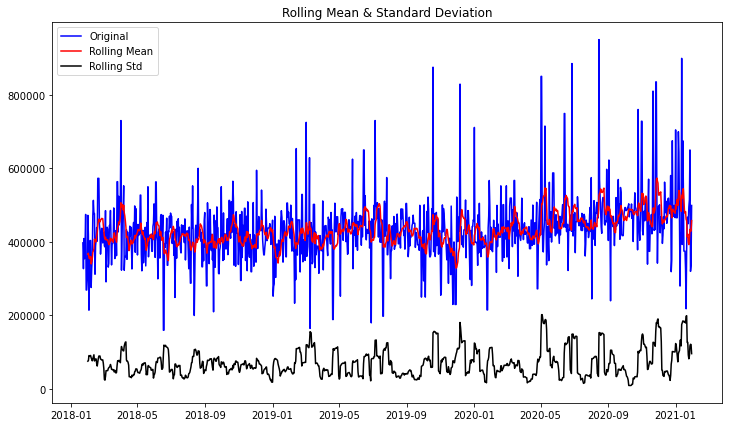

In [24]:
# make a new df with just the date and price
temp_df = df[['latest_saledate', 'latestPrice']]

# convert our date field to a proper datetime
temp_df['latest_saledate'] = pd.to_datetime(temp_df['latest_saledate'])

# drop outliers (somewhat arbitrary)
temp_df.drop(temp_df.loc[(temp_df['latestPrice'] > 1000000) | (temp_df['latestPrice'] < 100000)].index, axis=0, inplace=True)

# set the date as our index
temp_df.set_index('latest_saledate', inplace=True)

# group our data by day
temp = temp_df.groupby(pd.Grouper(freq='D')).mean()

# backfill any empty days by getting previous day's mean
temp.bfill(inplace=True)

# find the rolling mean and rolling standard deviation
roll_mean = temp.rolling(window=10, center=False).mean()
roll_std = temp.rolling(window=10, center=False).std()

# plot the figure with rolling mean and standard deviation
fig = plt.figure(figsize=(12,7))
plt.plot(temp, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

We run a Dickey-Fuller hypothesis test on our time series to test for stationarity. The null hypothesis is that the data is not stationary. If we have a p-value below .05, we will reject the null hypothesis.

In [25]:
dftest = adfuller(temp)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -8.327194e+00
p-value                        3.445082e-13
#Lags Used                     8.000000e+00
Number of Observations Used    1.096000e+03
Critical Value (1%)           -3.436331e+00
Critical Value (5%)           -2.864181e+00
Critical Value (10%)          -2.568176e+00
dtype: float64


The p-value of 3.45e-13 on the Dickey-Fuller test is FAR under .05, so we reject the null hypothesis that there is a trend in the data. Our data set is not exhibiting time series trends, so we don't need to account for this (surprisingly!!)

In [26]:
# on our original df, convert the date to a proper date-time, and then drop the day so it's only year-month
df['latest_saledate'] = pd.to_datetime(df['latest_saledate'])
df['latest_saledate'] = df['latest_saledate'].dt.strftime('%Y-%m')

In [27]:
# rename some columns
df.rename(columns={'latestPrice':'price', 'latest_saledate':'sale_date'}, inplace=True)

In [28]:
# drop original unneeded date columns
df.drop(['latest_salemonth', 'latest_saleyear'], axis=1, inplace=True)

##### Home Type

In [29]:
# what are the homeTypes?

df['homeType'].value_counts(normalize=True)

Single Family            0.938699
Condo                    0.030980
Townhouse                0.011469
Multiple Occupancy       0.006328
Vacant Land              0.005471
Residential              0.002439
Apartment                0.002439
Mobile / Manufactured    0.001121
MultiFamily              0.000659
Other                    0.000395
Name: homeType, dtype: float64

In [30]:
# Ultimately, with Single Family, Condo and Townhouse making up most of the data, we are going to remove all multi-family type listings
df = df.loc[((df['homeType'] == 'Single Family') | (df['homeType'] == 'Condo')) | (df['homeType'] == 'Townhouse')]

##### Duplicate Data

In [31]:
# check for duplicate data

df[df.duplicated(subset=['latitude','longitude'], keep=False)].sort_values('latitude')

# no duplicate data

Empty DataFrame
Columns: [zpid, city, streetAddress, zipcode, description, latitude, longitude, propertyTaxRate, garageSpaces, hasAssociation, hasCooling, hasGarage, hasHeating, hasSpa, hasView, homeType, parkingSpaces, yearBuilt, price, numPriceChanges, sale_date, latestPriceSource, numOfPhotos, numOfAccessibilityFeatures, numOfAppliances, numOfParkingFeatures, numOfPatioAndPorchFeatures, numOfSecurityFeatures, numOfWaterfrontFeatures, numOfWindowFeatures, numOfCommunityFeatures, lotSizeSqFt, livingAreaSqFt, numOfPrimarySchools, numOfElementarySchools, numOfMiddleSchools, numOfHighSchools, avgSchoolDistance, avgSchoolRating, avgSchoolSize, MedianStudentsPerTeacher, numOfBathrooms, numOfBedrooms, numOfStories, homeImage]
Index: []

##### Outlier Detection

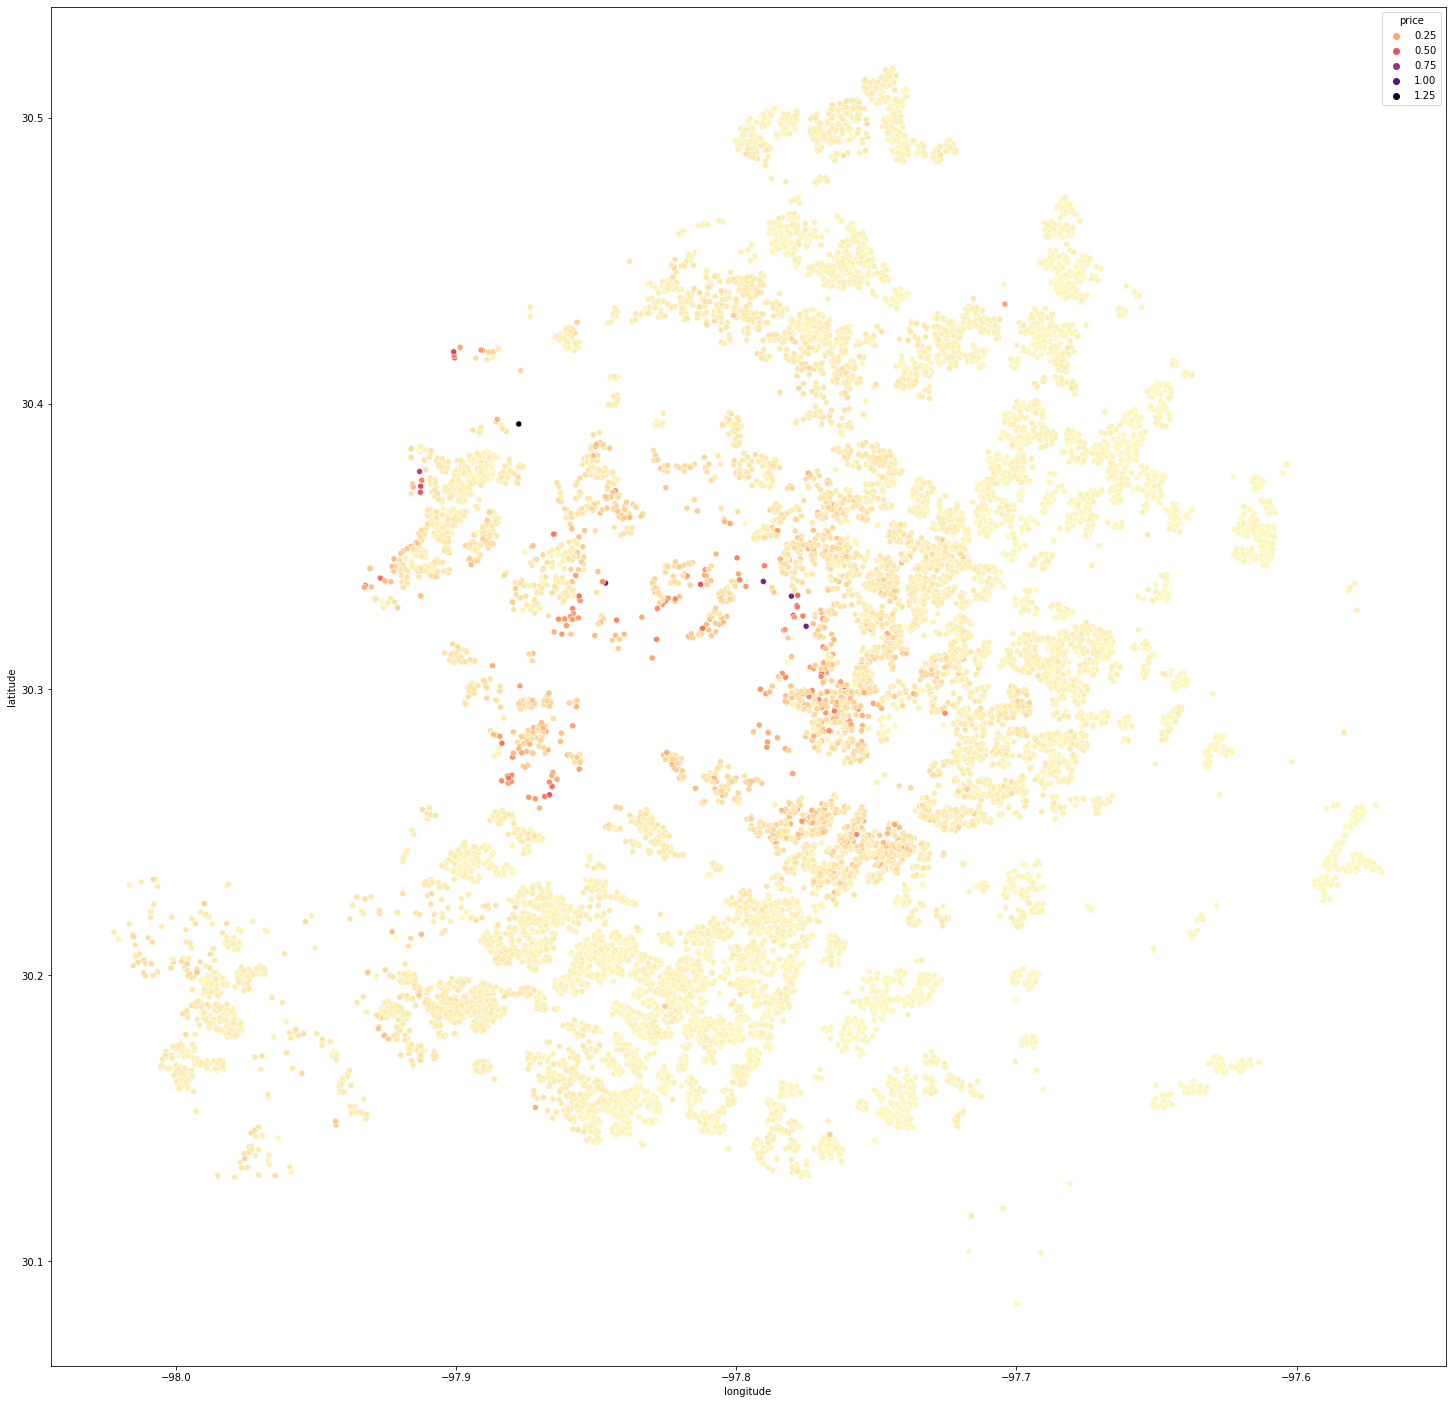

In [32]:
# plotting latitude and longitude as a visual scatter plot to look for location-based outliers

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="price", palette="magma_r");

Using latitude and longitude, we make a visual map of the Austin area that lets us see any map outliers. There don't appear to be any zones that are well outside of the Austin area, except for just a few down in the lower SE area. So we might plan to cut off our latitude just above 30.1.

This visualization suggests that location is very important to home price. We'll check that out more directly.

In [33]:
# drop latitidue below 30.12 to remove the few outliers in the SE
df.drop(df[df['latitude']<30.12].index , inplace=True)

In [34]:
# looking for outliers in the percentiles

df.describe()

zpid       zipcode      latitude     longitude  \
count  1.488000e+04  14880.000000  14880.000000  14880.000000   
mean   1.043332e+08  78736.001075     30.291923    -97.778870   
std    3.171262e+08     18.879984      0.097245      0.084904   
min    2.858495e+07  78617.000000     30.127161    -98.022057   
25%    2.941134e+07  78727.000000     30.202993    -97.838747   
50%    2.949518e+07  78739.000000     30.285250    -97.769810   
75%    7.033871e+07  78749.000000     30.367340    -97.718283   
max    2.146313e+09  78759.000000     30.517174    -97.569504   

       propertyTaxRate  garageSpaces  parkingSpaces     yearBuilt  \
count     14880.000000  14880.000000   14880.000000  14880.000000   
mean          1.994194      1.228159       1.227554   1988.720228   
std           0.053290      1.342097       1.342224     21.504783   
min           1.980000      0.000000       0.000000   1905.000000   
25%           1.980000      0.000000       0.000000   1975.000000   
50%           1.980000      1.000000       1.000000   1993.000000   
75%           1.980000      2.000000       2.000000   2006.000000   
max           2.210000     22.000000      22.000000   2020.000000   

              price  numPriceChanges   numOfPhotos  \
count  1.488000e+04     14880.000000  14880.000000   
mean   5.119011e+05         3.032997     30.830645   
std    4.413982e+05         2.481883     21.187673   
min    5.500000e+03         1.000000      1.000000   
25%    3.090000e+05         1.000000     20.000000   
50%    4.050000e+05         2.000000     29.000000   
75%    5.750000e+05         4.000000     39.000000   
max    1.350000e+07        23.000000    179.000000   

       numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
count                14880.000000     14880.000000          14880.000000   
mean                     0.013239         3.490927              1.710081   
std                      0.181175         1.868605              0.778832   
min                      0.000000         0.000000              0.000000   
25%                      0.000000         2.000000              1.000000   
50%                      0.000000         3.000000              2.000000   
75%                      0.000000         4.000000              2.000000   
max                      8.000000        10.000000              6.000000   

       numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
count                14880.000000           14880.000000   
mean                     0.667608               0.472446   
std                      0.983225               0.828483   
min                      0.000000               0.000000   
25%                      0.000000               0.000000   
50%                      0.000000               0.000000   
75%                      1.000000               1.000000   
max                      8.000000               6.000000   

       numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
count             14880.000000         14880.000000            14880.000000   
mean                  0.002621             0.210753                0.011761   
std                   0.059625             0.490729                0.113874   
min                   0.000000             0.000000                0.000000   
25%                   0.000000             0.000000                0.000000   
50%                   0.000000             0.000000                0.000000   
75%                   0.000000             0.000000                0.000000   
max                   2.000000             4.000000                3.000000   

        lotSizeSqFt  livingAreaSqFt  numOfPrimarySchools  \
count  1.488000e+04    14880.000000         14880.000000   
mean   1.207274e+05     2205.497177             0.941062   
std    1.237193e+07     1368.133002             0.235802   
min    1.000000e+02      300.000000             0.000000   
25%    6.534000e+03     1485.000000             1.000000   
50%    8.232000e+03   

We see potential outliers in price, lotSizeSqFt, livingAreaSqFt, and numOfBathrooms, numOfBedrooms, garageSpaces, parkingSpaces.

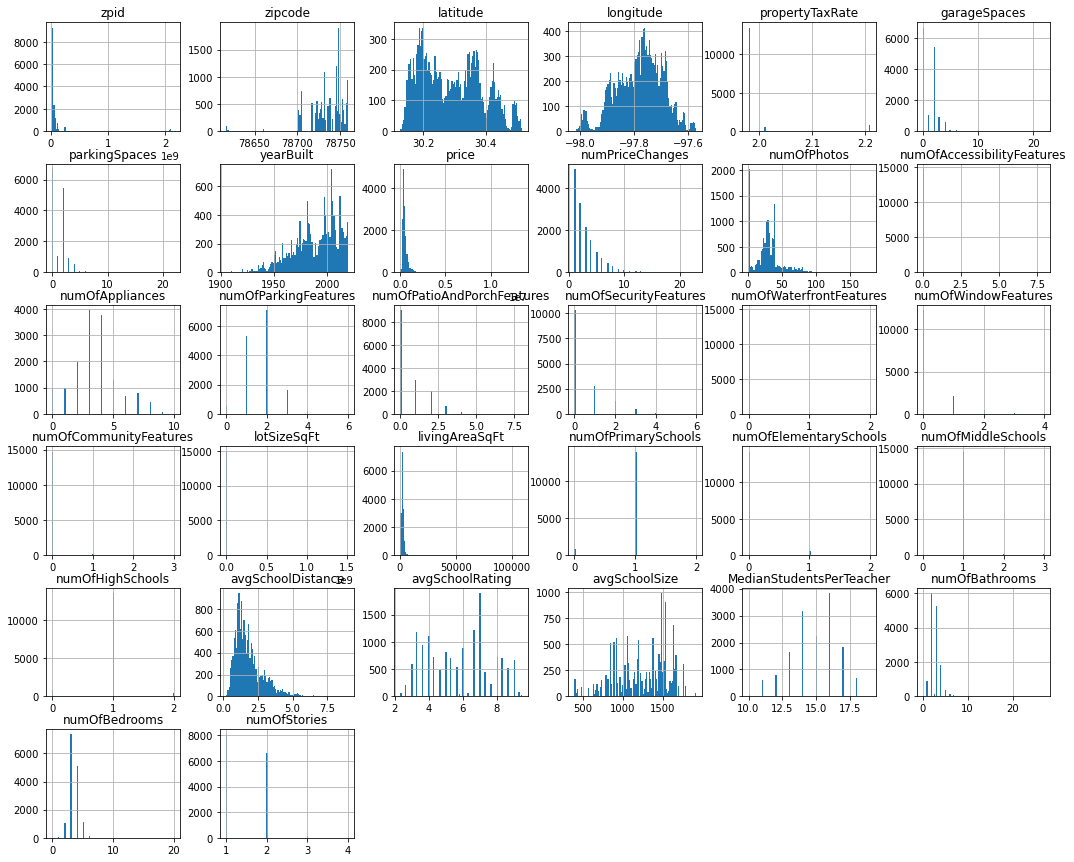

In [35]:
# check how our histograms are looking
df.hist(figsize=(18,15), bins=100);


In [36]:
#check what is going on with the lotSizeSqFt outliers by sorting descending
df.sort_values('lotSizeSqFt', ascending=False).head(5)

# This top listing is legitimate. But we have a problem here where condo and townhouse listings are using the 
# size of the overall lot for their lot, and that isn't really accurate/representative
# We'll fix this in a little bit

zpid    city          streetAddress  zipcode  \
14654   58297775  austin         3200 W 35th St    78703   
9244    62605548  austin  706 W 22nd St APT 306    78705   
11116  145652991  austin       4319 Nitschke St    78723   
2340   124837778  austin    4304 Front Range Ln    78732   
4635   202157510  austin     201 Charismatic Pl    78737   

                                             description   latitude  \
14654  Fabulous 4 Bed 4 Bath house on one of the larg...  30.314316   
9244   Leased for $1695 though 7/31/2020 - Unique gat...  30.285631   
11116  **Subject to City of Austin SMART Housing and ...  30.294910   
2340   4304 Front Range Ln, Austin, TX 78732 is a sin...  30.380476   
4635   201 Charismatic Pl, Austin, TX 78737 is a sing...  30.205276   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
14654 -97.768044             1.98             5           False        True   
9244  -97.745697             1.98             0            True        True   
11116 -97.698997             1.98             1            True        True   
2340  -97.881027             1.98             2            True        True   
4635  -98.011406             2.01             3            True        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
14654       True        True   False    False  Single Family              5   
9244       False        True   False    False          Condo              0   
11116       True        True   False    False      Townhouse              1   
2340        True        True   False     True  Single Family              2   
4635        True        True    True    False  Single Family              3   

       yearBuilt      price  numPriceChanges sale_date latestPriceSource  \
14654       1955  1650000.0                3   2020-02   Broker Provided   
9244        1982   179900.0                7   2019-10    Agent Provided   
11116       2016   187471.0                1   2020-06    Agent Provided   
2340        2014   569000.0                1   2019-03    Agent Provided   
4635        2015   999500.0                3   2019-11   Broker Provided   

       numOfPhotos  numOfAccessibilityFeatures  numOfAppliances  \
14654           23                           0                8   
9244            16                           0                4   
11116           26                           0                3   
2340            33                           0                4   
4635             1                           0                4   

       numOfParkingFeatures  numOfPatioAndPorchFeatures  \
14654                     2                           2   
9244                      0                           0   
11116                     2                           0   
2340                      2                           0   
4635                      2                           0   

       numOfSecurityFeatures  numOfWaterfrontFeatures  numOfWindowFeatures  \
14654                      1                        0                    0   
9244                       0                        0                    0   
11116                      1                        0                    1   
2340                       0                        0                    0   
4635                       0                        0                    0   

       numOfCommunityFeatures   lotSizeSqFt  livingAreaSqFt  \
14654                       0  1.508483e+09          3328.0   
9244                        0  3.415452e+07           728.0   
11116                       0  2.617956e+07           815.0   
2340                        0  8.712000e+06          3183.0   
4635                        0  8.581320e+06          4459.0   

       numOfPrimarySchools  numOfElementarySchools  numOfMiddleSchools  \
14654                    1                       0                   1   
9244                     1                       0             

In [37]:
#check what is going on with the livingAreaSqFt outliers by sorting ascending
df.sort_values('livingAreaSqFt', ascending=True).head(5)

# just tiny houses I guess ?

zpid    city             streetAddress  zipcode  \
1170    94641643  austin    3003 Brass Buttons Trl    78734   
3518    29420819  austin           404 Primrose St    78753   
13314   29330022  austin  1405 Hartford Rd APT 202    78703   
10118   29385318  austin            2202 E 10th St    78702   
9213   145658912  austin    1011 W 23rd St APT 103    78705   

                                             description   latitude  \
1170   Lake Austin Waterfront lot in Apache Shores! O...  30.381195   
3518   404 Primrose St, Austin, TX 78753 is a single ...  30.350330   
13314  Old West Austin Efficiency. Close to metro/UT ...  30.284014   
10118  Great opportunity to build on your lot in high...  30.264668   
9213   Very desirable location for UT students only 5...  30.287077   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
1170  -97.915985             1.98             0            True        True   
3518  -97.697739             1.98             0           False       False   
13314 -97.762421             1.98             0            True        True   
10118 -97.717590             1.98             2            True        True   
9213  -97.748085             1.98             1            True        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
1170       False        True   False    False  Single Family              0   
3518       False       False   False    False  Single Family              0   
13314      False        True   False    False          Condo              0   
10118       True        True   False     True          Condo              2   
9213        True        True   False     True          Condo              1   

       yearBuilt     price  numPriceChanges sale_date latestPriceSource  \
1170        2012  850000.0                4   2018-07    Agent Provided   
3518        1945  139000.0                1   2019-07   Broker Provided   
13314       1972  175000.0                1   2019-10    Agent Provided   
10118       2019  499000.0                4   2019-10   Broker Provided   
9213        1972  151500.0                5   2018-09    Agent Provided   

       numOfPhotos  numOfAccessibilityFeatures  numOfAppliances  \
1170            49                           0                1   
3518             1                           0                0   
13314           16                           0                3   
10118           29                           0                3   
9213             1                           0                5   

       numOfParkingFeatures  numOfPatioAndPorchFeatures  \
1170                      0                           0   
3518                      0                           0   
13314                     0                           1   
10118                     2                           0   
9213                      2                           0   

       numOfSecurityFeatures  numOfWaterfrontFeatures  numOfWindowFeatures  \
1170                       0                        0                    0   
3518                       0                        0                    0   
13314                      1                        0                    1   
10118                      1                        0                    0   
9213                       0                        0                    0   

       numOfCommunityFeatures  lotSizeSqFt  livingAreaSqFt  \
1170                        0      23522.4           300.0   
3518                        0      11761.2           306.0   
13314                       0        657.0           378.0   
10118                       0       5837.0           450.0   
9213                        0        815.0           450.0   

       numOfPrimarySchools  numOfElementarySchools  numOfMiddleSchools  \
1170                     1                       0                   1   
3518                     1                       0       

In [38]:
#check what is going on with the livingAreaSqFt outliers by sorting descending
df.sort_values('livingAreaSqFt', ascending=False).head(5)

zpid    city            streetAddress  zipcode  \
705    70330356  austin            201 Marly Way    78733   
2557   64523076  austin           9704 Saugus Ln    78733   
2316  125904370  austin           12400 Cedar St    78732   
5328   29327226  austin     3509 Lost Creek Blvd    78735   
375    89551873  austin  14800 Flat Top Ranch Rd    78732   

                                            description   latitude  longitude  \
705   Level building site with great canyon views an...  30.323517 -97.861473   
2557  New Construction, EANES Schools, 4bed 3 bath, ...  30.345898 -97.859985   
2316  12400 Cedar Street - Villa Del Lago is a uniqu...  30.392859 -97.877609   
5328  *$6,762,377 is Tax Value - Set in exclusive Ba...  30.272158 -97.856033   
375   GRACIOUS LUXURY ON LAKE AUSTIN\r\nThis award-w...  30.368996 -97.912720   

      propertyTaxRate  garageSpaces  hasAssociation  hasCooling  hasGarage  \
705              1.98             0            True        True      False   
2557             1.98             0            True        True      False   
2316             1.98             5           False        True       True   
5328             1.98             7            True        True       True   
375              1.98             6            True        True       True   

      hasHeating  hasSpa  hasView       homeType  parkingSpaces  yearBuilt  \
705         True   False    False  Single Family              0       2012   
2557        True   False    False  Single Family              0       2018   
2316        True   False     True  Single Family              5       2016   
5328        True    True    False  Single Family              7       2003   
375         True    True     True  Single Family              6       2014   

           price  numPriceChanges sale_date latestPriceSource  numOfPhotos  \
705     385000.0                2   2018-11    Agent Provided            1   
2557    829000.0                1   2018-03    Agent Provided            1   
2316  13500000.0                2   2018-11    Agent Provided           13   
5328   2700000.0                4   2018-05    Agent Provided           39   
375    4950000.0                6   2018-08    Agent Provided           34   

      numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
705                            0                0                     1   
2557                           0                1                     1   
2316                           0                0                     2   
5328                           0                5                     3   
375                            0                3                     2   

      numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
705                            0                      0   
2557                           0                      0   
2316                           0                      0   
5328                           0                      0   
375                            0                      0   

      numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
705                         0                    0                       0   
2557                        0                    0                       0   
2316                        0                    0                       0   
5328                        0                    0                       0   
375                         0                    0                       0   

      lotSizeSqFt  livingAreaSqFt  numOfPrimarySchools  \
705      109335.6        109292.0                    0   
2557     103237.2         29440.0                    0   
2316     710899.2         15394.0                    1   
5328     138956.4         14091.0                    1   
375      116740.8         13731.0                    1   

      numOfElementarySchools  numOfMiddleSchools  numOfHighSchools  \
705                        1                   3        

In [39]:
# we're dropping the top two listings here. One is a lot, and the other is clearly mistaken.
df.drop(index=[705, 2557], inplace=True)

In [40]:
#check what is going on with the numOfBathrooms outliers by sorting descending
df.sort_values('numOfBathrooms', ascending=False).head(5)

zpid    city            streetAddress  zipcode  \
2838  111972888  austin       4212 Far West Blvd    78731   
2316  125904370  austin           12400 Cedar St    78732   
184   124843021  austin        13115 Perryton Dr    78732   
5328   29327226  austin     3509 Lost Creek Blvd    78735   
375    89551873  austin  14800 Flat Top Ranch Rd    78732   

                                            description   latitude  longitude  \
2838  Well-maintained home in highly desirable North...  30.361406 -97.769707   
2316  12400 Cedar Street - Villa Del Lago is a uniqu...  30.392859 -97.877609   
184   This highly custom home sits on a well-establi...  30.338959 -97.926979   
5328  *$6,762,377 is Tax Value - Set in exclusive Ba...  30.272158 -97.856033   
375   GRACIOUS LUXURY ON LAKE AUSTIN\r\nThis award-w...  30.368996 -97.912720   

      propertyTaxRate  garageSpaces  hasAssociation  hasCooling  hasGarage  \
2838             1.98             2           False        True       True   
2316             1.98             5           False        True       True   
184              1.98             4            True        True       True   
5328             1.98             7            True        True       True   
375              1.98             6            True        True       True   

      hasHeating  hasSpa  hasView       homeType  parkingSpaces  yearBuilt  \
2838        True   False    False  Single Family              2       1967   
2316        True   False     True  Single Family              5       2016   
184         True    True     True  Single Family              4       2014   
5328        True    True    False  Single Family              7       2003   
375         True    True     True  Single Family              6       2014   

           price  numPriceChanges sale_date latestPriceSource  numOfPhotos  \
2838    745000.0                1   2020-10    Agent Provided           46   
2316  13500000.0                2   2018-11    Agent Provided           13   
184    4100000.0                3   2020-12   Broker Provided          149   
5328   2700000.0                4   2018-05    Agent Provided           39   
375    4950000.0                6   2018-08    Agent Provided           34   

      numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
2838                           0                4                     2   
2316                           0                0                     2   
184                            0                8                     3   
5328                           0                5                     3   
375                            0                3                     2   

      numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
2838                           0                      0   
2316                           0                      0   
184                            0                      0   
5328                           0                      0   
375                            0                      0   

      numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
2838                        0                    0                       0   
2316                        0                    0                       0   
184                         0                    0                       0   
5328                        0                    0                       0   
375                         0                    0                       0   

      lotSizeSqFt  livingAreaSqFt  numOfPrimarySchools  \
2838      10236.0          2137.0                    1   
2316     710899.2         15394.0                    1   
184      172497.6          9866.0                    1   
5328     138956.4         14091.0                    1   
375      116740.8         13731.0                    1   

      numOfElementarySchools  numOfMiddleSchools  numOfHighSchools  \
2838                       0                   1        

In [41]:
# I'm going to say this top listing has 2.5 bathrooms not 27. That is clearly a typo.
df.loc[df.index==2838, 'numOfBathrooms'] = 2.5

In [42]:
#check what is going on with the numOfBathrooms outliers by sorting ascending
df.sort_values('numOfBathrooms', ascending=True).head(5)

zpid    city           streetAddress  zipcode  \
6252   29327134  austin       2005 Real Catorce    78746   
6646   29503854  austin       8604 Oak Ledge Dr    78748   
1842   94642666  austin    10640 Senna Hills Dr    78733   
2223   58299964  austin  5138 Mansfield View Ct    78732   
12993  58315415  austin   4712 Chesney Ridge Dr    78749   

                                             description   latitude  \
6252   2005 Real Catorce, Austin, TX 78746 is a singl...  30.269354   
6646   8604 Oak Ledge Dr, Austin, TX 78748 is a singl...  30.188589   
1842   Wow! Reduced! First time on the market! Move i...  30.312716   
2223   5138 Mansfield View Ct, Austin, TX 78732 is a ...  30.390335   
12993  This Austin two-story offers a fireplace, an o...  30.197540   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
6252  -97.818771             1.98             0            True        True   
6646  -97.823662             1.98             0           False        True   
1842  -97.900482             1.98             2            True        True   
2223  -97.882072             1.98             2            True        True   
12993 -97.862419             1.98             2            True        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
6252       False        True   False    False  Single Family              0   
6646       False        True   False    False  Single Family              0   
1842        True        True   False     True  Single Family              2   
2223        True        True   False     True  Single Family              2   
12993       True        True   False    False  Single Family              2   

       yearBuilt     price  numPriceChanges sale_date latestPriceSource  \
6252        1999  949000.0                4   2018-10    Agent Provided   
6646        1971  450000.0                1   2019-08   Broker Provided   
1842        2011  895000.0                5   2020-06    Agent Provided   
2223        2000  850000.0                9   2020-05                     
12993       2000  447000.0               12   2019-10   Broker Provided   

       numOfPhotos  numOfAccessibilityFeatures  numOfAppliances  \
6252             1                           0                4   
6646             1                           0                4   
1842            35                           0                3   
2223             6                           0                3   
12993            1                           0                4   

       numOfParkingFeatures  numOfPatioAndPorchFeatures  \
6252                      1                           0   
6646                      2                           2   
1842                      2                           0   
2223                      3                           1   
12993                     2                           1   

       numOfSecurityFeatures  numOfWaterfrontFeatures  numOfWindowFeatures  \
6252                       0                        0                    0   
6646                       0                        0                    2   
1842                       0                        0                    0   
2223                       2                        0                    2   
12993                      1                        0                    0   

       numOfCommunityFeatures  lotSizeSqFt  livingAreaSqFt  \
6252                        0      14810.4          5187.0   
6646                        0      17424.0          1660.0   
1842                        0      12196.8          3809.0   
2223                        0      17424.0          3423.0   
12993                       0       7187.0          3271.0   

       numOfPrimarySchools  numOfElementarySchools  numOfMiddleSchools  \
6252                     0                       1                   1   
6646                     1                       0                   1   


In [43]:
# most listings with 0 bathrooms also have 0 bedrooms. This is clearly wrong, but I'm not going to guess if there are no bedrooms.
# I will impute typical bathroom count per bedroom count based on year built
# then drop any remaining listings with 0 bathrooms and 0 bedrooms

df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>0) & (df['yearBuilt'] > 1989), 'numOfBathrooms'] = 2
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>0) & (df['yearBuilt'] <= 1989), 'numOfBathrooms'] = 1
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>=3) & (df['yearBuilt'] > 1989), 'numOfBathrooms'] = 2.5
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>=3) & (df['yearBuilt'] <= 1989), 'numOfBathrooms'] = 2

df.drop(df[df['numOfBathrooms']==0].index, inplace=True)
df.drop(df[df['numOfBedrooms']==0].index, inplace=True)

In [44]:
#check what is going on with the numOfBedrooms outliers by sorting descending
df.sort_values('numOfBedrooms', ascending=False).head(5)

zpid    city         streetAddress  zipcode  \
8597   2094498207  austin  4902 Duval Rd R2 #R2    78727   
8531     58306332  austin     3906 Hawkshead Dr    78727   
14435    29401385  austin   4302 Avenue G APT C    78751   
13910    29322655  austin         1608 S 2nd St    78704   
9314     29384319  austin         1310 E 2nd St    78702   

                                             description   latitude  \
8597   Lovely convenient condo, with a private wooded...  30.415489   
8531   Enjoy this home across from The Domain! Comple...  30.416149   
14435  Charming 3-unit multifamily property built by ...  30.305981   
13910  Modern luxury by Joseph Design Build with prim...  30.249325   
9314   Contact owner for showing, day before advance ...  30.260422   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
8597  -97.737213             1.98             0            True        True   
8531  -97.722801             1.98             2           False        True   
14435 -97.728012             1.98             0           False       False   
13910 -97.757095             1.98             5           False        True   
9314  -97.730194             1.98             2           False        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
8597       False        True   False     True          Condo              0   
8531        True        True   False    False  Single Family              2   
14435      False        True   False    False  Single Family              0   
13910       True        True   False    False  Single Family              5   
9314        True        True   False     True  Single Family              2   

       yearBuilt      price  numPriceChanges sale_date latestPriceSource  \
8597        1985   174900.0                2   2020-11    Agent Provided   
8531        2006   650000.0                1   2020-08    Agent Provided   
14435       1925   750000.0                1   2018-04    Agent Provided   
13910       2020  3450000.0                4   2020-04    Agent Provided   
9314        1915   599995.0                7   2020-03    Agent Provided   

       numOfPhotos  numOfAccessibilityFeatures  numOfAppliances  \
8597            25                           0                4   
8531            36                           0                2   
14435           15                           0                0   
13910           37                           0                4   
9314             1                           0                3   

       numOfParkingFeatures  numOfPatioAndPorchFeatures  \
8597                      1                           0   
8531                      2                           2   
14435                     1                           0   
13910                     3                           0   
9314                      3                           0   

       numOfSecurityFeatures  numOfWaterfrontFeatures  numOfWindowFeatures  \
8597                       0                        0                    0   
8531                       3                        0                    1   
14435                      0                        0                    0   
13910                      0                        0                    0   
9314                       0                        0                    0   

       numOfCommunityFeatures  lotSizeSqFt  livingAreaSqFt  \
8597                        0       5227.0           916.0   
8531                        0       9191.0          4712.0   
14435                       0       5662.0          2340.0   
13910                       0      12632.4          4956.0   
9314                        0       6577.0          2403.0   

       numOfPrimarySchools  numOfElementarySchools  numOfMiddleSchools  \
8597                     1                       0                   1   
8531                     1                       0                   1

In [45]:
# That condo is supposed to have 2 bathrooms, not 20.
df.loc[df.index==8597, 'numOfBedrooms'] = 2

In [46]:
#check what is going on with the garageSpaces outliers by sorting descending
df.sort_values('garageSpaces', ascending=False).head(10)

zpid    city             streetAddress  zipcode  \
6885   145656156  austin       705 Mc Queen St #34    78745   
4533    28587235  austin  13100 Rooster Springs Rd    78737   
4777    29331364  austin    3301 Barton Creek Blvd    78735   
9240    29396074  austin              908 Keith Ln    78705   
6805    29502805  austin        7600 Elm Forest Rd    78745   
6985    29494837  austin        6907 Cherrydale Dr    78745   
11108   29409917  austin         1405 Berkshire Dr    78723   
14875   29415933  austin           5804 Bullard Dr    78757   
6230    29327172  austin   1814 Randolph Ridge Trl    78746   
3459    29423855  austin          8909 Georgian Dr    78753   

                                             description   latitude  \
6885   Beautiful 2-story home located in highly sough...  30.189331   
4533   Enjoy country living with the convenience of t...  30.204746   
4777   Privately gated Barton Creek estate on 1.58 Ac...  30.283585   
9240   Keith Lane is has our homes strategically plac...  30.291706   
6805   Gorgeous 3/2 home owner remodel on almost 2/3 ...  30.190971   
6985   Beautifully remodeled home in HOT 78745!! This...  30.200857   
11108  Beautifully renovated single story mid-century...  30.317060   
14875  5804 Bullard Dr, Austin, TX 78757 is a single ...  30.336634   
6230   Stunning  home in Eanes, minutes  from downtow...  30.272011   
3459   Unique opportunity to own a large lot in an ar...  30.356129   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
6885  -97.792809             1.98            22            True        True   
4533  -97.991356             2.01            20           False        True   
4777  -97.875526             1.98            12            True        True   
9240  -97.725502             1.98            12           False        True   
6805  -97.800804             1.98            12           False        True   
6985  -97.803902             1.98            12           False        True   
11108 -97.697220             1.98            12           False        True   
14875 -97.750031             1.98            10           False        True   
6230  -97.821548             1.98            10            True        True   
3459  -97.695686             1.98            10           False        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
6885        True        True   False     True          Condo             22   
4533        True        True   False     True  Single Family             20   
4777        True        True    True    False  Single Family             12   
9240        True        True   False    False  Single Family             12   
6805        True        True   False    False  Single Family             12   
6985        True        True   False     True  Single Family             12   
11108       True        True   False     True  Single Family             12   
14875       True        True   False     True  Single Family             10   
6230        True        True    True     True  Single Family             10   
3459        True        True    True    False  Single Family             10   

       yearBuilt      price  numPriceChanges sale_date      latestPriceSource  \
6885        2016   399000.0                1   2020-11         Agent Provided   
4533        2018   824900.0                2   2018-03         Agent Provided   
4777        1991  1595000.0               15   2020-12  Compass RE Texas, LLC   
9240        2003  3400000.0                1   2020-04         Agent Provided   
6805        1960   525000.0                7   2019-08         Agent Provided   
6985        1972   328000.0                3   2020-12         Agent Provided   
11108       1955   500000.0                2   2020-11         Agent Provided   
14875       1958   450000.0                5   2019-06        Broker Provided   
6230        1999  1850000.0                5   2018-09         Agen

In [47]:
# a bunch of these garage spaces are definitely just bogus numbers. I'm going to force change a lot of them to numbers that make sense
df.loc[(df['garageSpaces'] > 3) & (df['price'] < 1000000) & (df['homeType'] == 'Single Family'), 'garageSpaces'] = 3
df.loc[(df['garageSpaces'] > 5) & (df['price'] > 1000000)& (df['homeType'] == 'Single Family'), 'garageSpaces'] = 4
df.loc[df.index==6885, 'garageSpaces'] = 2

In [48]:
#check what is going on with the parkingSpaces outliers by sorting descending
df.sort_values('parkingSpaces', ascending=False).head(5)

zpid    city             streetAddress  zipcode  \
6885   145656156  austin       705 Mc Queen St #34    78745   
4533    28587235  austin  13100 Rooster Springs Rd    78737   
6985    29494837  austin        6907 Cherrydale Dr    78745   
6805    29502805  austin        7600 Elm Forest Rd    78745   
11108   29409917  austin         1405 Berkshire Dr    78723   

                                             description   latitude  \
6885   Beautiful 2-story home located in highly sough...  30.189331   
4533   Enjoy country living with the convenience of t...  30.204746   
6985   Beautifully remodeled home in HOT 78745!! This...  30.200857   
6805   Gorgeous 3/2 home owner remodel on almost 2/3 ...  30.190971   
11108  Beautifully renovated single story mid-century...  30.317060   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
6885  -97.792809             1.98             2            True        True   
4533  -97.991356             2.01             3           False        True   
6985  -97.803902             1.98             3           False        True   
6805  -97.800804             1.98             3           False        True   
11108 -97.697220             1.98             3           False        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
6885        True        True   False     True          Condo             22   
4533        True        True   False     True  Single Family             20   
6985        True        True   False     True  Single Family             12   
6805        True        True   False    False  Single Family             12   
11108       True        True   False     True  Single Family             12   

       yearBuilt     price  numPriceChanges sale_date latestPriceSource  \
6885        2016  399000.0                1   2020-11    Agent Provided   
4533        2018  824900.0                2   2018-03    Agent Provided   
6985        1972  328000.0                3   2020-12    Agent Provided   
6805        1960  525000.0                7   2019-08    Agent Provided   
11108       1955  500000.0                2   2020-11    Agent Provided   

       numOfPhotos  numOfAccessibilityFeatures  numOfAppliances  \
6885            30                           0                2   
4533             3                           0                7   
6985            46                           0                4   
6805            33                           0                8   
11108           29                           0                3   

       numOfParkingFeatures  numOfPatioAndPorchFeatures  \
6885                      2                           3   
4533                      3                           0   
6985                      2                           1   
6805                      1                           2   
11108                     2                           2   

       numOfSecurityFeatures  numOfWaterfrontFeatures  numOfWindowFeatures  \
6885                       0                        0                    0   
4533                       0                        0                    0   
6985                       0                        0                    0   
6805                       2                        0                    2   
11108                      0                        0                    0   

       numOfCommunityFeatures  lotSizeSqFt  livingAreaSqFt  \
6885                        0       6621.0          2080.0   
4533                        0     337590.0          4004.0   
6985                        0       7927.0           880.0   
6805                        0      27007.2          1806.0   
11108                       0       7797.0          1209.0   

       numOfPrimarySchools  numOfElementarySchools  numOfMiddleSchools  \
6885                     1                       0                   1   
4533                     1                       0       

In [49]:
# We are going to do the same forced conversions on parking spaces
df.loc[(df['parkingSpaces'] > 3) & (df['price'] < 1000000 & (df['homeType'] == 'Single Family')), 'parkingSpaces'] = 3
df.loc[(df['parkingSpaces'] > 5) & (df['price'] > 1000000& (df['homeType'] == 'Single Family')), 'parkingSpaces'] = 5
df.loc[df.index==6885, 'parkingSpaces'] = 2

df.sort_values('parkingSpaces', ascending=False).head(5)

zpid    city          streetAddress  zipcode  \
6114  29326930  austin  1308 Brians Meadow Cv    78746   
5605  29361586  austin      12712 Mcnelly Trl    78732   
7073  29488557  austin       6507 Krollton Dr    78745   
4987  70332724  austin        10901 Strand St    78748   
3558  29425216  austin      8519 Parkfield Dr    78758   

                                            description   latitude  longitude  \
6114  Award winning EANES ISD. Cedar Creek Elementar...  30.269625 -97.803162   
5605  Home is in immaculate condition with loads of ...  30.381527 -97.891388   
7073  Beautiful one story home in Cherry Creek.  Two...  30.208628 -97.810165   
4987  South Austin Gem! This beautifully updated 4 b...  30.167471 -97.843445   
3558  Soak up the sunshine in this remodeled 3BR/4BA...  30.358917 -97.711327   

      propertyTaxRate  garageSpaces  hasAssociation  hasCooling  hasGarage  \
6114             1.98             4           False        True       True   
5605             1.98             3            True        True       True   
7073             1.98             3           False        True       True   
4987             1.98             3            True        True       True   
3558             1.98             3           False        True       True   

      hasHeating  hasSpa  hasView       homeType  parkingSpaces  yearBuilt  \
6114        True   False     True  Single Family              5       1995   
5605        True   False     True  Single Family              5       1993   
7073        True    True    False  Single Family              5       1973   
4987        True   False    False  Single Family              5       2006   
3558        True    True    False  Single Family              5       1965   

          price  numPriceChanges sale_date latestPriceSource  numOfPhotos  \
6114  1050000.0                1   2018-05    Agent Provided           52   
5605   394700.0                3   2019-03   Broker Provided            1   
7073   298000.0                9   2020-12   Broker Provided           35   
4987   253500.0                4   2019-05    Agent Provided           32   
3558   289000.0                4   2019-03    Agent Provided           24   

      numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
6114                           0                7                     3   
5605                           0                4                     2   
7073                           0                4                     2   
4987                           0                7                     4   
3558                           0                8                     3   

      numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
6114                           0                      0   
5605                           0                      0   
7073                           1                      2   
4987                           0                      1   
3558                           0                      0   

      numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
6114                        0                    0                       0   
5605                        0                    0                       0   
7073                        0                    0                       0   
4987                        0                    1                       0   
3558                        0                    0                       0   

      lotSizeSqFt  livingAreaSqFt  numOfPrimarySchools  \
6114      13939.2          3372.0                    0   
5605       8276.0          2200.0                    1   
7073       6403.0          1342.0                    1   
4987       9888.0          2388.0                    1   
3558       9331.0          2326.0                    1   

      numOfElementarySchools  numOfMiddleSchools  numOfHighSchools  \
6114                       1                   1                 0   
5605     

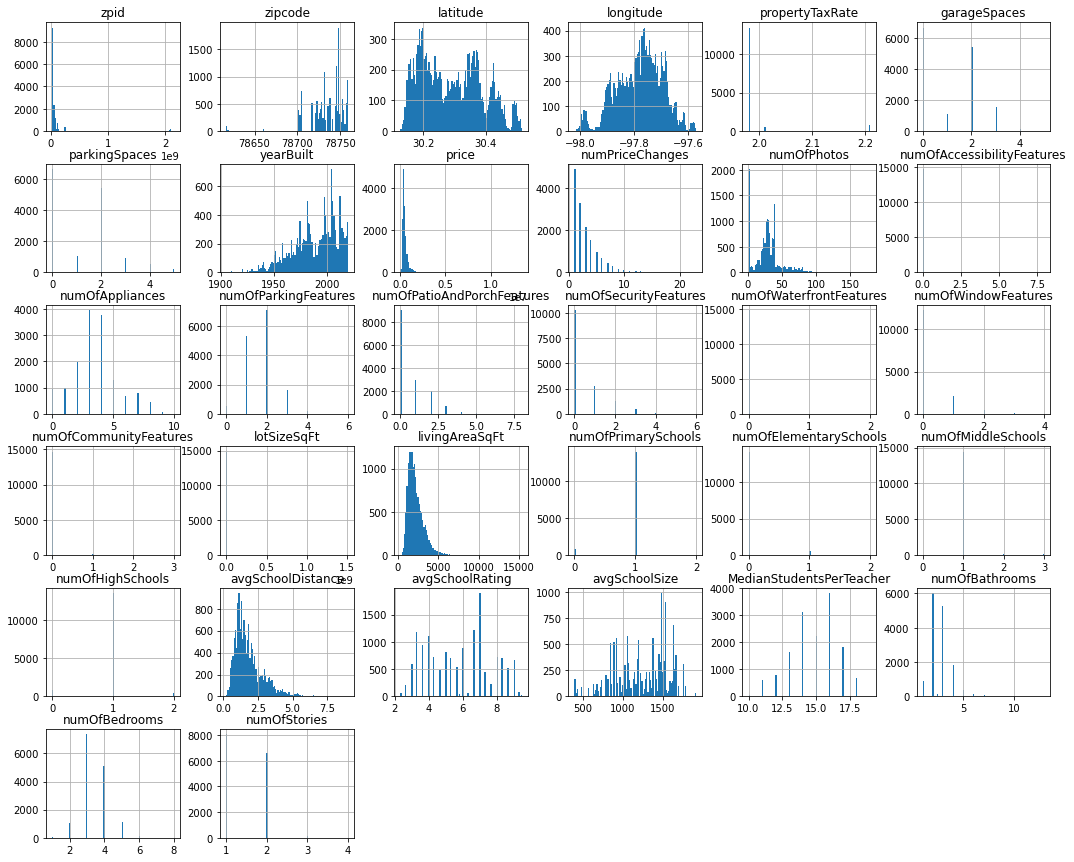

In [50]:
# check how our histograms are looking for our columns that seem to have outliers

df.hist(figsize=(18,15), bins=100);

For the square footage variables, I ultimately concluded that extremely large houses and lots are so seriously under-represented in the dataset that we won't be able to reliably predict on them anyway and they are better left off.

Ultimately I opt to remove via IQR on these items. 

In order to prevent a lot of data loss in this way, I kept IQR range of 1.6 instead of the standard 1.5

In [51]:
# determing our IQR for price, lot size, sq footage and longitude
lotlower,lotupper = iqr_outliers(df.lotSizeSqFt, 1.6)
sqftlower, sqftupper = iqr_outliers(df.livingAreaSqFt, 1.6)

# dropping the things outside of our lower and upper range
df.drop(df[ (df.lotSizeSqFt > lotupper) | (df.lotSizeSqFt < lotlower) ].index , inplace=True)
df.drop(df[ (df.livingAreaSqFt > sqftupper) | (df.livingAreaSqFt < sqftlower) ].index , inplace=True)

In [52]:
# We'll imputing the median lot size into condo and townhouse listings that are over-listed for lot size square feet

df.loc[(df['homeType']=='Condo') | (df['homeType']=='Townhouse') & (df['livingAreaSqFt']<1200) & (df['lotSizeSqFt']>8000), 'lotSizeSqFt'] = df['lotSizeSqFt'].median()

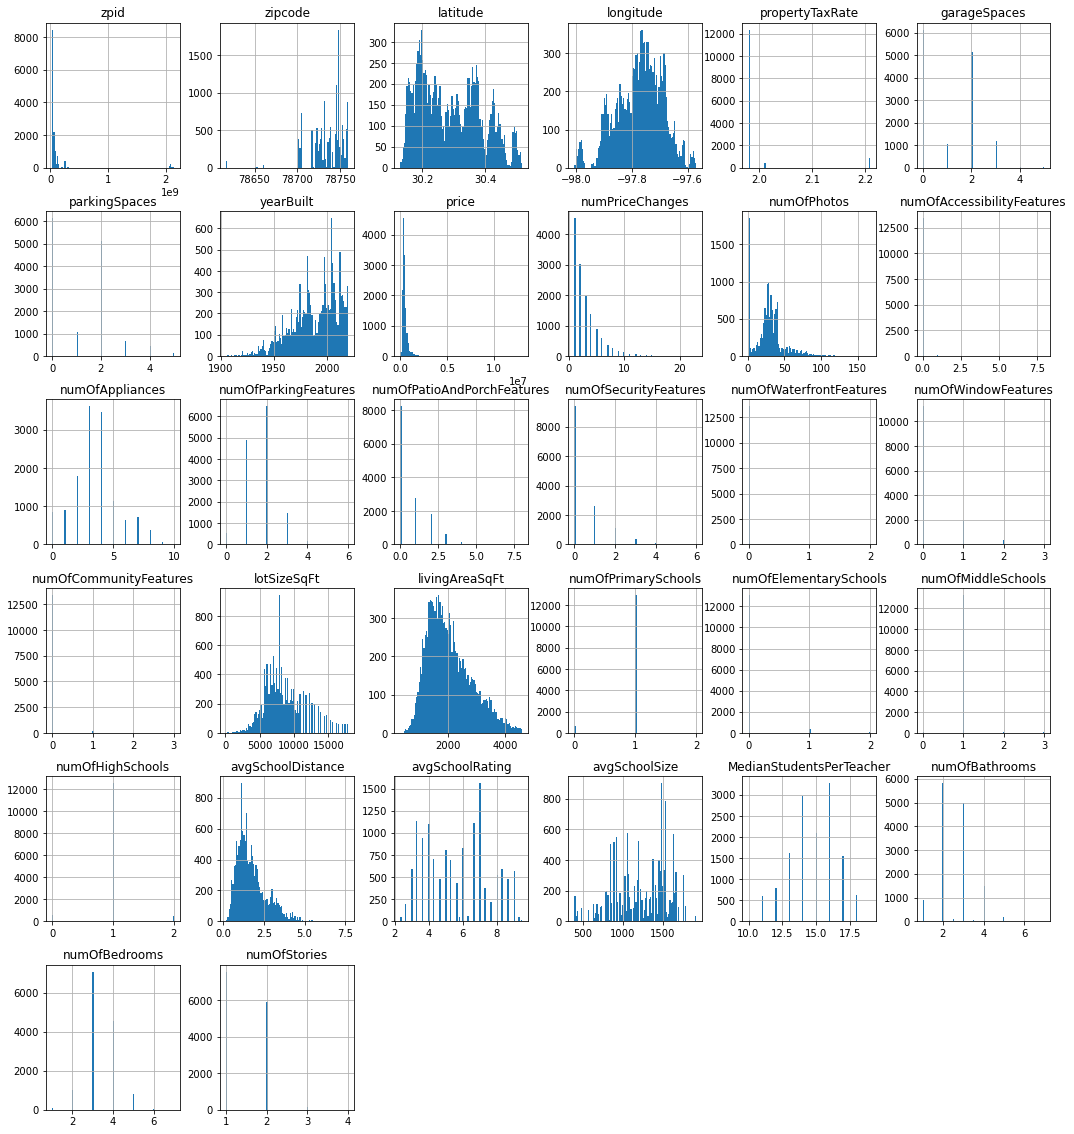

In [53]:
# check how our histograms are looking

df.hist(figsize=(18,20), bins=100);

# much better

##### Manually locating price outliers

In [54]:
# we're using the median house value for a zip code to determine the zip code's sort, so we can visualize the zip code

# group our dataframe by zipcode on median home price, sorted ascending. 
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# function that looks up a segment that a data entry belongs to
def make_group(x, frame, column):
    y = frame.loc[(frame.index == x)][column]
    z = np.array(y)
    z[0]
    return z[0]

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

# apply the median home price per zip code to the data frame
df['median_zip'] = df['zipcode'].apply(lambda x: round(df.loc[df['zipcode']==x]['price'].median(), 0))

''

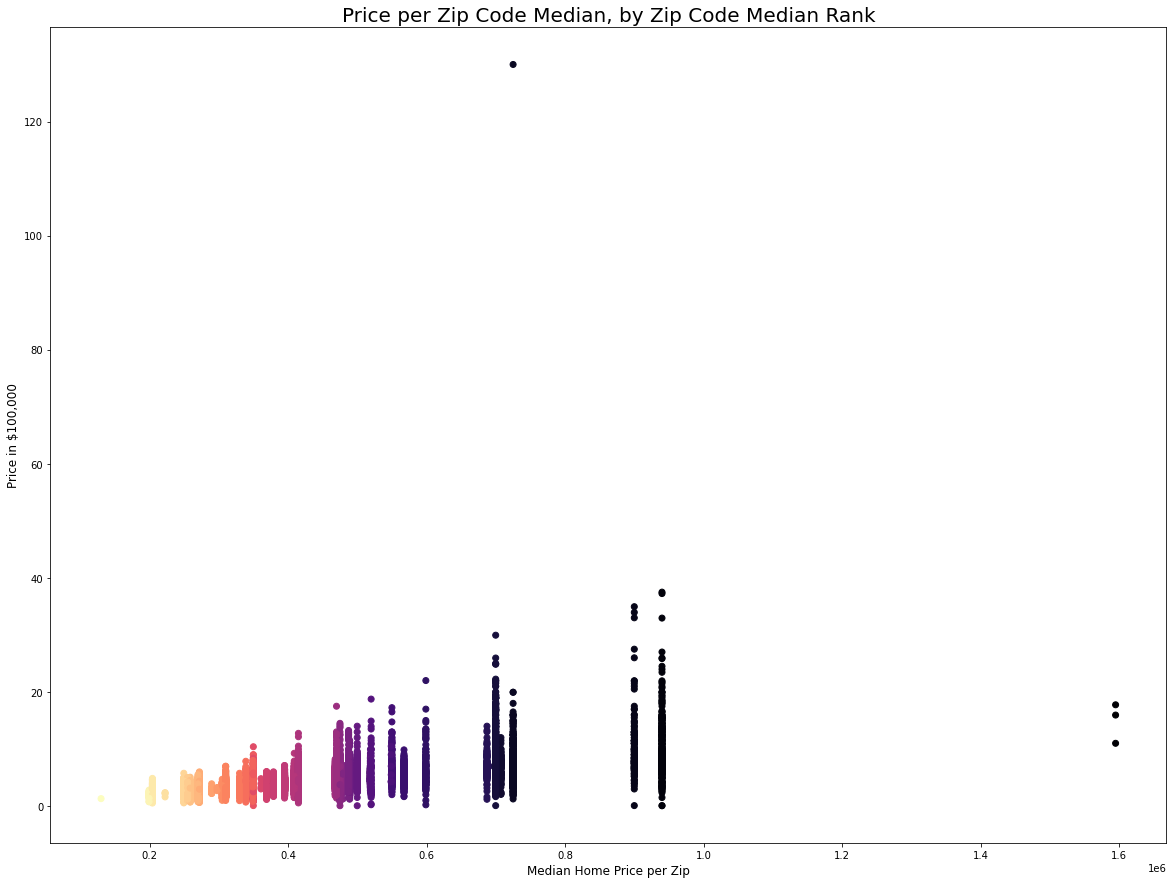

In [55]:
# visualize zip code as a color function

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Median Home Price per Zip', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Zip Code Median, by Zip Code Median Rank', fontsize=20)
;

We can see that a few of our zip codes are very high value. There are also some clear outliers in this data set. We'll take care of removing those, and then come back to this visual again later after we've done some cleanup.

In [56]:
# we're dropping the values above 3 million, and the 3 entries from zipcode 78734
df.drop(df[df['price']>3000000].index, inplace=True)
df.drop(df[df['zipcode']==78734].index, inplace=True)

# check price stats by zip code and displaying top 30 zip codes by mean
find_zip_outliers = df.groupby('zipcode')['price'].describe()
find_zip_outliers.sort_values('mean', ascending=False).head(35)
# very suspicious values in many zip codes for min

count          mean            std       min        25%       50%  \
zipcode                                                                       
78703     264.0  1.018940e+06  494831.316483    6300.0  656750.00  930000.0   
78746     114.0  1.009715e+06  467114.608637    7900.0  699999.25  899950.0   
78704     667.0  8.367228e+05  445576.067740    7500.0  536250.00  699850.0   
78731     420.0  7.496376e+05  303215.621686  124000.0  557425.00  725000.0   
78730     106.0  7.049658e+05  220979.656989  118499.0  569225.00  687250.0   
78738       1.0  6.970000e+05            NaN  697000.0  697000.00  697000.0   
78756     133.0  6.803116e+05  332268.211346   21500.0  449900.00  599000.0   
78733     114.0  6.757573e+05  195457.693287  205000.0  549250.00  707450.0   
78701       7.0  6.395429e+05  252778.413221  415000.0  432450.00  549000.0   
78735     201.0  6.257530e+05  254162.971563  199900.0  485000.00  550000.0   
78705      59.0  5.990830e+05  390572.191023   23000.0  276500.00  520000.0   
78751     168.0  5.649131e+05  251580.281220  149900.0  388000.00  487450.0   
78750     276.0  5.572360e+05  145014.719606  165000.0  449000.00  567450.0   
78732     471.0  5.288553e+05  168231.742433    5500.0  405000.00  499900.0   
78739     536.0  5.280328e+05  111451.423540  249900.0  449900.00  519000.0   
78757     511.0  5.166404e+05  195987.852424  139999.0  399000.00  470000.0   
78702     379.0  5.141074e+05  216991.642138    6000.0  375000.00  475000.0   
78759     493.0  5.002341e+05  155575.421317  120000.0  398000.00  489000.0   
78722      93.0  4.924819e+05  142571.747486  250000.0  385000.00  475000.0   
78726     162.0  4.790106e+05   94657.006093  125000.0  425500.00  479450.0   
78737     400.0  4.768737e+05  100718.771064  179990.0  399996.75  467995.0   
78723     524.0  4.332709e+05  163034.832533   54900.0  338675.00  415000.0   
78717     495.0  4.245748e+05  118653.200909  147900.0  347888.50  409000.0   
78736     139.0  3.941405e+05   97790.381776  169997.0  329000.00  379000.0   
78749     757.0  3.919731e+05   82732.933602  139900.0  346000.00  395000.0   
78652       4.0  3.753398e+05   79883.093499  299500.0  321718.00  360929.5   
78741     211.0  3.695421e+05  151969.613344   86000.0  265000.00  349900.0   
78721     229.0  3.609774e+05  125868.083355    8000.0  289900.00  349900.0   
78727     385.0  3.603069e+05   90211.443597  114900.0  299900.00  369000.0   
78752     145.0  3.590740e+05  136425.941671   82900.0  265000.00  349900.0   
78745     982.0  3.551464e+05   90065.987799   81000.0  300000.00  349250.0   
78729     302.0  3.372419e+05   71750.444958   94900.0  290850.00  330000.0   
78758     383.0  3.362563e+05   99359.028765   69000.0  269949.50  339000.0   
78748    1086.0  3.165200e+05   76709.560443   97500.0  269900.00  309945.0   
78728     223.0  3.008534e+05   60360.332339   99950.0  275000.00  305000.0   

                75%        max  
zipcode                         
78703    1325000.00  2700000.0  
78746    1249000.00  2750000.0  
78704     999450.00  2995000.0  
78731     876000.00  1995000.0  
78730     829925.00  1400000.0  
78738     697000.00   697000.0  
78756     839000.00  2200000.0  
78733     799000.00  1200000.0  
78701     799450.00  1049000.0  
78735     680580.00  1725000.0  
78705     797000.00  1875000.0  
78751     696000.00  1324900.0  
78750     650000.00   985000.0  
78732     625000.00  1400000.0  
78739     596861.25   995000.0  
78757     599450.00  1750000.0  
78702     600000.00  1449900.0  
78759     595000.00  1150000.0  
78722     585000.00   899500.0  
78726     549800.00   714900.0  
78737     539000.00   819995.0  
78723     489900.00  1275000.0  
78717     499000.00   925000.0  
78736     478750.00   599900.0  
78749     439900.00   710000.0  
78652     414551.25   480000.0  
78741     429900.00   899990.0  
78721     429999.00   799000.0  
78727     419900.00   605000.0  
78752     424900.00  1040000.0  
78745     399000.00   799000.0

In [57]:
# anything under 75k is no way a legitimate market value sale. 
# anything in this range is certainly a inter-family sale,
# non-commercial, some weird sale type.
# We are dropping all of those. 
df.drop(df.loc[(df['price'] <= 75000)].index, axis=0, inplace=True)

In [58]:
# Eliminating outliers on a per-zipcode basis using our IQR 1.6

zipcodes = df['zipcode'].unique()

for i in zipcodes:
    lower, upper = iqr_outliers(df[df['zipcode'] == i]['price'], 1.6)
    df.drop(df[ ( (df.price > upper) & (df['zipcode'] == i) ) | ( (df.price < lower)  & (df['zipcode'] == i) ) ].index , inplace=True)


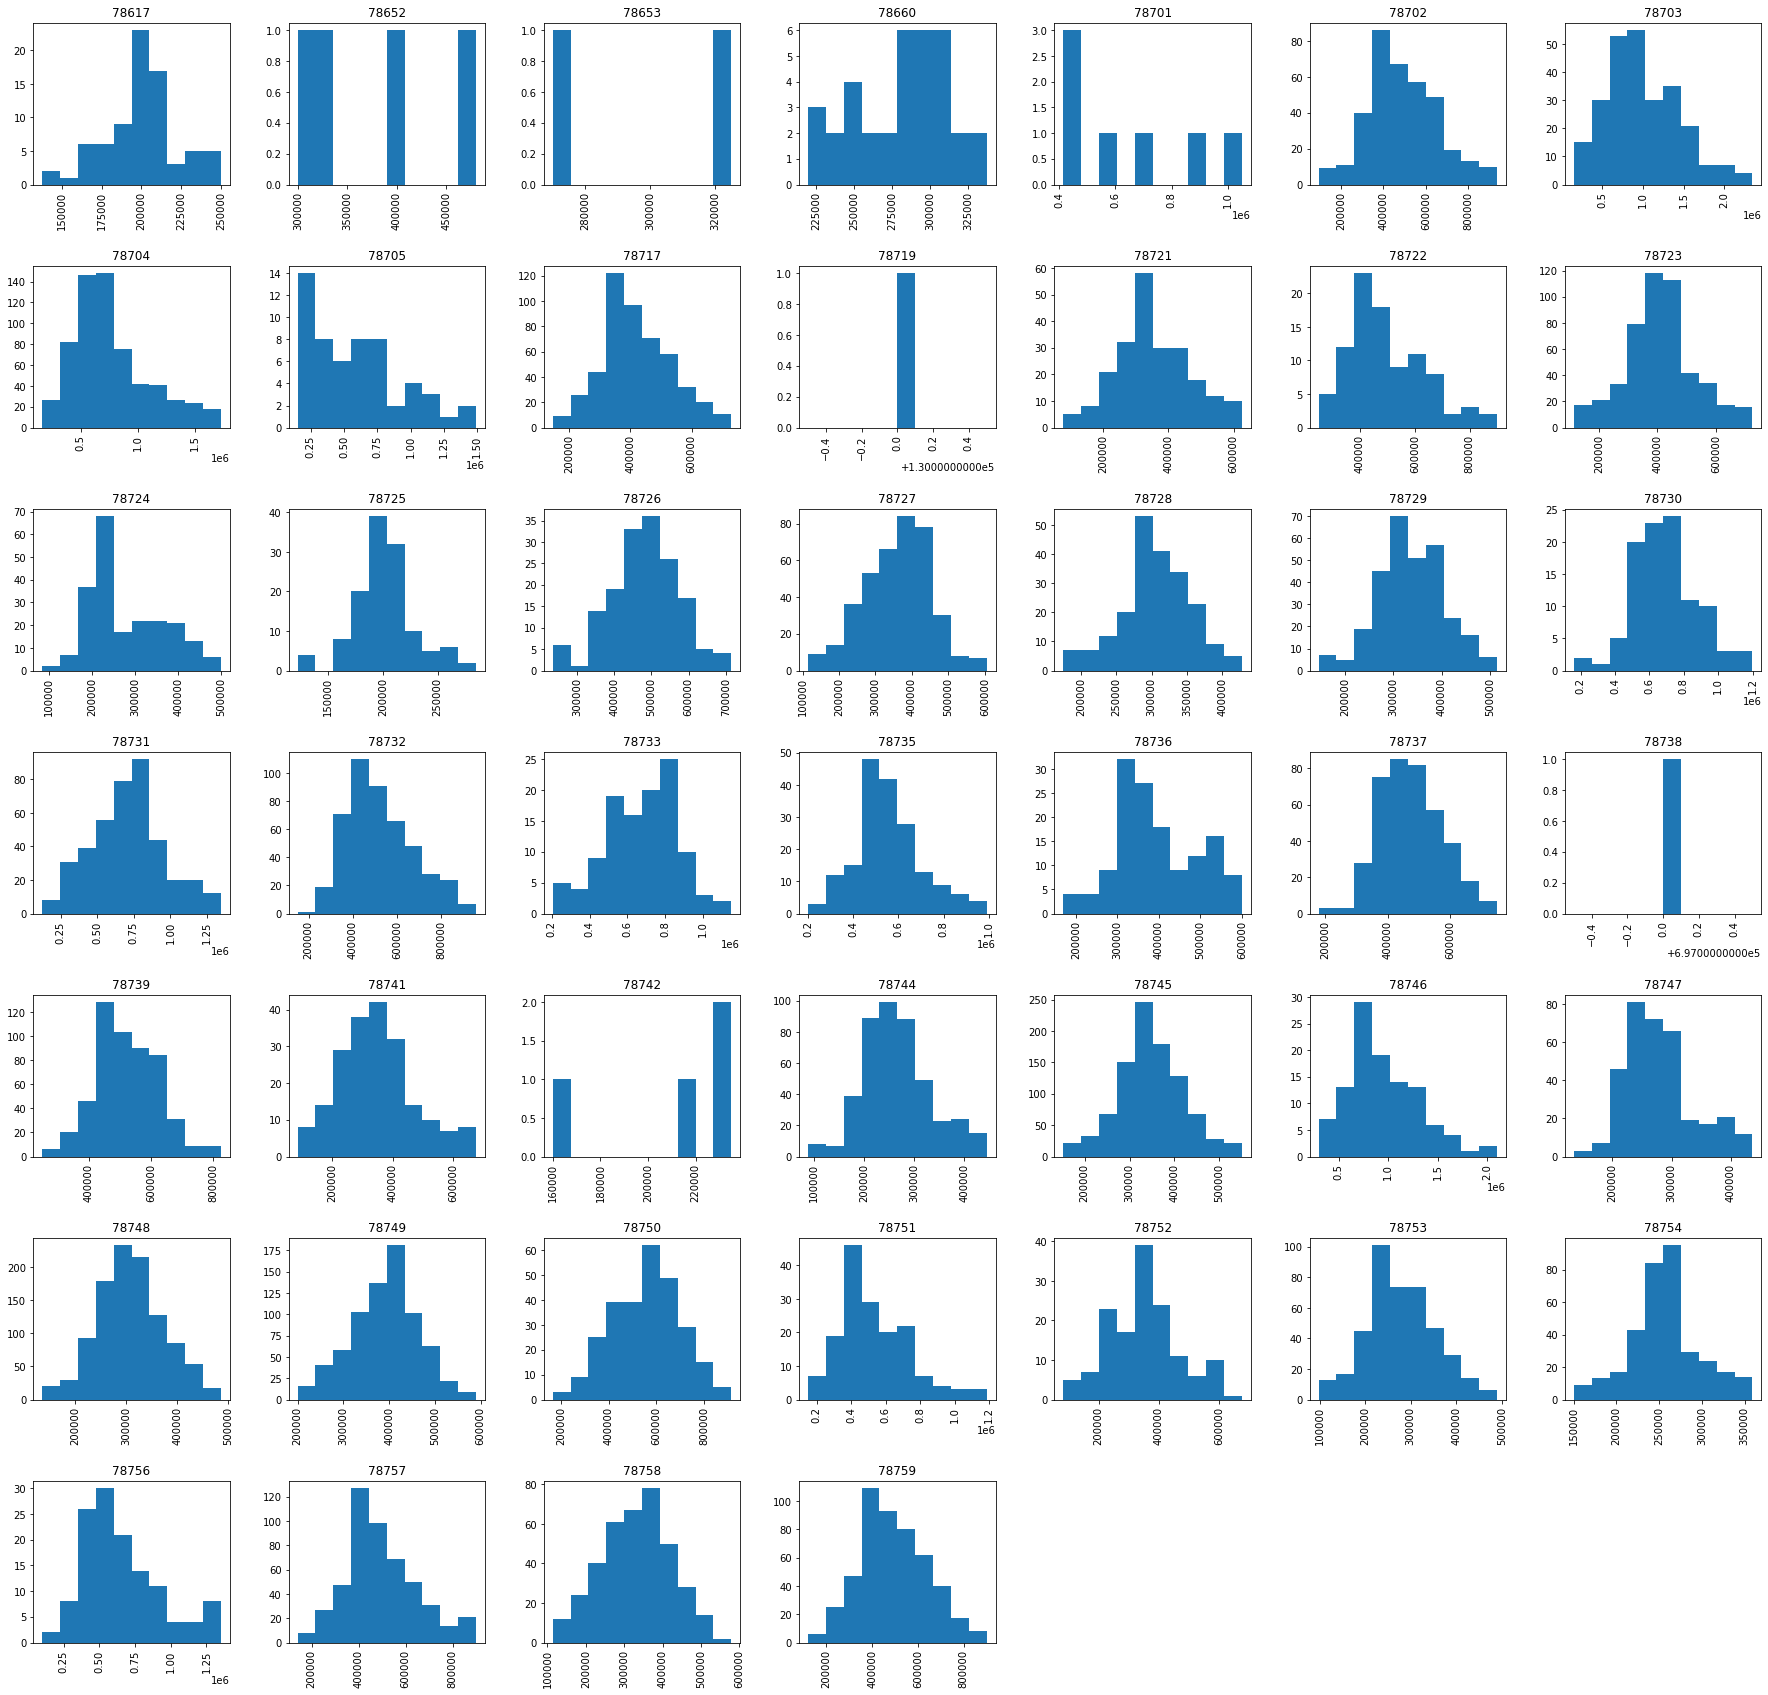

In [59]:
#We can check our price per zip code histograms.

df['price'].hist(by=df['zipcode'], figsize=(30,30));    

# some of our zip codes don't have enough sales to give us information

In [60]:
# We're going to drop our few zip codes where we have only a couple of data points

df.drop( df.loc[(df['zipcode']==78653) | (df['zipcode']==78738) | (df['zipcode']==78719)| (df['zipcode']==78652)| (df['zipcode']==78742)].index, axis=0, inplace=True)

In [61]:
# redo our zip code medians and rankings after outlier removal

# apply the median home price per zip code to the data frame again after outlier removal
df['median_zip'] = df['zipcode'].apply(lambda x: round(df.loc[df['zipcode']==x]['price'].median(), 0))

# group our dataframe by zipcode on median home price, sorted ascending. We want to bin like-medians together.
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

In [ ]:
# re-visualize zip code as a color function, using the median zip after outlier removal. 

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Zip Code by Median Rank', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Zip Code Median, by Zip Code Rank', fontsize=20);

# save visualization to png
plt.savefig('images/zip_prices.png')

##### Cleanup

In [63]:
# combine all school counts into a single field
df['numOfSchools'] = df['numOfPrimarySchools'] + df['numOfElementarySchools'] + df['numOfMiddleSchools'] + df['numOfHighSchools']

In [64]:
# there is only ONE listing with 5 schools, so we will change that one to 4
df.loc[df['numOfSchools']==5, 'numOfSchools'] = 4

In [65]:
# convert original boolean columns to binary 0/1
boolean = ['hasAssociation', 'hasCooling', 'hasHeating', 'hasSpa', 'hasView']

for item in boolean:
    df[boolean] = df[boolean].astype(int)

In [66]:
# reset indices on original data frame before making a copy
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

##### Images Dataframe

In [67]:
# Make a data frame of our images

df_images = pd.DataFrame(df['homeImage'])
df_images

homeImage
0      111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1      120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2      2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3      120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4      60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg
...                                                  ...
13084  29504086_f55db59cbebad30d475f31e6aee0d020-p_f.jpg
13085  29512934_ff9b6eefa7e2eb4e9ef983da13a23098-p_f.jpg
13086  241937773_66d3e483bd783eac5a52ff5f938d2a2e-p_f...
13087  29473281_9e90ec4652c4b3b6592a7fdd09f1ea6d-p_f.jpg
13088  29390174_9580c60e14870498b2ce98b5f889471e-p_f.jpg

[13089 rows x 1 columns]

# Visualizing our Data

In [ ]:
# apply the median price per square foot per zip code to the data frame
df['pr_sqft'] = df.apply(lambda x: round( (x['price'] / x['livingAreaSqFt'] ), 0), axis=1 )

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['livingAreaSqFt'], df['pr_sqft'], c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Total Square Footage', fontsize=12)
ax.set_ylabel('Price Per Square Foot', fontsize=12)
ax.set_title('Price Per Square Foot to Total Square Footage, by Zip Code Median Rank', fontsize=20);

# save visualization to png
plt.savefig('images/sf_zip_prices.png')

In [ ]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['livingAreaSqFt'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Footage, by Zip Code Median Rank', fontsize=20)
;

# save visualization to png
plt.savefig('images/price_sf.png')

Here's a fun way to see the improvements to our data quality after we clean outliers! A much deeper color map.

In [ ]:
# plotting latitude and longitude as a visual scatter plot. The improved color map actually visually demonstrates
# the removal of extreme price outliers.

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="price", palette="magma_r");

# save visualization to png
plt.savefig('images/geo_scatter.png')

In [ ]:
# we can also map our zip codes in this way.

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="zip_rank", palette="magma_r");

# save visualization to png
plt.savefig('images/geo_scatter2.png')

## Study Target Variable

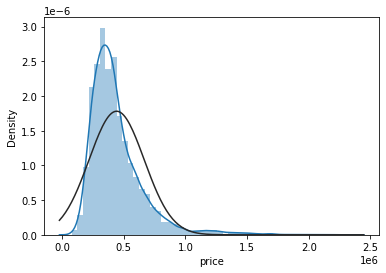

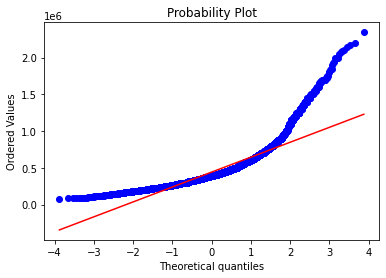

In [72]:
#histogram and normal probability plot
sns.distplot(df['price'], fit=norm);
fig = plt.figure()

res = stats.probplot(df['price'], plot=plt)

# our sales price histogram is positively skewed and has a high peak
# Our QQ-plot shows that we have heavy tails with right skew

In [73]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

# price is highly right skewed
# very positive kurtosis, indicating lots in the tails. We can see those tails in the right skew.

Skewness: 2.281054
Kurtosis: 8.373716


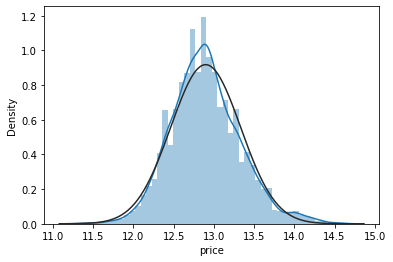

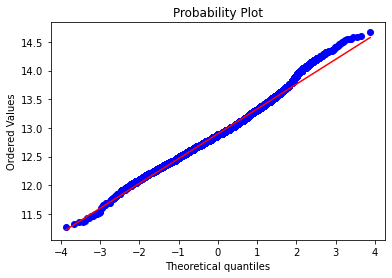

In [74]:
# log transform our target price to improve normality of distribution
df_target_log = np.log(df['price'])

#histogram and normal probability plot
sns.distplot(df_target_log, fit=norm);
fig = plt.figure()
res = stats.probplot(df_target_log, plot=plt)

# Our target price is more normally distributed when log transformed, so we'll be doing that when we make our model


## Correlations/Multicollinearity

In [75]:
# We are TEMPORARILY doing target encoding on the ENTIRE data set. 
# We will be overwriting these encodings later in order to avoid data leakage!
# We're doing it now for EDA purposes ONLY.
df = target_encoding(df, df)

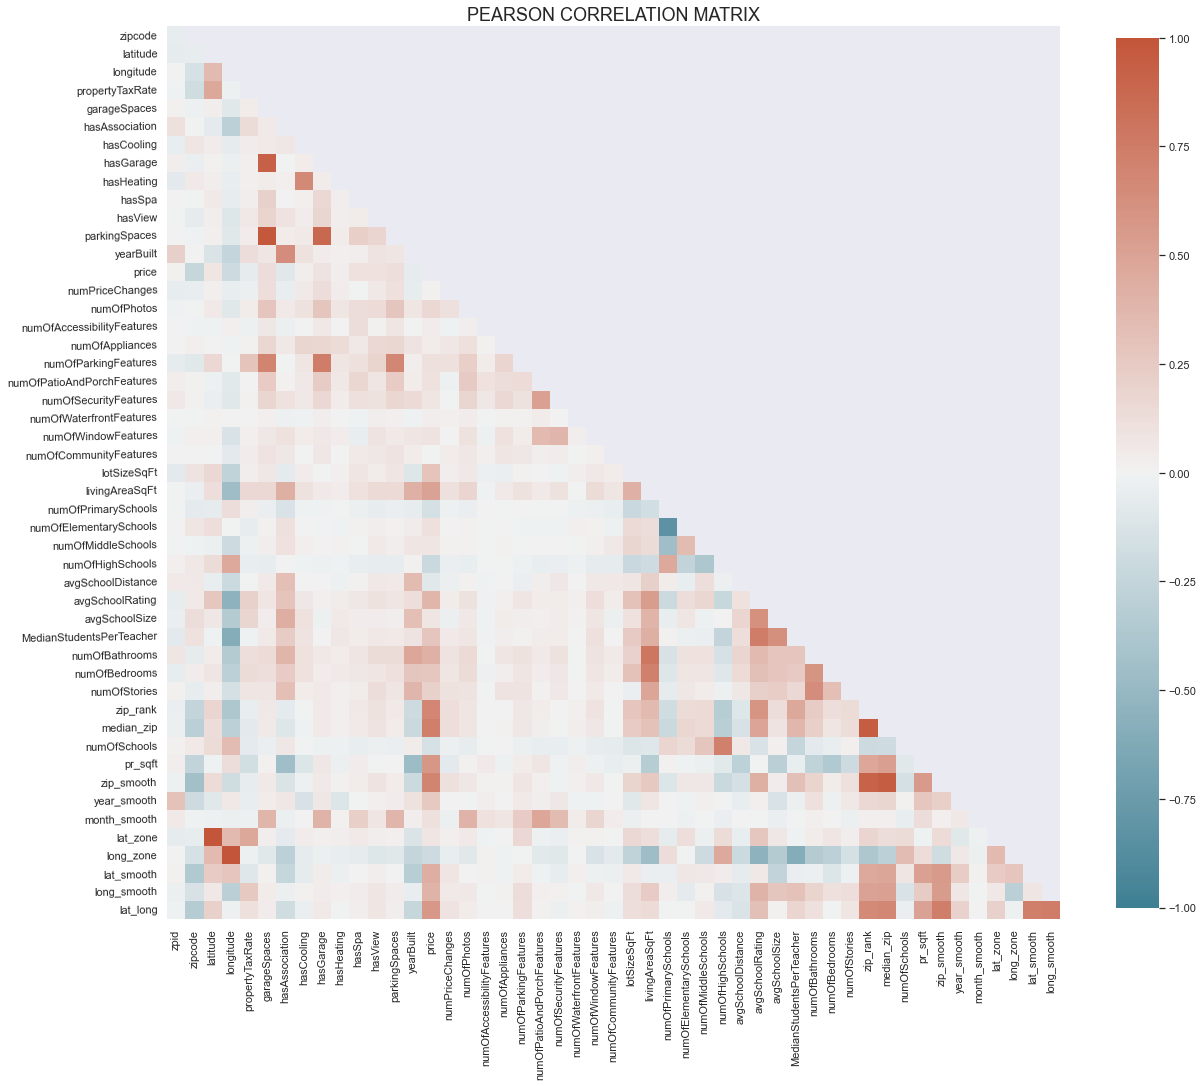

In [76]:
sns.set(font_scale = 1)
df_c = df.corr()

# plot a heat map for all correlations in our data set

# make our figure
fig, ax = plt.subplots(figsize=(20, 20))

# we want our heatmap to not show the upper triangle, which is redundant data
df_c_mask = np.triu(np.ones_like(df_c, dtype=bool))

# adjust mask and df to hide center diagonal
df_c_mask = df_c_mask[1:, :-1]
corr = df_c.iloc[1:,:-1].copy()

# color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# plot heatmap
sns.heatmap(corr, mask=df_c_mask, annot=False, fmt=".2f", cmap=cmap,
           vmin=-1, vmax=1, cbar_kws={"shrink": .8}, square=True)

# yticks rotate
plt.yticks(rotation=1)

# title
title = 'PEARSON CORRELATION MATRIX'
plt.title(title, fontsize=18)

#plt.savefig('images/heatmap.png')

plt.show()

In [77]:
#Get our list of highly correlated feature pairs with following steps:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
df_correlations = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation and below 90% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.99)]


level_0  \
pairs                                                                   
(garageSpaces, parkingSpaces)                            garageSpaces   
(parkingSpaces, garageSpaces)                           parkingSpaces   
(median_zip, zip_rank)                                     median_zip   
(zip_rank, median_zip)                                       zip_rank   
(median_zip, zip_smooth)                                   median_zip   
(zip_smooth, median_zip)                                   zip_smooth   
(garageSpaces, hasGarage)                                garageSpaces   
(hasGarage, garageSpaces)                                   hasGarage   
(zip_smooth, zip_rank)                                     zip_smooth   
(zip_rank, zip_smooth)                                       zip_rank   
(parkingSpaces, hasGarage)                              parkingSpaces   
(hasGarage, parkingSpaces)                                  hasGarage   
(numOfElementarySchools, numOfPrimarySchools)  numOfElementarySchools   
(numOfPrimarySchools, numOfElementarySchools)     numOfPrimarySchools   
(livingAreaSqFt, numOfBathrooms)                       livingAreaSqFt   
(numOfBathrooms, livingAreaSqFt)                       numOfBathrooms   

                                                              level_1  \
pairs                                                                   
(garageSpaces, parkingSpaces)                           parkingSpaces   
(parkingSpaces, garageSpaces)                            garageSpaces   
(median_zip, zip_rank)                                       zip_rank   
(zip_rank, median_zip)                                     median_zip   
(median_zip, zip_smooth)                                   zip_smooth   
(zip_smooth, median_zip)                                   median_zip   
(garageSpaces, hasGarage)                                   hasGarage   
(hasGarage, garageSpaces)                                garageSpaces   
(zip_smooth, zip_rank)                                       zip_rank   
(zip_rank, zip_smooth)                                     zip_smooth   
(parkingSpaces, hasGarage)                                  hasGarage   
(hasGarage, parkingSpaces)                              parkingSpaces   
(numOfElementarySchools, numOfPrimarySchools)     numOfPrimarySchools   
(numOfPrimarySchools, numOfElementarySchools)  numOfElementarySchools   
(livingAreaSqFt, numOfBathrooms)                       numOfBathrooms   
(numOfBathrooms, livingAreaSqFt)                       livingAreaSqFt   

                                               correlation  
pairs                                                       
(garageSpaces, parkingSpaces)                     0.980635  
(parkingSpaces, garageSpaces)                     0.980635  
(median_zip, zip_rank)                            0.952605  
(zip_rank, median_zip)                            0.952605  
(median_zip, zip_smooth)                          0.947095  
(zip_smooth, median_zip)                          0.947095  
(garageSpaces, hasGarage)                         0.923351  
(hasGarage, garageSpaces)                         0.923351  
(zip_smooth, zip_rank)                            0.913875  
(zip_rank, zip_smooth)                            0.913875  
(parkingSpaces, hasGarage)                        0.878039  
(hasGarage, parkingSpaces)                        0.878039  
(numOfElementarySchools, numOfPrimarySchools)     0.831121  
(numOfPrimarySchools, numOfElementarySchools)     0.831121  
(livingAreaSqFt, numOfBathrooms)                  0.782737  
(numOfBathrooms, livingAreaSqFt)                  0.782737

In [78]:
# Check out our variables correlationg with price
df_correlations = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_correlations.loc[df_correlations['level_0'] == 'price'].sort_values(0, ascending=False)

level_0                     level_1         0
714   price                       price  1.000000
739   price                  median_zip  0.728198
742   price                  zip_smooth  0.700368
738   price                    zip_rank  0.686132
741   price                     pr_sqft  0.574434
749   price                    lat_long  0.565190
726   price              livingAreaSqFt  0.500354
747   price                  lat_smooth  0.430516
735   price              numOfBathrooms  0.418796
748   price                 long_smooth  0.402620
732   price             avgSchoolRating  0.385059
725   price                 lotSizeSqFt  0.295673
734   price    MedianStudentsPerTeacher  0.283002
736   price               numOfBedrooms  0.272314
743   price                 year_smooth  0.264455
701   price                     zipcode  0.235549
730   price            numOfHighSchools  0.213056
737   price                numOfStories  0.210799
746   price                   long_zone  0.199865
703   price                   longitude  0.199852
716   price                 numOfPhotos  0.159085
727   price         numOfPrimarySchools  0.148756
740   price                numOfSchools  0.145586
705   price                garageSpaces  0.130039
712   price               parkingSpaces  0.121900
728   price      numOfElementarySchools  0.114151
744   price                month_smooth  0.110617
719   price        numOfParkingFeatures  0.110393
720   price  numOfPatioAndPorchFeatures  0.107849
710   price                      hasSpa  0.107551
711   price                     hasView  0.106469
731   price           avgSchoolDistance  0.092605
708   price                   hasGarage  0.091880
706   price              hasAssociation  0.090326
723   price         numOfWindowFeatures  0.090245
729   price          numOfMiddleSchools  0.082816
702   price                    latitude  0.081620
745   price                    lat_zone  0.081395
721   price       numOfSecurityFeatures  0.072561
733   price               avgSchoolSize  0.072149
704   price             propertyTaxRate  0.060315
713   price                   yearBuilt  0.055267
718   price             numOfAppliances  0.042193
717   price  numOfAccessibilityFeatures  0.031296
722   price     numOfWaterfrontFeatures  0.029389
709   price                  hasHeating  0.027070
707   price                  hasCooling  0.026036
715   price             numPriceChanges  0.012059
700   price                        zpid  0.008802
724   price      numOfCommunityFeatures  0.000745

We'll use:

* Keep garageSpaces (highest correlation with Price) and drop parkingSpaces, hasGarage, numOfParkingFeatures
* Keep numOfHighSchools and drop numOfPrimarySchools, numOfElementarySchools, numOfMiddleSchools
* Keep zip_smooth and drop median_zip, zip_rank
* Keep lat_long and drop lat_smooth, long_smooth
* numOfBathrooms correlates with square footage, but I'm not dropping either


We can get a sense of the most important features to our price from our correlation table. Zipcode as a plain variable does not correlate, which makes sense, because without some sort of transformation it is an arbitrary unordered number. We can see how as a smooth target encoding, it becomes the MOST important contributor to price. We can see here that big contributors to price include

    * zip code in a target encoded form
    * Lat/long in a target encoded form
    * livingAreaSqFt
    * numBathrooms
    * avgSchoolRating
    * lotSizeSqFt

##### Fields Cleanup

In [79]:
# Drop unneeded fields

df.drop(['zpid', 'city', 'streetAddress', 'latestPriceSource',  'homeImage',
       'numOfElementarySchools', 'numOfMiddleSchools', 'numOfPrimarySchools', 'numOfSchools', 
         'median_zip', 'zip_rank',
       'parkingSpaces',  'hasGarage', 'numOfParkingFeatures'], axis=1, inplace=True)

## Visualizing Categoricals and Continuous

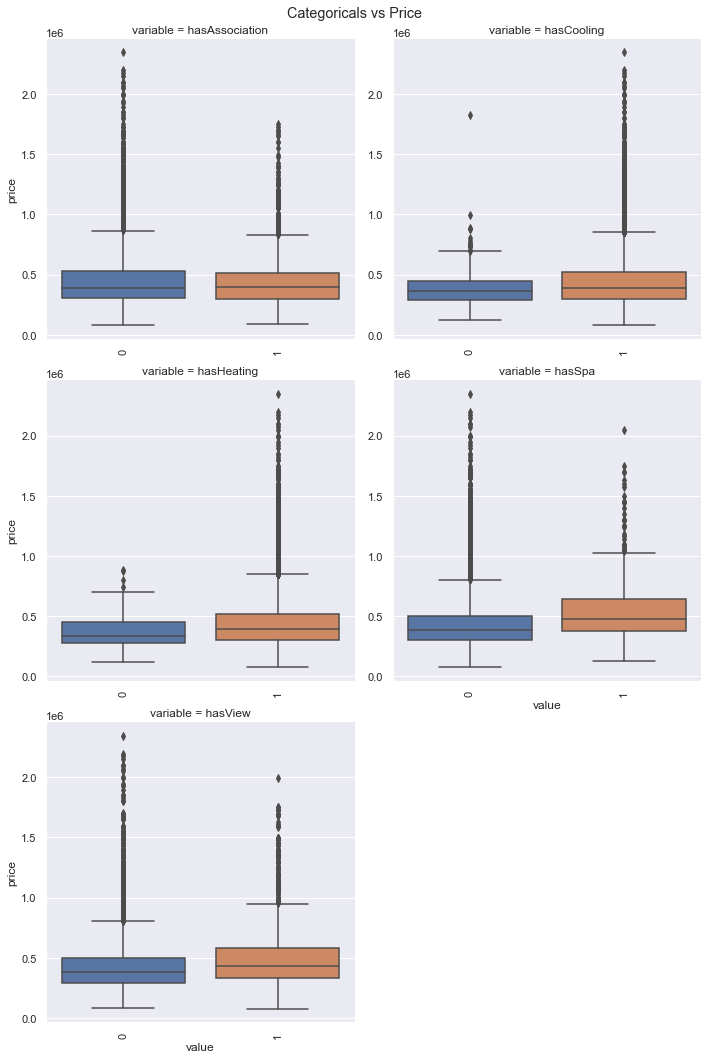

In [80]:
categoricals = ['hasAssociation', 'hasCooling', 'hasHeating', 'hasSpa', 'hasView']

df_categoricals = df[categoricals]
df_categoricals['price'] = df['price']

# plot our categoricals as box plots vs price
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
f = pd.melt(df_categoricals, id_vars=['price'], value_vars=categoricals)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

g.fig.subplots_adjust(top=0.95) # adjust the Figure
g.fig.suptitle('Categoricals vs Price');

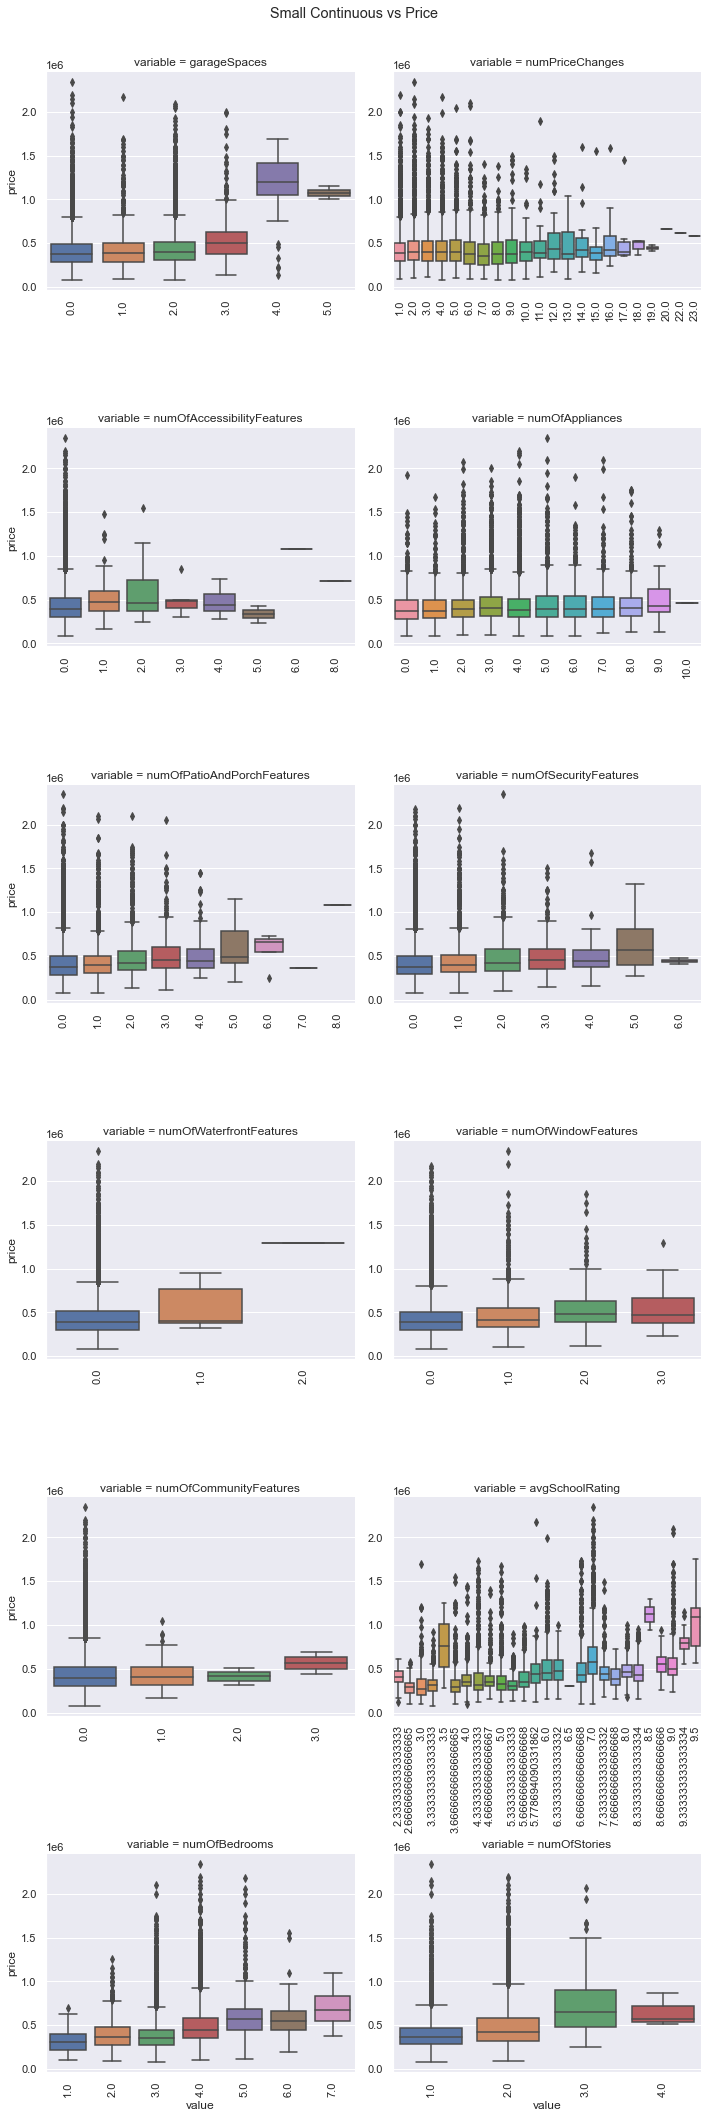

In [81]:
small_cont = ['garageSpaces', 'numPriceChanges','numOfAccessibilityFeatures', 'numOfAppliances',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'avgSchoolRating', 
       'numOfBedrooms', 'numOfStories']
# plot our continuous as box plots vs price
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(df, id_vars=['price'], value_vars=small_cont)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

g.fig.subplots_adjust(top=0.95) # adjust the Figure
g.fig.suptitle('Small Continuous vs Price');


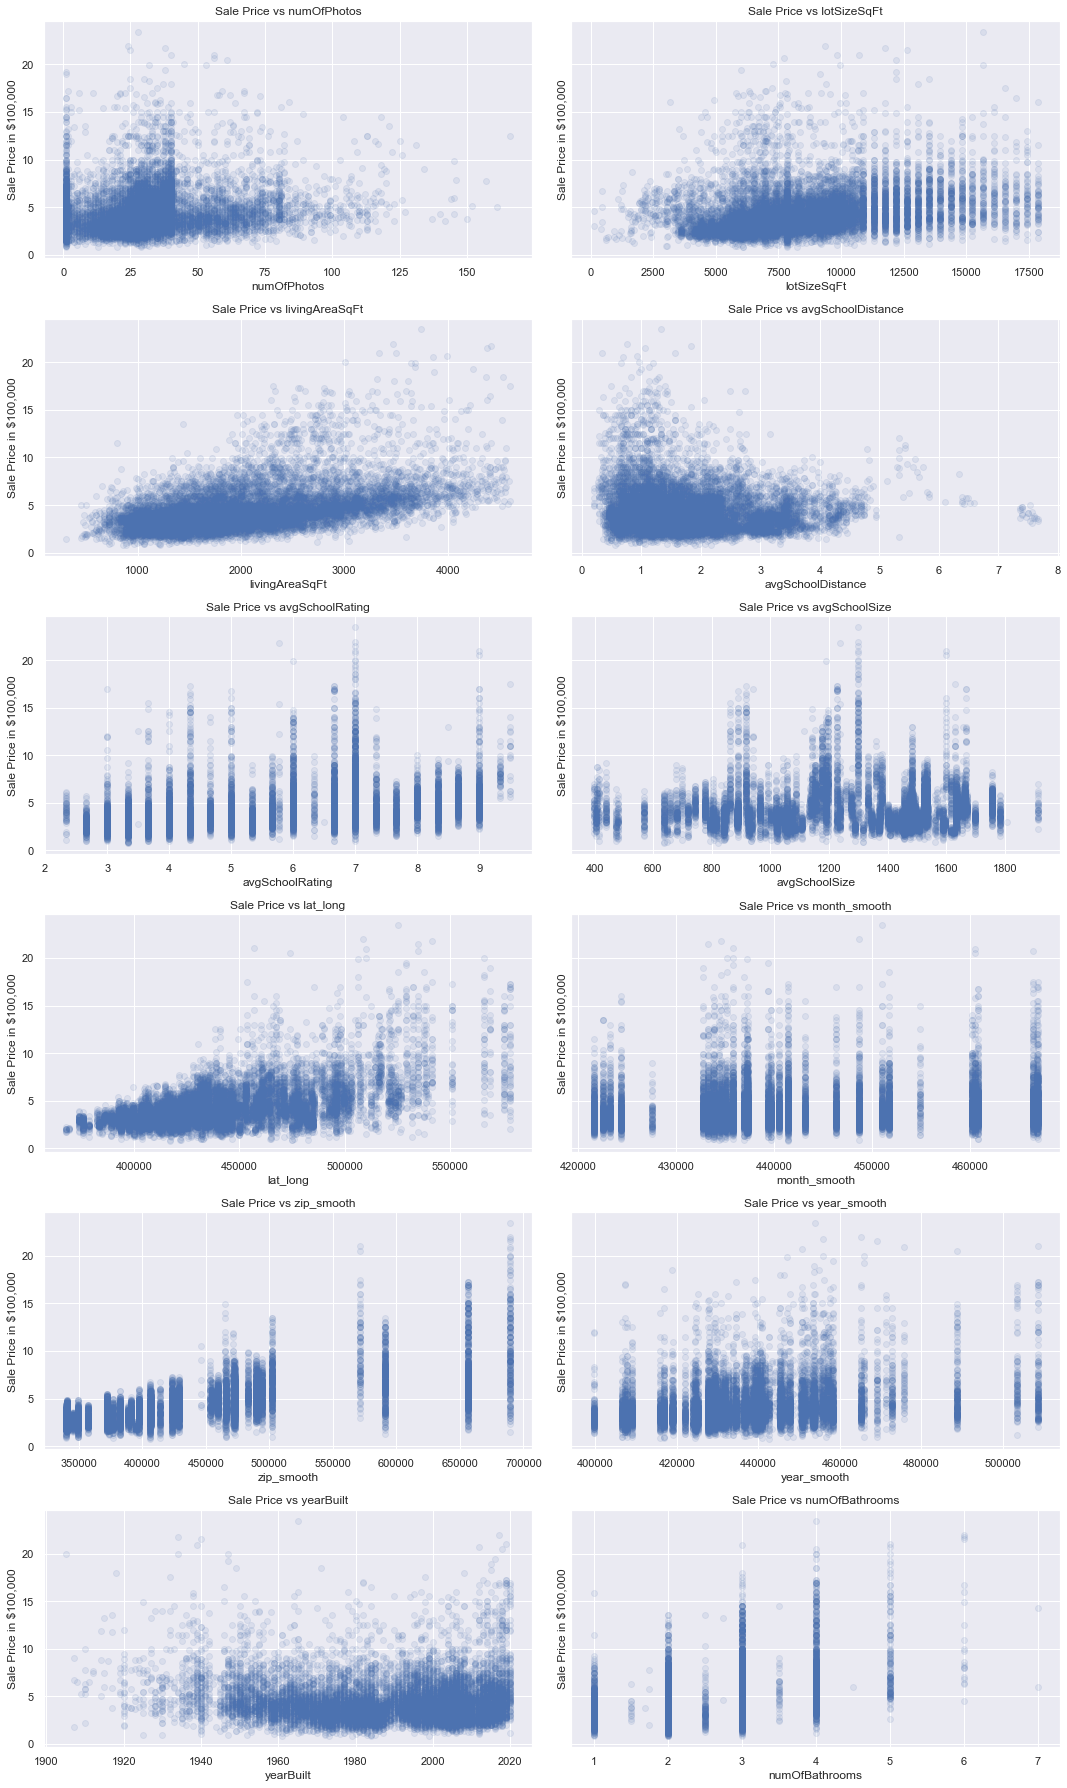

In [82]:
column = ['numOfPhotos', 'lotSizeSqFt', 'livingAreaSqFt',
     'avgSchoolDistance', 'avgSchoolRating', 'avgSchoolSize',
             'lat_long', 'month_smooth', 'zip_smooth', 'year_smooth', 'yearBuilt', 'numOfBathrooms']

# check linearity of continuous predictors

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15,25), sharey=True)

for ax, column in zip(axes.flatten(), column):
    ax.scatter(df[column], df['price']/100000, label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()

Positive relationship observed with:
* lot size
* square footage
* school rating
* number of bedrooms
* lat/long

Negative relationship observed with:
* number of price changes

Others seem neutral/uncertain

## Looking for Polynomials

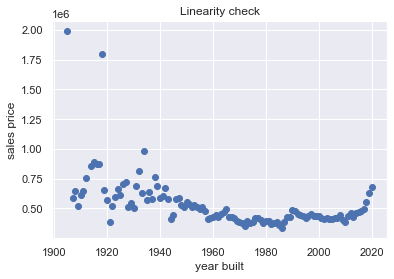

In [83]:
# Checking out our mean sales price for year built scattered versus price shows a polynomial relationship

yearly_prices = df.groupby('yearBuilt')['price'].mean()

plt.scatter(yearly_prices.index, yearly_prices)
plt.title("Linearity check")
plt.xlabel('year built')
plt.ylabel('sales price')
plt.show()

Looks somewhat polynomial

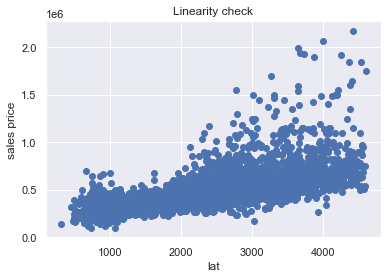

In [84]:
# Checking out our mean sales price for square footage  scattered versus price shows a polynomial relationship
lat_prices = df.groupby('livingAreaSqFt')['price'].mean()

plt.scatter(lat_prices.index, lat_prices)
plt.title("Linearity check")
plt.xlabel('lat')
plt.ylabel('sales price')
plt.show()

This looks linear

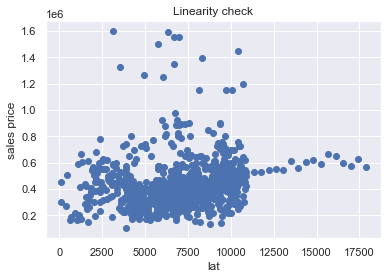

In [85]:
# Checking out our mean sales price for lot size scattered versus price shows a polynomial relationship
lat_prices = df.groupby('lotSizeSqFt')['price'].mean()

plt.scatter(lat_prices.index, lat_prices)
plt.title("Linearity check")
plt.xlabel('lat')
plt.ylabel('sales price')
plt.show()

This looks somewhat linear

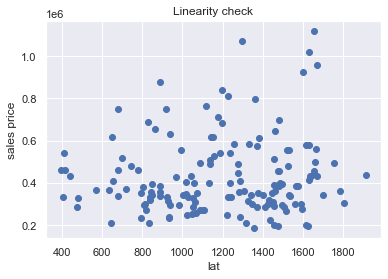

In [86]:
# Checking out our mean sales price for average school size, scattered versus price shows a polynomial relationship
lat_prices = df.groupby('avgSchoolSize')['price'].mean()

plt.scatter(lat_prices.index, lat_prices)
plt.title("Linearity check")
plt.xlabel('lat')
plt.ylabel('sales price')
plt.show()

This looks meaningless

# Standard Models

## Data Preprocessing

Creating our train, validation, and test sets

In [87]:
# Split our x and y
y = pd.DataFrame(np.log(df['price']))
x = df.drop('description', axis=1)

# split into train, validation and test
train, remaining_20, y_train, y_remaining = train_test_split(x, y, test_size=0.2, random_state=randomstate)
val, test, y_val, y_test = train_test_split(remaining_20, y_remaining, test_size=.5, random_state=randomstate)

# reset indices to prevent any index mismatches
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)
y_train = np.array(y_train.reset_index(drop=True))
y_val = np.array(y_val.reset_index(drop=True))
y_test = np.array(y_test.reset_index(drop=True))

In [88]:
# define categorical fields, continuous fields, polynomial fields, and drop fields
categoricals = ['zipcode', 'homeType', 'sale_date', 
                'numOfHighSchools', 'propertyTaxRate', 
                'hasAssociation', 'hasCooling', 'hasHeating', 'hasSpa', 'hasView']
continuous = ['garageSpaces', 'numPriceChanges',
        'numOfPhotos', 'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfPatioAndPorchFeatures',
        'numOfSecurityFeatures', 'numOfWaterfrontFeatures', 'numOfWindowFeatures', 'numOfCommunityFeatures',
        'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms', 'numOfBedrooms', 'numOfStories',
             'zip_smooth', 'year_smooth', 'month_smooth', 'lat_long']
poly = ['yearBuilt']
drop_fields = [
                'price', 'latitude', 'longitude', 'lat_zone', 'long_zone', 'lat_smooth', 'long_smooth']

We call our processing pipeline on our train, val and test sets

* standardize our continuous variables
* target encoding specific categoricals
* adding a polynomial feature
* dropping unneeded fields after target encoding

In [89]:
# call our processing pipeline function to clean our inputs
processed_train, processed_val, processed_test = processing_pipeline(train, val, test, categoricals, continuous, poly, drop_fields)

Iteration: 0
Iteration: 1
Iteration: 2


We're going to evaluate many model types. In order to keep track of our results, we'll be making a dictionary to store our model results.

In [90]:
# prepare dictionary to store score results

models = {}
models['model'] = []
models['r2'] = []
models['mae'] = []
models['rmse'] = [] 

## Spot Check Models

In [91]:
# Set up spot check models

baseline_models = {
    "LR": LinearRegression(),
    "Extra Trees": ExtraTreesRegressor(random_state = randomstate),
    "Gradient Boosted" : GradientBoostingRegressor(random_state = randomstate),
    "KNN" : KNeighborsRegressor(),
    "Lars" : Lars(random_state = randomstate, copy_X=True, normalize=False),
    "LinearSVR" : LinearSVR(random_state = randomstate),
    "MLPRegressor" : MLPRegressor(random_state = randomstate),
    "Bayesian Ridge" : BayesianRidge(),
    "Nu SVR": NuSVR(),
    "Ridge" : Ridge(random_state = randomstate, tol=1e-3, normalize=False),
    "SVR" : SVR(),
    "XGB Regressor" : xgb.XGBRegressor(random_state = randomstate),
    "Random Forest Regressor" : RandomForestRegressor(random_state=randomstate)
}

# run spot check on each model inline
for model in baseline_models:
    this_model = baseline_models[model]
    label = model
    spot_check = score_model(this_model, processed_train, y_train, label, models)



 LR  scores
CV 5 R2 Train Score: 77.14
CV 5 MAE Train Score: 0.1457
CV 5 RMSE Train Score: 0.2075


 Extra Trees  scores
CV 5 R2 Train Score: 78.79
CV 5 MAE Train Score: 0.1346
CV 5 RMSE Train Score: 0.1997


 Gradient Boosted  scores
CV 5 R2 Train Score: 77.38
CV 5 MAE Train Score: 0.148
CV 5 RMSE Train Score: 0.2064


 KNN  scores
CV 5 R2 Train Score: 70.13
CV 5 MAE Train Score: 0.1699
CV 5 RMSE Train Score: 0.2372


 Lars  scores
CV 5 R2 Train Score: -1.4016346105481372e+27
CV 5 MAE Train Score: 249625273791.754
CV 5 RMSE Train Score: 745106495150.006


 LinearSVR  scores
CV 5 R2 Train Score: 76.41
CV 5 MAE Train Score: 0.144
CV 5 RMSE Train Score: 0.2108


 MLPRegressor  scores
CV 5 R2 Train Score: 62.1
CV 5 MAE Train Score: 0.1742
CV 5 RMSE Train Score: 0.2633


 Bayesian Ridge  scores
CV 5 R2 Train Score: 77.15
CV 5 MAE Train Score: 0.1458
CV 5 RMSE Train Score: 0.2074


 Nu SVR  scores
CV 5 R2 Train Score: 78.56
CV 5 MAE Train Score: 0.1346
CV 5 RMSE Train Score: 0.2009


 Rid

In [92]:
# make data frame from our models dictionary
target = pd.DataFrame(models).reset_index(drop=True)

# sort data frame by mae and reset index
target.sort_values('mae', ascending=True).head(20)

model            r2           mae          rmse
1               Extra Trees  7.879000e+01  1.346000e-01  1.997000e-01
8                    Nu SVR  7.856000e+01  1.346000e-01  2.009000e-01
12  Random Forest Regressor  7.887000e+01  1.365000e-01  1.994000e-01
10                      SVR  7.853000e+01  1.373000e-01  2.011000e-01
11            XGB Regressor  7.850000e+01  1.391000e-01  2.012000e-01
5                 LinearSVR  7.641000e+01  1.440000e-01  2.108000e-01
9                     Ridge  7.717000e+01  1.456000e-01  2.073000e-01
0                        LR  7.714000e+01  1.457000e-01  2.075000e-01
7            Bayesian Ridge  7.715000e+01  1.458000e-01  2.074000e-01
2          Gradient Boosted  7.738000e+01  1.480000e-01  2.064000e-01
3                       KNN  7.013000e+01  1.699000e-01  2.372000e-01
6              MLPRegressor  6.210000e+01  1.742000e-01  2.633000e-01
4                      Lars -1.401635e+27  2.496253e+11  7.451065e+11

## Feature Selectors

In [93]:
# Unless we specify a different model, this is our baseline model
model = ExtraTreesRegressor(random_state = randomstate)

In [94]:
# use statsmodels to check our feature p-values
predictors_train = sm.add_constant(processed_train)
modelols = sm.OLS(y_train, predictors_train).fit()
modelols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     328.5
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:38:01   Log-Likelihood:                 1738.7
No. Observations:               10471   AIC:                            -3255.
Df Residuals:                   10360   BIC:                            -2450.
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1380      0.017    357.275      0.000       6.104       6.172
x1             0.0084      0.002      3.466      0.001       0.004       0.013
x2            -0.0683      0.002    -32.296      0.000      -0.072      -0.064
x3             0.0213      0.002      8.811      0.000       0.017       0.026
x4             0.0043      0.002      2.074      0.038       0.000       0.008
x5             0.0029      0.002      1.362      0.173      -0.001       0.007
x6             0.0120      0.003      4.244      0.000       0.006       0.017
x7             0.0048      0.003      1.893      0.058      -0.000       0.010
x8             0.0022      0.002      1.106      0.269      -0.002       0.006
x9            -0.0006      0.002     -0.267      0.789      -0.005       0.004
x10           -0.0011      0.002     -0.522      0.602      -0.005       0.003
x11            0.0301      0.003     11.065      0.000       0.025       0.035
x12            0.2014      0.005     41.181      0.000       0.192       0.211
x13            0.0086      0.003      2.831      0.005       0.003       0.015
x14            0.0549      0.006      9.512      0.000       0.044       0.066
x15           -0.0313      0.006     -5.598      0.000      -0.042      -0.020
x16            0.0129      0.006      2.281      0.023       0.002       0.024
x17            0.0269      0.004      6.876      0.000       0.019       0.035
x18           -0.0067      0.003     -2.148      0.032      -0.013      -0.001
x19           -0.0244      0.003     -8.570      0.000      -0.030      -0.019
x20            0.2262      0.005     46.449      0.000       0.217       0.236
x21            0.0155      0.003      5.513      0.000       0.010       0.021
x22            0.0075      0.003      2.545      0.011       0.002       0.013
x23            0.0392      0.004      9.708      0.000       0.031       0.047
x24            0.0527      0.004     13.281      0.000       0.045       0.061
x25            0.0376      0.003     14.444      0.000       0.033       0.043
x26           -0.1557      0.029     -5.455      0.000      -0.212      -0.100
x27           -0.1192      0.039     -3.035      0.002      -0.196      -0.042
x28            0.6170      0.091      6.746      0.000       0.438       0.796
x29            0.3132      0.016     19.659      0.000       0.282       0.344
x30            0.0553      0.015      3.641      0.000       0.026       0.085
x31            0.0843      0.014      5.941      0.000       0.057       0.112
x32            0.3659      0.033     11.245      0.000       0.302       0.430
x33            0.1776      0.035      5.127      0.000       0.110       0.246
x34            0.2871      0.018     15.765      0.000       0.251       0.323
x35            0.3095      0.026     11.852      0.000       0.258       0.361
x3

Feature selectors are different methods to help us pick which features we want to use in our model. In our example above where we used ALL predictors in our linear regression, several of our features had a p-value over .05, which indicates that there is more than a 5% chance that the changes attributed to that feature were actually by random chance. We want features where our p-value is below a threshold that we specify where we are reasonably confident that the feature is contributing to the model and not by random chance.

##### Forward-Backward Selector

Now we'll try a simple forward-backward feature selection model based on p-value, using a statsmodel OLS linear regression model. This selector starts with zero features, internally runs the model for each feature individually, and adds the lowest p-value feature to its list to include. It then runs the model again with the original feature included and tries adding each other feature individually. It will either add the next best feature under the threshold or remove an existing feature if it is no longer within the threshold. This process iterates until all features in the model are under the p-value threshold.

This model takes quite some time to run, so is commented out with the results replicated in markdown following.

In [95]:
#result = stepwise_selection(pd.DataFrame(processed_train), y_train, verbose=True)

#print('resulting features:', result)


result = [11, 19, 112, 1, 20, 21, 109, 37, 25, 24, 44, 13, 49, 52, 54, 22, 51, 5, 2, 67, 23, 10, 35, 38, 26, 47, 60, 53, 14, 63, 48, 62, 113, 28, 40, 18, 16, 36, 61, 66, 31, 115, 27, 32, 0, 34, 6, 58, 70, 71, 74, 73, 76, 33, 64, 15, 72, 75, 30, 29, 69]

Add                              11 with p-value 0.0
Add                              19 with p-value 0.0
Add                             112 with p-value 9.12756e-192
Add                               1 with p-value 2.60446e-138
Add                              20 with p-value 7.16903e-106
Add                              21 with p-value 4.54759e-78
Add                             109 with p-value 3.57763e-41
Add                              37 with p-value 1.07257e-43
Add                              25 with p-value 6.13284e-43
Add                             108 with p-value 1.15586e-33
Add                              24 with p-value 1.83366e-37
Add                              44 with p-value 3.86482e-33
Add                              13 with p-value 1.09407e-33
Add                              49 with p-value 7.89242e-49
Add                              52 with p-value 6.63119e-48
Add                              54 with p-value 2.74602e-31
Add                              22 w

In [96]:
# Run our linear regression again, using only the features recommended by our feature selector

X_train_refined = pd.DataFrame(processed_train)[result]

predictors_int = sm.add_constant(X_train_refined)
model1 = sm.OLS(y_train, predictors_int).fit()

model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     589.3
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:39:34   Log-Likelihood:                 1698.6
No. Observations:               10471   AIC:                            -3273.
Df Residuals:                   10409   BIC:                            -2823.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6332      0.030    427.339      0.000      12.575      12.691
11             0.1937      0.004     44.430      0.000       0.185       0.202
19             0.1534      0.006     25.857      0.000       0.142       0.165
112           -0.0699      0.006    -10.809      0.000      -0.083      -0.057
1             -0.0682      0.002    -32.412      0.000      -0.072      -0.064
20             0.0161      0.003      5.811      0.000       0.011       0.021
21             0.0129      0.003      4.641      0.000       0.007       0.018
109            0.1674      0.015     11.209      0.000       0.138       0.197
37            -0.3557      0.022    -16.259      0.000      -0.399      -0.313
25            -0.3939      0.028    -14.016      0.000      -0.449      -0.339
24             0.0390      0.003     15.166      0.000       0.034       0.044
44            -0.2777      0.013    -21.952      0.000      -0.303      -0.253
13             0.0492      0.005     10.031      0.000       0.040       0.059
49            -0.1984      0.013    -15.802      0.000      -0.223      -0.174
52             0.1095      0.011     10.375      0.000       0.089       0.130
54            -0.2299      0.014    -16.559      0.000      -0.257      -0.203
22             0.0387      0.004     10.633      0.000       0.032       0.046
51            -0.1542      0.013    -11.686      0.000      -0.180      -0.128
5              0.0151      0.003      5.849      0.000       0.010       0.020
2              0.0205      0.002      8.930      0.000       0.016       0.025
67             0.0635      0.019      3.306      0.001       0.026       0.101
23             0.0542      0.004     13.979      0.000       0.047       0.062
10             0.0300      0.003     11.207      0.000       0.025       0.035
35             0.0960      0.013      7.342      0.000       0.070       0.122
38            -0.1753      0.020     -8.952      0.000      -0.214      -0.137
26            -0.3307      0.040     -8.253      0.000      -0.409      -0.252
47            -0.1418      0.022     -6.594      0.000      -0.184      -0.100
60            -0.1050      0.014     -7.673      0.000      -0.132      -0.078
53             0.2108      0.024      8.621      0.000       0.163       0.259
14            -0.0289      0.005     -5.899      0.000      -0.039      -0.019
63             0.1240      0.012     10.086      0.000       0.100       0.148
48            -0.1878      0.023     -8.343      0.000      -0.232      -0.144
62             0.1824      0.022      8.419      0.000       0.140       0.225
113            0.0909      0.017      5.363      0.000       0.058       0.124
28             0.1461      0.016      8.885      0.000       0.114       0.178
40            -0.0852      0.016     -5.197      0.000      -0.117      -0.053
18

In [97]:
# Set upline models
baseline_models = {
    "Extra Trees w/forward-backward": ExtraTreesRegressor(random_state = randomstate),
    "Gradient Boosted w/forward-backward" : GradientBoostingRegressor(random_state = randomstate),
    "Nu SVR w/forward-backward": NuSVR(),
    "XGB Regressor w/forward-backward" : xgb.XGBRegressor(random_state = randomstate),
    "Random Forest Regressor w/forward-backward" : RandomForestRegressor(random_state=randomstate)
}

# run spot check on each model inline with forward-backward selected features
for model in baseline_models:
    this_model = baseline_models[model]
    label = model
    spot_check = score_model(this_model, X_train_refined, y_train, label, models)



 Extra Trees w/forward-backward  scores
CV 5 R2 Train Score: 79.1
CV 5 MAE Train Score: 0.1345
CV 5 RMSE Train Score: 0.1983


 Gradient Boosted w/forward-backward  scores
CV 5 R2 Train Score: 77.15
CV 5 MAE Train Score: 0.1494
CV 5 RMSE Train Score: 0.2074


 Nu SVR w/forward-backward  scores
CV 5 R2 Train Score: 78.71
CV 5 MAE Train Score: 0.1338
CV 5 RMSE Train Score: 0.2002


 XGB Regressor w/forward-backward  scores
CV 5 R2 Train Score: 78.58
CV 5 MAE Train Score: 0.1388
CV 5 RMSE Train Score: 0.2007


 Random Forest Regressor w/forward-backward  scores
CV 5 R2 Train Score: 78.62
CV 5 MAE Train Score: 0.138
CV 5 RMSE Train Score: 0.2005


##### Permutation Importance

Now we will use permutation importance to determine which of these words is actually relevant to our model. This is a great model-agnostic method that you can use with any model type, and the way it works is very easy to understand. After fitting the model, it calculates a baseline R^2 score. Then for each feature, it scrambles the inputs of that feature, turnings its contribution into noise. The model is evaluated again with the feature scrambled, and the change in overall R^2 is logged as the importance for that feature. After scrambling all features, each feature has been assigned an importance based on the R^2 reduction. You can then select the features that had an effect on R^2 based on your own threshold (I kept anything >= .001) and throw out the remaining features.

You can learn more about this underrated feature selection method here: https://explained.ai/rf-importance/ The article focuses on Random Forest, but discusses permutation importance as an excellent feature selection method for any model type.

In [98]:
x_train_df = pd.DataFrame(processed_train)

model1 = LinearRegression()
model1.fit(x_train_df, y_train)

from sklearn.inspection import permutation_importance
r = permutation_importance(model1, x_train_df, y_train,
                           n_repeats=15,
                            random_state=0,
                          n_jobs=-1)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.001:
        print(f"{x_train_df.columns[i]:<8} "
            f"\t\tImportance: {r.importances_mean[i]:.3f} ")
        
importances = {}

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.001:
        importances[x_train_df.columns[i]] = r.importances_mean[i]
    else: continue
        
importances

important_features = list(importances.keys())
print(important_features)

109      		Importance: 237997297843182272512.000 
111      		Importance: 166538378385308549120.000 
19       		Importance: 104985541586884870144.000 
110      		Importance: 81812136759169449984.000 
21       		Importance: 49575120597323767808.000 
30       		Importance: 44207340632039981056.000 
29       		Importance: 23692999819995521024.000 
107      		Importance: 22715658552049483776.000 
75       		Importance: 15222018996144893952.000 
43       		Importance: 14887639580680103936.000 
106      		Importance: 13402403931102369792.000 
83       		Importance: 10817233876257941504.000 
77       		Importance: 10659886409309917184.000 
108      		Importance: 10266286892060510208.000 
82       		Importance: 8159034761280723968.000 
73       		Importance: 7577184691310565376.000 
74       		Importance: 7417390400094042112.000 
86       		Importance: 6993449343572182016.000 
72       		Importance: 6978402957657062400.000 
84       		Importance: 6535223607285642240.000 
94       		Importance: 

In [79]:
important_features = [109, 111, 19, 110, 21, 30, 29, 107, 75, 43, 106, 83, 77, 108, 82, 73, 74, 86, 72, 84, 94, 76, 92, 88, 90, 89, 71, 78, 70, 49, 79, 81, 93, 44, 53, 87, 55, 91, 63, 57, 97, 65, 80, 69, 95, 85, 51, 98, 48, 28, 62, 45, 46, 60, 42, 61, 58, 102, 67, 54, 52, 96, 38, 66, 103, 32, 35, 101, 34, 31, 68, 104, 37, 47, 36, 64, 105, 99, 40, 56, 59, 26, 41, 100, 27, 33, 50, 25, 39, 11, 1, 13, 23, 24, 22, 112, 14, 10, 16, 18, 2, 20, 15, 5]

In [99]:
# make permutation importance data set
x_train_df = pd.DataFrame(processed_train)
permutation_x_train = x_train_df[important_features]

In [100]:
# Set upline models
baseline_models = {
    "Extra Trees w/permutation": ExtraTreesRegressor(random_state = randomstate),
    "Gradient Boosted w/permutation" : GradientBoostingRegressor(random_state = randomstate),
    "Nu SVR w/permutation": NuSVR(),
    "XGB Regressor w/permutation" : xgb.XGBRegressor(random_state = randomstate),
    "Random Forest Regressor w/permutation" : RandomForestRegressor(random_state=randomstate)
}

# run spot check on each model inline
for model in baseline_models:
    this_model = baseline_models[model]
    label = model
    spot_check = score_model(this_model, permutation_x_train, y_train, label, models)



 Extra Trees w/permutation  scores
CV 5 R2 Train Score: 78.57
CV 5 MAE Train Score: 0.1355
CV 5 RMSE Train Score: 0.2008


 Gradient Boosted w/permutation  scores
CV 5 R2 Train Score: 77.32
CV 5 MAE Train Score: 0.1482
CV 5 RMSE Train Score: 0.2066


 Nu SVR w/permutation  scores
CV 5 R2 Train Score: 78.8
CV 5 MAE Train Score: 0.1322
CV 5 RMSE Train Score: 0.1998


 XGB Regressor w/permutation  scores
CV 5 R2 Train Score: 78.43
CV 5 MAE Train Score: 0.1392
CV 5 RMSE Train Score: 0.2015


 Random Forest Regressor w/permutation  scores
CV 5 R2 Train Score: 78.62
CV 5 MAE Train Score: 0.1377
CV 5 RMSE Train Score: 0.2006


##### Principal Component Analysis

We can attempt to perform dimensionality reduction on our dataset while still retaining variance.

Explained variance with all components is  99.99999999999991
1 component explains  16.08204036618756
1st and 2nd components explains  26.672796045078456
1st to 3rd components explains  35.41793186951252
1st to 4th components explains  41.544918047848626


Text(0, 0.5, 'Explained Variance')

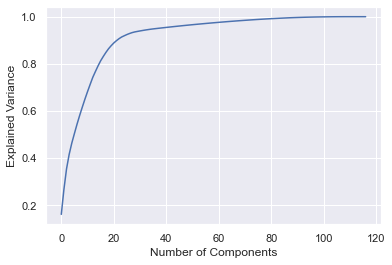

In [101]:
# Visualize components

pca_all = PCA(n_components=processed_train.shape[1], random_state=randomstate)
x_pca = pca_all.fit_transform(processed_train)

print("Explained variance with all components is ", sum(pca_all.explained_variance_ratio_ * 100))
print("1 component explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[0])
print("1st and 2nd components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[1])
print("1st to 3rd components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[2])
print("1st to 4th components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[3])

plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")

In [102]:
# Reducing the dataset into principal components that explain 95% of the variance

pca_95th = PCA(n_components=.95, random_state=randomstate)
x_pca_95 = pca_95th.fit_transform(processed_train)

print(x_pca_95.shape[1],"components, starting from all features")

38 components, starting from all features


In [103]:
model = ExtraTreesRegressor(random_state=randomstate)
models = score_model(model, x_pca_95, y_train, "Extra Trees PCA", models)



 Extra Trees PCA  scores
CV 5 R2 Train Score: 74.99
CV 5 MAE Train Score: 0.152
CV 5 RMSE Train Score: 0.217


##### Check Scores after Feature Selectors

In [104]:
# make data frame from our models dictionary
target = pd.DataFrame(models).reset_index(drop=True)

# sort data frame by mae and reset index
target.sort_values('mae', ascending=True).head(20)

model     r2     mae    rmse
20                        Nu SVR w/permutation  78.80  0.1322  0.1998
15                   Nu SVR w/forward-backward  78.71  0.1338  0.2002
13              Extra Trees w/forward-backward  79.10  0.1345  0.1983
1                                  Extra Trees  78.79  0.1346  0.1997
8                                       Nu SVR  78.56  0.1346  0.2009
18                   Extra Trees w/permutation  78.57  0.1355  0.2008
12                     Random Forest Regressor  78.87  0.1365  0.1994
10                                         SVR  78.53  0.1373  0.2011
22       Random Forest Regressor w/permutation  78.62  0.1377  0.2006
17  Random Forest Regressor w/forward-backward  78.62  0.1380  0.2005
16            XGB Regressor w/forward-backward  78.58  0.1388  0.2007
11                               XGB Regressor  78.50  0.1391  0.2012
21                 XGB Regressor w/permutation  78.43  0.1392  0.2015
5                                    LinearSVR  76.41  0.1440  0.2108
9                                        Ridge  77.17  0.1456  0.2073
0                                           LR  77.14  0.1457  0.2075
7                               Bayesian Ridge  77.15  0.1458  0.2074
2                             Gradient Boosted  77.38  0.1480  0.2064
19              Gradient Boosted w/permutation  77.32  0.1482  0.2066
14         Gradient Boosted w/forward-backward  77.15  0.1494  0.2074

## NLP - TF-IDF

Our data set includes the listing text for each sale. We're going to use Natural Language Processing methods to extract relevant information from the listing text to boost the effectiveness of our model.

##### Clean Listing Text

In [130]:
# Load spaCy with English language processor
nlp = spacy.load("en_core_web_sm")

# add real estate related stop words to default stop word list
nlp.Defaults.stop_words |= {"bedroom", "bathroom","bath","home", "austin", "tx", "pron", "sq", "ft", "rent", "mo",
                            "w", "bed", 'single', 'family', 'contain', 'st', 'dr', 'square', 'foot', 'room', 'square', 'feet',
                            '-pron-', 'garage', 'pflugerville', 'story', '1st', '1story', '2car', '2nd',
                            '2story', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', 'street', 'avenue', 'ave', 
                            'sac', 
                            
                           }

nlp.Defaults.stop_words.remove('is')
nlp.Defaults.stop_words.remove('as')

In [106]:
'''# copy the description column to a new data frame for text processing
listing_text = pd.DataFrame(df['description'])

listing_text['sentences'] = None

listing_text['sentences'] = listing_text['description'].apply(lambda x: text_block_processor(x))
    
# drop the description field and save our listing_text to file so we don't have to run it again
listing_text.drop('description', axis=1, inplace=True)

listing_text.to_pickle("listing_text.pkl")'''

In [131]:
# loading our cleaned listing descriptions from file and saving those to a data frame
listing_desc = pd.read_pickle("listing_text.pkl")
listing_desc

sentences
0                                                DEFAULT
1      absolutely gorgeous bath locate tuck away comm...
2      construction estimate completion august pionee...
3      absolutely darle charming book like lake north...
4      brim appeal warm livability sleek stylish mode...
...                                                  ...
13084  nestle mature shade tree locate establish neig...
13085  beautiful texas oak bedroom bath huge cover pa...
13086  contemporary threestory detach condo convenien...
13087  original bungalow modern addition large corner...
13088                                            DEFAULT

[13089 rows x 1 columns]

In [132]:
# splitting our text descriptions in same form as previous train/test
nlp_train, nlp_remain = train_test_split(listing_desc, test_size=0.2, random_state=randomstate)
nlp_val, nlp_test = train_test_split(nlp_remain, test_size=.5, random_state=randomstate)
nlp_train.reset_index(inplace=True, drop=True)
nlp_val.reset_index(inplace=True, drop=True)
nlp_test.reset_index(inplace=True, drop=True)

del nlp_remain
gc.collect()

2154

##### TF-IDF Vectorizer

We're going to pull relevant information from the listing descriptions with the following parameters:
   * sublinear_tf = True: A weight scaler that reduces the bias of assuming that an ngram that appears x times more frequently is x times more important
   * use_idf = True: use Inverse Document Frequency, so that ngrams that appear very frequently to the extent they appear in most document (i.e., a bad indicator) get weighted less compared to ngrams that appear less frequently but they appear in specific documents only (i.e., a good indicator)(citation: https://stackoverflow.com/questions/34435484/tfidfvectorizer-normalisation-bias) 
   * max_df: the maximum % of documents where an ngram can appear to be utilized
   * min_df: the minimum % of documents where an ngram must appear to be utilized
   * ngram_range=(x,y): the types of ngrams we will create, from x to y
   * max_features: the maximum number of features that will be created
   
TfidfVectorizer then creates a binary array for all of the features selected, and assigns the word a weight based on its frequency and importance.

In [133]:
# prepare the vectorizer with the chosen parameters
tfid_proc = TfidfVectorizer(sublinear_tf=True, use_idf=True, max_df=0.9, min_df=.005, ngram_range=(1,3), max_features=1000)

# fit the vectorizer to the train data, transform train and holdout
train_vectors = tfid_proc.fit_transform(nlp_train['sentences'])
val_vectors = tfid_proc.transform(nlp_val['sentences'])
test_vectors = tfid_proc.transform(nlp_test['sentences'])

# cast the vector array to a data frame with columns named by the features selected by the vectorizer
train_vectors = pd.DataFrame(train_vectors.toarray(), columns=tfid_proc.get_feature_names())
val_vectors = pd.DataFrame(val_vectors.toarray(), columns=tfid_proc.get_feature_names())
test_vectors = pd.DataFrame(test_vectors.toarray(), columns=tfid_proc.get_feature_names())

In [ ]:
# Run permutation importance on the TF-IDF vectors

model = LinearRegression()
model.fit(train_vectors, y_train)

from sklearn.inspection import permutation_importance
r = permutation_importance(model, train_vectors, y_train,
                           n_repeats=10,
                            random_state=0,
                          n_jobs=-1)

importances = {}

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.002:
        importances[train_vectors.columns[i]] = r.importances_mean[i]
    else: continue

print(importances)
important_ngrams = list(importances.keys())
print(important_ngrams)

In [83]:
# Our list of important words and word sets

important_ngrams = ['sprinkler sysye', 'sysye', 'nt long', 'wo nt long', 'default', 'pool', 'hardwood', 'main', 'laminate', 'zilker', 'brand new', 'country', 'barton', 'conveniently', 'brand', 'stainless steel', 'conveniently locate', 'abundance natural light', 'open concept', 'outdoor', 'condo', 'ton natural light', 'round rock', 'tankless water heater', 'natural', 'large corner lot', 'hill country', 'heart', 'view', 'south', 'natural light', 'abundance natural', 'corner', 'community', 'office', 'ton natural', 'washer', 'builtin', 'large corner', 'concept', 'breakfast bar', 'ut', 'lake', 'design', 'hill', 'water heater', 'isd', 'movein ready', 'steel appliance', 'classic', 'wine', 'freshly paint', 'great', 'steel', 'corner lot', 'park pool', 'congress', 'garden tub', 'branch', 'northwest', 'bike trail', 'gourmet kitchen', 'convenient', 'minute', 'community pool', 'mckinney', 'walkable', 'easy access', 'restaurant', 'original', 'washer dryer', 'wood', 'finish', 'fire pit', 'level', 'tankless water', 'paint', 'set', 'marble', 'airport', 'luxury', 'hike bike trail']

In [135]:
# make data sets with the important n-grams

train_vectors_tfidf = np.array(train_vectors[important_ngrams])
val_vectors_tfidf = np.array(val_vectors[important_ngrams])
test_vectors_tfidf = np.array(test_vectors[important_ngrams])

##### Model Spot Checks

In [136]:
# add the important n-grams to our features sets
X_train_all = np.hstack((processed_train, train_vectors_tfidf))
X_val_all = np.hstack((processed_val, val_vectors_tfidf))
X_test_all = np.hstack((processed_test, test_vectors_tfidf))

In [137]:
# Set up tuned models
baseline_models = {
    "Extra Trees w/text": ExtraTreesRegressor(random_state = randomstate),
    "Gradient Boosted w/text" : GradientBoostingRegressor(random_state=randomstate),
    "Nu SVR w/text": NuSVR(gamma='auto', kernel='rbf'),
    "XGB Regressor w/text" : xgb.XGBRegressor(seed=randomstate),
    "Random Forest Regressor w/text" : RandomForestRegressor(random_state=randomstate),
    "Linear Regression w/text": LinearRegression()
}

# run spot check on each model inline
for model in baseline_models:
    this_model = baseline_models[model]
    label = model
    spot_check = score_model(this_model, X_train_all, y_train, label, models)



 Extra Trees w/text  scores
CV 5 R2 Train Score: 78.92
CV 5 MAE Train Score: 0.1344
CV 5 RMSE Train Score: 0.1992


 Gradient Boosted w/text  scores
CV 5 R2 Train Score: 79.0
CV 5 MAE Train Score: 0.1328
CV 5 RMSE Train Score: 0.1988


 Nu SVR w/text  scores
CV 5 R2 Train Score: 78.54
CV 5 MAE Train Score: 0.1352
CV 5 RMSE Train Score: 0.201


 XGB Regressor w/text  scores
CV 5 R2 Train Score: 80.29
CV 5 MAE Train Score: 0.1322
CV 5 RMSE Train Score: 0.1926


 Random Forest Regressor w/text  scores
CV 5 R2 Train Score: 78.88
CV 5 MAE Train Score: 0.1363
CV 5 RMSE Train Score: 0.1993


 Linear Regression w/text  scores
CV 5 R2 Train Score: 77.76
CV 5 MAE Train Score: 0.1433
CV 5 RMSE Train Score: 0.2046


##### Forward-Backward Selection

In [138]:
# run forward-backward selection with the TF-IDF vectors

#nlp_fb_result = stepwise_selection(pd.DataFrame(X_train_all), y_train, verbose=True)

#print('resulting features:', nlp_fb_result)


nlp_fb_result = [11, 19, 112, 1, 20, 21, 109, 37, 25, 24, 44, 13, 49, 52, 54, 22, 51, 5, 160, 67, 38, 2, 169, 14, 60, 23, 10, 26, 53, 48, 63, 35, 62, 47, 40, 113, 28, 18, 16, 154, 36, 61, 137, 31, 179, 115, 189, 0, 32, 153, 167, 34, 68, 27, 197, 70, 58, 145, 6, 136, 181, 129, 125, 33, 71, 74, 76, 73, 15, 64, 183, 46, 75, 72, 66, 42, 121, 159, 106, 3, 69]

x_train_df = pd.DataFrame(X_train_all)
X_train_tab_tfidf = pd.DataFrame(X_train_all)[nlp_fb_result]

Add                              11 with p-value 0.0
Add                              19 with p-value 0.0
Add                             112 with p-value 9.12756e-192
Add                               1 with p-value 2.60446e-138
Add                              20 with p-value 7.16903e-106
Add                              21 with p-value 4.54759e-78
Add                             109 with p-value 3.57763e-41
Add                              37 with p-value 1.07257e-43
Add                              25 with p-value 6.13284e-43
Add                             108 with p-value 1.15586e-33
Add                              24 with p-value 1.83366e-37
Add                              44 with p-value 3.86482e-33
Add                              13 with p-value 1.09407e-33
Add                              49 with p-value 7.89242e-49
Add                              52 with p-value 6.63119e-48
Add                              54 with p-value 2.74602e-31
Add                              22 w

In [139]:
# run spot check on each model inline
for model in baseline_models:
    this_model = baseline_models[model]
    label = model
    spot_check = score_model(this_model, X_train_tab_tfidf, y_train, label, models)



 Extra Trees w/text w/forward-backward  scores
CV 5 R2 Train Score: 79.41
CV 5 MAE Train Score: 0.1335
CV 5 RMSE Train Score: 0.1969


 Gradient Boosted w/text w/forward-backward  scores
CV 5 R2 Train Score: 79.45
CV 5 MAE Train Score: 0.1314
CV 5 RMSE Train Score: 0.1966


 Nu SVR w/text w/forward-backward  scores
CV 5 R2 Train Score: 79.09
CV 5 MAE Train Score: 0.1324
CV 5 RMSE Train Score: 0.1984


 XGB Regressor w/text w/forward-backward  scores
CV 5 R2 Train Score: 80.52
CV 5 MAE Train Score: 0.1318
CV 5 RMSE Train Score: 0.1915


 Random Forest Regressor w/text w/forward-backward  scores
CV 5 R2 Train Score: 78.88
CV 5 MAE Train Score: 0.137
CV 5 RMSE Train Score: 0.1994


 Linear Regression  scores
CV 5 R2 Train Score: 77.82
CV 5 MAE Train Score: 0.1434
CV 5 RMSE Train Score: 0.2044


In [140]:
# make data frame from our models dictionary
target = pd.DataFrame(models).reset_index(drop=True)

# sort data frame by mae and reset index
target.sort_values('mae', ascending=True)

model            r2  \
31         Gradient Boosted w/text w/forward-backward  7.945000e+01   
33            XGB Regressor w/text w/forward-backward  8.052000e+01   
27                               XGB Regressor w/text  8.029000e+01   
20                               Nu SVR w/permutation  7.880000e+01   
32                   Nu SVR w/text w/forward-backward  7.909000e+01   
25                            Gradient Boosted w/text  7.900000e+01   
30              Extra Trees w/text w/forward-backward  7.941000e+01   
15                          Nu SVR w/forward-backward  7.871000e+01   
24                                 Extra Trees w/text  7.892000e+01   
13                     Extra Trees w/forward-backward  7.910000e+01   
1                                         Extra Trees  7.879000e+01   
8                                              Nu SVR  7.856000e+01   
26                                      Nu SVR w/text  7.854000e+01   
18                          Extra Trees w/permutation  7.857000e+01   
28                     Random Forest Regressor w/text  7.888000e+01   
12                            Random Forest Regressor  7.887000e+01   
34  Random Forest Regressor w/text w/forward-backward  7.888000e+01   
10                                                SVR  7.853000e+01   
22              Random Forest Regressor w/permutation  7.862000e+01   
17         Random Forest Regressor w/forward-backward  7.862000e+01   
16                   XGB Regressor w/forward-backward  7.858000e+01   
11                                      XGB Regressor  7.850000e+01   
21                        XGB Regressor w/permutation  7.843000e+01   
29                           Linear Regression w/text  7.776000e+01   
35                                  Linear Regression  7.782000e+01   
5                                           LinearSVR  7.641000e+01   
9                                               Ridge  7.717000e+01   
0                                                  LR  7.714000e+01   
7                                      Bayesian Ridge  7.715000e+01   
2                                    Gradient Boosted  7.738000e+01   
19                     Gradient Boosted w/permutation  7.732000e+01   
14                Gradient Boosted w/forward-backward  7.715000e+01   
23                                    Extra Trees PCA  7.499000e+01   
3                                                 KNN  7.013000e+01   
6                                        MLPRegressor  6.210000e+01   
4                                                Lars -1.401635e+27   

             mae          rmse  
31  1.314000e-01  1.966000e-01  
33  1.318000e-01  1.915000e-01  
27  1.322000e-01  1.926000e-01  
20  1.322000e-01  1.998000e-01  
32  1.324000e-01  1.984000e-01  
25  1.328000e-01  1.988000e-01  
30  1.335000e-01  1.969000e-01  
15  1.338000e-01  2.002000e-01  
24  1.344000e-01  1.992000e-01  
13  1.345000e-01  1.983000e-01  
1   1.346000e-01  1.997000e-01  
8   1.346000e-01  2.009000e-01  
26  1.352000e-01  2.010000e-01  
18  1.355000e-01  2.008000e-01  
28  1.363000e-01  1.993000e-01  
12  1.365000e-01  1.994000e-01  
34  1.370000e-01  1.994000e-01  
10  1.373000e-01  2.011000e-01  
22  1.377000e-01  2.006000e-01  
17  1.380000e-01  2.005000e-01  
16  1.388000e-01  2.007000e-01  
11  1.391000e-01  2.012000e-01  
21  1.392000e-01  2.015000e-01  
29  1.433000e-01  2.046000e-01  
35  1.434000e-01  2.044000e-01  
5   1.440000e-01  2.108000e-01  
9   1.456000e-01  2.073000e-01  
0   1.457000e-01  2.075000e-01  
7   1.458000e-01  2.074000e-01  
2   1.480000e-01  2.064000e-01  
19  1.482000e-01  2.066000e-01  
14  1.494000e-01  2.074000e-01  
23  1.520000e-01  2.170000e-01  
3   1.699000e-01  2.372000e-01  
6   1.742000e-01  2.633000e-01  
4   2.496253e+11  7.451065e+11

Overall, adding the text as TF_IDF vectors is marginal for the model. However when we use the tabular-only features, we will use it.

## Tuned Baseline Predictions

Make two different feature sets. One without the TF-IDF (to send to the Neural Network later), and one with the TF-IDF.

In [144]:
# make our feature sets refined with the forward-backward features, for tabular only
X_train_tabular = pd.DataFrame(processed_train)[result]
X_val_tabular = pd.DataFrame(processed_val)[result]
X_test_tabular = pd.DataFrame(processed_test)[result]

ERROR! Session/line number was not unique in database. History logging moved to new session 3455


In [148]:
# make our feature sets refined with the forward-backward features and the TF-IDF Vectors
X_train_tab_tfidf = pd.DataFrame(X_train_all)[nlp_fb_result]
X_val_tab_tfidf = pd.DataFrame(X_val_all)[nlp_fb_result]
X_test_tab_tfidf = pd.DataFrame(X_test_all)[nlp_fb_result]

In [145]:
# exponentiate the y_values
y_exp_train = np.exp(y_train)
y_exp_val = np.exp(y_val)
y_exp_test = np.exp(y_test)

In [149]:
#instantiate our tuned models

extra_trees = ExtraTreesRegressor(random_state = randomstate, 
                                  n_estimators=250,
                                  criterion='squared_error',
                                  max_depth=25,
                                  max_features='auto'
                                 )

random_forest = RandomForestRegressor(
                n_estimators=500,
                random_state=randomstate,
                criterion='squared_error',
                max_depth=25,
                min_samples_leaf=1,
                max_features='auto',
                bootstrap=True,
                    )

xgbr = xgb.XGBRegressor(
                n_estimators=250,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 10,
                eta = .05,
                min_child_weight = 7,
                gamma = 0,
                subsample=1,
                colsample_bytree=.4
            )

nu_svr = NuSVR(gamma='auto', kernel='rbf')

gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                max_depth = 5,
                learning_rate=.15,
                max_features='auto',
                min_impurity_decrease=0,
                loss='lad',
                subsample=.7,
                )

knn_8 = KNeighborsRegressor(n_neighbors = 8)

knn_4 = KNeighborsRegressor(n_neighbors = 4)

knn_15 = KNeighborsRegressor(n_neighbors = 15)

lr = LinearRegression()

In [150]:
tuned_models = {
    "Extra Trees" : extra_trees,
    "Random Forest" : random_forest,
    "XGBR" : xgbr,
    "NuSVR": nu_svr,
    "Gradient Boost": gradient_boost,
    "KNN_8" : knn_8,
    "KNN_4": knn_4,
    "KNN_15": knn_15,
    "Linear Regression": lr
}

In [151]:
baseline_val_predictions, baseline_test_predictions = final_predictions(X_train_tabular, y_train, X_val_tabular, X_test_tabular, tuned_models)

Fitting Extra Trees
Predicting with Extra Trees
Fitting Random Forest
Predicting with Random Forest
Fitting XGBR
Predicting with XGBR
Fitting NuSVR
Predicting with NuSVR
Fitting Gradient Boost
Predicting with Gradient Boost
Fitting KNN_8
Predicting with KNN_8
Fitting KNN_4
Predicting with KNN_4
Fitting KNN_15
Predicting with KNN_15
Fitting Linear Regression
Predicting with Linear Regression


##### This is our baseline to beat - a test prediction on tabular features

In [152]:
# score our tuned Gradient Boosted model on the test set for a score baseline

gradient_boost.fit(X_train_tabular, y_train)
preds = gradient_boost.predict(X_test_tabular)

pred_exp = np.exp(preds)

print("NuSVR")
print("MAE: ",int(mean_absolute_error(pred_exp, y_exp_test)))
print("RMSE:",int(np.sqrt(mean_squared_error(pred_exp, y_exp_test))))
print("R2:", r2_score(pred_exp, y_exp_test)*100)

NuSVR
MAE:  61711
RMSE: 106885
R2: 62.4306139880411


# Neural Networks

Now we will work with an entirely different type of model - the Neural Network. In this section we'll focus on modeling in several different ways:

* Predicting on the tabular features
* Mapping text embeddings to our listing descriptions, and predicting on the text features
* Predicting on the images using both our own network and a pre-trained image network
* Creating a multi-input neural network with all of the above three inputs
* Extracting features from the neural networks for image and text data, for use in a standard model as in part 4


**All Neural Network tuning and training is located in the APPENDIX**

## Tabular Features Only

Tabular features are the data that we used in section 5. We'll be attempting to fit and predict on this data with a neural network. Since we have no idea what kind of network to build, we'll be trying several different layer combinations in our MLP to find the best combo (tuning in appendix). We use the tabular data without TF-IDF for this.

In [181]:
# load our best saved tabular model
best_tabular_model = keras.models.load_model('best_tabular_model.hdf5', compile=False)

ERROR! Session/line number was not unique in database. History logging moved to new session 3462


In [182]:
# making predictions on our validation set
tabular_val_preds = best_tabular_model.predict(X_val_tabular)
tabular_test_preds = best_tabular_model.predict(X_test_tabular)

In [ ]:
# validation scores

print("NN Tabular Only")
print("MAE: ",int(mean_absolute_error(tabular_val_preds, y_exp_val)))
print("RMSE:",int(np.sqrt(mean_squared_error(tabular_val_preds, y_exp_val))))
print("R2:", r2_score(tabular_val_preds, y_exp_val)*100)

In [200]:
del best_tabular_model

## Pretrained Word Embeddings

We will use the pretrained word embeddings in a neural network

from https://towardsdatascience.com/pre-trained-word-embedding-for-text-classification-end2end-approach-5fbf5cd8aead

In [175]:
# amount of vocabulary to use, will pick the top 10000 words seen in the corpus
features = 10000

# max text sequence length, must match tokens in transfer file, we are using glove 300d so it is 300
max_words = 300

In [176]:
# instantiate our word tokenizer
tokenizer = Tokenizer(num_words=features)

# Create vocabulary with training texts
tokenizer.fit_on_texts(nlp_train['sentences']) # nltk method which creates a vocab index based on the word frequency, every word gets own integer value

# pad the train text to 300, or cut off if over
tokenized_train = tokenizer.texts_to_sequences(nlp_train['sentences'])# transforms each text to a sequence of integers
tokenized_train = sequence.pad_sequences(tokenized_train, maxlen=max_words, truncating='post',padding='post') #truncates or pads the vector to the max_words

# pad the val text to 300, or cut off if over
tokenized_val = tokenizer.texts_to_sequences(nlp_val['sentences'])# transforms each text to a sequence of integers
tokenized_val = sequence.pad_sequences(tokenized_val, maxlen=max_words, truncating='post',padding='post') #truncates or pads the vector to the max_words

# pad the test text to 300, or cut off if over
tokenized_test = tokenizer.texts_to_sequences(nlp_test['sentences'])# transforms each text to a sequence of integers
tokenized_test = sequence.pad_sequences(tokenized_test, maxlen=max_words, truncating='post',padding='post') #truncates or pads the vector to the max_words

In [177]:
# identify the embedding filename; we are using the Glove 42B 300d embeddings
glove_file = "glove.42B.300d.txt"

# create the embeddings index dictionary
embeddings_index = {} # create a lookup dictionary to store words and their vectors
f = open(glove_file, errors='ignore')# open our embedding file 
for line in f: # for each line in the file
    values = line.split(' ') #split the line on spaces between the word and its vectors
    word = values[0] # the word is the first entry
    if word in tokenizer.word_index.keys(): # we check if the word is in our tokenizer word index
        coefs = np.asarray(values[1:], dtype='float32') # if so, get the word's vectors
        embeddings_index[word] = coefs # add the word and its vectors to the embeddings_index dictionary
f.close()

print('Found %s word vectors.' % len(embeddings_index)) # report how many words in our corpus were found in the GloVe words

Found 8697 word vectors.


In [178]:
num_tokens = (len(tokenizer.word_index) + 1) # for num tokens we always do the length of our word index +1 for a pad token
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, max_words)) # setting up an array for our tokens with a row per token and 300 columns
for word, i in tokenizer.word_index.items(): # for each word in the tokenizer word index
    embedding_vector = embeddings_index.get(word) #get the vector from the embeddings index dictionary
    if embedding_vector is not None: # if the vector isn't None,
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector # store the embedding vector in the matrix at that index
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 8697 words (6499 misses)


In [179]:
del f
gc.collect()

18938

In [183]:
# load the best nlp model
best_nlp_model = keras.models.load_model('best_nlp_model.hdf5', compile=False)

In [184]:
# make validation and test predictions on the text only
nlp_val_preds = best_nlp_model.predict(tokenized_val)
nlp_test_preds = best_nlp_model.predict(tokenized_test)

In [ ]:
# validation scores for NLP only

print("NN NLP Embeddings Only")
print("MAE: ",int(mean_absolute_error(nlp_val_preds, y_exp_val)))
print("RMSE:",int(np.sqrt(mean_squared_error(nlp_val_preds, y_exp_val))))
print("R2:", r2_score(nlp_val_preds, y_exp_val)*100)

### NLP Feature Extraction

In out next section, we will use the GloVe transfer learning to do feature extraction on the words so that we can feed this to our standard models.

In [185]:
# Set up an intermediate layer model which uses our best_nlp_model but outputs the Dense 128 layer instead
# of going all the way to the end linear layer

intermediate_layer_model = Model(inputs=best_nlp_model.input, outputs=best_nlp_model.layers[-2].output)
intermediate_layer_model.summary()

Model: "model_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         4559100   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 300)         541200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300)               541200    
_________________________________________________________________
dense_268 (Dense)            (None, 128)               38528     
Total params: 5,680,028
Trainable params: 1,120,928
Non-trainable params: 4,559,100
_________________________________________________________________


In [186]:
# predict with the new model to get extracted features of size (n, 128)

nlp_embedded_features_train = intermediate_layer_model.predict(tokenized_train)
nlp_embedded_features_val = intermediate_layer_model.predict(tokenized_val)
nlp_embedded_features_test = intermediate_layer_model.predict(tokenized_test)

In [187]:
del best_nlp_model
gc.collect()

## Images

### With Data Augmentation

Our first set of images will be processed using the Keras ImageDataGenerator for Image Augmentation. The ImageDataGenerator processes on the fly in batches, and on each epoch, it will apply random transformations to the image files. This makes the image slightly different for each training cycle, so that the model learns only the important elements of the image.

In [188]:
# using our df_images file, apply the correct file paths
# Add price to the df_images

df_images['location'] = df_images['homeImage'].apply(lambda x: 'homeImages/'+str(x))
df_images['price'] = np.log(df['price'])
df_images.drop('homeImage', axis=1, inplace=True)

In [189]:
# split df_images in the same manner as our other dataframes

images_train, images_rest = train_test_split(df_images, test_size=0.2, random_state=randomstate)
images_val, images_test = train_test_split(images_rest, test_size=0.5, random_state=randomstate)

images_train.reset_index(inplace=True, drop=True)
images_val.reset_index(inplace=True, drop=True)
images_test.reset_index(inplace=True, drop=True)

del images_rest
gc.collect()

22489

Found 1 validated image filenames.


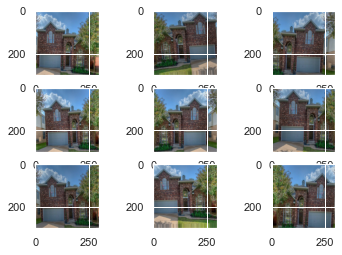

Found 10471 validated image filenames.
Found 1309 validated image filenames.
Found 1309 validated image filenames.


In [190]:
#Setting up the image generators

# Train generator contains data augmentation. In addition to standard normalization by dividing the pixels by 255,
# It also may apply: random rotation, horiz shift, vert shift, brightness change, shear change, zoom in, horiz flip
image_train_generator = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        shear_range=0.1,
        zoom_range=[0.75, 1],
        horizontal_flip=True,
        )
    
# test/val have only the pixel data normalization
image_test_generator = ImageDataGenerator(rescale=1.0 / 255)
    
# visualize an image augmentation sample
visualize_augmentations(image_train_generator, images_train.iloc[1])

# specify where the train generator pulls batches
image_train_generator = image_train_generator.flow_from_dataframe(
        dataframe=images_train,
        x_col="location",  # this is where your image data is stored
        y_col="price",  # this is your target feature
        class_mode="raw",  # use "raw" for regressions
        target_size=(299, 299),
        batch_size=32, # increase or decrease to fit your GPU,
        )

# specify where the val generator pulls batches (we use the test generator because it does the same thing)
image_val_generator = image_test_generator.flow_from_dataframe(
        dataframe=images_val,
        x_col="location",
        y_col="price",
        class_mode="raw",
        target_size=(299, 299),
        batch_size=32,
        )

# specify where the test generator pulls batches
image_test_generator = image_test_generator.flow_from_dataframe(
        dataframe=images_test,
        x_col="location",
        y_col="price",
        class_mode="raw",
        target_size=(299, 299),
        batch_size=32,
        )

##### InceptionV3 base

With the InceptionV3 base, we use the pre-trained Google InceptionV3 model as the basis of our neural network. We remove the top classification layers and add our own linear predictive layer. We train the model with the Inception layers frozen to convergence, and then we unfreeze the Inception model and train with an extremely low learning rate to pick up any additional details. Training/Tuning in index.

In [191]:
# work past image errors
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [192]:
# load the best image model
best_inc_aug_model = keras.models.load_model('best_inception_model.hdf5', compile=False)

In [193]:
# val and test preds from Inception NN
inc_aug_val_preds = best_inc_aug_model.predict(image_val_generator)
inc_aug_test_preds = best_inc_aug_model.predict(image_test_generator)

In [ ]:
# validation scores for Images InceptionV3 only

print("NN InceptionV3 Images Only")
print("MAE: ",int(mean_absolute_error(inc_aug_test_preds, y_exp_val)))
print("RMSE:",int(np.sqrt(mean_squared_error(inc_aug_test_preds, y_exp_val))))
print("R2:", r2_score(inc_aug_test_preds, y_exp_val)*100)

##### Simple CNN base

We also try writing our own convolutional neural network, with standard convolution and pooling layers.

In [194]:
# load our best cnn model
basic_cnn_aug_model = keras.models.load_model('best_basic_cnn_augments_model.hdf5', compile=False)

In [195]:
# val and test preds from cnn
cnn_aug_val_preds = basic_cnn_aug_model.predict(image_val_generator)
cnn_aug_test_preds = basic_cnn_aug_model.predict(image_test_generator)

In [ ]:
# validation scores for Images CNN only

print("NN CNN Images Only")
print("MAE: ",int(mean_absolute_error(cnn_aug_test_preds, y_exp_val)))
print("RMSE:",int(np.sqrt(mean_squared_error(cnn_aug_test_preds, y_exp_val))))
print("R2:", r2_score(cnn_aug_test_preds, y_exp_val)*100)

##### Cleanup

In [ ]:
del image_val_generator
del image_test_generator
del image_train_generator
del best_inc_aug_model
del images_train
del images_rest
del images_val
del images_test

gc.collect()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Wadkins\miniconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Wadkins\AppData\Local\Temp/ipykernel_90052/2938790724.py", line 6, in <module>
    del images_rest
NameError: name 'images_rest' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Wadkins\miniconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Wadkins\miniconda3\envs\gpu\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb

### Without Augmentation

We'll now process images without batch data augmentation, for use both in our multi-input neural network and as extracted features in our standard models. We'll still be using the InceptionV3 model for both of these elements.

In [196]:
outputimages = [] # list to store loaded images

def read_image(location): # load each image as a 299,299 resized
    path = str(location)
    image = cv2.imread(path)
    image = cv2.resize(image, (299, 299)) # this is where you specify the size
    image = preprocess_input(image) # preprocess input for InceptionV3
    return image

df_images['location'].apply(lambda x: outputimages.append(read_image(x)))

# make sure our output is arrays
output = np.array(outputimages)

ERROR! Session/line number was not unique in database. History logging moved to new session 3463


In [197]:
# split train, val and test just as before
images_train, images_rest = train_test_split(output, test_size=0.2, random_state=randomstate)
images_val, images_test = train_test_split(images_rest, test_size=0.5, random_state=randomstate)

### Image Feature Extraction

We extract our features from the InceptionV3 model by loading the model without the top classifier, and then rather than performing any training, we simply use the model directly to predict on our train, val and test sets. The output is an array of image features size (8, 8, 2048)

In [198]:
# define the image extractor
extractor_model = InceptionV3(include_top=False, input_shape=(299, 299, 3), weights='imagenet')

# predict to extract features
image_features_train = extractor_model.predict(images_train)
image_features_val = extractor_model.predict(images_val)
image_features_test = extractor_model.predict(images_test)

In [199]:
del extractor_model
del outputimages

gc.collect()

38221

## Multi-Input NN

Our final neural network is a multi-input which combines neural networks that process all of the tagbular, text, and images at the same time. We still use our transfer learning in this model, by using the GloVe embeddings on our text features, and the InceptionV3 network on our images. After each branch processes its data type, the branches are concatenated and sent to the linear predictive layer. Training/Tuning in appendix as per usual.

In [209]:
# Load the multi model network
multi_model = keras.models.load_model('best_multi_model.hdf5', compile=False)

In [210]:
# val and test predictions on multi model network
multi_preds_val = multi_model.predict([X_val_tabular, tokenized_val, images_val])
multi_preds_test = multi_model.predict([X_test_tabular, tokenized_test, images_test])

In [ ]:
# validation scores for Multi Model NN

print("NN Multi Model Only")
print("MAE: ",int(mean_absolute_error(multi_preds_val, y_exp_val)))
print("RMSE:",int(np.sqrt(mean_squared_error(multi_preds_val, y_exp_val))))
print("R2:", r2_score(multi_preds_val, y_exp_val)*100)

In [202]:
del multi_model

gc.collect()

ERROR! Session/line number was not unique in database. History logging moved to new session 3465


3396

# Ensembling

Now comes the fun part - ensembling together all of our disparate predictions into a meaningful whole. The art of ensembling is to take a suite of weak learners who work together to fill each other's deficiences and provide a cohesive view of the data. Rather than guess which features are useful to the model, we will be running an ensembling function that automatically pulls together the strongest ensemble.

Before we can do that, we need to get a few more predictions from our standard models, using our feature extractions for both text and images.

## Feature Extracted Preds

##### Prepare Tabular

In [203]:
# ensure that our tabular data is in array format and ready to stack

reshaped_tab_train = np.array(X_train_tabular)
reshaped_tab_val = np.array(X_val_tabular)
reshaped_tab_test = np.array(X_test_tabular)
reshaped_tab_train.shape

(10471, 61)

##### Prepare Images

In [204]:
# flatten our images from 8*8*2048 to flat

reshaped_image_train = image_features_train.reshape(image_features_train.shape[0], 8*8*2048)
reshaped_image_val = image_features_val.reshape(image_features_val.shape[0], 8*8*2048)
reshaped_image_test = image_features_test.reshape(image_features_test.shape[0], 8*8*2048)
reshaped_image_train.shape

(10471, 131072)

Our image set is HUGE!

We will perform dimensionality reduction on the images while still retaining reasonable variance.

In [205]:
# Reducing the images into principal components that explain 95% of the variance

pca_95th = PCA(n_components=.95, random_state=randomstate)
pca_image_train = pca_95th.fit_transform(reshaped_image_train)
pca_image_val = pca_95th.transform(reshaped_image_val)
pca_image_test = pca_95th.transform(reshaped_image_test)

print(pca_image_train.shape[1],"components, starting from all features")

6015 components, starting from all features


This is much more manageable!

##### Prepare NLP Features

In [206]:
# ensure that our nlp embeddings are in array format and ready to stack

nlp_embedded_features_train
nlp_embedded_features_val
nlp_embedded_features_test

array([[0.        , 0.05220859, 0.        , ..., 0.20172505, 0.17652756,
        0.        ],
       [0.        , 0.02178882, 0.        , ..., 0.18483347, 0.15324326,
        0.        ],
       [0.        , 0.03386433, 0.        , ..., 0.21349782, 0.14135349,
        0.        ],
       ...,
       [0.        , 0.0313061 , 0.        , ..., 0.2396021 , 0.23498642,
        0.        ],
       [0.        , 0.03528384, 0.        , ..., 0.23816596, 0.24964969,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.18590446, 0.16701978,
        0.        ]], dtype=float32)

##### Tabular + Image Data Predictions

Using our dimensionality-reduced image extracted features, we run our suite of tuned models, fitting on train and then getting validation and test predictions.

In [211]:
# predictions on tabular + incept-images (via basic models)

tab_images_train = np.hstack((reshaped_tab_train, pca_image_train))
tab_images_val = np.hstack((reshaped_tab_val, pca_image_val))
tab_images_test = np.hstack((reshaped_tab_test, pca_image_test))
tab_images_train.shape

(10471, 6076)

In [212]:
tab_images_val_predictions, tab_images_test_predictions = final_predictions(tab_images_train, y_train, tab_images_val, tab_images_test, tuned_models)

Fitting Extra Trees
Predicting with Extra Trees
Fitting Random Forest
Predicting with Random Forest
Fitting XGBR
Predicting with XGBR
Fitting NuSVR
Predicting with NuSVR
Fitting Gradient Boost
Predicting with Gradient Boost
Fitting KNN_8
Predicting with KNN_8
Fitting KNN_4
Predicting with KNN_4
Fitting KNN_15
Predicting with KNN_15
Fitting Linear Regression
Predicting with Linear Regression


##### Tabular + Image + NLP Data Predictions

We use our dimensionality reduced image features, our extracted text embeddings, and our tabular data. We run our suite of tuned models, fitting on train and then getting validation and test predictions.

In [213]:
# predictions on tabular + incept-images + nlp (via basic models)

tab_images_nlp_train = np.hstack((reshaped_tab_train, pca_image_train, nlp_embedded_features_train))
tab_images_nlp_val = np.hstack((reshaped_tab_val, pca_image_val, nlp_embedded_features_val))
tab_images_nlp_test = np.hstack((reshaped_tab_test, pca_image_test, nlp_embedded_features_test))
tab_images_nlp_train.shape

(10471, 6204)

In [ ]:
tab_images_nlp_val_predictions, tab_images_nlp_test_predictions = final_predictions(tab_images_nlp_train, y_train, tab_images_nlp_val, tab_images_nlp_test, tuned_models)

Fitting Extra Trees
Predicting with Extra Trees
Fitting Random Forest


##### Tabular + NLP Data Predictions

We use the extracted text embeddings and tabular data. We run our suite of tuned models, fitting on train and then getting validation and test predictions.

In [ ]:
# predictions on tabular + nlp (via basic models)

tab_nlp_train = np.hstack((reshaped_tab_train, nlp_embedded_features_train))
tab_nlp_val = np.hstack((reshaped_tab_val, nlp_embedded_features_val))
tab_nlp_test = np.hstack((reshaped_tab_test, nlp_embedded_features_test))
tab_nlp_train.shape

In [ ]:
tab_nlp_val_predictions, tab_nlp_test_predictions = final_predictions(tab_nlp_train, y_train, tab_nlp_val, tab_nlp_test, tuned_models)

## Model Stacking Selector

Validation sets for model stack:

* tabular_val_preds, tabular_test_preds: predictions on tabular only (via nn)

* nlp_val_preds, nlp_test_preds: predictions on nlp only (via nn)

* inc_aug_val_preds, inc_aug_test_preds: predictions on incept-images only (via transfer learning with image data augmentation)

* cnn_aug_val_preds, cnn_aug_test_preds: predictions on images only (via custom nn with image data augmentation)

* multi_preds_val, multi_preds_test: predictions on tabular + incept-images + nlp (via multi-input nn)

* baseline_val_predictions, baseline_test_predictions: 
    * Contains predictions with normal models on tabular data only:

* tab_images_val_predictions,tab_images_test_predictions: 
    * Contains predictions on tabular + incept-images (via basic models)

* tab_nlp_val_predictions, tab_nlp_test_predictions: 
    * Contains predictions on tabular + nlp (via basic models)
    
* tab_images_nlp_val_predictions, tab_images_nlp_test_predictions: 
    * Contains predictions on tabular + incept-images + nlp (via basic models)   


We're now going to use my stacking selector function to figure out the optimal models to ensemble for this problem. Before I explain further, we set up our dictionary which contains labeleled validation predictions.

In [ ]:
models_dict = {
    "NN Tabular Only Preds" : tabular_val_preds,
    "NN NLP Only Preds": nlp_val_preds,
    "NN TL Image Only Preds": inc_aug_val_preds,
    "NN CNN Image Only Preds": cnn_aug_val_preds,
    "NN Multi Input Preds": multi_preds_val,
    "Extra Trees Tabular": baseline_val_predictions['Extra Trees'],
    "Extra Trees Tab and Image": tab_images_val_predictions['Extra Trees'], 
    "Extra Trees Tab and NLP":tab_nlp_val_predictions['Extra Trees'],
    "Extra Trees Tab, NLP, Image": tab_images_nlp_val_predictions['Extra Trees'],
    "Random Forest Tabular": baseline_val_predictions['Random Forest'],
    "Random Forest Tab and Image": tab_images_val_predictions['Random Forest'],
    "Random Forest Tab and NLP": tab_nlp_val_predictions['Random Forest'],
    "Random Forest Tab, NLP, Image":tab_images_nlp_val_predictions['Random Forest'],
    "XGBR Tabular": baseline_val_predictions['XGBR'],
    "XGBR Tab and Image": tab_images_val_predictions['XGBR'],
    "XGBR Tab and NLP":tab_nlp_val_predictions['XGBR'],
    "XGBR Tab, NLP, Image":tab_images_nlp_val_predictions['XGBR'],
    "Gradient Boost Tabular": baseline_val_predictions['Gradient Boost'],
    "Gradient Boost Tab and Image":tab_images_val_predictions['Gradient Boost'],
    "Gradient Boost Tab and NLP":tab_nlp_val_predictions['Gradient Boost'],
    "Gradient Boost Tab, NLP, Image":tab_images_nlp_val_predictions['Gradient Boost'],
    "KNN_5 Tabular": baseline_val_predictions['KNN_5'],
    "KNN_5 Tab and Image":tab_images_val_predictions['KNN_5'],
    "KNN_5 Tab and NLP":tab_nlp_val_predictions['KNN_5'],
    "KNN_5 Tab, NLP, Image":tab_images_nlp_val_predictions['KNN_5'],
    "KNN_8 Tabular": baseline_val_predictions['KNN_8'],
    "KNN_8 Tab and Image":tab_images_val_predictions['KNN_8'],
    "KNN_8 Tab and NLP":tab_nlp_val_predictions['KNN_8'],
    "KNN_8 Tab, NLP, Image":tab_images_nlp_val_predictions['KNN_8'],
    "KNN_15 Tabular": baseline_val_predictions['KNN_15'],
    "KNN_15 Tab and Image":tab_images_val_predictions['KNN_15'],
    "KNN_15 Tab and NLP":tab_nlp_val_predictions['KNN_15'],
    "KNN_15 Tab, NLP, Image":tab_images_nlp_val_predictions['KNN_15'],
    "NuSVR Tabular": baseline_val_predictions['NuSVR'],
    "NuSVR Tab and Image":tab_images_val_predictions['NuSVR'],
    "NuSVR Tab and NLP":tab_nlp_val_predictions['NuSVR'],
    "NuSVR Tab, NLP, Image":tab_images_nlp_val_predictions['NuSVR'],   
                }

To build our optimal model stack, we fit a model to our features, then make predictions. We then fit a model to our predictions and use THIS model to predict our final outputs.

![Stack map](images/stack_map.png)

When we run the model selector function, we will send it our y_validation actuals and the dictionary from above with all of the y_validation predictions. The function then runs forward selection, using the validation predictions as potential features.

We try each one of our tuned models as the meta model for the stack. For the model that is being tried as the meta model, we first find the highest scoring single prediction set for that model. Then for each other potential prediction set, we iteratively append the potential’s predictions as a new feature and re-score the meta model using that additional feature. If our meta model score improves with the addition of any feature, the single best scoring predictions are permanently appended to the feature set and the improved score becomes the baseline. The function then loops, once more trying the addition of each potential that isn’t already in the stack, until no potential additions improve the score. The function then reports the optimal included predictors for this meta model, and the best score achieved.

We're working only with our validation set and using CV in our model selector. Once we have determined our best stack, then and only then will we apply to our test set.

In [ ]:
# Set up a scoring dictionary to hold the model stack selector results
scores = {}
scores['Model'] = []
scores['MAE'] = []
scores['Included'] = []

# Run the model stack selector for each model in our tuned_models

for model in tuned_models:
    
    label = model
    meta_model = tuned_models[model]

    resulting_models, best_mae = model_selector_val(y_val, meta_model, models_dict, label, verbose=True)
    
    scores['Model'].append(model)
    scores['MAE'].append(best_mae)
    scores['Included'].append(resulting_models)

In [ ]:
# make data frame from our models dictionary
target = pd.DataFrame(scores).reset_index(drop=True)
target.sort_values('mae', ascending=False)

In [256]:
# What models are included in our lowest MAE model?
target.loc[3]['Included']

['Extra Trees Tabular',
 'NN Tabular Only Preds',
 'XGBR Tab and NLP',
 'NN Multi Input Preds',
 'Gradient Boost Tab and Image',
 'XGBR Tabular',
 'Gradient Boost Tab, NLP, Image',
 'KNN Tab, NLP, Image',
 'XGBR Tab and Image',
 'Gradient Boost Tabular',
 'KNN Tab and Image',
 'NuSVR Tab and Image',
 'Extra Trees Tab, NLP, Image',
 'NuSVR Tab, NLP, Image',
 'Extra Trees Tab and Image',
 'Random Forest Tab and Image']

## Final Ensemble and Predictions

In [ ]:
# the validation predictions to include for fitting
included_val_predictions = {
    
}

In [ ]:
# the test predictions to include for predicting
included_test_predictions = {
    
}

In [ ]:

    "NN Tabular Only Preds" : tabular_val_preds,
    "NN NLP Only Preds": nlp_val_preds,
    "NN TL Image Only Preds": inc_aug_val_preds,
    "NN CNN Image Only Preds": cnn_aug_val_preds,
    "NN Multi Input Preds": multi_preds_val,
    "Extra Trees Tabular": baseline_val_predictions['Extra Trees'],
    "Extra Trees Tab and Image": tab_images_val_predictions['Extra Trees'], 
    "Extra Trees Tab and NLP":tab_nlp_val_predictions['Extra Trees'],
    "Extra Trees Tab, NLP, Image": tab_images_nlp_val_predictions['Extra Trees'],
    "Random Forest Tabular": baseline_val_predictions['Random Forest'],
    "Random Forest Tab and Image": tab_images_val_predictions['Random Forest'],
    "Random Forest Tab and NLP": tab_nlp_val_predictions['Random Forest'],
    "Random Forest Tab, NLP, Image":tab_images_nlp_val_predictions['Random Forest'],
    "XGBR Tabular": baseline_val_predictions['XGBR'],
    "XGBR Tab and Image": tab_images_val_predictions['XGBR'],
    "XGBR Tab and NLP":tab_nlp_val_predictions['XGBR'],
    "XGBR Tab, NLP, Image":tab_images_nlp_val_predictions['XGBR'],
    "Gradient Boost Tabular": baseline_val_predictions['Gradient Boost'],
    "Gradient Boost Tab and Image":tab_images_val_predictions['Gradient Boost'],
    "Gradient Boost Tab and NLP":tab_nlp_val_predictions['Gradient Boost'],
    "Gradient Boost Tab, NLP, Image":tab_images_nlp_val_predictions['Gradient Boost'],
    "KNN_5 Tabular": baseline_val_predictions['KNN_5'],
    "KNN_5 Tab and Image":tab_images_val_predictions['KNN_5'],
    "KNN_5 Tab and NLP":tab_nlp_val_predictions['KNN_5'],
    "KNN_5 Tab, NLP, Image":tab_images_nlp_val_predictions['KNN_5'],
    "KNN_8 Tabular": baseline_val_predictions['KNN_8'],
    "KNN_8 Tab and Image":tab_images_val_predictions['KNN_8'],
    "KNN_8 Tab and NLP":tab_nlp_val_predictions['KNN_8'],
    "KNN_8 Tab, NLP, Image":tab_images_nlp_val_predictions['KNN_8'],
    "KNN_15 Tabular": baseline_val_predictions['KNN_15'],
    "KNN_15 Tab and Image":tab_images_val_predictions['KNN_15'],
    "KNN_15 Tab and NLP":tab_nlp_val_predictions['KNN_15'],
    "KNN_15 Tab, NLP, Image":tab_images_nlp_val_predictions['KNN_15'],
    "NuSVR Tabular": baseline_val_predictions['NuSVR'],
    "NuSVR Tab and Image":tab_images_val_predictions['NuSVR'],
    "NuSVR Tab and NLP":tab_nlp_val_predictions['NuSVR'],
    "NuSVR Tab, NLP, Image":tab_images_nlp_val_predictions['NuSVR'],   

In [267]:
# stack included validation predictions into a feature set

val_stack=None
            
for included in included_val_predictions: # For each model included already in the stack,
                
    entry = np.array(included_val_predictions[included]).reshape(-1, 1) # make and reshape an array of the predictions
    if np.all(val_stack==None): val_stack = entry # if current_meta_x is none, set as this entry
    else: val_stack = np.hstack((val_stack, entry)) # if a current_meta_x exists, append the included in an hstack
    print("Adding ",included, val_stack.shape)

Adding  Extra Trees Tabular (1309, 1)
Adding  NN Tabular Only Preds (1309, 2)
Adding  XGBR Tab and NLP (1309, 3)
Adding  NN Multi Input Preds (1309, 4)
Adding  Gradient Boost Tab and Image (1309, 5)
Adding  XGBR Tabular (1309, 6)
Adding  Gradient Boost Tab, NLP, Image (1309, 7)
Adding  KNN Tab, NLP, Image (1309, 8)
Adding  XGBR Tab and Image (1309, 9)
Adding  Gradient Boost Tabular (1309, 10)
Adding  KNN Tab and Image (1309, 11)
Adding  NuSVR Tab and Image (1309, 12)
Adding  Extra Trees Tab, NLP, Image (1309, 13)
Adding  NuSVR Tab, NLP, Image (1309, 14)
Adding  Extra Trees Tab and Image (1309, 15)
Adding  Random Forest Tab and Image (1309, 16)


In [268]:
# stack included test predictions into a feature set

test_stack=None
            
for included in included_test_predictions: # For each model included already in the stack,
                
    entry = np.array(included_test_predictions[included]).reshape(-1, 1) # make and reshape an array of the predictions
    if np.all(test_stack==None): test_stack = entry # if current_meta_x is none, set as this entry
    else: test_stack = np.hstack((test_stack, entry)) # if a current_meta_x exists, append the included in an hstack
    print("Adding ",included, test_stack.shape)

Adding  Extra Trees Tabular (1309, 1)
Adding  NN Tabular Only Preds (1309, 2)
Adding  XGBR Tab and NLP (1309, 3)
Adding  NN Multi Input Preds (1309, 4)
Adding  Gradient Boost Tab and Image (1309, 5)
Adding  XGBR Tabular (1309, 6)
Adding  Gradient Boost Tab, NLP, Image (1309, 7)
Adding  KNN Tab, NLP, Image (1309, 8)
Adding  XGBR Tab and Image (1309, 9)
Adding  Gradient Boost Tabular (1309, 10)
Adding  KNN Tab and Image (1309, 11)
Adding  NuSVR Tab and Image (1309, 12)
Adding  Extra Trees Tab, NLP, Image (1309, 13)
Adding  NuSVR Tab, NLP, Image (1309, 14)
Adding  Extra Trees Tab and Image (1309, 15)
Adding  Random Forest Tab and Image (1309, 16)


In [271]:
# instantiate our meta model

nu_svr = NuSVR(gamma='auto', kernel='rbf')

# fit on validation stack and predict on test stack
nu_svr.fit(val_stack, y_val)
preds = nu_svr.predict(test_stack)

In [274]:
# score our tuned model on the test set, this is our final score

pred_exp = np.exp(preds)
y_actual = np.exp(y_test)

print("Final Ensembled Predictions")
print("MAE: ",int(mean_absolute_error(pred_exp, y_actual)))
print("RMSE:",int(np.sqrt(mean_squared_error(pred_exp, y_actual))))
print("R2:", r2_score(pred_exp, y_actual)*100)

Extra Trees Predictions
MAE:  58452
RMSE: 96166
R2: 74.74193184788851


In [ ]:
break

# Analysis

> Our final model utilizes a wide combination of continuous variables, one-hot-encoded categoricals, extracted image features, and extracted word embeddings to produce an ensembled model with a mean absolute error of 58.45k, and a root mean squared error of 96k. This MAE is a 4.77% improvement over the baseline tabular-only predictions using the best tuned model. The categorical features were processed with a combination of target encoding and one-hot encoding. The text description features were vector embedded using the pre-trained Stanford GloVe 300d word embeddings NLP model. The images were processed using the pre-trained Google InceptionV3 image classification model. The final model was produced using model ensembling which included a mixture of neural networks, standard models, and image/text extracted features from the aforementioned pre-trained GloVe and InceptionV3 models.

##### What are the primary factors influencing housing prices in the Austin metro area?

> Square footage is, unsurprisingly, a key player in house pricing. And as they say, location is everything, and it is the primary influencing factor for a home price in the Austin metro area. Number of bathrooms, school rating, and lot size all contributed a large amount as well.

##### What home elements from the listing descriptions are important to the price?

> To determine features that we should highlight in the listings, we determine features that have some relevance to the home price. So clearly listing the features doesn't make them exist, but if they DO exist, these are features that we should highlight in our listing descriptions.

> **Home features**: sprinkler system, hardwood, laminate, main (master on the main?), tankless water heater, stainless steel appliances, office, built ins, breakfast bar, washer/dryer, garden tub, wine cellar, gourmet kitchen, original, fire pit, marble

> **Location elements**: easy access, conveniently located, restaurant, airport, nature, hiking, bike trail, walkable, lake

> **Exterior words**: country, corner lot, view, south (facings), pool

> **Descriptive elements**: natural light (abundance, ton), open concept, move in ready, community, fresh paint, luxury, brand new, condo

##### Do housing images contribute to predictive power?

> The features that we extracted from the InceptionV3 pre-trained model were considered important to the model. Unfortunately, this process results in low explainability, and we're not sure HOW or WHY they were important to the model. Anecdotally however, we know that pictures are important, so we could use what we learn about other important model features to inform the things that we picture in the listings. For example some home features that were important are a fire pit, or a garden tub - ensure that pictures of the bathroom or outdoors centrally show and highlight this feature. For exterior features like a corner lot or a view, get a quality shot that really emphasizes this orientation. And since we know that location is everything and that words such as hiking, biking, walkable are important, take shots if possible that emphasize green space or nature on or near the property. A picture of a walkable local park or community pool for example wouldn't be out of place, and would help highlight descriptors that were flagged as important.

##### Can we effectively use a regression model based system for realtors to determine a proper list price?
> Our model, while explaining about 80% of the price variance with our features, was nonetheless far from accurate in absolute terms. A mean average error of 58.5k in either direction is a huge variance to a home price - one that is so large that it renders the prediction much less meaningful and useful. Other models need to be explored, better data needs to be sourced, or easy-to-use features that an average realtor is capable of evaluating/acquiring should be added to the model to improve its predictive quality. The model is providing at best a baseline starting point.

##### What are the features missing?
> I believe this data set to be missing some key features that have high influence in other housing sets, foremost among them reasonable metrics of home condition, home quality, and neighborhood quality. We attempted to pick up some of the quality and condition metrics via NLP. While the NLP did contribute to the model, it was insufficient to explain all of these missing metrics.


## Future Work

* Custom generators with Image Data Augmentation - We currently only used image augmentation in the singular NN image model. If I take the time to create and understand custom generators, I could integrate image data augmentation into the multi-input neural network.

* Model Explainability - Image details and information are lacking. We know that images are important, but we don't know how. We could explore other image features methods such as: Getting the dominant colors of an image (looking for green space?), measuring an image's entropy, or pulling satellite imagery of the address via Google and using those images instead or in addition to the MLS images.

* "Snapshot" Ensembling - Creates model snapshots at every local minima which can then be used to add to the ensembling stack. The method involves a cyclical learning rate which has the model "escape" when it reaches a minima and find a new one. Each minima will be looking at the model data in a different way and carry different errors and biases, which is a key strength of model ensembling.

* To take this model to deployment - Instead of using validation set, fit and predict the included predictions types on the entire data set using out-of-fold predictions with a 10-fold, then stack those predictions and fit on those for a final deployment model.



# APPENDIX

## Neural Network Training and Tuning

In [165]:
# prepare s new dictionary to store neural net score results

neural_networks = {}
neural_networks['model'] = []
neural_networks['r2'] = []
neural_networks['mae'] = []
neural_networks['rmse'] = [] 

ERROR! Session/line number was not unique in database. History logging moved to new session 3460


### Tabular Model

In [166]:
# define a list of layer combos to try out
layers_to_try = [
    [1024, 512, 256, 128, 64, 32, 16, 8, 4],
    [512, 256, 128, 64, 32, 16, 8, 4],
    [128, 64, 32, 16, 8, 4], 
    [64, 32, 16, 8, 4], # best
    [1024, 512, 256, 128, 64, 32, 16], #5
    [64, 64, 64], 
    [128, 64], 
    [512, 128, 32, 8], 
    [1024, 512, 256],
    [256, 256, 256], #10
    [128, 128, 128],
    [64, 64, 64], 
    [265, 128, 64], 
    [1024, 1024, 1024],
    [512, 512, 512], #15
    [128, 128, 128, 128],
    [256, 256, 256, 256],
    [100, 100, 100, 100],
    [128, 128, 64, 64, 32, 32],
    [64, 64, 64, 64], #20
    [32, 32, 32, 32, 32],
    [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64],
    [64, 64, 64, 64, 64, 64, 64, 64],
    [32, 32, 32, 32, 32, 32, 32, 32] #24
    ]

In [167]:
model_num = 0

# try all of our layer combos and append to our model scores list
for layer in layers_to_try:
    model_num += 1
    layers_list = layer
    label='Neural Net Baseline '+str(model_num)
    neural_networks = mlp_test(X_train_tabular, y_train, X_val_tabular, y_val, label, neural_networks, mlp_branch(X_train_tabular.shape[1], layers_list, multi=False, dropout=False, norm=False))

Adding initial Dense layers with  1024
Adding Dense layer with  512
Adding Dense layer with  256
Adding Dense layer with  128
Adding Dense layer with  64
Adding Dense layer with  32
Adding Dense layer with  16
Adding Dense layer with  8
Adding last layer with  4
Outputting predictive model - Tabular
Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 61)]              0         
_________________________________________________________________
dense_412 (Dense)            (None, 1024)              63488     
_________________________________________________________________
dense_413 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_414 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_415 (Dense)    

Epoch 15/500
 9856/10471 [===========================>..] - ETA: 0s - loss: 0.1322 - mean_absolute_error: 0.1322 - mean_squared_error: 0.0378
Epoch 00015: val_loss did not improve from 0.13945
10471/10471 [==============================] - 1s 78us/sample - loss: 0.1339 - mean_absolute_error: 0.1337 - mean_squared_error: 0.0383 - val_loss: 0.1779 - val_mean_absolute_error: 0.1779 - val_mean_squared_error: 0.0586
Epoch 16/500
 9792/10471 [===========================>..] - ETA: 0s - loss: 0.1330 - mean_absolute_error: 0.1330 - mean_squared_error: 0.0374
Epoch 00016: val_loss did not improve from 0.13945
10471/10471 [==============================] - 1s 77us/sample - loss: 0.1326 - mean_absolute_error: 0.1325 - mean_squared_error: 0.0370 - val_loss: 0.1645 - val_mean_absolute_error: 0.1646 - val_mean_squared_error: 0.0504
Epoch 17/500
 9856/10471 [===========================>..] - ETA: 0s - loss: 0.1315 - mean_absolute_error: 0.1315 - mean_squared_error: 0.0370
Epoch 00017: val_loss did no

Epoch 35/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1042 - mean_absolute_error: 0.1042 - mean_squared_error: 0.0243
Epoch 00035: val_loss did not improve from 0.13945
10471/10471 [==============================] - 1s 79us/sample - loss: 0.1042 - mean_absolute_error: 0.1043 - mean_squared_error: 0.0242 - val_loss: 0.1761 - val_mean_absolute_error: 0.1762 - val_mean_squared_error: 0.0555
Epoch 36/500
 9920/10471 [===========================>..] - ETA: 0s - loss: 0.1083 - mean_absolute_error: 0.1083 - mean_squared_error: 0.0251
Epoch 00036: val_loss did not improve from 0.13945
10471/10471 [==============================] - 1s 77us/sample - loss: 0.1076 - mean_absolute_error: 0.1076 - mean_squared_error: 0.0247 - val_loss: 0.1831 - val_mean_absolute_error: 0.1832 - val_mean_squared_error: 0.0597
Epoch 37/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1020 - mean_absolute_error: 0.1020 - mean_squared_error: 0.0231
Epoch 00037: val_loss did no

10336/10471 [============================>.] - ETA: 0s - loss: 0.1535 - mean_absolute_error: 0.1535 - mean_squared_error: 0.0458
Epoch 00011: val_loss improved from 0.16202 to 0.15485, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 77us/sample - loss: 0.1537 - mean_absolute_error: 0.1536 - mean_squared_error: 0.0459 - val_loss: 0.1548 - val_mean_absolute_error: 0.1549 - val_mean_squared_error: 0.0494
Epoch 12/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1664 - mean_absolute_error: 0.1664 - mean_squared_error: 0.0524
Epoch 00012: val_loss improved from 0.15485 to 0.14550, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 77us/sample - loss: 0.1661 - mean_absolute_error: 0.1661 - mean_squared_error: 0.0523 - val_loss: 0.1455 - val_mean_absolute_error: 0.1455 - val_mean_squared_error: 0.0453
Epoch 13/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1460 - mean_absolut

Epoch 31/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1181 - mean_absolute_error: 0.1181 - mean_squared_error: 0.0300
Epoch 00031: val_loss did not improve from 0.14550
10471/10471 [==============================] - 1s 74us/sample - loss: 0.1179 - mean_absolute_error: 0.1178 - mean_squared_error: 0.0299 - val_loss: 0.1481 - val_mean_absolute_error: 0.1481 - val_mean_squared_error: 0.0456
Epoch 32/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1192 - mean_absolute_error: 0.1192 - mean_squared_error: 0.0298
Epoch 00032: val_loss did not improve from 0.14550
10471/10471 [==============================] - 1s 74us/sample - loss: 0.1192 - mean_absolute_error: 0.1193 - mean_squared_error: 0.0299 - val_loss: 0.1926 - val_mean_absolute_error: 0.1925 - val_mean_squared_error: 0.0642
Epoch 33/500
 9952/10471 [===========================>..] - ETA: 0s - loss: 0.1134 - mean_absolute_error: 0.1134 - mean_squared_error: 0.0280
Epoch 00033: val_loss improv

Epoch 51/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.0920 - mean_absolute_error: 0.0920 - mean_squared_error: 0.0195
Epoch 00051: val_loss did not improve from 0.14527
10471/10471 [==============================] - 1s 75us/sample - loss: 0.0916 - mean_absolute_error: 0.0916 - mean_squared_error: 0.0192 - val_loss: 0.1488 - val_mean_absolute_error: 0.1488 - val_mean_squared_error: 0.0475
Epoch 52/500
 9888/10471 [===========================>..] - ETA: 0s - loss: 0.0908 - mean_absolute_error: 0.0908 - mean_squared_error: 0.0191
Epoch 00052: val_loss did not improve from 0.14527
10471/10471 [==============================] - 1s 72us/sample - loss: 0.0901 - mean_absolute_error: 0.0901 - mean_squared_error: 0.0187 - val_loss: 0.1464 - val_mean_absolute_error: 0.1463 - val_mean_squared_error: 0.0446
Epoch 53/500
 9920/10471 [===========================>..] - ETA: 0s - loss: 0.0906 - mean_absolute_error: 0.0906 - mean_squared_error: 0.0188
Epoch 00053: val_loss did no

 9888/10471 [===========================>..] - ETA: 0s - loss: 0.1875 - mean_absolute_error: 0.1875 - mean_squared_error: 0.0623
Epoch 00008: val_loss did not improve from 0.17859
10471/10471 [==============================] - 1s 66us/sample - loss: 0.1859 - mean_absolute_error: 0.1857 - mean_squared_error: 0.0612 - val_loss: 0.2017 - val_mean_absolute_error: 0.2018 - val_mean_squared_error: 0.0663
Epoch 9/500
 9856/10471 [===========================>..] - ETA: 0s - loss: 0.1679 - mean_absolute_error: 0.1679 - mean_squared_error: 0.0521
Epoch 00009: val_loss improved from 0.17859 to 0.14976, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 68us/sample - loss: 0.1677 - mean_absolute_error: 0.1677 - mean_squared_error: 0.0522 - val_loss: 0.1498 - val_mean_absolute_error: 0.1497 - val_mean_squared_error: 0.0446
Epoch 10/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1741 - mean_absolute_error: 0.1741 - mean_squared_error: 0.0549

Epoch 28/500
 9824/10471 [===========================>..] - ETA: 0s - loss: 0.1449 - mean_absolute_error: 0.1449 - mean_squared_error: 0.0412
Epoch 00028: val_loss did not improve from 0.13923
10471/10471 [==============================] - 1s 67us/sample - loss: 0.1435 - mean_absolute_error: 0.1434 - mean_squared_error: 0.0404 - val_loss: 0.2348 - val_mean_absolute_error: 0.2349 - val_mean_squared_error: 0.0802
Epoch 29/500
 9632/10471 [==========================>...] - ETA: 0s - loss: 0.1466 - mean_absolute_error: 0.1466 - mean_squared_error: 0.0422
Epoch 00029: val_loss did not improve from 0.13923
10471/10471 [==============================] - 1s 68us/sample - loss: 0.1458 - mean_absolute_error: 0.1456 - mean_squared_error: 0.0417 - val_loss: 0.1456 - val_mean_absolute_error: 0.1456 - val_mean_squared_error: 0.0435
Epoch 30/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1335 - mean_absolute_error: 0.1335 - mean_squared_error: 0.0370
Epoch 00030: val_loss did no

Train on 10471 samples, validate on 1309 samples
Epoch 1/500
 9920/10471 [===========================>..] - ETA: 0s - loss: 1.2087 - mean_absolute_error: 1.2087 - mean_squared_error: 5.3114
Epoch 00001: val_loss improved from inf to 0.43637, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 103us/sample - loss: 1.1633 - mean_absolute_error: 1.1616 - mean_squared_error: 5.0316 - val_loss: 0.4364 - val_mean_absolute_error: 0.4362 - val_mean_squared_error: 0.2951
Epoch 2/500
 9632/10471 [==========================>...] - ETA: 0s - loss: 0.3922 - mean_absolute_error: 0.3922 - mean_squared_error: 0.2608
Epoch 00002: val_loss improved from 0.43637 to 0.26318, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 65us/sample - loss: 0.3810 - mean_absolute_error: 0.3807 - mean_squared_error: 0.2478 - val_loss: 0.2632 - val_mean_absolute_error: 0.2631 - val_mean_squared_error: 0.1112
Epoch 3/500
10400/10471 [===============

Epoch 20/500
 9856/10471 [===========================>..] - ETA: 0s - loss: 0.1712 - mean_absolute_error: 0.1712 - mean_squared_error: 0.0546
Epoch 00020: val_loss did not improve from 0.14270
10471/10471 [==============================] - 1s 61us/sample - loss: 0.1723 - mean_absolute_error: 0.1727 - mean_squared_error: 0.0551 - val_loss: 0.1923 - val_mean_absolute_error: 0.1924 - val_mean_squared_error: 0.0613
Epoch 21/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1586 - mean_absolute_error: 0.1586 - mean_squared_error: 0.0483
Epoch 00021: val_loss did not improve from 0.14270
10471/10471 [==============================] - 1s 63us/sample - loss: 0.1587 - mean_absolute_error: 0.1591 - mean_squared_error: 0.0491 - val_loss: 0.1548 - val_mean_absolute_error: 0.1548 - val_mean_squared_error: 0.0494
Epoch 22/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1684 - mean_absolute_error: 0.1684 - mean_squared_error: 0.0520
Epoch 00022: val_loss did no

Epoch 40/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1374 - mean_absolute_error: 0.1374 - mean_squared_error: 0.0397
Epoch 00040: val_loss did not improve from 0.13803
10471/10471 [==============================] - 1s 65us/sample - loss: 0.1375 - mean_absolute_error: 0.1374 - mean_squared_error: 0.0397 - val_loss: 0.1578 - val_mean_absolute_error: 0.1579 - val_mean_squared_error: 0.0468
Epoch 41/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1387 - mean_absolute_error: 0.1387 - mean_squared_error: 0.0396
Epoch 00041: val_loss did not improve from 0.13803
10471/10471 [==============================] - 1s 64us/sample - loss: 0.1384 - mean_absolute_error: 0.1384 - mean_squared_error: 0.0395 - val_loss: 0.1441 - val_mean_absolute_error: 0.1441 - val_mean_squared_error: 0.0441
Epoch 42/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1380 - mean_absolute_error: 0.1380 - mean_squared_error: 0.0395
Epoch 00042: val_loss did no

Epoch 60/500
 9792/10471 [===========================>..] - ETA: 0s - loss: 0.1248 - mean_absolute_error: 0.1248 - mean_squared_error: 0.0341
Epoch 00060: val_loss did not improve from 0.13707
10471/10471 [==============================] - 1s 62us/sample - loss: 0.1251 - mean_absolute_error: 0.1252 - mean_squared_error: 0.0342 - val_loss: 0.1404 - val_mean_absolute_error: 0.1405 - val_mean_squared_error: 0.0418
Epoch 61/500
 9920/10471 [===========================>..] - ETA: 0s - loss: 0.1287 - mean_absolute_error: 0.1287 - mean_squared_error: 0.0349
Epoch 00061: val_loss did not improve from 0.13707
10471/10471 [==============================] - 1s 61us/sample - loss: 0.1294 - mean_absolute_error: 0.1292 - mean_squared_error: 0.0351 - val_loss: 0.2162 - val_mean_absolute_error: 0.2163 - val_mean_squared_error: 0.0703
Epoch 62/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1273 - mean_absolute_error: 0.1273 - mean_squared_error: 0.0350
Epoch 00062: val_loss did no

Epoch 80/500
 9760/10471 [==========================>...] - ETA: 0s - loss: 0.1272 - mean_absolute_error: 0.1272 - mean_squared_error: 0.0341Restoring model weights from the end of the best epoch.

Epoch 00080: val_loss did not improve from 0.13707
10471/10471 [==============================] - 1s 62us/sample - loss: 0.1282 - mean_absolute_error: 0.1282 - mean_squared_error: 0.0348 - val_loss: 0.1638 - val_mean_absolute_error: 0.1637 - val_mean_squared_error: 0.0530
Epoch 00080: early stopping
MAE:  0.13702798
RMSE: 0.2020836
Adding initial Dense layers with  1024
Adding Dense layer with  512
Adding Dense layer with  256
Adding Dense layer with  128
Adding Dense layer with  64
Adding Dense layer with  32
Adding last layer with  16
Outputting predictive model - Tabular
Model: "model_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 61)]              0         
_____

 9696/10471 [==========================>...] - ETA: 0s - loss: 0.1680 - mean_absolute_error: 0.1680 - mean_squared_error: 0.0510
Epoch 00014: val_loss did not improve from 0.14282
10471/10471 [==============================] - 1s 73us/sample - loss: 0.1685 - mean_absolute_error: 0.1687 - mean_squared_error: 0.0514 - val_loss: 0.1868 - val_mean_absolute_error: 0.1868 - val_mean_squared_error: 0.0574
Epoch 15/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1436 - mean_absolute_error: 0.1436 - mean_squared_error: 0.0412
Epoch 00015: val_loss did not improve from 0.14282
10471/10471 [==============================] - 1s 74us/sample - loss: 0.1433 - mean_absolute_error: 0.1432 - mean_squared_error: 0.0410 - val_loss: 0.1662 - val_mean_absolute_error: 0.1663 - val_mean_squared_error: 0.0500
Epoch 16/500
10016/10471 [===========================>..] - ETA: 0s - loss: 0.1581 - mean_absolute_error: 0.1581 - mean_squared_error: 0.0476
Epoch 00016: val_loss did not improve fro

Epoch 34/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1051 - mean_absolute_error: 0.1051 - mean_squared_error: 0.0236
Epoch 00034: val_loss did not improve from 0.14080
10471/10471 [==============================] - 1s 82us/sample - loss: 0.1052 - mean_absolute_error: 0.1051 - mean_squared_error: 0.0236 - val_loss: 0.1752 - val_mean_absolute_error: 0.1753 - val_mean_squared_error: 0.0556
Epoch 35/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1021 - mean_absolute_error: 0.1021 - mean_squared_error: 0.0228
Epoch 00035: val_loss did not improve from 0.14080
10471/10471 [==============================] - 1s 76us/sample - loss: 0.1022 - mean_absolute_error: 0.1022 - mean_squared_error: 0.0228 - val_loss: 0.1446 - val_mean_absolute_error: 0.1446 - val_mean_squared_error: 0.0445
Epoch 36/500
10016/10471 [===========================>..] - ETA: 0s - loss: 0.1081 - mean_absolute_error: 0.1081 - mean_squared_error: 0.0245
Epoch 00036: val_loss did no

[INFO] training model...
Train on 10471 samples, validate on 1309 samples
Epoch 1/500
 9888/10471 [===========================>..] - ETA: 0s - loss: 1.4795 - mean_absolute_error: 1.4795 - mean_squared_error: 8.5919
Epoch 00001: val_loss improved from inf to 0.56185, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 93us/sample - loss: 1.4348 - mean_absolute_error: 1.4333 - mean_squared_error: 8.1370 - val_loss: 0.5618 - val_mean_absolute_error: 0.5621 - val_mean_squared_error: 0.5569
Epoch 2/500
 9920/10471 [===========================>..] - ETA: 0s - loss: 0.5114 - mean_absolute_error: 0.5114 - mean_squared_error: 0.4581
Epoch 00002: val_loss improved from 0.56185 to 0.29693, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 57us/sample - loss: 0.5020 - mean_absolute_error: 0.5024 - mean_squared_error: 0.4451 - val_loss: 0.2969 - val_mean_absolute_error: 0.2969 - val_mean_squared_error: 0.1776
Epoch 3/500
1004

Epoch 00019: val_loss did not improve from 0.14031
10471/10471 [==============================] - 1s 57us/sample - loss: 0.1459 - mean_absolute_error: 0.1458 - mean_squared_error: 0.0437 - val_loss: 0.2311 - val_mean_absolute_error: 0.2312 - val_mean_squared_error: 0.0795
Epoch 20/500
 9888/10471 [===========================>..] - ETA: 0s - loss: 0.1562 - mean_absolute_error: 0.1562 - mean_squared_error: 0.0478
Epoch 00020: val_loss did not improve from 0.14031
10471/10471 [==============================] - 1s 57us/sample - loss: 0.1560 - mean_absolute_error: 0.1559 - mean_squared_error: 0.0474 - val_loss: 0.1558 - val_mean_absolute_error: 0.1559 - val_mean_squared_error: 0.0487
Epoch 21/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1425 - mean_absolute_error: 0.1425 - mean_squared_error: 0.0421
Epoch 00021: val_loss did not improve from 0.14031
10471/10471 [==============================] - 1s 60us/sample - loss: 0.1421 - mean_absolute_error: 0.1419 - mean_squar

Epoch 39/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1342 - mean_absolute_error: 0.1342 - mean_squared_error: 0.0376
Epoch 00039: val_loss did not improve from 0.13876
10471/10471 [==============================] - 1s 55us/sample - loss: 0.1339 - mean_absolute_error: 0.1339 - mean_squared_error: 0.0374 - val_loss: 0.1813 - val_mean_absolute_error: 0.1812 - val_mean_squared_error: 0.0597
Epoch 40/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1278 - mean_absolute_error: 0.1278 - mean_squared_error: 0.0351
Epoch 00040: val_loss did not improve from 0.13876
10471/10471 [==============================] - 1s 55us/sample - loss: 0.1278 - mean_absolute_error: 0.1277 - mean_squared_error: 0.0350 - val_loss: 0.1568 - val_mean_absolute_error: 0.1567 - val_mean_squared_error: 0.0502
Epoch 41/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1340 - mean_absolute_error: 0.1340 - mean_squared_error: 0.0373
Epoch 00041: val_loss did no

Epoch 59/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1232 - mean_absolute_error: 0.1232 - mean_squared_error: 0.0323
Epoch 00059: val_loss did not improve from 0.13876
10471/10471 [==============================] - 1s 54us/sample - loss: 0.1233 - mean_absolute_error: 0.1233 - mean_squared_error: 0.0323 - val_loss: 0.1819 - val_mean_absolute_error: 0.1820 - val_mean_squared_error: 0.0568
Epoch 60/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1271 - mean_absolute_error: 0.1271 - mean_squared_error: 0.0342
Epoch 00060: val_loss did not improve from 0.13876
10471/10471 [==============================] - 1s 54us/sample - loss: 0.1271 - mean_absolute_error: 0.1272 - mean_squared_error: 0.0342 - val_loss: 0.1456 - val_mean_absolute_error: 0.1456 - val_mean_squared_error: 0.0445
Epoch 61/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1222 - mean_absolute_error: 0.1222 - mean_squared_error: 0.0323
Epoch 00061: val_loss did no

 9632/10471 [==========================>...] - ETA: 0s - loss: 0.1888 - mean_absolute_error: 0.1888 - mean_squared_error: 0.0658
Epoch 00012: val_loss did not improve from 0.17146
10471/10471 [==============================] - 1s 51us/sample - loss: 0.1884 - mean_absolute_error: 0.1884 - mean_squared_error: 0.0654 - val_loss: 0.1947 - val_mean_absolute_error: 0.1946 - val_mean_squared_error: 0.0709
Epoch 13/500
 9440/10471 [==========================>...] - ETA: 0s - loss: 0.1952 - mean_absolute_error: 0.1952 - mean_squared_error: 0.0675
Epoch 00013: val_loss improved from 0.17146 to 0.15349, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 54us/sample - loss: 0.1917 - mean_absolute_error: 0.1917 - mean_squared_error: 0.0656 - val_loss: 0.1535 - val_mean_absolute_error: 0.1534 - val_mean_squared_error: 0.0479
Epoch 14/500
 9568/10471 [==========================>...] - ETA: 0s - loss: 0.1687 - mean_absolute_error: 0.1687 - mean_squared_error: 0.054

Epoch 32/500
 9760/10471 [==========================>...] - ETA: 0s - loss: 0.1498 - mean_absolute_error: 0.1498 - mean_squared_error: 0.0443
Epoch 00032: val_loss did not improve from 0.14533
10471/10471 [==============================] - 1s 51us/sample - loss: 0.1494 - mean_absolute_error: 0.1492 - mean_squared_error: 0.0438 - val_loss: 0.1679 - val_mean_absolute_error: 0.1678 - val_mean_squared_error: 0.0571
Epoch 33/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1380 - mean_absolute_error: 0.1380 - mean_squared_error: 0.0395
Epoch 00033: val_loss improved from 0.14533 to 0.14516, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 51us/sample - loss: 0.1380 - mean_absolute_error: 0.1379 - mean_squared_error: 0.0395 - val_loss: 0.1452 - val_mean_absolute_error: 0.1451 - val_mean_squared_error: 0.0442
Epoch 34/500
 9504/10471 [==========================>...] - ETA: 0s - loss: 0.1417 - mean_absolute_error: 0.1417 - mean_squared

Epoch 52/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1296 - mean_absolute_error: 0.1296 - mean_squared_error: 0.0349
Epoch 00052: val_loss did not improve from 0.14246
10471/10471 [==============================] - 1s 53us/sample - loss: 0.1298 - mean_absolute_error: 0.1299 - mean_squared_error: 0.0351 - val_loss: 0.1791 - val_mean_absolute_error: 0.1791 - val_mean_squared_error: 0.0587
Epoch 53/500
 9600/10471 [==========================>...] - ETA: 0s - loss: 0.1299 - mean_absolute_error: 0.1299 - mean_squared_error: 0.0355
Epoch 00053: val_loss did not improve from 0.14246
10471/10471 [==============================] - 1s 51us/sample - loss: 0.1295 - mean_absolute_error: 0.1294 - mean_squared_error: 0.0353 - val_loss: 0.1590 - val_mean_absolute_error: 0.1590 - val_mean_squared_error: 0.0492
Epoch 54/500
 9824/10471 [===========================>..] - ETA: 0s - loss: 0.1360 - mean_absolute_error: 0.1360 - mean_squared_error: 0.0371
Epoch 00054: val_loss did no

[INFO] training model...
Train on 10471 samples, validate on 1309 samples
Epoch 1/500
 9600/10471 [==========================>...] - ETA: 0s - loss: 1.5724 - mean_absolute_error: 1.5724 - mean_squared_error: 8.3082
Epoch 00001: val_loss improved from inf to 0.72279, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 97us/sample - loss: 1.5090 - mean_absolute_error: 1.5068 - mean_squared_error: 7.6849 - val_loss: 0.7228 - val_mean_absolute_error: 0.7228 - val_mean_squared_error: 0.8413
Epoch 2/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.6206 - mean_absolute_error: 0.6206 - mean_squared_error: 0.6541
Epoch 00002: val_loss improved from 0.72279 to 0.62113, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 63us/sample - loss: 0.6183 - mean_absolute_error: 0.6177 - mean_squared_error: 0.6482 - val_loss: 0.6211 - val_mean_absolute_error: 0.6212 - val_mean_squared_error: 0.6107
Epoch 3/500
1020

Epoch 20/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1334 - mean_absolute_error: 0.1334 - mean_squared_error: 0.0376
Epoch 00020: val_loss did not improve from 0.14282
10471/10471 [==============================] - 1s 59us/sample - loss: 0.1336 - mean_absolute_error: 0.1334 - mean_squared_error: 0.0375 - val_loss: 0.1487 - val_mean_absolute_error: 0.1487 - val_mean_squared_error: 0.0458
Epoch 21/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1336 - mean_absolute_error: 0.1336 - mean_squared_error: 0.0373
Epoch 00021: val_loss did not improve from 0.14282
10471/10471 [==============================] - 1s 59us/sample - loss: 0.1340 - mean_absolute_error: 0.1343 - mean_squared_error: 0.0375 - val_loss: 0.2175 - val_mean_absolute_error: 0.2175 - val_mean_squared_error: 0.0771
Epoch 22/500
 9632/10471 [==========================>...] - ETA: 0s - loss: 0.1408 - mean_absolute_error: 0.1408 - mean_squared_error: 0.0403
Epoch 00022: val_loss did no

Epoch 40/500
 9664/10471 [==========================>...] - ETA: 0s - loss: 0.1154 - mean_absolute_error: 0.1154 - mean_squared_error: 0.0283
Epoch 00040: val_loss did not improve from 0.14058
10471/10471 [==============================] - 1s 57us/sample - loss: 0.1156 - mean_absolute_error: 0.1154 - mean_squared_error: 0.0281 - val_loss: 0.1610 - val_mean_absolute_error: 0.1609 - val_mean_squared_error: 0.0517
Epoch 41/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1164 - mean_absolute_error: 0.1164 - mean_squared_error: 0.0282
Epoch 00041: val_loss did not improve from 0.14058
10471/10471 [==============================] - 1s 58us/sample - loss: 0.1164 - mean_absolute_error: 0.1164 - mean_squared_error: 0.0281 - val_loss: 0.1468 - val_mean_absolute_error: 0.1468 - val_mean_squared_error: 0.0447
Epoch 42/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1054 - mean_absolute_error: 0.1054 - mean_squared_error: 0.0249
Epoch 00042: val_loss did no

Epoch 00004: val_loss improved from 0.58213 to 0.37708, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 61us/sample - loss: 0.6605 - mean_absolute_error: 0.6597 - mean_squared_error: 0.6981 - val_loss: 0.3771 - val_mean_absolute_error: 0.3772 - val_mean_squared_error: 0.2329
Epoch 5/500
 9664/10471 [==========================>...] - ETA: 0s - loss: 0.5498 - mean_absolute_error: 0.5498 - mean_squared_error: 0.4932
Epoch 00005: val_loss did not improve from 0.37708
10471/10471 [==============================] - 1s 57us/sample - loss: 0.5530 - mean_absolute_error: 0.5528 - mean_squared_error: 0.5000 - val_loss: 0.5260 - val_mean_absolute_error: 0.5262 - val_mean_squared_error: 0.3879
Epoch 6/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.3919 - mean_absolute_error: 0.3919 - mean_squared_error: 0.2470
Epoch 00006: val_loss did not improve from 0.37708
10471/10471 [==============================] - 1s 59us/sample - loss: 0.3916 -

Epoch 24/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1255 - mean_absolute_error: 0.1255 - mean_squared_error: 0.0313
Epoch 00024: val_loss did not improve from 0.14429
10471/10471 [==============================] - 1s 60us/sample - loss: 0.1255 - mean_absolute_error: 0.1255 - mean_squared_error: 0.0314 - val_loss: 0.1937 - val_mean_absolute_error: 0.1939 - val_mean_squared_error: 0.0657
Epoch 25/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1239 - mean_absolute_error: 0.1239 - mean_squared_error: 0.0309
Epoch 00025: val_loss did not improve from 0.14429
10471/10471 [==============================] - 1s 60us/sample - loss: 0.1237 - mean_absolute_error: 0.1238 - mean_squared_error: 0.0308 - val_loss: 0.1915 - val_mean_absolute_error: 0.1916 - val_mean_squared_error: 0.0616
Epoch 26/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1251 - mean_absolute_error: 0.1251 - mean_squared_error: 0.0310
Epoch 00026: val_loss did no

10471/10471 [==============================] - 1s 96us/sample - loss: 1.2598 - mean_absolute_error: 1.2577 - mean_squared_error: 5.4690 - val_loss: 0.7400 - val_mean_absolute_error: 0.7400 - val_mean_squared_error: 0.8513
Epoch 2/500
 9760/10471 [==========================>...] - ETA: 0s - loss: 0.6543 - mean_absolute_error: 0.6543 - mean_squared_error: 0.7151
Epoch 00002: val_loss did not improve from 0.74004
10471/10471 [==============================] - 1s 56us/sample - loss: 0.6595 - mean_absolute_error: 0.6594 - mean_squared_error: 0.7236 - val_loss: 1.2141 - val_mean_absolute_error: 1.2146 - val_mean_squared_error: 1.9016
Epoch 3/500
 9600/10471 [==========================>...] - ETA: 0s - loss: 0.6291 - mean_absolute_error: 0.6291 - mean_squared_error: 0.6433
Epoch 00003: val_loss improved from 0.74004 to 0.43075, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 58us/sample - loss: 0.6247 - mean_absolute_error: 0.6248 - mean_squared_error: 

Epoch 21/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1366 - mean_absolute_error: 0.1366 - mean_squared_error: 0.0360
Epoch 00021: val_loss did not improve from 0.14945
10471/10471 [==============================] - 1s 54us/sample - loss: 0.1368 - mean_absolute_error: 0.1369 - mean_squared_error: 0.0361 - val_loss: 0.1804 - val_mean_absolute_error: 0.1804 - val_mean_squared_error: 0.0595
Epoch 22/500
 9760/10471 [==========================>...] - ETA: 0s - loss: 0.1278 - mean_absolute_error: 0.1278 - mean_squared_error: 0.0323
Epoch 00022: val_loss did not improve from 0.14945
10471/10471 [==============================] - 1s 56us/sample - loss: 0.1289 - mean_absolute_error: 0.1289 - mean_squared_error: 0.0330 - val_loss: 0.1554 - val_mean_absolute_error: 0.1554 - val_mean_squared_error: 0.0487
Epoch 23/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1323 - mean_absolute_error: 0.1323 - mean_squared_error: 0.0351
Epoch 00023: val_loss did no

Epoch 41/500
 9888/10471 [===========================>..] - ETA: 0s - loss: 0.1032 - mean_absolute_error: 0.1032 - mean_squared_error: 0.0218Restoring model weights from the end of the best epoch.

Epoch 00041: val_loss did not improve from 0.14945
10471/10471 [==============================] - 1s 55us/sample - loss: 0.1035 - mean_absolute_error: 0.1034 - mean_squared_error: 0.0216 - val_loss: 0.1621 - val_mean_absolute_error: 0.1620 - val_mean_squared_error: 0.0533
Epoch 00041: early stopping
MAE:  0.14940287
RMSE: 0.21833038
Adding initial Dense layers with  128
Adding Dense layer with  128
Adding last layer with  128
Outputting predictive model - Tabular
Model: "model_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 61)]              0         
_________________________________________________________________
dense_472 (Dense)            (None, 128)            

Epoch 16/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1622 - mean_absolute_error: 0.1622 - mean_squared_error: 0.0496
Epoch 00016: val_loss did not improve from 0.15425
10471/10471 [==============================] - 1s 55us/sample - loss: 0.1615 - mean_absolute_error: 0.1614 - mean_squared_error: 0.0493 - val_loss: 0.1543 - val_mean_absolute_error: 0.1543 - val_mean_squared_error: 0.0470
Epoch 17/500
 9856/10471 [===========================>..] - ETA: 0s - loss: 0.1428 - mean_absolute_error: 0.1428 - mean_squared_error: 0.0414
Epoch 00017: val_loss did not improve from 0.15425
10471/10471 [==============================] - 1s 56us/sample - loss: 0.1433 - mean_absolute_error: 0.1432 - mean_squared_error: 0.0415 - val_loss: 0.1581 - val_mean_absolute_error: 0.1581 - val_mean_squared_error: 0.0495
Epoch 18/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1472 - mean_absolute_error: 0.1472 - mean_squared_error: 0.0428
Epoch 00018: val_loss did no

Epoch 36/500
 9920/10471 [===========================>..] - ETA: 0s - loss: 0.1258 - mean_absolute_error: 0.1258 - mean_squared_error: 0.0324
Epoch 00036: val_loss did not improve from 0.14740
10471/10471 [==============================] - 1s 56us/sample - loss: 0.1254 - mean_absolute_error: 0.1254 - mean_squared_error: 0.0325 - val_loss: 0.1625 - val_mean_absolute_error: 0.1624 - val_mean_squared_error: 0.0515
Epoch 37/500
 9632/10471 [==========================>...] - ETA: 0s - loss: 0.1246 - mean_absolute_error: 0.1246 - mean_squared_error: 0.0316
Epoch 00037: val_loss did not improve from 0.14740
10471/10471 [==============================] - 1s 57us/sample - loss: 0.1268 - mean_absolute_error: 0.1267 - mean_squared_error: 0.0325 - val_loss: 0.3021 - val_mean_absolute_error: 0.3021 - val_mean_squared_error: 0.1261
Epoch 38/500
 9600/10471 [==========================>...] - ETA: 0s - loss: 0.1210 - mean_absolute_error: 0.1210 - mean_squared_error: 0.0304
Epoch 00038: val_loss did no

Epoch 56/500
 9952/10471 [===========================>..] - ETA: 0s - loss: 0.1101 - mean_absolute_error: 0.1101 - mean_squared_error: 0.0254
Epoch 00056: val_loss did not improve from 0.14740
10471/10471 [==============================] - 1s 56us/sample - loss: 0.1098 - mean_absolute_error: 0.1097 - mean_squared_error: 0.0254 - val_loss: 0.1703 - val_mean_absolute_error: 0.1703 - val_mean_squared_error: 0.0567
Epoch 57/500
 9856/10471 [===========================>..] - ETA: 0s - loss: 0.1146 - mean_absolute_error: 0.1146 - mean_squared_error: 0.0268
Epoch 00057: val_loss did not improve from 0.14740
10471/10471 [==============================] - 1s 56us/sample - loss: 0.1135 - mean_absolute_error: 0.1134 - mean_squared_error: 0.0265 - val_loss: 0.1730 - val_mean_absolute_error: 0.1730 - val_mean_squared_error: 0.0573
Epoch 58/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1113 - mean_absolute_error: 0.1113 - mean_squared_error: 0.0257
Epoch 00058: val_loss did no

Epoch 13/500
10016/10471 [===========================>..] - ETA: 0s - loss: 0.1598 - mean_absolute_error: 0.1598 - mean_squared_error: 0.0496
Epoch 00013: val_loss improved from 0.17517 to 0.14865, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 58us/sample - loss: 0.1598 - mean_absolute_error: 0.1598 - mean_squared_error: 0.0496 - val_loss: 0.1486 - val_mean_absolute_error: 0.1486 - val_mean_squared_error: 0.0458
Epoch 14/500
 9760/10471 [==========================>...] - ETA: 0s - loss: 0.1608 - mean_absolute_error: 0.1608 - mean_squared_error: 0.0495
Epoch 00014: val_loss did not improve from 0.14865
10471/10471 [==============================] - 1s 57us/sample - loss: 0.1594 - mean_absolute_error: 0.1592 - mean_squared_error: 0.0489 - val_loss: 0.1608 - val_mean_absolute_error: 0.1608 - val_mean_squared_error: 0.0524
Epoch 15/500
 9600/10471 [==========================>...] - ETA: 0s - loss: 0.1596 - mean_absolute_error: 0.1596 - mean_squared

10208/10471 [============================>.] - ETA: 0s - loss: 0.1460 - mean_absolute_error: 0.1460 - mean_squared_error: 0.0435
Epoch 00032: val_loss did not improve from 0.14192
10471/10471 [==============================] - 1s 54us/sample - loss: 0.1458 - mean_absolute_error: 0.1457 - mean_squared_error: 0.0433 - val_loss: 0.1446 - val_mean_absolute_error: 0.1446 - val_mean_squared_error: 0.0439
Epoch 33/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1391 - mean_absolute_error: 0.1391 - mean_squared_error: 0.0403
Epoch 00033: val_loss did not improve from 0.14192
10471/10471 [==============================] - 1s 55us/sample - loss: 0.1384 - mean_absolute_error: 0.1385 - mean_squared_error: 0.0400 - val_loss: 0.1718 - val_mean_absolute_error: 0.1718 - val_mean_squared_error: 0.0532
Epoch 34/500
 9632/10471 [==========================>...] - ETA: 0s - loss: 0.1387 - mean_absolute_error: 0.1387 - mean_squared_error: 0.0398
Epoch 00034: val_loss did not improve fro

Epoch 00001: val_loss improved from inf to 0.47706, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 90us/sample - loss: 1.4398 - mean_absolute_error: 1.4377 - mean_squared_error: 7.2884 - val_loss: 0.4771 - val_mean_absolute_error: 0.4770 - val_mean_squared_error: 0.4592
Epoch 2/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.6897 - mean_absolute_error: 0.6897 - mean_squared_error: 0.8040
Epoch 00002: val_loss improved from 0.47706 to 0.47066, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 56us/sample - loss: 0.6838 - mean_absolute_error: 0.6831 - mean_squared_error: 0.7909 - val_loss: 0.4707 - val_mean_absolute_error: 0.4705 - val_mean_squared_error: 0.4132
Epoch 3/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.5045 - mean_absolute_error: 0.5045 - mean_squared_error: 0.4192
Epoch 00003: val_loss improved from 0.47066 to 0.36471, saving model to best_basic_model.h

10176/10471 [============================>.] - ETA: 0s - loss: 0.1342 - mean_absolute_error: 0.1342 - mean_squared_error: 0.0371
Epoch 00020: val_loss did not improve from 0.15369
10471/10471 [==============================] - 1s 55us/sample - loss: 0.1340 - mean_absolute_error: 0.1340 - mean_squared_error: 0.0369 - val_loss: 0.1563 - val_mean_absolute_error: 0.1563 - val_mean_squared_error: 0.0498
Epoch 21/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1311 - mean_absolute_error: 0.1311 - mean_squared_error: 0.0360
Epoch 00021: val_loss improved from 0.15369 to 0.15027, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 56us/sample - loss: 0.1309 - mean_absolute_error: 0.1308 - mean_squared_error: 0.0357 - val_loss: 0.1503 - val_mean_absolute_error: 0.1503 - val_mean_squared_error: 0.0456
Epoch 22/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1297 - mean_absolute_error: 0.1297 - mean_squared_error: 0.035

Epoch 00039: val_loss did not improve from 0.14783
10471/10471 [==============================] - 1s 56us/sample - loss: 0.1076 - mean_absolute_error: 0.1076 - mean_squared_error: 0.0247 - val_loss: 0.1553 - val_mean_absolute_error: 0.1553 - val_mean_squared_error: 0.0490
Epoch 40/500
 9664/10471 [==========================>...] - ETA: 0s - loss: 0.1051 - mean_absolute_error: 0.1051 - mean_squared_error: 0.0239
Epoch 00040: val_loss did not improve from 0.14783
10471/10471 [==============================] - 1s 57us/sample - loss: 0.1063 - mean_absolute_error: 0.1063 - mean_squared_error: 0.0245 - val_loss: 0.1939 - val_mean_absolute_error: 0.1938 - val_mean_squared_error: 0.0662
Epoch 41/500
 9888/10471 [===========================>..] - ETA: 0s - loss: 0.1134 - mean_absolute_error: 0.1134 - mean_squared_error: 0.0264
Epoch 00041: val_loss did not improve from 0.14783
10471/10471 [==============================] - 1s 56us/sample - loss: 0.1128 - mean_absolute_error: 0.1128 - mean_squar

10471/10471 [==============================] - 1s 76us/sample - loss: 0.4208 - mean_absolute_error: 0.4206 - mean_squared_error: 0.2919 - val_loss: 0.2680 - val_mean_absolute_error: 0.2679 - val_mean_squared_error: 0.1327
Epoch 7/500
 9952/10471 [===========================>..] - ETA: 0s - loss: 0.3725 - mean_absolute_error: 0.3725 - mean_squared_error: 0.2211
Epoch 00007: val_loss did not improve from 0.26795
10471/10471 [==============================] - 1s 71us/sample - loss: 0.3753 - mean_absolute_error: 0.3751 - mean_squared_error: 0.2240 - val_loss: 0.2928 - val_mean_absolute_error: 0.2928 - val_mean_squared_error: 0.1529
Epoch 8/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.3477 - mean_absolute_error: 0.3477 - mean_squared_error: 0.1983
Epoch 00008: val_loss did not improve from 0.26795
10471/10471 [==============================] - 1s 71us/sample - loss: 0.3444 - mean_absolute_error: 0.3441 - mean_squared_error: 0.1946 - val_loss: 0.3335 - val_mean_absolu

Epoch 26/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1096 - mean_absolute_error: 0.1096 - mean_squared_error: 0.0253
Epoch 00026: val_loss did not improve from 0.15331
10471/10471 [==============================] - 1s 71us/sample - loss: 0.1099 - mean_absolute_error: 0.1099 - mean_squared_error: 0.0253 - val_loss: 0.1603 - val_mean_absolute_error: 0.1603 - val_mean_squared_error: 0.0504
Epoch 27/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1100 - mean_absolute_error: 0.1100 - mean_squared_error: 0.0253
Epoch 00027: val_loss did not improve from 0.15331
10471/10471 [==============================] - 1s 71us/sample - loss: 0.1104 - mean_absolute_error: 0.1104 - mean_squared_error: 0.0254 - val_loss: 0.1658 - val_mean_absolute_error: 0.1658 - val_mean_squared_error: 0.0519
Epoch 28/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1053 - mean_absolute_error: 0.1053 - mean_squared_error: 0.0236
Epoch 00028: val_loss did no

Epoch 46/500
 9952/10471 [===========================>..] - ETA: 0s - loss: 0.0742 - mean_absolute_error: 0.0742 - mean_squared_error: 0.0118
Epoch 00046: val_loss did not improve from 0.14656
10471/10471 [==============================] - 1s 66us/sample - loss: 0.0748 - mean_absolute_error: 0.0747 - mean_squared_error: 0.0118 - val_loss: 0.1575 - val_mean_absolute_error: 0.1574 - val_mean_squared_error: 0.0486
Epoch 47/500
10080/10471 [===========================>..] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0104
Epoch 00047: val_loss did not improve from 0.14656
10471/10471 [==============================] - 1s 71us/sample - loss: 0.0686 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0105 - val_loss: 0.1510 - val_mean_absolute_error: 0.1510 - val_mean_squared_error: 0.0462
Epoch 48/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.0683 - mean_squared_error: 0.0103
Epoch 00048: val_loss did no

Train on 10471 samples, validate on 1309 samples
Epoch 1/500
10400/10471 [============================>.] - ETA: 0s - loss: 1.2554 - mean_absolute_error: 1.2554 - mean_squared_error: 4.5502
Epoch 00001: val_loss improved from inf to 1.05397, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 95us/sample - loss: 1.2519 - mean_absolute_error: 1.2514 - mean_squared_error: 4.5176 - val_loss: 1.0540 - val_mean_absolute_error: 1.0541 - val_mean_squared_error: 1.5142
Epoch 2/500
10080/10471 [===========================>..] - ETA: 0s - loss: 0.7038 - mean_absolute_error: 0.7038 - mean_squared_error: 0.7946
Epoch 00002: val_loss improved from 1.05397 to 0.72209, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 57us/sample - loss: 0.6939 - mean_absolute_error: 0.6937 - mean_squared_error: 0.7772 - val_loss: 0.7221 - val_mean_absolute_error: 0.7221 - val_mean_squared_error: 0.7694
Epoch 3/500
10016/10471 [================

Epoch 20/500
 9696/10471 [==========================>...] - ETA: 0s - loss: 0.1275 - mean_absolute_error: 0.1275 - mean_squared_error: 0.0318
Epoch 00020: val_loss did not improve from 0.15566
10471/10471 [==============================] - 1s 52us/sample - loss: 0.1270 - mean_absolute_error: 0.1270 - mean_squared_error: 0.0316 - val_loss: 0.1789 - val_mean_absolute_error: 0.1789 - val_mean_squared_error: 0.0609
Epoch 21/500
 9760/10471 [==========================>...] - ETA: 0s - loss: 0.1302 - mean_absolute_error: 0.1302 - mean_squared_error: 0.0324
Epoch 00021: val_loss improved from 0.15566 to 0.15347, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 53us/sample - loss: 0.1295 - mean_absolute_error: 0.1295 - mean_squared_error: 0.0325 - val_loss: 0.1535 - val_mean_absolute_error: 0.1535 - val_mean_squared_error: 0.0472
Epoch 22/500
 9472/10471 [==========================>...] - ETA: 0s - loss: 0.1206 - mean_absolute_error: 0.1206 - mean_squared

Epoch 40/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.0975 - mean_absolute_error: 0.0975 - mean_squared_error: 0.0177
Epoch 00040: val_loss did not improve from 0.15347
10471/10471 [==============================] - 1s 54us/sample - loss: 0.0973 - mean_absolute_error: 0.0972 - mean_squared_error: 0.0176 - val_loss: 0.1570 - val_mean_absolute_error: 0.1570 - val_mean_squared_error: 0.0494
Epoch 41/500
 9920/10471 [===========================>..] - ETA: 0s - loss: 0.0909 - mean_absolute_error: 0.0909 - mean_squared_error: 0.0158
Epoch 00041: val_loss did not improve from 0.15347
10471/10471 [==============================] - 1s 56us/sample - loss: 0.0927 - mean_absolute_error: 0.0927 - mean_squared_error: 0.0165 - val_loss: 0.1967 - val_mean_absolute_error: 0.1967 - val_mean_squared_error: 0.0664
Epoch 42/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.0899 - mean_absolute_error: 0.0899 - mean_squared_error: 0.0154
Epoch 00042: val_loss did no

Epoch 10/500
10016/10471 [===========================>..] - ETA: 0s - loss: 0.1796 - mean_absolute_error: 0.1796 - mean_squared_error: 0.0579
Epoch 00010: val_loss improved from 0.17259 to 0.15386, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 57us/sample - loss: 0.1788 - mean_absolute_error: 0.1786 - mean_squared_error: 0.0575 - val_loss: 0.1539 - val_mean_absolute_error: 0.1538 - val_mean_squared_error: 0.0469
Epoch 11/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1633 - mean_absolute_error: 0.1633 - mean_squared_error: 0.0494
Epoch 00011: val_loss did not improve from 0.15386
10471/10471 [==============================] - 1s 54us/sample - loss: 0.1640 - mean_absolute_error: 0.1642 - mean_squared_error: 0.0497 - val_loss: 0.3316 - val_mean_absolute_error: 0.3317 - val_mean_squared_error: 0.1415
Epoch 12/500
10080/10471 [===========================>..] - ETA: 0s - loss: 0.1561 - mean_absolute_error: 0.1561 - mean_squared

Epoch 30/500
10016/10471 [===========================>..] - ETA: 0s - loss: 0.1247 - mean_absolute_error: 0.1247 - mean_squared_error: 0.0329
Epoch 00030: val_loss did not improve from 0.14903
10471/10471 [==============================] - 1s 55us/sample - loss: 0.1257 - mean_absolute_error: 0.1256 - mean_squared_error: 0.0331 - val_loss: 0.1517 - val_mean_absolute_error: 0.1517 - val_mean_squared_error: 0.0464
Epoch 31/500
10080/10471 [===========================>..] - ETA: 0s - loss: 0.1217 - mean_absolute_error: 0.1217 - mean_squared_error: 0.0314
Epoch 00031: val_loss did not improve from 0.14903
10471/10471 [==============================] - 1s 55us/sample - loss: 0.1216 - mean_absolute_error: 0.1215 - mean_squared_error: 0.0312 - val_loss: 0.1586 - val_mean_absolute_error: 0.1585 - val_mean_squared_error: 0.0509
Epoch 32/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1286 - mean_absolute_error: 0.1286 - mean_squared_error: 0.0336
Epoch 00032: val_loss did no

 9728/10471 [==========================>...] - ETA: 0s - loss: 0.7371 - mean_absolute_error: 0.7371 - mean_squared_error: 0.9165
Epoch 00002: val_loss improved from 2.17733 to 0.82108, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 58us/sample - loss: 0.7285 - mean_absolute_error: 0.7301 - mean_squared_error: 0.8974 - val_loss: 0.8211 - val_mean_absolute_error: 0.8212 - val_mean_squared_error: 1.0054
Epoch 3/500
 9632/10471 [==========================>...] - ETA: 0s - loss: 0.6081 - mean_absolute_error: 0.6081 - mean_squared_error: 0.6142
Epoch 00003: val_loss improved from 0.82108 to 0.40595, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 59us/sample - loss: 0.6022 - mean_absolute_error: 0.6029 - mean_squared_error: 0.6015 - val_loss: 0.4060 - val_mean_absolute_error: 0.4060 - val_mean_squared_error: 0.2539
Epoch 4/500
 9888/10471 [===========================>..] - ETA: 0s - loss: 0.2804 - mean_absolute_

 9696/10471 [==========================>...] - ETA: 0s - loss: 0.1255 - mean_absolute_error: 0.1255 - mean_squared_error: 0.0324
Epoch 00021: val_loss did not improve from 0.14974
10471/10471 [==============================] - 1s 56us/sample - loss: 0.1255 - mean_absolute_error: 0.1255 - mean_squared_error: 0.0324 - val_loss: 0.1523 - val_mean_absolute_error: 0.1521 - val_mean_squared_error: 0.0483
Epoch 22/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1258 - mean_absolute_error: 0.1258 - mean_squared_error: 0.0323
Epoch 00022: val_loss did not improve from 0.14974
10471/10471 [==============================] - 1s 59us/sample - loss: 0.1255 - mean_absolute_error: 0.1256 - mean_squared_error: 0.0322 - val_loss: 0.1949 - val_mean_absolute_error: 0.1950 - val_mean_squared_error: 0.0634
Epoch 23/500
 9920/10471 [===========================>..] - ETA: 0s - loss: 0.1262 - mean_absolute_error: 0.1262 - mean_squared_error: 0.0318
Epoch 00023: val_loss did not improve fro

Train on 10471 samples, validate on 1309 samples
Epoch 1/500
 9728/10471 [==========================>...] - ETA: 0s - loss: 1.4471 - mean_absolute_error: 1.4471 - mean_squared_error: 8.0179
Epoch 00001: val_loss improved from inf to 0.53108, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 95us/sample - loss: 1.4163 - mean_absolute_error: 1.4164 - mean_squared_error: 7.5439 - val_loss: 0.5311 - val_mean_absolute_error: 0.5311 - val_mean_squared_error: 0.4544
Epoch 2/500
 9824/10471 [===========================>..] - ETA: 0s - loss: 0.5833 - mean_absolute_error: 0.5833 - mean_squared_error: 0.5747
Epoch 00002: val_loss did not improve from 0.53108
10471/10471 [==============================] - 1s 56us/sample - loss: 0.5687 - mean_absolute_error: 0.5678 - mean_squared_error: 0.5503 - val_loss: 0.6699 - val_mean_absolute_error: 0.6702 - val_mean_squared_error: 0.5809
Epoch 3/500
 9632/10471 [==========================>...] - ETA: 0s - loss: 0.4551 - 

Epoch 20/500
 9728/10471 [==========================>...] - ETA: 0s - loss: 0.1421 - mean_absolute_error: 0.1421 - mean_squared_error: 0.0403
Epoch 00020: val_loss did not improve from 0.14428
10471/10471 [==============================] - 1s 56us/sample - loss: 0.1419 - mean_absolute_error: 0.1420 - mean_squared_error: 0.0403 - val_loss: 0.1714 - val_mean_absolute_error: 0.1714 - val_mean_squared_error: 0.0527
Epoch 21/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1490 - mean_absolute_error: 0.1490 - mean_squared_error: 0.0430
Epoch 00021: val_loss did not improve from 0.14428
10471/10471 [==============================] - 1s 55us/sample - loss: 0.1490 - mean_absolute_error: 0.1489 - mean_squared_error: 0.0430 - val_loss: 0.1642 - val_mean_absolute_error: 0.1642 - val_mean_squared_error: 0.0511
Epoch 22/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1391 - mean_absolute_error: 0.1391 - mean_squared_error: 0.0389
Epoch 00022: val_loss did no

Epoch 40/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1278 - mean_absolute_error: 0.1278 - mean_squared_error: 0.0329
Epoch 00040: val_loss did not improve from 0.14428
10471/10471 [==============================] - 1s 55us/sample - loss: 0.1269 - mean_absolute_error: 0.1269 - mean_squared_error: 0.0325 - val_loss: 0.1480 - val_mean_absolute_error: 0.1480 - val_mean_squared_error: 0.0432
Epoch 41/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1223 - mean_absolute_error: 0.1223 - mean_squared_error: 0.0313
Epoch 00041: val_loss did not improve from 0.14428
10471/10471 [==============================] - 1s 54us/sample - loss: 0.1233 - mean_absolute_error: 0.1234 - mean_squared_error: 0.0319 - val_loss: 0.1641 - val_mean_absolute_error: 0.1641 - val_mean_squared_error: 0.0501
Epoch 42/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1239 - mean_absolute_error: 0.1239 - mean_squared_error: 0.0317Restoring model weights from 

Epoch 13/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1675 - mean_absolute_error: 0.1675 - mean_squared_error: 0.0537
Epoch 00013: val_loss did not improve from 0.15487
10471/10471 [==============================] - 1s 64us/sample - loss: 0.1672 - mean_absolute_error: 0.1673 - mean_squared_error: 0.0535 - val_loss: 0.1574 - val_mean_absolute_error: 0.1574 - val_mean_squared_error: 0.0477
Epoch 14/500
 9952/10471 [===========================>..] - ETA: 0s - loss: 0.1588 - mean_absolute_error: 0.1588 - mean_squared_error: 0.0491
Epoch 00014: val_loss did not improve from 0.15487
10471/10471 [==============================] - 1s 60us/sample - loss: 0.1582 - mean_absolute_error: 0.1584 - mean_squared_error: 0.0489 - val_loss: 0.3420 - val_mean_absolute_error: 0.3419 - val_mean_squared_error: 0.1533
Epoch 15/500
 9888/10471 [===========================>..] - ETA: 0s - loss: 0.1752 - mean_absolute_error: 0.1752 - mean_squared_error: 0.0557
Epoch 00015: val_loss improv

10336/10471 [============================>.] - ETA: 0s - loss: 0.1279 - mean_absolute_error: 0.1279 - mean_squared_error: 0.0342
Epoch 00032: val_loss did not improve from 0.14311
10471/10471 [==============================] - 1s 64us/sample - loss: 0.1277 - mean_absolute_error: 0.1277 - mean_squared_error: 0.0341 - val_loss: 0.1553 - val_mean_absolute_error: 0.1553 - val_mean_squared_error: 0.0498
Epoch 33/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1242 - mean_absolute_error: 0.1242 - mean_squared_error: 0.0324
Epoch 00033: val_loss improved from 0.14311 to 0.14243, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 68us/sample - loss: 0.1241 - mean_absolute_error: 0.1240 - mean_squared_error: 0.0322 - val_loss: 0.1424 - val_mean_absolute_error: 0.1424 - val_mean_squared_error: 0.0444
Epoch 34/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1253 - mean_absolute_error: 0.1253 - mean_squared_error: 0.032

Epoch 52/500
10080/10471 [===========================>..] - ETA: 0s - loss: 0.1090 - mean_absolute_error: 0.1090 - mean_squared_error: 0.0250
Epoch 00052: val_loss did not improve from 0.14243
10471/10471 [==============================] - 1s 60us/sample - loss: 0.1091 - mean_absolute_error: 0.1091 - mean_squared_error: 0.0251 - val_loss: 0.1822 - val_mean_absolute_error: 0.1822 - val_mean_squared_error: 0.0614
Epoch 53/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1072 - mean_absolute_error: 0.1072 - mean_squared_error: 0.0246
Epoch 00053: val_loss did not improve from 0.14243
10471/10471 [==============================] - 1s 61us/sample - loss: 0.1084 - mean_absolute_error: 0.1084 - mean_squared_error: 0.0251 - val_loss: 0.1790 - val_mean_absolute_error: 0.1790 - val_mean_squared_error: 0.0614
Epoch 54/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1090 - mean_absolute_error: 0.1090 - mean_squared_error: 0.0250
Epoch 00054: val_loss did no

Epoch 10/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1776 - mean_absolute_error: 0.1776 - mean_squared_error: 0.0574
Epoch 00010: val_loss did not improve from 0.16806
10471/10471 [==============================] - 1s 60us/sample - loss: 0.1775 - mean_absolute_error: 0.1776 - mean_squared_error: 0.0573 - val_loss: 0.1704 - val_mean_absolute_error: 0.1703 - val_mean_squared_error: 0.0563
Epoch 11/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1823 - mean_absolute_error: 0.1823 - mean_squared_error: 0.0607
Epoch 00011: val_loss did not improve from 0.16806
10471/10471 [==============================] - 1s 59us/sample - loss: 0.1824 - mean_absolute_error: 0.1823 - mean_squared_error: 0.0605 - val_loss: 0.2048 - val_mean_absolute_error: 0.2047 - val_mean_squared_error: 0.0722
Epoch 12/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1923 - mean_absolute_error: 0.1923 - mean_squared_error: 0.0665
Epoch 00012: val_loss improv

10208/10471 [============================>.] - ETA: 0s - loss: 0.1485 - mean_absolute_error: 0.1485 - mean_squared_error: 0.0437
Epoch 00029: val_loss did not improve from 0.14221
10471/10471 [==============================] - 1s 59us/sample - loss: 0.1485 - mean_absolute_error: 0.1484 - mean_squared_error: 0.0436 - val_loss: 0.1560 - val_mean_absolute_error: 0.1560 - val_mean_squared_error: 0.0463
Epoch 30/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1473 - mean_absolute_error: 0.1473 - mean_squared_error: 0.0435
Epoch 00030: val_loss did not improve from 0.14221
10471/10471 [==============================] - 1s 64us/sample - loss: 0.1473 - mean_absolute_error: 0.1472 - mean_squared_error: 0.0434 - val_loss: 0.1475 - val_mean_absolute_error: 0.1475 - val_mean_squared_error: 0.0451
Epoch 31/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1337 - mean_absolute_error: 0.1337 - mean_squared_error: 0.0382
Epoch 00031: val_loss did not improve fro

Epoch 49/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1298 - mean_absolute_error: 0.1298 - mean_squared_error: 0.0353
Epoch 00049: val_loss did not improve from 0.14199
10471/10471 [==============================] - 1s 58us/sample - loss: 0.1299 - mean_absolute_error: 0.1297 - mean_squared_error: 0.0353 - val_loss: 0.1724 - val_mean_absolute_error: 0.1724 - val_mean_squared_error: 0.0553
Epoch 50/500
 9696/10471 [==========================>...] - ETA: 0s - loss: 0.1331 - mean_absolute_error: 0.1331 - mean_squared_error: 0.0366
Epoch 00050: val_loss did not improve from 0.14199
10471/10471 [==============================] - 1s 56us/sample - loss: 0.1335 - mean_absolute_error: 0.1337 - mean_squared_error: 0.0370 - val_loss: 0.1752 - val_mean_absolute_error: 0.1752 - val_mean_squared_error: 0.0529
Epoch 51/500
 9568/10471 [==========================>...] - ETA: 0s - loss: 0.1317 - mean_absolute_error: 0.1317 - mean_squared_error: 0.0359
Epoch 00051: val_loss did no

Epoch 5/500
 9952/10471 [===========================>..] - ETA: 0s - loss: 0.2042 - mean_absolute_error: 0.2042 - mean_squared_error: 0.0725
Epoch 00005: val_loss did not improve from 0.22615
10471/10471 [==============================] - 1s 61us/sample - loss: 0.2025 - mean_absolute_error: 0.2024 - mean_squared_error: 0.0717 - val_loss: 0.2314 - val_mean_absolute_error: 0.2315 - val_mean_squared_error: 0.0845
Epoch 6/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.2092 - mean_absolute_error: 0.2092 - mean_squared_error: 0.0758
Epoch 00006: val_loss improved from 0.22615 to 0.20457, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 61us/sample - loss: 0.2082 - mean_absolute_error: 0.2083 - mean_squared_error: 0.0751 - val_loss: 0.2046 - val_mean_absolute_error: 0.2046 - val_mean_squared_error: 0.0690
Epoch 7/500
10016/10471 [===========================>..] - ETA: 0s - loss: 0.1871 - mean_absolute_error: 0.1871 - mean_squared_er

10208/10471 [============================>.] - ETA: 0s - loss: 0.1484 - mean_absolute_error: 0.1484 - mean_squared_error: 0.0435
Epoch 00024: val_loss did not improve from 0.14656
10471/10471 [==============================] - 1s 59us/sample - loss: 0.1481 - mean_absolute_error: 0.1480 - mean_squared_error: 0.0436 - val_loss: 0.1505 - val_mean_absolute_error: 0.1505 - val_mean_squared_error: 0.0479
Epoch 25/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1426 - mean_absolute_error: 0.1426 - mean_squared_error: 0.0422
Epoch 00025: val_loss did not improve from 0.14656
10471/10471 [==============================] - 1s 59us/sample - loss: 0.1431 - mean_absolute_error: 0.1430 - mean_squared_error: 0.0426 - val_loss: 0.1598 - val_mean_absolute_error: 0.1597 - val_mean_squared_error: 0.0504
Epoch 26/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1462 - mean_absolute_error: 0.1462 - mean_squared_error: 0.0434
Epoch 00026: val_loss did not improve fro

Epoch 44/500
 9792/10471 [===========================>..] - ETA: 0s - loss: 0.1379 - mean_absolute_error: 0.1379 - mean_squared_error: 0.0401
Epoch 00044: val_loss did not improve from 0.14167
10471/10471 [==============================] - 1s 61us/sample - loss: 0.1373 - mean_absolute_error: 0.1375 - mean_squared_error: 0.0398 - val_loss: 0.2253 - val_mean_absolute_error: 0.2254 - val_mean_squared_error: 0.0759
Epoch 45/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1379 - mean_absolute_error: 0.1379 - mean_squared_error: 0.0395
Epoch 00045: val_loss improved from 0.14167 to 0.14072, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 62us/sample - loss: 0.1377 - mean_absolute_error: 0.1379 - mean_squared_error: 0.0396 - val_loss: 0.1407 - val_mean_absolute_error: 0.1407 - val_mean_squared_error: 0.0421
Epoch 46/500
 9824/10471 [===========================>..] - ETA: 0s - loss: 0.1384 - mean_absolute_error: 0.1384 - mean_squared

Epoch 64/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1310 - mean_absolute_error: 0.1310 - mean_squared_error: 0.0364
Epoch 00064: val_loss did not improve from 0.14065
10471/10471 [==============================] - 1s 59us/sample - loss: 0.1310 - mean_absolute_error: 0.1309 - mean_squared_error: 0.0363 - val_loss: 0.2307 - val_mean_absolute_error: 0.2308 - val_mean_squared_error: 0.0784
Epoch 65/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1380 - mean_absolute_error: 0.1380 - mean_squared_error: 0.0391
Epoch 00065: val_loss did not improve from 0.14065
10471/10471 [==============================] - 1s 60us/sample - loss: 0.1380 - mean_absolute_error: 0.1379 - mean_squared_error: 0.0390 - val_loss: 0.2106 - val_mean_absolute_error: 0.2107 - val_mean_squared_error: 0.0684
Epoch 66/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1341 - mean_absolute_error: 0.1341 - mean_squared_error: 0.0378
Epoch 00066: val_loss did no

Train on 10471 samples, validate on 1309 samples
Epoch 1/500
10080/10471 [===========================>..] - ETA: 0s - loss: 1.4435 - mean_absolute_error: 1.4435 - mean_squared_error: 7.1692
Epoch 00001: val_loss improved from inf to 1.32966, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 165us/sample - loss: 1.4124 - mean_absolute_error: 1.4120 - mean_squared_error: 6.9085 - val_loss: 1.3297 - val_mean_absolute_error: 1.3295 - val_mean_squared_error: 1.8570
Epoch 2/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.4329 - mean_absolute_error: 0.4329 - mean_squared_error: 0.3401
Epoch 00002: val_loss improved from 1.32966 to 0.37521, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 98us/sample - loss: 0.4329 - mean_absolute_error: 0.4329 - mean_squared_error: 0.3400 - val_loss: 0.3752 - val_mean_absolute_error: 0.3753 - val_mean_squared_error: 0.1905
Epoch 3/500
10144/10471 [===============

Epoch 20/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1529 - mean_absolute_error: 0.1529 - mean_squared_error: 0.0463
Epoch 00020: val_loss improved from 0.15186 to 0.14834, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 101us/sample - loss: 0.1522 - mean_absolute_error: 0.1521 - mean_squared_error: 0.0458 - val_loss: 0.1483 - val_mean_absolute_error: 0.1483 - val_mean_squared_error: 0.0454
Epoch 21/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1462 - mean_absolute_error: 0.1462 - mean_squared_error: 0.0438
Epoch 00021: val_loss improved from 0.14834 to 0.14490, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 99us/sample - loss: 0.1462 - mean_absolute_error: 0.1461 - mean_squared_error: 0.0436 - val_loss: 0.1449 - val_mean_absolute_error: 0.1449 - val_mean_squared_error: 0.0436
Epoch 22/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1535 

Epoch 40/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1323 - mean_absolute_error: 0.1323 - mean_squared_error: 0.0369
Epoch 00040: val_loss did not improve from 0.14490
10471/10471 [==============================] - 1s 101us/sample - loss: 0.1319 - mean_absolute_error: 0.1319 - mean_squared_error: 0.0367 - val_loss: 0.1500 - val_mean_absolute_error: 0.1499 - val_mean_squared_error: 0.0455
Epoch 41/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1315 - mean_absolute_error: 0.1315 - mean_squared_error: 0.0369
Epoch 00041: val_loss did not improve from 0.14490
10471/10471 [==============================] - 1s 96us/sample - loss: 0.1322 - mean_absolute_error: 0.1323 - mean_squared_error: 0.0370 - val_loss: 0.1764 - val_mean_absolute_error: 0.1763 - val_mean_squared_error: 0.0582
Epoch 42/500
 9952/10471 [===========================>..] - ETA: 0s - loss: 0.1284 - mean_absolute_error: 0.1284 - mean_squared_error: 0.0354
Epoch 00042: val_loss did n

10400/10471 [============================>.] - ETA: 0s - loss: 0.1900 - mean_absolute_error: 0.1900 - mean_squared_error: 0.0643
Epoch 00008: val_loss did not improve from 0.16026
10471/10471 [==============================] - 1s 73us/sample - loss: 0.1900 - mean_absolute_error: 0.1902 - mean_squared_error: 0.0644 - val_loss: 0.2844 - val_mean_absolute_error: 0.2843 - val_mean_squared_error: 0.1179
Epoch 9/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1988 - mean_absolute_error: 0.1988 - mean_squared_error: 0.0685
Epoch 00009: val_loss did not improve from 0.16026
10471/10471 [==============================] - 1s 73us/sample - loss: 0.1989 - mean_absolute_error: 0.1985 - mean_squared_error: 0.0683 - val_loss: 0.3015 - val_mean_absolute_error: 0.3016 - val_mean_squared_error: 0.1247
Epoch 10/500
 9728/10471 [==========================>...] - ETA: 0s - loss: 0.1877 - mean_absolute_error: 0.1877 - mean_squared_error: 0.0635
Epoch 00010: val_loss improved from 0.1602

Epoch 28/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1439 - mean_absolute_error: 0.1439 - mean_squared_error: 0.0411
Epoch 00028: val_loss did not improve from 0.14038
10471/10471 [==============================] - 1s 75us/sample - loss: 0.1434 - mean_absolute_error: 0.1432 - mean_squared_error: 0.0408 - val_loss: 0.1448 - val_mean_absolute_error: 0.1447 - val_mean_squared_error: 0.0420
Epoch 29/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1388 - mean_absolute_error: 0.1388 - mean_squared_error: 0.0396
Epoch 00029: val_loss did not improve from 0.14038
10471/10471 [==============================] - 1s 75us/sample - loss: 0.1387 - mean_absolute_error: 0.1387 - mean_squared_error: 0.0396 - val_loss: 0.1418 - val_mean_absolute_error: 0.1417 - val_mean_squared_error: 0.0429
Epoch 30/500
 9824/10471 [===========================>..] - ETA: 0s - loss: 0.1345 - mean_absolute_error: 0.1345 - mean_squared_error: 0.0378
Epoch 00030: val_loss did no

Epoch 48/500
10080/10471 [===========================>..] - ETA: 0s - loss: 0.1235 - mean_absolute_error: 0.1235 - mean_squared_error: 0.0331
Epoch 00048: val_loss did not improve from 0.14038
10471/10471 [==============================] - 1s 70us/sample - loss: 0.1241 - mean_absolute_error: 0.1240 - mean_squared_error: 0.0332 - val_loss: 0.1463 - val_mean_absolute_error: 0.1462 - val_mean_squared_error: 0.0448
Epoch 49/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1238 - mean_absolute_error: 0.1238 - mean_squared_error: 0.0327
Epoch 00049: val_loss did not improve from 0.14038
10471/10471 [==============================] - 1s 70us/sample - loss: 0.1237 - mean_absolute_error: 0.1240 - mean_squared_error: 0.0329 - val_loss: 0.1929 - val_mean_absolute_error: 0.1927 - val_mean_squared_error: 0.0641
Epoch 50/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1241 - mean_absolute_error: 0.1241 - mean_squared_error: 0.0327Restoring model weights from 

10048/10471 [===========================>..] - ETA: 0s - loss: 0.1690 - mean_absolute_error: 0.1690 - mean_squared_error: 0.0540
Epoch 00012: val_loss improved from 0.17853 to 0.17022, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 74us/sample - loss: 0.1684 - mean_absolute_error: 0.1683 - mean_squared_error: 0.0536 - val_loss: 0.1702 - val_mean_absolute_error: 0.1701 - val_mean_squared_error: 0.0568
Epoch 13/500
 9920/10471 [===========================>..] - ETA: 0s - loss: 0.1699 - mean_absolute_error: 0.1699 - mean_squared_error: 0.0538
Epoch 00013: val_loss did not improve from 0.17022
10471/10471 [==============================] - 1s 72us/sample - loss: 0.1695 - mean_absolute_error: 0.1696 - mean_squared_error: 0.0535 - val_loss: 0.1936 - val_mean_absolute_error: 0.1937 - val_mean_squared_error: 0.0631
Epoch 14/500
 9920/10471 [===========================>..] - ETA: 0s - loss: 0.1868 - mean_absolute_error: 0.1868 - mean_squared_error: 0.064

 9856/10471 [===========================>..] - ETA: 0s - loss: 0.1454 - mean_absolute_error: 0.1454 - mean_squared_error: 0.0435
Epoch 00031: val_loss did not improve from 0.14136
10471/10471 [==============================] - 1s 72us/sample - loss: 0.1449 - mean_absolute_error: 0.1449 - mean_squared_error: 0.0431 - val_loss: 0.1580 - val_mean_absolute_error: 0.1579 - val_mean_squared_error: 0.0512
Epoch 32/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1416 - mean_absolute_error: 0.1416 - mean_squared_error: 0.0422
Epoch 00032: val_loss improved from 0.14136 to 0.14002, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 74us/sample - loss: 0.1412 - mean_absolute_error: 0.1411 - mean_squared_error: 0.0417 - val_loss: 0.1400 - val_mean_absolute_error: 0.1400 - val_mean_squared_error: 0.0414
Epoch 33/500
 9760/10471 [==========================>...] - ETA: 0s - loss: 0.1387 - mean_absolute_error: 0.1387 - mean_squared_error: 0.041

Epoch 51/500
 9920/10471 [===========================>..] - ETA: 0s - loss: 0.1391 - mean_absolute_error: 0.1391 - mean_squared_error: 0.0404
Epoch 00051: val_loss did not improve from 0.13792
10471/10471 [==============================] - 1s 72us/sample - loss: 0.1396 - mean_absolute_error: 0.1398 - mean_squared_error: 0.0410 - val_loss: 0.1923 - val_mean_absolute_error: 0.1923 - val_mean_squared_error: 0.0625
Epoch 52/500
 9792/10471 [===========================>..] - ETA: 0s - loss: 0.1383 - mean_absolute_error: 0.1383 - mean_squared_error: 0.0398
Epoch 00052: val_loss did not improve from 0.13792
10471/10471 [==============================] - 1s 73us/sample - loss: 0.1384 - mean_absolute_error: 0.1383 - mean_squared_error: 0.0400 - val_loss: 0.1408 - val_mean_absolute_error: 0.1408 - val_mean_squared_error: 0.0431
Epoch 53/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1404 - mean_absolute_error: 0.1404 - mean_squared_error: 0.0411
Epoch 00053: val_loss did no

Epoch 71/500
 9792/10471 [===========================>..] - ETA: 0s - loss: 0.1292 - mean_absolute_error: 0.1292 - mean_squared_error: 0.0365
Epoch 00071: val_loss did not improve from 0.13792
10471/10471 [==============================] - 1s 72us/sample - loss: 0.1295 - mean_absolute_error: 0.1294 - mean_squared_error: 0.0368 - val_loss: 0.1789 - val_mean_absolute_error: 0.1789 - val_mean_squared_error: 0.0598
Epoch 72/500
 9920/10471 [===========================>..] - ETA: 0s - loss: 0.1281 - mean_absolute_error: 0.1281 - mean_squared_error: 0.0364
Epoch 00072: val_loss did not improve from 0.13792
10471/10471 [==============================] - 1s 71us/sample - loss: 0.1282 - mean_absolute_error: 0.1283 - mean_squared_error: 0.0367 - val_loss: 0.1449 - val_mean_absolute_error: 0.1448 - val_mean_squared_error: 0.0443
Epoch 73/500
 9856/10471 [===========================>..] - ETA: 0s - loss: 0.1321 - mean_absolute_error: 0.1321 - mean_squared_error: 0.0381
Epoch 00073: val_loss did no

In [168]:
# make data frame from our models dictionary
target = pd.DataFrame(neural_networks).reset_index(drop=True)

# sort data frame by mae and reset index
target.sort_values('mae', ascending=True).head(40)

model    r2       mae      rmse
3    Neural Net Baseline 4  None  0.137028  0.202084
23  Neural Net Baseline 24  None  0.137872  0.203800
5    Neural Net Baseline 6  None  0.138789  0.203796
2    Neural Net Baseline 3  None  0.139234  0.203894
0    Neural Net Baseline 1  None  0.139421  0.204523
22  Neural Net Baseline 23  None  0.140351  0.202624
7    Neural Net Baseline 8  None  0.140576  0.207187
20  Neural Net Baseline 21  None  0.140644  0.206346
4    Neural Net Baseline 5  None  0.140769  0.204007
11  Neural Net Baseline 12  None  0.141929  0.208810
19  Neural Net Baseline 20  None  0.141950  0.207592
18  Neural Net Baseline 19  None  0.142392  0.210638
6    Neural Net Baseline 7  None  0.142414  0.208745
17  Neural Net Baseline 18  None  0.144238  0.206390
8    Neural Net Baseline 9  None  0.144276  0.209614
21  Neural Net Baseline 22  None  0.144853  0.208853
1    Neural Net Baseline 2  None  0.145212  0.210517
13  Neural Net Baseline 14  None  0.146517  0.209558
10  Neural Net Baseline 11  None  0.147326  0.212999
12  Neural Net Baseline 13  None  0.147813  0.213890
15  Neural Net Baseline 16  None  0.148983  0.212308
9   Neural Net Baseline 10  None  0.149403  0.218330
16  Neural Net Baseline 17  None  0.149706  0.214967
14  Neural Net Baseline 15  None  0.153532  0.217341

In [169]:
# We're going to try the network now using batch normalization and dropout, 
#so we pick some of our best scorers from the previous step,
# as well as add some new ones
layers_to_try = [
    [64, 32, 16, 8, 4],
    [1024, 512, 256, 128, 64, 32, 16, 8, 4],
    [1024, 512, 256, 128, 64, 32, 16],
    [512, 256, 128, 64, 32, 16, 8, 4],
    [32, 32, 32, 32, 32],
    [32, 32, 32, 32, 32, 32, 32, 32],
    [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32],
    [64, 64, 64, 64, 64],
    [64, 64, 64, 64, 64, 64, 64, 64],
    [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64],
    [128, 128, 128, 128, 128, 128, 128, 128],
    [128, 128, 128, 128, 128],
    [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
    ]

In [170]:
# Try the layers list with batch normalization

model_num = 0

for layer in layers_to_try:
    model_num += 1
    layers_list = layer
    label='Neural Net Baseline '+str(model_num)+'Batchnorm'
    neural_networks = mlp_test(X_train_tabular, y_train, X_val_tabular, y_val, label, neural_networks, mlp_branch(X_train_tabular.shape[1], layers_list, multi=False, dropout=False, norm=True))

Adding initial Dense layers with  64
Adding Dense layer with  32
Adding Dense layer with  16
Adding Dense layer with  8
Adding last layer with  4
Outputting predictive model - Tabular
Model: "model_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        [(None, 61)]              0         
_________________________________________________________________
batch_normalization_109 (Bat (None, 61)                244       
_________________________________________________________________
dense_559 (Dense)            (None, 64)                3968      
_________________________________________________________________
batch_normalization_110 (Bat (None, 64)                256       
_________________________________________________________________
dense_560 (Dense)            (None, 32)                2080      
_________________________________________________________________
batch_

Epoch 15/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.2046 - mean_absolute_error: 0.2046 - mean_squared_error: 0.0722
Epoch 00015: val_loss did not improve from 0.16554
10471/10471 [==============================] - 1s 105us/sample - loss: 0.2051 - mean_absolute_error: 0.2054 - mean_squared_error: 0.0728 - val_loss: 0.2420 - val_mean_absolute_error: 0.2419 - val_mean_squared_error: 0.0953
Epoch 16/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.2102 - mean_absolute_error: 0.2102 - mean_squared_error: 0.0769
Epoch 00016: val_loss did not improve from 0.16554
10471/10471 [==============================] - 1s 114us/sample - loss: 0.2107 - mean_absolute_error: 0.2114 - mean_squared_error: 0.0775 - val_loss: 0.2838 - val_mean_absolute_error: 0.2839 - val_mean_squared_error: 0.1135
Epoch 17/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.2135 - mean_absolute_error: 0.2135 - mean_squared_error: 0.0778
Epoch 00017: val_loss impr

Epoch 35/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1752 - mean_absolute_error: 0.1752 - mean_squared_error: 0.0569
Epoch 00035: val_loss did not improve from 0.15243
10471/10471 [==============================] - 1s 106us/sample - loss: 0.1750 - mean_absolute_error: 0.1754 - mean_squared_error: 0.0570 - val_loss: 0.1955 - val_mean_absolute_error: 0.1955 - val_mean_squared_error: 0.0672
Epoch 36/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1726 - mean_absolute_error: 0.1726 - mean_squared_error: 0.0559
Epoch 00036: val_loss did not improve from 0.15243
10471/10471 [==============================] - 1s 106us/sample - loss: 0.1730 - mean_absolute_error: 0.1731 - mean_squared_error: 0.0563 - val_loss: 0.1615 - val_mean_absolute_error: 0.1614 - val_mean_squared_error: 0.0511
Epoch 37/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1801 - mean_absolute_error: 0.1801 - mean_squared_error: 0.0596
Epoch 00037: val_loss did 

10240/10471 [============================>.] - ETA: 0s - loss: 0.1629 - mean_absolute_error: 0.1629 - mean_squared_error: 0.0510
Epoch 00054: val_loss did not improve from 0.14654
10471/10471 [==============================] - 1s 106us/sample - loss: 0.1626 - mean_absolute_error: 0.1625 - mean_squared_error: 0.0506 - val_loss: 0.1471 - val_mean_absolute_error: 0.1472 - val_mean_squared_error: 0.0434
Epoch 55/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1726 - mean_absolute_error: 0.1726 - mean_squared_error: 0.0560
Epoch 00055: val_loss did not improve from 0.14654
10471/10471 [==============================] - 1s 106us/sample - loss: 0.1733 - mean_absolute_error: 0.1734 - mean_squared_error: 0.0562 - val_loss: 0.1489 - val_mean_absolute_error: 0.1489 - val_mean_squared_error: 0.0462
Epoch 56/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1727 - mean_absolute_error: 0.1727 - mean_squared_error: 0.0559
Epoch 00056: val_loss did not improve f

Epoch 74/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1692 - mean_absolute_error: 0.1692 - mean_squared_error: 0.0539
Epoch 00074: val_loss did not improve from 0.14214
10471/10471 [==============================] - 1s 105us/sample - loss: 0.1690 - mean_absolute_error: 0.1690 - mean_squared_error: 0.0536 - val_loss: 0.2528 - val_mean_absolute_error: 0.2528 - val_mean_squared_error: 0.0879
Epoch 75/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1676 - mean_absolute_error: 0.1676 - mean_squared_error: 0.0531
Epoch 00075: val_loss did not improve from 0.14214
10471/10471 [==============================] - 1s 108us/sample - loss: 0.1683 - mean_absolute_error: 0.1683 - mean_squared_error: 0.0537 - val_loss: 0.1469 - val_mean_absolute_error: 0.1469 - val_mean_squared_error: 0.0428
Epoch 76/500
10016/10471 [===========================>..] - ETA: 0s - loss: 0.1630 - mean_absolute_error: 0.1630 - mean_squared_error: 0.0510
Epoch 00076: val_loss did 

10432/10471 [============================>.] - ETA: 0s - loss: 2.3408 - mean_absolute_error: 2.3408 - mean_squared_error: 23.1522
Epoch 00001: val_loss improved from inf to 0.66221, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 3s 321us/sample - loss: 2.3332 - mean_absolute_error: 2.3282 - mean_squared_error: 23.0116 - val_loss: 0.6622 - val_mean_absolute_error: 0.6620 - val_mean_squared_error: 0.5378
Epoch 2/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.2610 - mean_absolute_error: 0.2610 - mean_squared_error: 0.1148
Epoch 00002: val_loss improved from 0.66221 to 0.20083, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 174us/sample - loss: 0.2602 - mean_absolute_error: 0.2600 - mean_squared_error: 0.1141 - val_loss: 0.2008 - val_mean_absolute_error: 0.2010 - val_mean_squared_error: 0.0736
Epoch 3/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.2446 - mean_absolute_

10464/10471 [============================>.] - ETA: 0s - loss: 0.2043 - mean_absolute_error: 0.2043 - mean_squared_error: 0.0726
Epoch 00020: val_loss did not improve from 0.15478
10471/10471 [==============================] - 2s 165us/sample - loss: 0.2043 - mean_absolute_error: 0.2045 - mean_squared_error: 0.0727 - val_loss: 0.2745 - val_mean_absolute_error: 0.2746 - val_mean_squared_error: 0.1043
Epoch 21/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.2003 - mean_absolute_error: 0.2003 - mean_squared_error: 0.0710
Epoch 00021: val_loss did not improve from 0.15478
10471/10471 [==============================] - 2s 163us/sample - loss: 0.1995 - mean_absolute_error: 0.1994 - mean_squared_error: 0.0703 - val_loss: 0.1735 - val_mean_absolute_error: 0.1736 - val_mean_squared_error: 0.0529
Epoch 22/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.2088 - mean_absolute_error: 0.2088 - mean_squared_error: 0.0754
Epoch 00022: val_loss did not improve f

Epoch 00039: val_loss did not improve from 0.14848
10471/10471 [==============================] - 2s 166us/sample - loss: 0.1702 - mean_absolute_error: 0.1707 - mean_squared_error: 0.0532 - val_loss: 0.2013 - val_mean_absolute_error: 0.2013 - val_mean_squared_error: 0.0680
Epoch 40/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1633 - mean_absolute_error: 0.1633 - mean_squared_error: 0.0500
Epoch 00040: val_loss did not improve from 0.14848
10471/10471 [==============================] - 2s 164us/sample - loss: 0.1633 - mean_absolute_error: 0.1633 - mean_squared_error: 0.0499 - val_loss: 0.2448 - val_mean_absolute_error: 0.2446 - val_mean_squared_error: 0.0929
Epoch 41/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1731 - mean_absolute_error: 0.1731 - mean_squared_error: 0.0537
Epoch 00041: val_loss did not improve from 0.14848
10471/10471 [==============================] - 2s 165us/sample - loss: 0.1737 - mean_absolute_error: 0.1738 - mean_sq

Epoch 00058: early stopping
MAE:  0.14848246
RMSE: 0.21470134
Adding initial Dense layers with  1024
Adding Dense layer with  512
Adding Dense layer with  256
Adding Dense layer with  128
Adding Dense layer with  64
Adding Dense layer with  32
Adding last layer with  16
Outputting predictive model - Tabular
Model: "model_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        [(None, 61)]              0         
_________________________________________________________________
batch_normalization_123 (Bat (None, 61)                244       
_________________________________________________________________
dense_575 (Dense)            (None, 1024)              63488     
_________________________________________________________________
batch_normalization_124 (Bat (None, 1024)              4096      
_________________________________________________________________
dense_576 (De

10464/10471 [============================>.] - ETA: 0s - loss: 0.2242 - mean_absolute_error: 0.2242 - mean_squared_error: 0.0849
Epoch 00013: val_loss did not improve from 0.17783
10471/10471 [==============================] - 1s 139us/sample - loss: 0.2242 - mean_absolute_error: 0.2244 - mean_squared_error: 0.0851 - val_loss: 0.1831 - val_mean_absolute_error: 0.1832 - val_mean_squared_error: 0.0623
Epoch 14/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.2203 - mean_absolute_error: 0.2203 - mean_squared_error: 0.0837
Epoch 00014: val_loss improved from 0.17783 to 0.15635, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 143us/sample - loss: 0.2198 - mean_absolute_error: 0.2198 - mean_squared_error: 0.0835 - val_loss: 0.1564 - val_mean_absolute_error: 0.1564 - val_mean_squared_error: 0.0461
Epoch 15/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.2090 - mean_absolute_error: 0.2090 - mean_squared_error: 0.0

Epoch 00032: val_loss did not improve from 0.14569
10471/10471 [==============================] - 1s 138us/sample - loss: 0.1756 - mean_absolute_error: 0.1756 - mean_squared_error: 0.0553 - val_loss: 0.2116 - val_mean_absolute_error: 0.2118 - val_mean_squared_error: 0.0696
Epoch 33/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1591 - mean_absolute_error: 0.1591 - mean_squared_error: 0.0480
Epoch 00033: val_loss did not improve from 0.14569
10471/10471 [==============================] - 1s 139us/sample - loss: 0.1591 - mean_absolute_error: 0.1589 - mean_squared_error: 0.0480 - val_loss: 0.1762 - val_mean_absolute_error: 0.1763 - val_mean_squared_error: 0.0550
Epoch 34/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1701 - mean_absolute_error: 0.1701 - mean_squared_error: 0.0524
Epoch 00034: val_loss did not improve from 0.14569
10471/10471 [==============================] - 1s 137us/sample - loss: 0.1702 - mean_absolute_error: 0.1701 - mean_sq

10272/10471 [============================>.] - ETA: 0s - loss: 3.1360 - mean_absolute_error: 3.1360 - mean_squared_error: 32.0904
Epoch 00001: val_loss improved from inf to 0.34703, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 3s 292us/sample - loss: 3.0820 - mean_absolute_error: 3.0757 - mean_squared_error: 31.4089 - val_loss: 0.3470 - val_mean_absolute_error: 0.3470 - val_mean_squared_error: 0.2330
Epoch 2/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.2791 - mean_absolute_error: 0.2791 - mean_squared_error: 0.1276
Epoch 00002: val_loss improved from 0.34703 to 0.30006, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 167us/sample - loss: 0.2791 - mean_absolute_error: 0.2795 - mean_squared_error: 0.1281 - val_loss: 0.3001 - val_mean_absolute_error: 0.3001 - val_mean_squared_error: 0.1457
Epoch 3/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.2678 - mean_absolute_

Epoch 20/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1925 - mean_absolute_error: 0.1925 - mean_squared_error: 0.0656
Epoch 00020: val_loss did not improve from 0.14565
10471/10471 [==============================] - 2s 161us/sample - loss: 0.1921 - mean_absolute_error: 0.1923 - mean_squared_error: 0.0654 - val_loss: 0.1981 - val_mean_absolute_error: 0.1980 - val_mean_squared_error: 0.0684
Epoch 21/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1763 - mean_absolute_error: 0.1763 - mean_squared_error: 0.0568
Epoch 00021: val_loss did not improve from 0.14565
10471/10471 [==============================] - 2s 163us/sample - loss: 0.1781 - mean_absolute_error: 0.1783 - mean_squared_error: 0.0579 - val_loss: 0.1990 - val_mean_absolute_error: 0.1990 - val_mean_squared_error: 0.0613
Epoch 22/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1801 - mean_absolute_error: 0.1801 - mean_squared_error: 0.0585
Epoch 00022: val_loss did 

Epoch 40/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1621 - mean_absolute_error: 0.1621 - mean_squared_error: 0.0487
Epoch 00040: val_loss did not improve from 0.14263
10471/10471 [==============================] - 2s 162us/sample - loss: 0.1621 - mean_absolute_error: 0.1623 - mean_squared_error: 0.0487 - val_loss: 0.1874 - val_mean_absolute_error: 0.1874 - val_mean_squared_error: 0.0570
Epoch 41/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1676 - mean_absolute_error: 0.1676 - mean_squared_error: 0.0504
Epoch 00041: val_loss did not improve from 0.14263
10471/10471 [==============================] - 2s 162us/sample - loss: 0.1674 - mean_absolute_error: 0.1675 - mean_squared_error: 0.0504 - val_loss: 0.1537 - val_mean_absolute_error: 0.1536 - val_mean_squared_error: 0.0464
Epoch 42/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1599 - mean_absolute_error: 0.1599 - mean_squared_error: 0.0471
Epoch 00042: val_loss did 

Epoch 3/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.3955 - mean_absolute_error: 0.3955 - mean_squared_error: 0.2489
Epoch 00003: val_loss did not improve from 0.44089
10471/10471 [==============================] - 1s 116us/sample - loss: 0.3963 - mean_absolute_error: 0.3964 - mean_squared_error: 0.2503 - val_loss: 0.5409 - val_mean_absolute_error: 0.5414 - val_mean_squared_error: 0.4272
Epoch 4/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.3373 - mean_absolute_error: 0.3373 - mean_squared_error: 0.1839
Epoch 00004: val_loss improved from 0.44089 to 0.24303, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 121us/sample - loss: 0.3385 - mean_absolute_error: 0.3385 - mean_squared_error: 0.1849 - val_loss: 0.2430 - val_mean_absolute_error: 0.2431 - val_mean_squared_error: 0.0988
Epoch 5/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.3144 - mean_absolute_error: 0.3144 - mean_squared_

10368/10471 [============================>.] - ETA: 0s - loss: 0.1927 - mean_absolute_error: 0.1927 - mean_squared_error: 0.0670
Epoch 00022: val_loss improved from 0.15336 to 0.15329, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 118us/sample - loss: 0.1928 - mean_absolute_error: 0.1930 - mean_squared_error: 0.0672 - val_loss: 0.1533 - val_mean_absolute_error: 0.1534 - val_mean_squared_error: 0.0463
Epoch 23/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1971 - mean_absolute_error: 0.1971 - mean_squared_error: 0.0691
Epoch 00023: val_loss improved from 0.15329 to 0.14623, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 119us/sample - loss: 0.1970 - mean_absolute_error: 0.1972 - mean_squared_error: 0.0691 - val_loss: 0.1462 - val_mean_absolute_error: 0.1462 - val_mean_squared_error: 0.0432
Epoch 24/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1930 - mean_absol

Epoch 42/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1817 - mean_absolute_error: 0.1817 - mean_squared_error: 0.0596
Epoch 00042: val_loss did not improve from 0.14623
10471/10471 [==============================] - 1s 116us/sample - loss: 0.1821 - mean_absolute_error: 0.1820 - mean_squared_error: 0.0600 - val_loss: 0.1622 - val_mean_absolute_error: 0.1622 - val_mean_squared_error: 0.0507
Epoch 43/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1820 - mean_absolute_error: 0.1820 - mean_squared_error: 0.0602
Epoch 00043: val_loss did not improve from 0.14623
10471/10471 [==============================] - 1s 116us/sample - loss: 0.1825 - mean_absolute_error: 0.1827 - mean_squared_error: 0.0605 - val_loss: 0.1580 - val_mean_absolute_error: 0.1579 - val_mean_squared_error: 0.0509
Epoch 44/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1786 - mean_absolute_error: 0.1786 - mean_squared_error: 0.0583
Epoch 00044: val_loss impr

Epoch 62/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1700 - mean_absolute_error: 0.1700 - mean_squared_error: 0.0546
Epoch 00062: val_loss did not improve from 0.14417
10471/10471 [==============================] - 1s 114us/sample - loss: 0.1700 - mean_absolute_error: 0.1700 - mean_squared_error: 0.0545 - val_loss: 0.1573 - val_mean_absolute_error: 0.1572 - val_mean_squared_error: 0.0500
Epoch 63/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1696 - mean_absolute_error: 0.1696 - mean_squared_error: 0.0540
Epoch 00063: val_loss did not improve from 0.14417
10471/10471 [==============================] - 1s 118us/sample - loss: 0.1717 - mean_absolute_error: 0.1719 - mean_squared_error: 0.0551 - val_loss: 0.2714 - val_mean_absolute_error: 0.2712 - val_mean_squared_error: 0.1074
Epoch 64/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1733 - mean_absolute_error: 0.1733 - mean_squared_error: 0.0562
Epoch 00064: val_loss did 

Epoch 82/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1603 - mean_absolute_error: 0.1603 - mean_squared_error: 0.0501
Epoch 00082: val_loss did not improve from 0.13774
10471/10471 [==============================] - 1s 117us/sample - loss: 0.1602 - mean_absolute_error: 0.1605 - mean_squared_error: 0.0502 - val_loss: 0.1488 - val_mean_absolute_error: 0.1488 - val_mean_squared_error: 0.0438
Epoch 83/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1596 - mean_absolute_error: 0.1596 - mean_squared_error: 0.0499
Epoch 00083: val_loss did not improve from 0.13774
10471/10471 [==============================] - 1s 117us/sample - loss: 0.1599 - mean_absolute_error: 0.1601 - mean_squared_error: 0.0502 - val_loss: 0.1743 - val_mean_absolute_error: 0.1744 - val_mean_squared_error: 0.0518
Epoch 84/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1592 - mean_absolute_error: 0.1592 - mean_squared_error: 0.0495
Epoch 00084: val_loss did 

Epoch 102/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1527 - mean_absolute_error: 0.1527 - mean_squared_error: 0.0468
Epoch 00102: val_loss did not improve from 0.13774
10471/10471 [==============================] - 1s 115us/sample - loss: 0.1527 - mean_absolute_error: 0.1529 - mean_squared_error: 0.0468 - val_loss: 0.1406 - val_mean_absolute_error: 0.1406 - val_mean_squared_error: 0.0421
Epoch 103/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1553 - mean_absolute_error: 0.1553 - mean_squared_error: 0.0472
Epoch 00103: val_loss did not improve from 0.13774
10471/10471 [==============================] - 1s 116us/sample - loss: 0.1552 - mean_absolute_error: 0.1552 - mean_squared_error: 0.0472 - val_loss: 0.1414 - val_mean_absolute_error: 0.1414 - val_mean_squared_error: 0.0430
Epoch 104/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1524 - mean_absolute_error: 0.1524 - mean_squared_error: 0.0463Restoring model weights 

Epoch 00009: val_loss improved from 0.24100 to 0.19816, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 165us/sample - loss: 0.2634 - mean_absolute_error: 0.2635 - mean_squared_error: 0.1135 - val_loss: 0.1982 - val_mean_absolute_error: 0.1983 - val_mean_squared_error: 0.0700
Epoch 10/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.2447 - mean_absolute_error: 0.2447 - mean_squared_error: 0.1013
Epoch 00010: val_loss improved from 0.19816 to 0.17551, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 163us/sample - loss: 0.2440 - mean_absolute_error: 0.2440 - mean_squared_error: 0.1008 - val_loss: 0.1755 - val_mean_absolute_error: 0.1755 - val_mean_squared_error: 0.0600
Epoch 11/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.2418 - mean_absolute_error: 0.2418 - mean_squared_error: 0.0967
Epoch 00011: val_loss did not improve from 0.17551
10471/10471 [==================

Epoch 29/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1983 - mean_absolute_error: 0.1983 - mean_squared_error: 0.0693
Epoch 00029: val_loss did not improve from 0.15496
10471/10471 [==============================] - 2s 161us/sample - loss: 0.1978 - mean_absolute_error: 0.1977 - mean_squared_error: 0.0689 - val_loss: 0.1643 - val_mean_absolute_error: 0.1643 - val_mean_squared_error: 0.0519
Epoch 30/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1868 - mean_absolute_error: 0.1868 - mean_squared_error: 0.0633
Epoch 00030: val_loss did not improve from 0.15496
10471/10471 [==============================] - 2s 162us/sample - loss: 0.1859 - mean_absolute_error: 0.1861 - mean_squared_error: 0.0627 - val_loss: 0.1922 - val_mean_absolute_error: 0.1922 - val_mean_squared_error: 0.0642
Epoch 31/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1889 - mean_absolute_error: 0.1889 - mean_squared_error: 0.0641
Epoch 00031: val_loss did 

Epoch 49/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1881 - mean_absolute_error: 0.1881 - mean_squared_error: 0.0637
Epoch 00049: val_loss did not improve from 0.14871
10471/10471 [==============================] - 2s 161us/sample - loss: 0.1881 - mean_absolute_error: 0.1882 - mean_squared_error: 0.0637 - val_loss: 0.1538 - val_mean_absolute_error: 0.1538 - val_mean_squared_error: 0.0496
Epoch 50/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1722 - mean_absolute_error: 0.1722 - mean_squared_error: 0.0556
Epoch 00050: val_loss did not improve from 0.14871
10471/10471 [==============================] - 2s 156us/sample - loss: 0.1723 - mean_absolute_error: 0.1723 - mean_squared_error: 0.0558 - val_loss: 0.1580 - val_mean_absolute_error: 0.1580 - val_mean_squared_error: 0.0495
Epoch 51/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1793 - mean_absolute_error: 0.1793 - mean_squared_error: 0.0592
Epoch 00051: val_loss impr

Epoch 69/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1668 - mean_absolute_error: 0.1668 - mean_squared_error: 0.0530
Epoch 00069: val_loss did not improve from 0.14572
10471/10471 [==============================] - 2s 157us/sample - loss: 0.1670 - mean_absolute_error: 0.1675 - mean_squared_error: 0.0534 - val_loss: 0.1530 - val_mean_absolute_error: 0.1530 - val_mean_squared_error: 0.0480
Epoch 70/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1703 - mean_absolute_error: 0.1703 - mean_squared_error: 0.0549
Epoch 00070: val_loss did not improve from 0.14572
10471/10471 [==============================] - 2s 158us/sample - loss: 0.1703 - mean_absolute_error: 0.1703 - mean_squared_error: 0.0549 - val_loss: 0.2247 - val_mean_absolute_error: 0.2248 - val_mean_squared_error: 0.0874
Epoch 71/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1776 - mean_absolute_error: 0.1776 - mean_squared_error: 0.0583
Epoch 00071: val_loss did 

Epoch 89/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1690 - mean_absolute_error: 0.1690 - mean_squared_error: 0.0535
Epoch 00089: val_loss did not improve from 0.14542
10471/10471 [==============================] - 2s 160us/sample - loss: 0.1703 - mean_absolute_error: 0.1708 - mean_squared_error: 0.0547 - val_loss: 0.1910 - val_mean_absolute_error: 0.1910 - val_mean_squared_error: 0.0656
Epoch 90/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1567 - mean_absolute_error: 0.1567 - mean_squared_error: 0.0480
Epoch 00090: val_loss did not improve from 0.14542
10471/10471 [==============================] - 2s 159us/sample - loss: 0.1566 - mean_absolute_error: 0.1565 - mean_squared_error: 0.0479 - val_loss: 0.1626 - val_mean_absolute_error: 0.1626 - val_mean_squared_error: 0.0528
Epoch 91/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1609 - mean_absolute_error: 0.1609 - mean_squared_error: 0.0503
Epoch 00091: val_loss did 

10304/10471 [============================>.] - ETA: 0s - loss: 2.0627 - mean_absolute_error: 2.0627 - mean_squared_error: 16.3162
Epoch 00001: val_loss improved from inf to 0.60752, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 5s 449us/sample - loss: 2.0366 - mean_absolute_error: 2.0337 - mean_squared_error: 16.0251 - val_loss: 0.6075 - val_mean_absolute_error: 0.6085 - val_mean_squared_error: 1.9453
Epoch 2/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.4530 - mean_absolute_error: 0.4530 - mean_squared_error: 0.3370
Epoch 00002: val_loss improved from 0.60752 to 0.46602, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 229us/sample - loss: 0.4523 - mean_absolute_error: 0.4521 - mean_squared_error: 0.3362 - val_loss: 0.4660 - val_mean_absolute_error: 0.4661 - val_mean_squared_error: 0.4625
Epoch 3/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.3781 - mean_absolute_

Epoch 20/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.2113 - mean_absolute_error: 0.2113 - mean_squared_error: 0.0782
Epoch 00020: val_loss did not improve from 0.15764
10471/10471 [==============================] - 2s 216us/sample - loss: 0.2106 - mean_absolute_error: 0.2104 - mean_squared_error: 0.0776 - val_loss: 0.1706 - val_mean_absolute_error: 0.1705 - val_mean_squared_error: 0.0583
Epoch 21/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.2076 - mean_absolute_error: 0.2076 - mean_squared_error: 0.0754
Epoch 00021: val_loss did not improve from 0.15764
10471/10471 [==============================] - 2s 215us/sample - loss: 0.2103 - mean_absolute_error: 0.2102 - mean_squared_error: 0.0773 - val_loss: 0.2922 - val_mean_absolute_error: 0.2923 - val_mean_squared_error: 0.1145
Epoch 22/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.2099 - mean_absolute_error: 0.2099 - mean_squared_error: 0.0769
Epoch 00022: val_loss did 

Epoch 40/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1953 - mean_absolute_error: 0.1953 - mean_squared_error: 0.0670
Epoch 00040: val_loss did not improve from 0.15226
10471/10471 [==============================] - 2s 214us/sample - loss: 0.1952 - mean_absolute_error: 0.1951 - mean_squared_error: 0.0670 - val_loss: 0.2397 - val_mean_absolute_error: 0.2396 - val_mean_squared_error: 0.0925
Epoch 41/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1898 - mean_absolute_error: 0.1898 - mean_squared_error: 0.0652
Epoch 00041: val_loss improved from 0.15226 to 0.14897, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 221us/sample - loss: 0.1895 - mean_absolute_error: 0.1896 - mean_squared_error: 0.0650 - val_loss: 0.1490 - val_mean_absolute_error: 0.1490 - val_mean_squared_error: 0.0449
Epoch 42/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1910 - mean_absolute_error: 0.1910 - mean_squar

Epoch 60/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1831 - mean_absolute_error: 0.1831 - mean_squared_error: 0.0614
Epoch 00060: val_loss did not improve from 0.14897
10471/10471 [==============================] - 2s 213us/sample - loss: 0.1834 - mean_absolute_error: 0.1841 - mean_squared_error: 0.0622 - val_loss: 0.1865 - val_mean_absolute_error: 0.1864 - val_mean_squared_error: 0.0637
Epoch 61/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1769 - mean_absolute_error: 0.1769 - mean_squared_error: 0.0583
Epoch 00061: val_loss did not improve from 0.14897
10471/10471 [==============================] - 2s 215us/sample - loss: 0.1765 - mean_absolute_error: 0.1765 - mean_squared_error: 0.0580 - val_loss: 0.2240 - val_mean_absolute_error: 0.2239 - val_mean_squared_error: 0.0830
Epoch 62/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1799 - mean_absolute_error: 0.1799 - mean_squared_error: 0.0599
Epoch 00062: val_loss did 

Epoch 8/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.2737 - mean_absolute_error: 0.2737 - mean_squared_error: 0.1250
Epoch 00008: val_loss did not improve from 0.24753
10471/10471 [==============================] - 1s 106us/sample - loss: 0.2736 - mean_absolute_error: 0.2744 - mean_squared_error: 0.1257 - val_loss: 0.3231 - val_mean_absolute_error: 0.3229 - val_mean_squared_error: 0.1567
Epoch 9/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.2861 - mean_absolute_error: 0.2861 - mean_squared_error: 0.1339
Epoch 00009: val_loss improved from 0.24753 to 0.20939, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 116us/sample - loss: 0.2857 - mean_absolute_error: 0.2858 - mean_squared_error: 0.1335 - val_loss: 0.2094 - val_mean_absolute_error: 0.2094 - val_mean_squared_error: 0.0776
Epoch 10/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.2726 - mean_absolute_error: 0.2726 - mean_squared

10432/10471 [============================>.] - ETA: 0s - loss: 0.1843 - mean_absolute_error: 0.1843 - mean_squared_error: 0.0617
Epoch 00027: val_loss did not improve from 0.15293
10471/10471 [==============================] - 1s 114us/sample - loss: 0.1846 - mean_absolute_error: 0.1847 - mean_squared_error: 0.0620 - val_loss: 0.1641 - val_mean_absolute_error: 0.1641 - val_mean_squared_error: 0.0544
Epoch 28/500
10080/10471 [===========================>..] - ETA: 0s - loss: 0.1904 - mean_absolute_error: 0.1904 - mean_squared_error: 0.0644
Epoch 00028: val_loss did not improve from 0.15293
10471/10471 [==============================] - 1s 117us/sample - loss: 0.1900 - mean_absolute_error: 0.1902 - mean_squared_error: 0.0644 - val_loss: 0.1755 - val_mean_absolute_error: 0.1755 - val_mean_squared_error: 0.0560
Epoch 29/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1822 - mean_absolute_error: 0.1822 - mean_squared_error: 0.0604
Epoch 00029: val_loss did not improve f

Epoch 47/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1760 - mean_absolute_error: 0.1760 - mean_squared_error: 0.0566
Epoch 00047: val_loss did not improve from 0.14686
10471/10471 [==============================] - 1s 109us/sample - loss: 0.1762 - mean_absolute_error: 0.1762 - mean_squared_error: 0.0568 - val_loss: 0.2069 - val_mean_absolute_error: 0.2067 - val_mean_squared_error: 0.0746
Epoch 48/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1654 - mean_absolute_error: 0.1654 - mean_squared_error: 0.0521
Epoch 00048: val_loss did not improve from 0.14686
10471/10471 [==============================] - 1s 108us/sample - loss: 0.1654 - mean_absolute_error: 0.1653 - mean_squared_error: 0.0520 - val_loss: 0.1587 - val_mean_absolute_error: 0.1586 - val_mean_squared_error: 0.0507
Epoch 49/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1640 - mean_absolute_error: 0.1640 - mean_squared_error: 0.0506
Epoch 00049: val_loss did 

10368/10471 [============================>.] - ETA: 0s - loss: 1.7698 - mean_absolute_error: 1.7698 - mean_squared_error: 10.9245
Epoch 00001: val_loss improved from inf to 0.89490, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 3s 295us/sample - loss: 1.7579 - mean_absolute_error: 1.7559 - mean_squared_error: 10.7981 - val_loss: 0.8949 - val_mean_absolute_error: 0.8951 - val_mean_squared_error: 1.6274
Epoch 2/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.5064 - mean_absolute_error: 0.5064 - mean_squared_error: 0.4095
Epoch 00002: val_loss improved from 0.89490 to 0.69728, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 155us/sample - loss: 0.5064 - mean_absolute_error: 0.5063 - mean_squared_error: 0.4092 - val_loss: 0.6973 - val_mean_absolute_error: 0.6971 - val_mean_squared_error: 0.9628
Epoch 3/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.4206 - mean_absolute_

Epoch 20/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.2023 - mean_absolute_error: 0.2023 - mean_squared_error: 0.0716
Epoch 00020: val_loss did not improve from 0.17481
10471/10471 [==============================] - 2s 145us/sample - loss: 0.2013 - mean_absolute_error: 0.2014 - mean_squared_error: 0.0711 - val_loss: 0.1803 - val_mean_absolute_error: 0.1803 - val_mean_squared_error: 0.0612
Epoch 21/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.2042 - mean_absolute_error: 0.2042 - mean_squared_error: 0.0739
Epoch 00021: val_loss did not improve from 0.17481
10471/10471 [==============================] - 2s 148us/sample - loss: 0.2051 - mean_absolute_error: 0.2049 - mean_squared_error: 0.0742 - val_loss: 0.2114 - val_mean_absolute_error: 0.2114 - val_mean_squared_error: 0.0770
Epoch 22/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1980 - mean_absolute_error: 0.1980 - mean_squared_error: 0.0692
Epoch 00022: val_loss impr

Epoch 40/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1844 - mean_absolute_error: 0.1844 - mean_squared_error: 0.0607
Epoch 00040: val_loss did not improve from 0.14917
10471/10471 [==============================] - 2s 149us/sample - loss: 0.1849 - mean_absolute_error: 0.1852 - mean_squared_error: 0.0615 - val_loss: 0.1982 - val_mean_absolute_error: 0.1983 - val_mean_squared_error: 0.0701
Epoch 41/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1777 - mean_absolute_error: 0.1777 - mean_squared_error: 0.0582
Epoch 00041: val_loss improved from 0.14917 to 0.14631, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 153us/sample - loss: 0.1783 - mean_absolute_error: 0.1786 - mean_squared_error: 0.0588 - val_loss: 0.1463 - val_mean_absolute_error: 0.1463 - val_mean_squared_error: 0.0433
Epoch 42/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1826 - mean_absolute_error: 0.1826 - mean_squar

Epoch 60/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1783 - mean_absolute_error: 0.1783 - mean_squared_error: 0.0586
Epoch 00060: val_loss did not improve from 0.14330
10471/10471 [==============================] - 2s 147us/sample - loss: 0.1781 - mean_absolute_error: 0.1782 - mean_squared_error: 0.0587 - val_loss: 0.1865 - val_mean_absolute_error: 0.1865 - val_mean_squared_error: 0.0564
Epoch 61/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1708 - mean_absolute_error: 0.1708 - mean_squared_error: 0.0544
Epoch 00061: val_loss did not improve from 0.14330
10471/10471 [==============================] - 2s 147us/sample - loss: 0.1709 - mean_absolute_error: 0.1710 - mean_squared_error: 0.0545 - val_loss: 0.1699 - val_mean_absolute_error: 0.1699 - val_mean_squared_error: 0.0522
Epoch 62/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1664 - mean_absolute_error: 0.1664 - mean_squared_error: 0.0527
Epoch 00062: val_loss did 

Epoch 80/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1612 - mean_absolute_error: 0.1612 - mean_squared_error: 0.0501
Epoch 00080: val_loss did not improve from 0.14330
10471/10471 [==============================] - 2s 148us/sample - loss: 0.1615 - mean_absolute_error: 0.1616 - mean_squared_error: 0.0503 - val_loss: 0.1496 - val_mean_absolute_error: 0.1496 - val_mean_squared_error: 0.0460
Epoch 81/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1568 - mean_absolute_error: 0.1568 - mean_squared_error: 0.0477
Epoch 00081: val_loss did not improve from 0.14330
10471/10471 [==============================] - 2s 146us/sample - loss: 0.1569 - mean_absolute_error: 0.1570 - mean_squared_error: 0.0477 - val_loss: 0.1524 - val_mean_absolute_error: 0.1524 - val_mean_squared_error: 0.0443
Epoch 82/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1582 - mean_absolute_error: 0.1582 - mean_squared_error: 0.0491
Epoch 00082: val_loss did 

Epoch 5/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.3879 - mean_absolute_error: 0.3879 - mean_squared_error: 0.2403
Epoch 00005: val_loss improved from 0.47368 to 0.40685, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 210us/sample - loss: 0.3865 - mean_absolute_error: 0.3866 - mean_squared_error: 0.2387 - val_loss: 0.4068 - val_mean_absolute_error: 0.4070 - val_mean_squared_error: 0.2554
Epoch 6/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.3334 - mean_absolute_error: 0.3334 - mean_squared_error: 0.1808
Epoch 00006: val_loss improved from 0.40685 to 0.36768, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 214us/sample - loss: 0.3321 - mean_absolute_error: 0.3325 - mean_squared_error: 0.1802 - val_loss: 0.3677 - val_mean_absolute_error: 0.3677 - val_mean_squared_error: 0.2097
Epoch 7/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.3314 - 

Epoch 24/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.2040 - mean_absolute_error: 0.2040 - mean_squared_error: 0.0729
Epoch 00024: val_loss did not improve from 0.16074
10471/10471 [==============================] - 2s 198us/sample - loss: 0.2044 - mean_absolute_error: 0.2044 - mean_squared_error: 0.0732 - val_loss: 0.2840 - val_mean_absolute_error: 0.2838 - val_mean_squared_error: 0.1194
Epoch 25/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1966 - mean_absolute_error: 0.1966 - mean_squared_error: 0.0688
Epoch 00025: val_loss did not improve from 0.16074
10471/10471 [==============================] - 2s 205us/sample - loss: 0.1961 - mean_absolute_error: 0.1962 - mean_squared_error: 0.0687 - val_loss: 0.1905 - val_mean_absolute_error: 0.1903 - val_mean_squared_error: 0.0647
Epoch 26/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.2091 - mean_absolute_error: 0.2091 - mean_squared_error: 0.0756
Epoch 00026: val_loss impr

10304/10471 [============================>.] - ETA: 0s - loss: 0.1718 - mean_absolute_error: 0.1718 - mean_squared_error: 0.0554
Epoch 00043: val_loss did not improve from 0.14892
10471/10471 [==============================] - 2s 198us/sample - loss: 0.1719 - mean_absolute_error: 0.1720 - mean_squared_error: 0.0555 - val_loss: 0.1626 - val_mean_absolute_error: 0.1626 - val_mean_squared_error: 0.0490
Epoch 44/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1845 - mean_absolute_error: 0.1845 - mean_squared_error: 0.0620
Epoch 00044: val_loss did not improve from 0.14892
10471/10471 [==============================] - 2s 199us/sample - loss: 0.1842 - mean_absolute_error: 0.1841 - mean_squared_error: 0.0617 - val_loss: 0.1716 - val_mean_absolute_error: 0.1715 - val_mean_squared_error: 0.0569
Epoch 45/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1771 - mean_absolute_error: 0.1771 - mean_squared_error: 0.0591
Epoch 00045: val_loss did not improve f

Epoch 63/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1752 - mean_absolute_error: 0.1752 - mean_squared_error: 0.0569
Epoch 00063: val_loss did not improve from 0.14892
10471/10471 [==============================] - 2s 198us/sample - loss: 0.1751 - mean_absolute_error: 0.1754 - mean_squared_error: 0.0573 - val_loss: 0.1768 - val_mean_absolute_error: 0.1768 - val_mean_squared_error: 0.0571
Epoch 64/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1695 - mean_absolute_error: 0.1695 - mean_squared_error: 0.0536
Epoch 00064: val_loss did not improve from 0.14892
10471/10471 [==============================] - 2s 195us/sample - loss: 0.1696 - mean_absolute_error: 0.1698 - mean_squared_error: 0.0536 - val_loss: 0.1951 - val_mean_absolute_error: 0.1951 - val_mean_squared_error: 0.0678
Epoch 65/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1742 - mean_absolute_error: 0.1742 - mean_squared_error: 0.0562
Epoch 00065: val_loss did 

Epoch 83/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1645 - mean_absolute_error: 0.1645 - mean_squared_error: 0.0516
Epoch 00083: val_loss did not improve from 0.14887
10471/10471 [==============================] - 2s 197us/sample - loss: 0.1643 - mean_absolute_error: 0.1646 - mean_squared_error: 0.0517 - val_loss: 0.1630 - val_mean_absolute_error: 0.1630 - val_mean_squared_error: 0.0491
Epoch 84/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1590 - mean_absolute_error: 0.1590 - mean_squared_error: 0.0500
Epoch 00084: val_loss improved from 0.14887 to 0.14259, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 203us/sample - loss: 0.1594 - mean_absolute_error: 0.1597 - mean_squared_error: 0.0504 - val_loss: 0.1426 - val_mean_absolute_error: 0.1426 - val_mean_squared_error: 0.0434
Epoch 85/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1628 - mean_absolute_error: 0.1628 - mean_squar

Epoch 103/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1518 - mean_absolute_error: 0.1518 - mean_squared_error: 0.0458
Epoch 00103: val_loss did not improve from 0.14259
10471/10471 [==============================] - 2s 197us/sample - loss: 0.1517 - mean_absolute_error: 0.1517 - mean_squared_error: 0.0458 - val_loss: 0.1513 - val_mean_absolute_error: 0.1513 - val_mean_squared_error: 0.0464
Epoch 104/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1499 - mean_absolute_error: 0.1499 - mean_squared_error: 0.0449
Epoch 00104: val_loss did not improve from 0.14259
10471/10471 [==============================] - 2s 198us/sample - loss: 0.1501 - mean_absolute_error: 0.1505 - mean_squared_error: 0.0456 - val_loss: 0.1558 - val_mean_absolute_error: 0.1558 - val_mean_squared_error: 0.0455
Epoch 105/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1520 - mean_absolute_error: 0.1520 - mean_squared_error: 0.0459
Epoch 00105: val_loss d

Epoch 6/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.4200 - mean_absolute_error: 0.4200 - mean_squared_error: 0.2822
Epoch 00006: val_loss improved from 0.49157 to 0.41256, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 156us/sample - loss: 0.4196 - mean_absolute_error: 0.4199 - mean_squared_error: 0.2821 - val_loss: 0.4126 - val_mean_absolute_error: 0.4126 - val_mean_squared_error: 0.2850
Epoch 7/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.3631 - mean_absolute_error: 0.3631 - mean_squared_error: 0.2127
Epoch 00007: val_loss did not improve from 0.41256
10471/10471 [==============================] - 2s 150us/sample - loss: 0.3632 - mean_absolute_error: 0.3634 - mean_squared_error: 0.2128 - val_loss: 0.4220 - val_mean_absolute_error: 0.4220 - val_mean_squared_error: 0.3231
Epoch 8/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.3556 - mean_absolute_error: 0.3556 - mean_squared_

10464/10471 [============================>.] - ETA: 0s - loss: 0.1974 - mean_absolute_error: 0.1974 - mean_squared_error: 0.0685
Epoch 00025: val_loss did not improve from 0.19338
10471/10471 [==============================] - 2s 147us/sample - loss: 0.1975 - mean_absolute_error: 0.1980 - mean_squared_error: 0.0688 - val_loss: 0.2218 - val_mean_absolute_error: 0.2217 - val_mean_squared_error: 0.0836
Epoch 26/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1920 - mean_absolute_error: 0.1920 - mean_squared_error: 0.0655
Epoch 00026: val_loss did not improve from 0.19338
10471/10471 [==============================] - 2s 148us/sample - loss: 0.1913 - mean_absolute_error: 0.1915 - mean_squared_error: 0.0651 - val_loss: 0.2570 - val_mean_absolute_error: 0.2571 - val_mean_squared_error: 0.0949
Epoch 27/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1910 - mean_absolute_error: 0.1910 - mean_squared_error: 0.0649
Epoch 00027: val_loss improved from 0.1

10400/10471 [============================>.] - ETA: 0s - loss: 0.1664 - mean_absolute_error: 0.1664 - mean_squared_error: 0.0530
Epoch 00044: val_loss did not improve from 0.15130
10471/10471 [==============================] - 2s 147us/sample - loss: 0.1661 - mean_absolute_error: 0.1660 - mean_squared_error: 0.0529 - val_loss: 0.1526 - val_mean_absolute_error: 0.1526 - val_mean_squared_error: 0.0479
Epoch 45/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1712 - mean_absolute_error: 0.1712 - mean_squared_error: 0.0550
Epoch 00045: val_loss did not improve from 0.15130
10471/10471 [==============================] - 2s 147us/sample - loss: 0.1709 - mean_absolute_error: 0.1707 - mean_squared_error: 0.0547 - val_loss: 0.1556 - val_mean_absolute_error: 0.1556 - val_mean_squared_error: 0.0497
Epoch 46/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1631 - mean_absolute_error: 0.1631 - mean_squared_error: 0.0505
Epoch 00046: val_loss did not improve f

Epoch 64/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1456 - mean_absolute_error: 0.1456 - mean_squared_error: 0.0437
Epoch 00064: val_loss did not improve from 0.14719
10471/10471 [==============================] - 2s 148us/sample - loss: 0.1457 - mean_absolute_error: 0.1457 - mean_squared_error: 0.0438 - val_loss: 0.1534 - val_mean_absolute_error: 0.1534 - val_mean_squared_error: 0.0495
Epoch 65/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1430 - mean_absolute_error: 0.1430 - mean_squared_error: 0.0431
Epoch 00065: val_loss did not improve from 0.14719
10471/10471 [==============================] - 2s 144us/sample - loss: 0.1431 - mean_absolute_error: 0.1431 - mean_squared_error: 0.0432 - val_loss: 0.1630 - val_mean_absolute_error: 0.1630 - val_mean_squared_error: 0.0485
Epoch 66/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1464 - mean_absolute_error: 0.1464 - mean_squared_error: 0.0443
Epoch 00066: val_loss did 

Epoch 84/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1401 - mean_absolute_error: 0.1401 - mean_squared_error: 0.0412
Epoch 00084: val_loss did not improve from 0.14090
10471/10471 [==============================] - 2s 149us/sample - loss: 0.1400 - mean_absolute_error: 0.1401 - mean_squared_error: 0.0410 - val_loss: 0.1496 - val_mean_absolute_error: 0.1495 - val_mean_squared_error: 0.0444
Epoch 85/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1357 - mean_absolute_error: 0.1357 - mean_squared_error: 0.0399
Epoch 00085: val_loss did not improve from 0.14090
10471/10471 [==============================] - 2s 148us/sample - loss: 0.1362 - mean_absolute_error: 0.1363 - mean_squared_error: 0.0401 - val_loss: 0.1465 - val_mean_absolute_error: 0.1465 - val_mean_squared_error: 0.0426
Epoch 86/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1383 - mean_absolute_error: 0.1383 - mean_squared_error: 0.0407
Epoch 00086: val_loss did 

Epoch 104/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1357 - mean_absolute_error: 0.1357 - mean_squared_error: 0.0395
Epoch 00104: val_loss did not improve from 0.14090
10471/10471 [==============================] - 2s 147us/sample - loss: 0.1354 - mean_absolute_error: 0.1356 - mean_squared_error: 0.0394 - val_loss: 0.1451 - val_mean_absolute_error: 0.1450 - val_mean_squared_error: 0.0445
Epoch 105/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1304 - mean_absolute_error: 0.1304 - mean_squared_error: 0.0372
Epoch 00105: val_loss did not improve from 0.14090
10471/10471 [==============================] - 2s 149us/sample - loss: 0.1303 - mean_absolute_error: 0.1306 - mean_squared_error: 0.0374 - val_loss: 0.1558 - val_mean_absolute_error: 0.1558 - val_mean_squared_error: 0.0464
Epoch 106/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1349 - mean_absolute_error: 0.1349 - mean_squared_error: 0.0387Restoring model weights 

10144/10471 [============================>.] - ETA: 0s - loss: 0.3039 - mean_absolute_error: 0.3039 - mean_squared_error: 0.1500
Epoch 00011: val_loss did not improve from 0.27111
10471/10471 [==============================] - 1s 107us/sample - loss: 0.3016 - mean_absolute_error: 0.3019 - mean_squared_error: 0.1486 - val_loss: 0.3917 - val_mean_absolute_error: 0.3918 - val_mean_squared_error: 0.2134
Epoch 12/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.2959 - mean_absolute_error: 0.2959 - mean_squared_error: 0.1419
Epoch 00012: val_loss did not improve from 0.27111
10471/10471 [==============================] - 1s 108us/sample - loss: 0.2957 - mean_absolute_error: 0.2958 - mean_squared_error: 0.1422 - val_loss: 0.3625 - val_mean_absolute_error: 0.3626 - val_mean_squared_error: 0.1905
Epoch 13/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.2820 - mean_absolute_error: 0.2820 - mean_squared_error: 0.1307
Epoch 00013: val_loss did not improve f

10336/10471 [============================>.] - ETA: 0s - loss: 0.1757 - mean_absolute_error: 0.1757 - mean_squared_error: 0.0567
Epoch 00030: val_loss did not improve from 0.16219
10471/10471 [==============================] - 1s 105us/sample - loss: 0.1754 - mean_absolute_error: 0.1756 - mean_squared_error: 0.0567 - val_loss: 0.1721 - val_mean_absolute_error: 0.1722 - val_mean_squared_error: 0.0535
Epoch 31/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1734 - mean_absolute_error: 0.1734 - mean_squared_error: 0.0552
Epoch 00031: val_loss did not improve from 0.16219
10471/10471 [==============================] - 1s 108us/sample - loss: 0.1734 - mean_absolute_error: 0.1735 - mean_squared_error: 0.0553 - val_loss: 0.1857 - val_mean_absolute_error: 0.1857 - val_mean_squared_error: 0.0637
Epoch 32/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1688 - mean_absolute_error: 0.1688 - mean_squared_error: 0.0538
Epoch 00032: val_loss improved from 0.1

10240/10471 [============================>.] - ETA: 0s - loss: 0.1520 - mean_absolute_error: 0.1520 - mean_squared_error: 0.0450
Epoch 00049: val_loss did not improve from 0.14445
10471/10471 [==============================] - 1s 117us/sample - loss: 0.1521 - mean_absolute_error: 0.1522 - mean_squared_error: 0.0451 - val_loss: 0.1559 - val_mean_absolute_error: 0.1558 - val_mean_squared_error: 0.0467
Epoch 50/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1516 - mean_absolute_error: 0.1516 - mean_squared_error: 0.0452
Epoch 00050: val_loss did not improve from 0.14445
10471/10471 [==============================] - 1s 116us/sample - loss: 0.1517 - mean_absolute_error: 0.1517 - mean_squared_error: 0.0453 - val_loss: 0.1661 - val_mean_absolute_error: 0.1660 - val_mean_squared_error: 0.0549
Epoch 51/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1507 - mean_absolute_error: 0.1507 - mean_squared_error: 0.0453
Epoch 00051: val_loss did not improve f

Epoch 69/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1405 - mean_absolute_error: 0.1405 - mean_squared_error: 0.0411
Epoch 00069: val_loss did not improve from 0.14220
10471/10471 [==============================] - 1s 120us/sample - loss: 0.1405 - mean_absolute_error: 0.1406 - mean_squared_error: 0.0410 - val_loss: 0.1516 - val_mean_absolute_error: 0.1516 - val_mean_squared_error: 0.0443
Epoch 70/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1381 - mean_absolute_error: 0.1381 - mean_squared_error: 0.0394
Epoch 00070: val_loss did not improve from 0.14220
10471/10471 [==============================] - 1s 119us/sample - loss: 0.1386 - mean_absolute_error: 0.1391 - mean_squared_error: 0.0401 - val_loss: 0.1584 - val_mean_absolute_error: 0.1584 - val_mean_squared_error: 0.0471
Epoch 71/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1409 - mean_absolute_error: 0.1409 - mean_squared_error: 0.0400
Epoch 00071: val_loss did 

Epoch 89/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1312 - mean_absolute_error: 0.1312 - mean_squared_error: 0.0367
Epoch 00089: val_loss did not improve from 0.14009
10471/10471 [==============================] - 1s 118us/sample - loss: 0.1315 - mean_absolute_error: 0.1319 - mean_squared_error: 0.0374 - val_loss: 0.1416 - val_mean_absolute_error: 0.1416 - val_mean_squared_error: 0.0409
Epoch 90/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1316 - mean_absolute_error: 0.1316 - mean_squared_error: 0.0373
Epoch 00090: val_loss did not improve from 0.14009
10471/10471 [==============================] - 1s 115us/sample - loss: 0.1316 - mean_absolute_error: 0.1318 - mean_squared_error: 0.0373 - val_loss: 0.1476 - val_mean_absolute_error: 0.1475 - val_mean_squared_error: 0.0430
Epoch 91/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1334 - mean_absolute_error: 0.1334 - mean_squared_error: 0.0372
Epoch 00091: val_loss did 

[INFO] training model...
Train on 10471 samples, validate on 1309 samples
Epoch 1/500
10240/10471 [============================>.] - ETA: 0s - loss: 1.5152 - mean_absolute_error: 1.5152 - mean_squared_error: 7.3545
Epoch 00001: val_loss improved from inf to 1.74299, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 4s 427us/sample - loss: 1.4980 - mean_absolute_error: 1.4969 - mean_squared_error: 7.1965 - val_loss: 1.7430 - val_mean_absolute_error: 1.7443 - val_mean_squared_error: 12.3815
Epoch 2/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.5664 - mean_absolute_error: 0.5664 - mean_squared_error: 0.5227
Epoch 00002: val_loss improved from 1.74299 to 0.60409, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 222us/sample - loss: 0.5661 - mean_absolute_error: 0.5669 - mean_squared_error: 0.5229 - val_loss: 0.6041 - val_mean_absolute_error: 0.6044 - val_mean_squared_error: 1.0730
Epoch 3/500
1

Epoch 20/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.2314 - mean_absolute_error: 0.2314 - mean_squared_error: 0.0923
Epoch 00020: val_loss improved from 0.19310 to 0.19267, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 224us/sample - loss: 0.2311 - mean_absolute_error: 0.2309 - mean_squared_error: 0.0920 - val_loss: 0.1927 - val_mean_absolute_error: 0.1927 - val_mean_squared_error: 0.0797
Epoch 21/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.2360 - mean_absolute_error: 0.2360 - mean_squared_error: 0.0930
Epoch 00021: val_loss improved from 0.19267 to 0.19240, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 225us/sample - loss: 0.2362 - mean_absolute_error: 0.2367 - mean_squared_error: 0.0936 - val_loss: 0.1924 - val_mean_absolute_error: 0.1925 - val_mean_squared_error: 0.0687
Epoch 22/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.2126

10272/10471 [============================>.] - ETA: 0s - loss: 0.1694 - mean_absolute_error: 0.1694 - mean_squared_error: 0.0542
Epoch 00039: val_loss did not improve from 0.15338
10471/10471 [==============================] - 2s 216us/sample - loss: 0.1690 - mean_absolute_error: 0.1695 - mean_squared_error: 0.0544 - val_loss: 0.1714 - val_mean_absolute_error: 0.1715 - val_mean_squared_error: 0.0512
Epoch 40/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1737 - mean_absolute_error: 0.1737 - mean_squared_error: 0.0556
Epoch 00040: val_loss did not improve from 0.15338
10471/10471 [==============================] - 2s 217us/sample - loss: 0.1740 - mean_absolute_error: 0.1744 - mean_squared_error: 0.0560 - val_loss: 0.2117 - val_mean_absolute_error: 0.2118 - val_mean_squared_error: 0.0693
Epoch 41/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1676 - mean_absolute_error: 0.1676 - mean_squared_error: 0.0531
Epoch 00041: val_loss did not improve f

Epoch 00058: val_loss did not improve from 0.14164
10471/10471 [==============================] - 2s 220us/sample - loss: 0.1579 - mean_absolute_error: 0.1583 - mean_squared_error: 0.0493 - val_loss: 0.1487 - val_mean_absolute_error: 0.1486 - val_mean_squared_error: 0.0449
Epoch 59/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1637 - mean_absolute_error: 0.1637 - mean_squared_error: 0.0515
Epoch 00059: val_loss did not improve from 0.14164
10471/10471 [==============================] - 2s 203us/sample - loss: 0.1635 - mean_absolute_error: 0.1636 - mean_squared_error: 0.0516 - val_loss: 0.1656 - val_mean_absolute_error: 0.1657 - val_mean_squared_error: 0.0498
Epoch 60/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1547 - mean_absolute_error: 0.1547 - mean_squared_error: 0.0478
Epoch 00060: val_loss did not improve from 0.14164
10471/10471 [==============================] - 2s 214us/sample - loss: 0.1547 - mean_absolute_error: 0.1547 - mean_sq

Epoch 78/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1442 - mean_absolute_error: 0.1442 - mean_squared_error: 0.0433
Epoch 00078: val_loss did not improve from 0.14058
10471/10471 [==============================] - 2s 219us/sample - loss: 0.1442 - mean_absolute_error: 0.1444 - mean_squared_error: 0.0434 - val_loss: 0.1558 - val_mean_absolute_error: 0.1558 - val_mean_squared_error: 0.0454
Epoch 79/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1449 - mean_absolute_error: 0.1449 - mean_squared_error: 0.0436
Epoch 00079: val_loss did not improve from 0.14058
10471/10471 [==============================] - 2s 217us/sample - loss: 0.1449 - mean_absolute_error: 0.1450 - mean_squared_error: 0.0437 - val_loss: 0.1433 - val_mean_absolute_error: 0.1432 - val_mean_squared_error: 0.0433
Epoch 80/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1416 - mean_absolute_error: 0.1416 - mean_squared_error: 0.0426
Epoch 00080: val_loss did 

In [171]:
# Try the layers list with dropout

model_num = 0

for layer in layers_to_try:
    model_num += 1
    layers_list = layer
    label='Neural Net Baseline '+str(model_num)+'Dropout'
    neural_networks = mlp_test(X_train_tabular, y_train, X_val_tabular, y_val, label, neural_networks, mlp_branch(X_train_tabular.shape[1], layers_list, multi=False, dropout=True, norm=False))

Adding initial Dense layers with  64
Adding Dense layer with  32
Adding Dense layer with  16
Adding Dense layer with  8
Adding last layer with  4
Outputting predictive model - Tabular
Model: "model_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_92 (InputLayer)        [(None, 61)]              0         
_________________________________________________________________
dense_676 (Dense)            (None, 64)                3968      
_________________________________________________________________
dense_677 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_678 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_679 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_

 9856/10471 [===========================>..] - ETA: 0s - loss: 0.2356 - mean_absolute_error: 0.2356 - mean_squared_error: 0.1066
Epoch 00016: val_loss did not improve from 0.19978
10471/10471 [==============================] - 1s 67us/sample - loss: 0.2360 - mean_absolute_error: 0.2360 - mean_squared_error: 0.1066 - val_loss: 0.2023 - val_mean_absolute_error: 0.2023 - val_mean_squared_error: 0.0872
Epoch 17/500
 9824/10471 [===========================>..] - ETA: 0s - loss: 0.2354 - mean_absolute_error: 0.2354 - mean_squared_error: 0.1066
Epoch 00017: val_loss improved from 0.19978 to 0.19575, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 69us/sample - loss: 0.2357 - mean_absolute_error: 0.2356 - mean_squared_error: 0.1066 - val_loss: 0.1957 - val_mean_absolute_error: 0.1958 - val_mean_squared_error: 0.0806
Epoch 18/500
 9920/10471 [===========================>..] - ETA: 0s - loss: 0.2367 - mean_absolute_error: 0.2367 - mean_squared_error: 0.106

Epoch 36/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.2318 - mean_absolute_error: 0.2318 - mean_squared_error: 0.1039
Epoch 00036: val_loss did not improve from 0.19209
10471/10471 [==============================] - 1s 65us/sample - loss: 0.2323 - mean_absolute_error: 0.2322 - mean_squared_error: 0.1040 - val_loss: 0.2107 - val_mean_absolute_error: 0.2107 - val_mean_squared_error: 0.0854
Epoch 37/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.2309 - mean_absolute_error: 0.2309 - mean_squared_error: 0.1038
Epoch 00037: val_loss did not improve from 0.19209
10471/10471 [==============================] - 1s 66us/sample - loss: 0.2308 - mean_absolute_error: 0.2308 - mean_squared_error: 0.1038 - val_loss: 0.2093 - val_mean_absolute_error: 0.2093 - val_mean_squared_error: 0.0861
Epoch 38/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.2358 - mean_absolute_error: 0.2358 - mean_squared_error: 0.1080
Epoch 00038: val_loss did no

10471/10471 [==============================] - 1s 89us/sample - loss: 0.2194 - mean_absolute_error: 0.2195 - mean_squared_error: 0.0867 - val_loss: 0.1810 - val_mean_absolute_error: 0.1809 - val_mean_squared_error: 0.0612
Epoch 6/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.2140 - mean_squared_error: 0.0843
Epoch 00006: val_loss did not improve from 0.18095
10471/10471 [==============================] - 1s 85us/sample - loss: 0.2138 - mean_absolute_error: 0.2138 - mean_squared_error: 0.0841 - val_loss: 0.2177 - val_mean_absolute_error: 0.2177 - val_mean_squared_error: 0.0777
Epoch 7/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.2143 - mean_absolute_error: 0.2143 - mean_squared_error: 0.0852
Epoch 00007: val_loss improved from 0.18095 to 0.17884, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 92us/sample - loss: 0.2143 - mean_absolute_error: 0.2142 - mean_squared_error: 

Epoch 25/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1963 - mean_absolute_error: 0.1963 - mean_squared_error: 0.0749
Epoch 00025: val_loss did not improve from 0.16307
10471/10471 [==============================] - 1s 88us/sample - loss: 0.1959 - mean_absolute_error: 0.1957 - mean_squared_error: 0.0745 - val_loss: 0.1744 - val_mean_absolute_error: 0.1744 - val_mean_squared_error: 0.0581
Epoch 26/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1978 - mean_absolute_error: 0.1978 - mean_squared_error: 0.0756
Epoch 00026: val_loss did not improve from 0.16307
10471/10471 [==============================] - 1s 84us/sample - loss: 0.1976 - mean_absolute_error: 0.1975 - mean_squared_error: 0.0754 - val_loss: 0.2099 - val_mean_absolute_error: 0.2100 - val_mean_squared_error: 0.0783
Epoch 27/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1943 - mean_absolute_error: 0.1943 - mean_squared_error: 0.0741
Epoch 00027: val_loss did no

Epoch 45/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1872 - mean_absolute_error: 0.1872 - mean_squared_error: 0.0698
Epoch 00045: val_loss did not improve from 0.16307
10471/10471 [==============================] - 1s 85us/sample - loss: 0.1868 - mean_absolute_error: 0.1868 - mean_squared_error: 0.0696 - val_loss: 0.1795 - val_mean_absolute_error: 0.1794 - val_mean_squared_error: 0.0633
Epoch 46/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1876 - mean_absolute_error: 0.1876 - mean_squared_error: 0.0703
Epoch 00046: val_loss did not improve from 0.16307
10471/10471 [==============================] - 1s 83us/sample - loss: 0.1876 - mean_absolute_error: 0.1877 - mean_squared_error: 0.0703 - val_loss: 0.1868 - val_mean_absolute_error: 0.1868 - val_mean_squared_error: 0.0658
Epoch 47/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1891 - mean_absolute_error: 0.1891 - mean_squared_error: 0.0708
Epoch 00047: val_loss did no

Epoch 11/500
 9888/10471 [===========================>..] - ETA: 0s - loss: 0.1582 - mean_absolute_error: 0.1582 - mean_squared_error: 0.0507
Epoch 00011: val_loss did not improve from 0.14748
10471/10471 [==============================] - 1s 78us/sample - loss: 0.1580 - mean_absolute_error: 0.1580 - mean_squared_error: 0.0505 - val_loss: 0.1566 - val_mean_absolute_error: 0.1567 - val_mean_squared_error: 0.0482
Epoch 12/500
 9888/10471 [===========================>..] - ETA: 0s - loss: 0.1558 - mean_absolute_error: 0.1558 - mean_squared_error: 0.0494
Epoch 00012: val_loss did not improve from 0.14748
10471/10471 [==============================] - 1s 78us/sample - loss: 0.1566 - mean_absolute_error: 0.1567 - mean_squared_error: 0.0498 - val_loss: 0.1493 - val_mean_absolute_error: 0.1493 - val_mean_squared_error: 0.0463
Epoch 13/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1560 - mean_absolute_error: 0.1560 - mean_squared_error: 0.0486
Epoch 00013: val_loss did no

10048/10471 [===========================>..] - ETA: 0s - loss: 0.1355 - mean_absolute_error: 0.1355 - mean_squared_error: 0.0395
Epoch 00030: val_loss did not improve from 0.14051
10471/10471 [==============================] - 1s 76us/sample - loss: 0.1356 - mean_absolute_error: 0.1358 - mean_squared_error: 0.0397 - val_loss: 0.1479 - val_mean_absolute_error: 0.1479 - val_mean_squared_error: 0.0435
Epoch 31/500
 9920/10471 [===========================>..] - ETA: 0s - loss: 0.1352 - mean_absolute_error: 0.1352 - mean_squared_error: 0.0392
Epoch 00031: val_loss did not improve from 0.14051
10471/10471 [==============================] - 1s 78us/sample - loss: 0.1354 - mean_absolute_error: 0.1353 - mean_squared_error: 0.0394 - val_loss: 0.1582 - val_mean_absolute_error: 0.1582 - val_mean_squared_error: 0.0486
Epoch 32/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1353 - mean_absolute_error: 0.1353 - mean_squared_error: 0.0394
Epoch 00032: val_loss did not improve fro

Epoch 50/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1191 - mean_absolute_error: 0.1191 - mean_squared_error: 0.0316
Epoch 00050: val_loss did not improve from 0.14051
10471/10471 [==============================] - 1s 76us/sample - loss: 0.1192 - mean_absolute_error: 0.1192 - mean_squared_error: 0.0315 - val_loss: 0.1560 - val_mean_absolute_error: 0.1560 - val_mean_squared_error: 0.0492
Epoch 51/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1196 - mean_absolute_error: 0.1196 - mean_squared_error: 0.0311
Epoch 00051: val_loss did not improve from 0.14051
10471/10471 [==============================] - 1s 76us/sample - loss: 0.1197 - mean_absolute_error: 0.1201 - mean_squared_error: 0.0316 - val_loss: 0.1475 - val_mean_absolute_error: 0.1474 - val_mean_squared_error: 0.0436
Epoch 52/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1196 - mean_absolute_error: 0.1196 - mean_squared_error: 0.0305
Epoch 00052: val_loss did no

Epoch 10/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.2090 - mean_absolute_error: 0.2090 - mean_squared_error: 0.0828
Epoch 00010: val_loss did not improve from 0.17162
10471/10471 [==============================] - 1s 80us/sample - loss: 0.2089 - mean_absolute_error: 0.2089 - mean_squared_error: 0.0827 - val_loss: 0.1727 - val_mean_absolute_error: 0.1726 - val_mean_squared_error: 0.0588
Epoch 11/500
 9952/10471 [===========================>..] - ETA: 0s - loss: 0.2079 - mean_absolute_error: 0.2079 - mean_squared_error: 0.0814
Epoch 00011: val_loss did not improve from 0.17162
10471/10471 [==============================] - 1s 82us/sample - loss: 0.2068 - mean_absolute_error: 0.2065 - mean_squared_error: 0.0804 - val_loss: 0.2002 - val_mean_absolute_error: 0.2002 - val_mean_squared_error: 0.0724
Epoch 12/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.2041 - mean_absolute_error: 0.2041 - mean_squared_error: 0.0796
Epoch 00012: val_loss did no

Epoch 30/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1961 - mean_absolute_error: 0.1961 - mean_squared_error: 0.0758
Epoch 00030: val_loss did not improve from 0.16572
10471/10471 [==============================] - 1s 80us/sample - loss: 0.1959 - mean_absolute_error: 0.1957 - mean_squared_error: 0.0755 - val_loss: 0.1906 - val_mean_absolute_error: 0.1905 - val_mean_squared_error: 0.0670
Epoch 31/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1942 - mean_absolute_error: 0.1942 - mean_squared_error: 0.0731
Epoch 00031: val_loss did not improve from 0.16572
10471/10471 [==============================] - 1s 79us/sample - loss: 0.1942 - mean_absolute_error: 0.1941 - mean_squared_error: 0.0729 - val_loss: 0.1737 - val_mean_absolute_error: 0.1736 - val_mean_squared_error: 0.0586
Epoch 32/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1930 - mean_absolute_error: 0.1930 - mean_squared_error: 0.0738
Epoch 00032: val_loss did no

Epoch 50/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1899 - mean_absolute_error: 0.1899 - mean_squared_error: 0.0716
Epoch 00050: val_loss improved from 0.16421 to 0.16392, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 81us/sample - loss: 0.1899 - mean_absolute_error: 0.1898 - mean_squared_error: 0.0715 - val_loss: 0.1639 - val_mean_absolute_error: 0.1639 - val_mean_squared_error: 0.0541
Epoch 51/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1864 - mean_absolute_error: 0.1864 - mean_squared_error: 0.0690
Epoch 00051: val_loss did not improve from 0.16392
10471/10471 [==============================] - 1s 79us/sample - loss: 0.1863 - mean_absolute_error: 0.1863 - mean_squared_error: 0.0689 - val_loss: 0.1668 - val_mean_absolute_error: 0.1668 - val_mean_squared_error: 0.0562
Epoch 52/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1905 - mean_absolute_error: 0.1905 - mean_squared

Epoch 70/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1869 - mean_absolute_error: 0.1869 - mean_squared_error: 0.0700
Epoch 00070: val_loss did not improve from 0.16392
10471/10471 [==============================] - 1s 78us/sample - loss: 0.1869 - mean_absolute_error: 0.1867 - mean_squared_error: 0.0699 - val_loss: 0.1679 - val_mean_absolute_error: 0.1678 - val_mean_squared_error: 0.0559
Epoch 71/500
 9824/10471 [===========================>..] - ETA: 0s - loss: 0.1836 - mean_absolute_error: 0.1836 - mean_squared_error: 0.0686
Epoch 00071: val_loss did not improve from 0.16392
10471/10471 [==============================] - 1s 78us/sample - loss: 0.1844 - mean_absolute_error: 0.1843 - mean_squared_error: 0.0692 - val_loss: 0.2209 - val_mean_absolute_error: 0.2209 - val_mean_squared_error: 0.0834
Epoch 72/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1805 - mean_absolute_error: 0.1805 - mean_squared_error: 0.0652
Epoch 00072: val_loss did no

Epoch 10/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1649 - mean_absolute_error: 0.1649 - mean_squared_error: 0.0523
Epoch 00010: val_loss did not improve from 0.15949
10471/10471 [==============================] - 1s 63us/sample - loss: 0.1649 - mean_absolute_error: 0.1646 - mean_squared_error: 0.0522 - val_loss: 0.1626 - val_mean_absolute_error: 0.1626 - val_mean_squared_error: 0.0523
Epoch 11/500
 9888/10471 [===========================>..] - ETA: 0s - loss: 0.1605 - mean_absolute_error: 0.1605 - mean_squared_error: 0.0503
Epoch 00011: val_loss improved from 0.15949 to 0.15554, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 69us/sample - loss: 0.1601 - mean_absolute_error: 0.1600 - mean_squared_error: 0.0498 - val_loss: 0.1555 - val_mean_absolute_error: 0.1555 - val_mean_squared_error: 0.0477
Epoch 12/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1570 - mean_absolute_error: 0.1570 - mean_squared

10400/10471 [============================>.] - ETA: 0s - loss: 0.1448 - mean_absolute_error: 0.1448 - mean_squared_error: 0.0447
Epoch 00029: val_loss did not improve from 0.14385
10471/10471 [==============================] - 1s 69us/sample - loss: 0.1446 - mean_absolute_error: 0.1445 - mean_squared_error: 0.0445 - val_loss: 0.1452 - val_mean_absolute_error: 0.1452 - val_mean_squared_error: 0.0435
Epoch 30/500
 9888/10471 [===========================>..] - ETA: 0s - loss: 0.1456 - mean_absolute_error: 0.1456 - mean_squared_error: 0.0449
Epoch 00030: val_loss did not improve from 0.14385
10471/10471 [==============================] - 1s 67us/sample - loss: 0.1457 - mean_absolute_error: 0.1455 - mean_squared_error: 0.0451 - val_loss: 0.1489 - val_mean_absolute_error: 0.1489 - val_mean_squared_error: 0.0463
Epoch 31/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1448 - mean_absolute_error: 0.1448 - mean_squared_error: 0.0448
Epoch 00031: val_loss did not improve fro

Epoch 00048: val_loss did not improve from 0.14031
10471/10471 [==============================] - 1s 69us/sample - loss: 0.1396 - mean_absolute_error: 0.1397 - mean_squared_error: 0.0425 - val_loss: 0.1408 - val_mean_absolute_error: 0.1408 - val_mean_squared_error: 0.0427
Epoch 49/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1381 - mean_absolute_error: 0.1381 - mean_squared_error: 0.0416
Epoch 00049: val_loss did not improve from 0.14031
10471/10471 [==============================] - 1s 69us/sample - loss: 0.1382 - mean_absolute_error: 0.1382 - mean_squared_error: 0.0417 - val_loss: 0.1429 - val_mean_absolute_error: 0.1429 - val_mean_squared_error: 0.0424
Epoch 50/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1394 - mean_absolute_error: 0.1394 - mean_squared_error: 0.0419
Epoch 00050: val_loss did not improve from 0.14031
10471/10471 [==============================] - 1s 70us/sample - loss: 0.1397 - mean_absolute_error: 0.1398 - mean_squar

Epoch 68/500
 9728/10471 [==========================>...] - ETA: 0s - loss: 0.1358 - mean_absolute_error: 0.1358 - mean_squared_error: 0.0405
Epoch 00068: val_loss did not improve from 0.13939
10471/10471 [==============================] - 1s 68us/sample - loss: 0.1360 - mean_absolute_error: 0.1359 - mean_squared_error: 0.0408 - val_loss: 0.1423 - val_mean_absolute_error: 0.1422 - val_mean_squared_error: 0.0431
Epoch 69/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1362 - mean_absolute_error: 0.1362 - mean_squared_error: 0.0405
Epoch 00069: val_loss did not improve from 0.13939
10471/10471 [==============================] - 1s 69us/sample - loss: 0.1359 - mean_absolute_error: 0.1357 - mean_squared_error: 0.0402 - val_loss: 0.1410 - val_mean_absolute_error: 0.1410 - val_mean_squared_error: 0.0424
Epoch 70/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1362 - mean_absolute_error: 0.1362 - mean_squared_error: 0.0410
Epoch 00070: val_loss did no

Epoch 88/500
 9824/10471 [===========================>..] - ETA: 0s - loss: 0.1321 - mean_absolute_error: 0.1321 - mean_squared_error: 0.0385
Epoch 00088: val_loss did not improve from 0.13939
10471/10471 [==============================] - 1s 67us/sample - loss: 0.1319 - mean_absolute_error: 0.1317 - mean_squared_error: 0.0383 - val_loss: 0.1500 - val_mean_absolute_error: 0.1500 - val_mean_squared_error: 0.0463
Epoch 89/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1323 - mean_absolute_error: 0.1323 - mean_squared_error: 0.0388
Epoch 00089: val_loss did not improve from 0.13939
10471/10471 [==============================] - 1s 68us/sample - loss: 0.1323 - mean_absolute_error: 0.1325 - mean_squared_error: 0.0388 - val_loss: 0.1406 - val_mean_absolute_error: 0.1406 - val_mean_squared_error: 0.0427
Epoch 90/500
 9760/10471 [==========================>...] - ETA: 0s - loss: 0.1332 - mean_absolute_error: 0.1332 - mean_squared_error: 0.0390
Epoch 00090: val_loss did no

Epoch 10/500
 9856/10471 [===========================>..] - ETA: 0s - loss: 0.1628 - mean_absolute_error: 0.1628 - mean_squared_error: 0.0524
Epoch 00010: val_loss did not improve from 0.15680
10471/10471 [==============================] - 1s 78us/sample - loss: 0.1627 - mean_absolute_error: 0.1627 - mean_squared_error: 0.0521 - val_loss: 0.1597 - val_mean_absolute_error: 0.1597 - val_mean_squared_error: 0.0488
Epoch 11/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1602 - mean_absolute_error: 0.1602 - mean_squared_error: 0.0510
Epoch 00011: val_loss did not improve from 0.15680
10471/10471 [==============================] - 1s 79us/sample - loss: 0.1601 - mean_absolute_error: 0.1601 - mean_squared_error: 0.0510 - val_loss: 0.1641 - val_mean_absolute_error: 0.1641 - val_mean_squared_error: 0.0526
Epoch 12/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1595 - mean_absolute_error: 0.1595 - mean_squared_error: 0.0510
Epoch 00012: val_loss did no

10432/10471 [============================>.] - ETA: 0s - loss: 0.1464 - mean_absolute_error: 0.1464 - mean_squared_error: 0.0453
Epoch 00029: val_loss did not improve from 0.14035
10471/10471 [==============================] - 1s 79us/sample - loss: 0.1465 - mean_absolute_error: 0.1466 - mean_squared_error: 0.0453 - val_loss: 0.1464 - val_mean_absolute_error: 0.1464 - val_mean_squared_error: 0.0450
Epoch 30/500
 9888/10471 [===========================>..] - ETA: 0s - loss: 0.1461 - mean_absolute_error: 0.1461 - mean_squared_error: 0.0455
Epoch 00030: val_loss did not improve from 0.14035
10471/10471 [==============================] - 1s 78us/sample - loss: 0.1465 - mean_absolute_error: 0.1464 - mean_squared_error: 0.0455 - val_loss: 0.1430 - val_mean_absolute_error: 0.1430 - val_mean_squared_error: 0.0436
Epoch 31/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1477 - mean_absolute_error: 0.1477 - mean_squared_error: 0.0457
Epoch 00031: val_loss did not improve fro

Epoch 49/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1419 - mean_absolute_error: 0.1419 - mean_squared_error: 0.0426
Epoch 00049: val_loss did not improve from 0.13992
10471/10471 [==============================] - 1s 80us/sample - loss: 0.1420 - mean_absolute_error: 0.1419 - mean_squared_error: 0.0426 - val_loss: 0.1503 - val_mean_absolute_error: 0.1503 - val_mean_squared_error: 0.0440
Epoch 50/500
 9792/10471 [===========================>..] - ETA: 0s - loss: 0.1396 - mean_absolute_error: 0.1396 - mean_squared_error: 0.0413
Epoch 00050: val_loss did not improve from 0.13992
10471/10471 [==============================] - 1s 78us/sample - loss: 0.1393 - mean_absolute_error: 0.1398 - mean_squared_error: 0.0418 - val_loss: 0.1473 - val_mean_absolute_error: 0.1473 - val_mean_squared_error: 0.0441
Epoch 51/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1403 - mean_absolute_error: 0.1403 - mean_squared_error: 0.0420
Epoch 00051: val_loss did no

Train on 10471 samples, validate on 1309 samples
Epoch 1/500
10400/10471 [============================>.] - ETA: 0s - loss: 2.2448 - mean_absolute_error: 2.2448 - mean_squared_error: 9.4121
Epoch 00001: val_loss improved from inf to 1.90785, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 2s 146us/sample - loss: 2.2423 - mean_absolute_error: 2.2415 - mean_squared_error: 9.3706 - val_loss: 1.9078 - val_mean_absolute_error: 1.9082 - val_mean_squared_error: 3.7862
Epoch 2/500
10464/10471 [============================>.] - ETA: 0s - loss: 1.4961 - mean_absolute_error: 1.4961 - mean_squared_error: 3.5282
Epoch 00002: val_loss improved from 1.90785 to 0.47958, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 92us/sample - loss: 1.4957 - mean_absolute_error: 1.4945 - mean_squared_error: 3.5226 - val_loss: 0.4796 - val_mean_absolute_error: 0.4798 - val_mean_squared_error: 0.3060
Epoch 3/500
 9984/10471 [===============

Epoch 20/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1502 - mean_absolute_error: 0.1502 - mean_squared_error: 0.0470
Epoch 00020: val_loss improved from 0.14785 to 0.14604, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 88us/sample - loss: 0.1504 - mean_absolute_error: 0.1505 - mean_squared_error: 0.0471 - val_loss: 0.1460 - val_mean_absolute_error: 0.1460 - val_mean_squared_error: 0.0449
Epoch 21/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1502 - mean_absolute_error: 0.1502 - mean_squared_error: 0.0464
Epoch 00021: val_loss did not improve from 0.14604
10471/10471 [==============================] - 1s 86us/sample - loss: 0.1503 - mean_absolute_error: 0.1505 - mean_squared_error: 0.0465 - val_loss: 0.1504 - val_mean_absolute_error: 0.1504 - val_mean_squared_error: 0.0471
Epoch 22/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1475 - mean_absolute_error: 0.1475 - mean_squared

10176/10471 [============================>.] - ETA: 0s - loss: 0.1429 - mean_absolute_error: 0.1429 - mean_squared_error: 0.0439
Epoch 00039: val_loss did not improve from 0.13941
10471/10471 [==============================] - 1s 85us/sample - loss: 0.1430 - mean_absolute_error: 0.1429 - mean_squared_error: 0.0439 - val_loss: 0.1492 - val_mean_absolute_error: 0.1493 - val_mean_squared_error: 0.0445
Epoch 40/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1428 - mean_absolute_error: 0.1428 - mean_squared_error: 0.0435
Epoch 00040: val_loss did not improve from 0.13941
10471/10471 [==============================] - 1s 85us/sample - loss: 0.1426 - mean_absolute_error: 0.1427 - mean_squared_error: 0.0433 - val_loss: 0.1422 - val_mean_absolute_error: 0.1422 - val_mean_squared_error: 0.0434
Epoch 41/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1421 - mean_absolute_error: 0.1421 - mean_squared_error: 0.0438
Epoch 00041: val_loss did not improve fro

Epoch 59/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1376 - mean_absolute_error: 0.1376 - mean_squared_error: 0.0411
Epoch 00059: val_loss did not improve from 0.13941
10471/10471 [==============================] - 1s 84us/sample - loss: 0.1374 - mean_absolute_error: 0.1374 - mean_squared_error: 0.0410 - val_loss: 0.1495 - val_mean_absolute_error: 0.1495 - val_mean_squared_error: 0.0464
Epoch 60/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1394 - mean_absolute_error: 0.1394 - mean_squared_error: 0.0423Restoring model weights from the end of the best epoch.

Epoch 00060: val_loss did not improve from 0.13941
10471/10471 [==============================] - 1s 85us/sample - loss: 0.1391 - mean_absolute_error: 0.1390 - mean_squared_error: 0.0421 - val_loss: 0.1426 - val_mean_absolute_error: 0.1426 - val_mean_squared_error: 0.0432
Epoch 00060: early stopping
MAE:  0.13941175
RMSE: 0.20592229
Adding initial Dense layers with  64
Adding Dense la

Epoch 14/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1475 - mean_absolute_error: 0.1475 - mean_squared_error: 0.0457
Epoch 00014: val_loss did not improve from 0.14867
10471/10471 [==============================] - 1s 64us/sample - loss: 0.1477 - mean_absolute_error: 0.1477 - mean_squared_error: 0.0459 - val_loss: 0.1509 - val_mean_absolute_error: 0.1509 - val_mean_squared_error: 0.0470
Epoch 15/500
 9632/10471 [==========================>...] - ETA: 0s - loss: 0.1461 - mean_absolute_error: 0.1461 - mean_squared_error: 0.0453
Epoch 00015: val_loss did not improve from 0.14867
10471/10471 [==============================] - 1s 62us/sample - loss: 0.1453 - mean_absolute_error: 0.1454 - mean_squared_error: 0.0449 - val_loss: 0.1517 - val_mean_absolute_error: 0.1516 - val_mean_squared_error: 0.0470
Epoch 16/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1445 - mean_absolute_error: 0.1445 - mean_squared_error: 0.0447
Epoch 00016: val_loss improv

10464/10471 [============================>.] - ETA: 0s - loss: 0.1310 - mean_absolute_error: 0.1310 - mean_squared_error: 0.0384
Epoch 00033: val_loss did not improve from 0.14116
10471/10471 [==============================] - 1s 63us/sample - loss: 0.1309 - mean_absolute_error: 0.1308 - mean_squared_error: 0.0383 - val_loss: 0.1501 - val_mean_absolute_error: 0.1501 - val_mean_squared_error: 0.0446
Epoch 34/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1306 - mean_absolute_error: 0.1306 - mean_squared_error: 0.0381
Epoch 00034: val_loss did not improve from 0.14116
10471/10471 [==============================] - 1s 63us/sample - loss: 0.1306 - mean_absolute_error: 0.1306 - mean_squared_error: 0.0382 - val_loss: 0.1460 - val_mean_absolute_error: 0.1460 - val_mean_squared_error: 0.0438
Epoch 35/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1304 - mean_absolute_error: 0.1304 - mean_squared_error: 0.0380
Epoch 00035: val_loss did not improve fro

Epoch 53/500
10080/10471 [===========================>..] - ETA: 0s - loss: 0.1245 - mean_absolute_error: 0.1245 - mean_squared_error: 0.0350
Epoch 00053: val_loss did not improve from 0.14059
10471/10471 [==============================] - 1s 65us/sample - loss: 0.1244 - mean_absolute_error: 0.1243 - mean_squared_error: 0.0350 - val_loss: 0.1453 - val_mean_absolute_error: 0.1453 - val_mean_squared_error: 0.0441
Epoch 54/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1234 - mean_absolute_error: 0.1234 - mean_squared_error: 0.0347
Epoch 00054: val_loss did not improve from 0.14059
10471/10471 [==============================] - 1s 63us/sample - loss: 0.1233 - mean_absolute_error: 0.1233 - mean_squared_error: 0.0346 - val_loss: 0.1532 - val_mean_absolute_error: 0.1532 - val_mean_squared_error: 0.0470
Epoch 55/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1230 - mean_absolute_error: 0.1230 - mean_squared_error: 0.0347
Epoch 00055: val_loss did no

Total params: 33,153
Trainable params: 33,153
Non-trainable params: 0
_________________________________________________________________
None
[INFO] training model...
Train on 10471 samples, validate on 1309 samples
Epoch 1/500
10016/10471 [===========================>..] - ETA: 0s - loss: 2.1590 - mean_absolute_error: 2.1590 - mean_squared_error: 9.3011
Epoch 00001: val_loss improved from inf to 0.47260, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 123us/sample - loss: 2.1333 - mean_absolute_error: 2.1301 - mean_squared_error: 9.0445 - val_loss: 0.4726 - val_mean_absolute_error: 0.4727 - val_mean_squared_error: 0.3785
Epoch 2/500
10016/10471 [===========================>..] - ETA: 0s - loss: 1.2596 - mean_absolute_error: 1.2596 - mean_squared_error: 2.5216
Epoch 00002: val_loss did not improve from 0.47260
10471/10471 [==============================] - 1s 71us/sample - loss: 1.2571 - mean_absolute_error: 1.2564 - mean_squared_error: 2.5029 - v

Epoch 19/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1410 - mean_absolute_error: 0.1410 - mean_squared_error: 0.0421
Epoch 00019: val_loss did not improve from 0.14363
10471/10471 [==============================] - 1s 71us/sample - loss: 0.1408 - mean_absolute_error: 0.1407 - mean_squared_error: 0.0420 - val_loss: 0.1440 - val_mean_absolute_error: 0.1440 - val_mean_squared_error: 0.0450
Epoch 20/500
 9856/10471 [===========================>..] - ETA: 0s - loss: 0.1383 - mean_absolute_error: 0.1383 - mean_squared_error: 0.0416
Epoch 00020: val_loss improved from 0.14363 to 0.14273, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 74us/sample - loss: 0.1383 - mean_absolute_error: 0.1382 - mean_squared_error: 0.0415 - val_loss: 0.1427 - val_mean_absolute_error: 0.1427 - val_mean_squared_error: 0.0445
Epoch 21/500
 9952/10471 [===========================>..] - ETA: 0s - loss: 0.1400 - mean_absolute_error: 0.1400 - mean_squared

Epoch 39/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1281 - mean_absolute_error: 0.1281 - mean_squared_error: 0.0365
Epoch 00039: val_loss did not improve from 0.14273
10471/10471 [==============================] - 1s 70us/sample - loss: 0.1278 - mean_absolute_error: 0.1277 - mean_squared_error: 0.0362 - val_loss: 0.1464 - val_mean_absolute_error: 0.1464 - val_mean_squared_error: 0.0450
Epoch 40/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1268 - mean_absolute_error: 0.1268 - mean_squared_error: 0.0360
Epoch 00040: val_loss did not improve from 0.14273
10471/10471 [==============================] - 1s 71us/sample - loss: 0.1267 - mean_absolute_error: 0.1267 - mean_squared_error: 0.0358 - val_loss: 0.1458 - val_mean_absolute_error: 0.1458 - val_mean_squared_error: 0.0449
Epoch 41/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1269 - mean_absolute_error: 0.1269 - mean_squared_error: 0.0362
Epoch 00041: val_loss did no

Epoch 7/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.2730 - mean_absolute_error: 0.2730 - mean_squared_error: 0.1243
Epoch 00007: val_loss did not improve from 0.19249
10471/10471 [==============================] - 1s 86us/sample - loss: 0.2709 - mean_absolute_error: 0.2708 - mean_squared_error: 0.1227 - val_loss: 0.1944 - val_mean_absolute_error: 0.1945 - val_mean_squared_error: 0.0654
Epoch 8/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1915 - mean_absolute_error: 0.1915 - mean_squared_error: 0.0657
Epoch 00008: val_loss improved from 0.19249 to 0.16126, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 89us/sample - loss: 0.1909 - mean_absolute_error: 0.1906 - mean_squared_error: 0.0652 - val_loss: 0.1613 - val_mean_absolute_error: 0.1612 - val_mean_squared_error: 0.0518
Epoch 9/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1661 - mean_absolute_error: 0.1661 - mean_squared_er

Epoch 26/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1340 - mean_absolute_error: 0.1340 - mean_squared_error: 0.0394
Epoch 00026: val_loss improved from 0.14503 to 0.14418, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 91us/sample - loss: 0.1343 - mean_absolute_error: 0.1343 - mean_squared_error: 0.0396 - val_loss: 0.1442 - val_mean_absolute_error: 0.1441 - val_mean_squared_error: 0.0440
Epoch 27/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1341 - mean_absolute_error: 0.1341 - mean_squared_error: 0.0395
Epoch 00027: val_loss did not improve from 0.14418
10471/10471 [==============================] - 1s 87us/sample - loss: 0.1340 - mean_absolute_error: 0.1339 - mean_squared_error: 0.0393 - val_loss: 0.1497 - val_mean_absolute_error: 0.1497 - val_mean_squared_error: 0.0476
Epoch 28/500
 9888/10471 [===========================>..] - ETA: 0s - loss: 0.1322 - mean_absolute_error: 0.1322 - mean_squared

Epoch 46/500
10080/10471 [===========================>..] - ETA: 0s - loss: 0.1233 - mean_absolute_error: 0.1233 - mean_squared_error: 0.0345
Epoch 00046: val_loss did not improve from 0.14151
10471/10471 [==============================] - 1s 87us/sample - loss: 0.1231 - mean_absolute_error: 0.1230 - mean_squared_error: 0.0343 - val_loss: 0.1477 - val_mean_absolute_error: 0.1476 - val_mean_squared_error: 0.0448
Epoch 47/500
 9952/10471 [===========================>..] - ETA: 0s - loss: 0.1228 - mean_absolute_error: 0.1228 - mean_squared_error: 0.0344
Epoch 00047: val_loss did not improve from 0.14151
10471/10471 [==============================] - 1s 88us/sample - loss: 0.1227 - mean_absolute_error: 0.1226 - mean_squared_error: 0.0342 - val_loss: 0.1442 - val_mean_absolute_error: 0.1442 - val_mean_squared_error: 0.0433
Epoch 48/500
 9984/10471 [===========================>..] - ETA: 0s - loss: 0.1212 - mean_absolute_error: 0.1212 - mean_squared_error: 0.0338
Epoch 00048: val_loss did no

10368/10471 [============================>.] - ETA: 0s - loss: 0.8722 - mean_absolute_error: 0.8722 - mean_squared_error: 1.1915
Epoch 00002: val_loss improved from 0.42414 to 0.39923, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 77us/sample - loss: 0.8725 - mean_absolute_error: 0.8729 - mean_squared_error: 1.1924 - val_loss: 0.3992 - val_mean_absolute_error: 0.3993 - val_mean_squared_error: 0.2190
Epoch 3/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.7649 - mean_absolute_error: 0.7649 - mean_squared_error: 0.9173
Epoch 00003: val_loss improved from 0.39923 to 0.31842, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 77us/sample - loss: 0.7628 - mean_absolute_error: 0.7624 - mean_squared_error: 0.9113 - val_loss: 0.3184 - val_mean_absolute_error: 0.3183 - val_mean_squared_error: 0.1535
Epoch 4/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.6398 - mean_absolute_

Epoch 21/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1257 - mean_absolute_error: 0.1257 - mean_squared_error: 0.0363
Epoch 00021: val_loss did not improve from 0.14542
10471/10471 [==============================] - 1s 75us/sample - loss: 0.1256 - mean_absolute_error: 0.1256 - mean_squared_error: 0.0362 - val_loss: 0.1559 - val_mean_absolute_error: 0.1560 - val_mean_squared_error: 0.0483
Epoch 22/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1257 - mean_absolute_error: 0.1257 - mean_squared_error: 0.0357
Epoch 00022: val_loss did not improve from 0.14542
10471/10471 [==============================] - 1s 74us/sample - loss: 0.1256 - mean_absolute_error: 0.1258 - mean_squared_error: 0.0359 - val_loss: 0.1464 - val_mean_absolute_error: 0.1464 - val_mean_squared_error: 0.0456
Epoch 23/500
 9728/10471 [==========================>...] - ETA: 0s - loss: 0.1237 - mean_absolute_error: 0.1237 - mean_squared_error: 0.0349
Epoch 00023: val_loss improv

Epoch 41/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1045 - mean_absolute_error: 0.1045 - mean_squared_error: 0.0263
Epoch 00041: val_loss did not improve from 0.14427
10471/10471 [==============================] - 1s 74us/sample - loss: 0.1044 - mean_absolute_error: 0.1044 - mean_squared_error: 0.0262 - val_loss: 0.1541 - val_mean_absolute_error: 0.1541 - val_mean_squared_error: 0.0481
Epoch 42/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1035 - mean_absolute_error: 0.1035 - mean_squared_error: 0.0253
Epoch 00042: val_loss did not improve from 0.14427
10471/10471 [==============================] - 1s 73us/sample - loss: 0.1036 - mean_absolute_error: 0.1035 - mean_squared_error: 0.0254 - val_loss: 0.1505 - val_mean_absolute_error: 0.1505 - val_mean_squared_error: 0.0472
Epoch 43/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1035 - mean_absolute_error: 0.1035 - mean_squared_error: 0.0255
Epoch 00043: val_loss did no

10464/10471 [============================>.] - ETA: 0s - loss: 0.2827 - mean_absolute_error: 0.2827 - mean_squared_error: 0.1304
Epoch 00008: val_loss improved from 0.18913 to 0.16900, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 65us/sample - loss: 0.2827 - mean_absolute_error: 0.2831 - mean_squared_error: 0.1308 - val_loss: 0.1690 - val_mean_absolute_error: 0.1689 - val_mean_squared_error: 0.0549
Epoch 9/500
10080/10471 [===========================>..] - ETA: 0s - loss: 0.2300 - mean_absolute_error: 0.2300 - mean_squared_error: 0.0902
Epoch 00009: val_loss improved from 0.16900 to 0.16551, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 67us/sample - loss: 0.2297 - mean_absolute_error: 0.2297 - mean_squared_error: 0.0900 - val_loss: 0.1655 - val_mean_absolute_error: 0.1655 - val_mean_squared_error: 0.0528
Epoch 10/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1878 - mean_absolute

Epoch 27/500
10368/10471 [============================>.] - ETA: 0s - loss: 0.1239 - mean_absolute_error: 0.1239 - mean_squared_error: 0.0353
Epoch 00027: val_loss did not improve from 0.14154
10471/10471 [==============================] - 1s 64us/sample - loss: 0.1238 - mean_absolute_error: 0.1238 - mean_squared_error: 0.0353 - val_loss: 0.1438 - val_mean_absolute_error: 0.1438 - val_mean_squared_error: 0.0437
Epoch 28/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1235 - mean_absolute_error: 0.1235 - mean_squared_error: 0.0348
Epoch 00028: val_loss did not improve from 0.14154
10471/10471 [==============================] - 1s 64us/sample - loss: 0.1236 - mean_absolute_error: 0.1237 - mean_squared_error: 0.0348 - val_loss: 0.1451 - val_mean_absolute_error: 0.1451 - val_mean_squared_error: 0.0434
Epoch 29/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1220 - mean_absolute_error: 0.1220 - mean_squared_error: 0.0345
Epoch 00029: val_loss did no

Epoch 47/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1076 - mean_absolute_error: 0.1076 - mean_squared_error: 0.0277
Epoch 00047: val_loss improved from 0.14064 to 0.14011, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 66us/sample - loss: 0.1074 - mean_absolute_error: 0.1072 - mean_squared_error: 0.0275 - val_loss: 0.1401 - val_mean_absolute_error: 0.1401 - val_mean_squared_error: 0.0418
Epoch 48/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1073 - mean_absolute_error: 0.1073 - mean_squared_error: 0.0277
Epoch 00048: val_loss did not improve from 0.14011
10471/10471 [==============================] - 1s 65us/sample - loss: 0.1073 - mean_absolute_error: 0.1072 - mean_squared_error: 0.0276 - val_loss: 0.1460 - val_mean_absolute_error: 0.1460 - val_mean_squared_error: 0.0429
Epoch 49/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1065 - mean_absolute_error: 0.1065 - mean_squared

Epoch 67/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.0955 - mean_absolute_error: 0.0955 - mean_squared_error: 0.0221
Epoch 00067: val_loss did not improve from 0.14011
10471/10471 [==============================] - 1s 64us/sample - loss: 0.0954 - mean_absolute_error: 0.0956 - mean_squared_error: 0.0222 - val_loss: 0.1502 - val_mean_absolute_error: 0.1502 - val_mean_squared_error: 0.0457
Epoch 68/500
 9664/10471 [==========================>...] - ETA: 0s - loss: 0.0968 - mean_absolute_error: 0.0968 - mean_squared_error: 0.0224
Epoch 00068: val_loss did not improve from 0.14011
10471/10471 [==============================] - 1s 68us/sample - loss: 0.0967 - mean_absolute_error: 0.0965 - mean_squared_error: 0.0222 - val_loss: 0.1499 - val_mean_absolute_error: 0.1499 - val_mean_squared_error: 0.0452
Epoch 69/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.0958 - mean_absolute_error: 0.0958 - mean_squared_error: 0.0218
Epoch 00069: val_loss did no

 9920/10471 [===========================>..] - ETA: 0s - loss: 0.3766 - mean_absolute_error: 0.3766 - mean_squared_error: 0.2246
Epoch 00007: val_loss improved from 0.22764 to 0.19236, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 91us/sample - loss: 0.3740 - mean_absolute_error: 0.3740 - mean_squared_error: 0.2217 - val_loss: 0.1924 - val_mean_absolute_error: 0.1923 - val_mean_squared_error: 0.0670
Epoch 8/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.3005 - mean_absolute_error: 0.3005 - mean_squared_error: 0.1459
Epoch 00008: val_loss improved from 0.19236 to 0.16592, saving model to best_basic_model.hdf5
10471/10471 [==============================] - 1s 92us/sample - loss: 0.3005 - mean_absolute_error: 0.3005 - mean_squared_error: 0.1458 - val_loss: 0.1659 - val_mean_absolute_error: 0.1659 - val_mean_squared_error: 0.0529
Epoch 9/500
 9952/10471 [===========================>..] - ETA: 0s - loss: 0.2432 - mean_absolute_

10272/10471 [============================>.] - ETA: 0s - loss: 0.1187 - mean_absolute_error: 0.1187 - mean_squared_error: 0.0323
Epoch 00026: val_loss did not improve from 0.14437
10471/10471 [==============================] - 1s 96us/sample - loss: 0.1186 - mean_absolute_error: 0.1185 - mean_squared_error: 0.0321 - val_loss: 0.1462 - val_mean_absolute_error: 0.1462 - val_mean_squared_error: 0.0440
Epoch 27/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1161 - mean_absolute_error: 0.1161 - mean_squared_error: 0.0311
Epoch 00027: val_loss did not improve from 0.14437
10471/10471 [==============================] - 1s 96us/sample - loss: 0.1159 - mean_absolute_error: 0.1160 - mean_squared_error: 0.0310 - val_loss: 0.1476 - val_mean_absolute_error: 0.1476 - val_mean_squared_error: 0.0444
Epoch 28/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1146 - mean_absolute_error: 0.1146 - mean_squared_error: 0.0305
Epoch 00028: val_loss did not improve fro

Epoch 46/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.0975 - mean_absolute_error: 0.0975 - mean_squared_error: 0.0227
Epoch 00046: val_loss did not improve from 0.14315
10471/10471 [==============================] - 1s 95us/sample - loss: 0.0975 - mean_absolute_error: 0.0975 - mean_squared_error: 0.0226 - val_loss: 0.1539 - val_mean_absolute_error: 0.1538 - val_mean_squared_error: 0.0480
Epoch 47/500
10016/10471 [===========================>..] - ETA: 0s - loss: 0.0987 - mean_absolute_error: 0.0987 - mean_squared_error: 0.0228
Epoch 00047: val_loss did not improve from 0.14315
10471/10471 [==============================] - 1s 98us/sample - loss: 0.0983 - mean_absolute_error: 0.0983 - mean_squared_error: 0.0226 - val_loss: 0.1527 - val_mean_absolute_error: 0.1527 - val_mean_squared_error: 0.0483
Epoch 48/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.0986 - mean_absolute_error: 0.0986 - mean_squared_error: 0.0226
Epoch 00048: val_loss did no

In [172]:
# make data frame from our models dictionary
target = pd.DataFrame(neural_networks).reset_index(drop=True)

# sort data frame by mae and reset index
target.sort_values('mae', ascending=True).head(30)

model    r2       mae      rmse
3             Neural Net Baseline 4  None  0.137028  0.202084
28   Neural Net Baseline 5Batchnorm  None  0.137731  0.202571
23           Neural Net Baseline 24  None  0.137872  0.203800
5             Neural Net Baseline 6  None  0.138789  0.203796
2             Neural Net Baseline 3  None  0.139234  0.203894
41     Neural Net Baseline 5Dropout  None  0.139377  0.205209
43     Neural Net Baseline 7Dropout  None  0.139412  0.205922
0             Neural Net Baseline 1  None  0.139421  0.204523
42     Neural Net Baseline 6Dropout  None  0.139905  0.204371
35  Neural Net Baseline 12Batchnorm  None  0.140057  0.202847
48    Neural Net Baseline 12Dropout  None  0.140106  0.204403
22           Neural Net Baseline 23  None  0.140351  0.202624
39     Neural Net Baseline 3Dropout  None  0.140494  0.202183
36  Neural Net Baseline 13Batchnorm  None  0.140557  0.202349
7             Neural Net Baseline 8  None  0.140576  0.207187
44     Neural Net Baseline 8Dropout  None  0.140584  0.202564
20           Neural Net Baseline 21  None  0.140644  0.206346
4             Neural Net Baseline 5  None  0.140769  0.204007
34  Neural Net Baseline 11Batchnorm  None  0.140852  0.203204
46    Neural Net Baseline 10Dropout  None  0.141473  0.204853
11           Neural Net Baseline 12  None  0.141929  0.208810
19           Neural Net Baseline 20  None  0.141950  0.207592
24   Neural Net Baseline 1Batchnorm  None  0.142134  0.205585
18           Neural Net Baseline 19  None  0.142392  0.210638
6             Neural Net Baseline 7  None  0.142414  0.208745
33  Neural Net Baseline 10Batchnorm  None  0.142555  0.208224
27   Neural Net Baseline 4Batchnorm  None  0.142589  0.203310
45     Neural Net Baseline 9Dropout  None  0.142741  0.210851
49    Neural Net Baseline 13Dropout  None  0.143106  0.209736
32   Neural Net Baseline 9Batchnorm  None  0.143337  0.207804

In [174]:
# Making our model from out best selection
tabular_model, num_inputs = mlp_branch(X_train_tabular.shape[1], [64, 32, 16, 8, 4], multi=False, dropout=False, norm=False)

# running our neural network model on the train/val data
results, best_tabular_model = run_nn(tabular_model, X_train_tabular, y_train, X_val_tabular, y_val, 50, "tabular", generator=False)

Adding initial Dense layers with  32
ERROR! Session/line number was not unique in database. History logging moved to new session 3461
Adding Dense layer with  32
Adding Dense layer with  32
Adding Dense layer with  32
Adding last layer with  32
Outputting predictive model - Tabular
Model: "model_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_107 (InputLayer)       [(None, 61)]              0         
_________________________________________________________________
batch_normalization_213 (Bat (None, 61)                244       
_________________________________________________________________
dense_804 (Dense)            (None, 32)                1984      
_________________________________________________________________
batch_normalization_214 (Bat (None, 32)                128       
_________________________________________________________________
dense_805 (Dense)            (None, 32

Epoch 15/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.2083 - mean_absolute_error: 0.2083 - mean_squared_error: 0.0751
Epoch 00015: val_loss did not improve from 0.17589
10471/10471 [==============================] - 1s 110us/sample - loss: 0.2084 - mean_absolute_error: 0.2081 - mean_squared_error: 0.0751 - val_loss: 0.4260 - val_mean_absolute_error: 0.4263 - val_mean_squared_error: 0.2223
Epoch 16/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.2086 - mean_absolute_error: 0.2086 - mean_squared_error: 0.0759
Epoch 00016: val_loss did not improve from 0.17589
10471/10471 [==============================] - 1s 106us/sample - loss: 0.2092 - mean_absolute_error: 0.2092 - mean_squared_error: 0.0761 - val_loss: 0.2108 - val_mean_absolute_error: 0.2109 - val_mean_squared_error: 0.0705
Epoch 17/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1973 - mean_absolute_error: 0.1973 - mean_squared_error: 0.0674
Epoch 00017: val_loss impr

10240/10471 [============================>.] - ETA: 0s - loss: 0.1787 - mean_absolute_error: 0.1787 - mean_squared_error: 0.0581
Epoch 00034: val_loss did not improve from 0.14999
10471/10471 [==============================] - 1s 106us/sample - loss: 0.1788 - mean_absolute_error: 0.1789 - mean_squared_error: 0.0582 - val_loss: 0.2680 - val_mean_absolute_error: 0.2679 - val_mean_squared_error: 0.1079
Epoch 35/500
10080/10471 [===========================>..] - ETA: 0s - loss: 0.1815 - mean_absolute_error: 0.1815 - mean_squared_error: 0.0604
Epoch 00035: val_loss did not improve from 0.14999
10471/10471 [==============================] - 1s 107us/sample - loss: 0.1833 - mean_absolute_error: 0.1835 - mean_squared_error: 0.0612 - val_loss: 0.1664 - val_mean_absolute_error: 0.1664 - val_mean_squared_error: 0.0539
Epoch 36/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1924 - mean_absolute_error: 0.1924 - mean_squared_error: 0.0661
Epoch 00036: val_loss improved from 0.1

Epoch 54/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1691 - mean_absolute_error: 0.1691 - mean_squared_error: 0.0534
Epoch 00054: val_loss did not improve from 0.14624
10471/10471 [==============================] - 1s 108us/sample - loss: 0.1697 - mean_absolute_error: 0.1701 - mean_squared_error: 0.0539 - val_loss: 0.1849 - val_mean_absolute_error: 0.1848 - val_mean_squared_error: 0.0621
Epoch 55/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1641 - mean_absolute_error: 0.1641 - mean_squared_error: 0.0512
Epoch 00055: val_loss did not improve from 0.14624
10471/10471 [==============================] - 1s 107us/sample - loss: 0.1637 - mean_absolute_error: 0.1637 - mean_squared_error: 0.0509 - val_loss: 0.1596 - val_mean_absolute_error: 0.1597 - val_mean_squared_error: 0.0485
Epoch 56/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1700 - mean_absolute_error: 0.1700 - mean_squared_error: 0.0542
Epoch 00056: val_loss did 

Epoch 74/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1680 - mean_absolute_error: 0.1680 - mean_squared_error: 0.0535
Epoch 00074: val_loss did not improve from 0.14624
10471/10471 [==============================] - 1s 107us/sample - loss: 0.1685 - mean_absolute_error: 0.1686 - mean_squared_error: 0.0536 - val_loss: 0.1594 - val_mean_absolute_error: 0.1594 - val_mean_squared_error: 0.0501
Epoch 75/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1683 - mean_absolute_error: 0.1683 - mean_squared_error: 0.0536
Epoch 00075: val_loss did not improve from 0.14624
10471/10471 [==============================] - 1s 108us/sample - loss: 0.1678 - mean_absolute_error: 0.1679 - mean_squared_error: 0.0532 - val_loss: 0.1747 - val_mean_absolute_error: 0.1748 - val_mean_squared_error: 0.0529
Epoch 76/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1654 - mean_absolute_error: 0.1654 - mean_squared_error: 0.0518
Epoch 00076: val_loss did 

Epoch 94/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1558 - mean_absolute_error: 0.1558 - mean_squared_error: 0.0476
Epoch 00094: val_loss did not improve from 0.14174
10471/10471 [==============================] - 1s 106us/sample - loss: 0.1573 - mean_absolute_error: 0.1573 - mean_squared_error: 0.0485 - val_loss: 0.1478 - val_mean_absolute_error: 0.1478 - val_mean_squared_error: 0.0448
Epoch 95/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1558 - mean_absolute_error: 0.1558 - mean_squared_error: 0.0474
Epoch 00095: val_loss did not improve from 0.14174
10471/10471 [==============================] - 1s 105us/sample - loss: 0.1556 - mean_absolute_error: 0.1557 - mean_squared_error: 0.0473 - val_loss: 0.1518 - val_mean_absolute_error: 0.1518 - val_mean_squared_error: 0.0478
Epoch 96/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1577 - mean_absolute_error: 0.1577 - mean_squared_error: 0.0487
Epoch 00096: val_loss did 

Epoch 114/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1498 - mean_absolute_error: 0.1498 - mean_squared_error: 0.0452
Epoch 00114: val_loss did not improve from 0.14174
10471/10471 [==============================] - 1s 107us/sample - loss: 0.1496 - mean_absolute_error: 0.1498 - mean_squared_error: 0.0452 - val_loss: 0.1876 - val_mean_absolute_error: 0.1877 - val_mean_squared_error: 0.0574
Epoch 115/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1482 - mean_absolute_error: 0.1482 - mean_squared_error: 0.0451
Epoch 00115: val_loss did not improve from 0.14174
10471/10471 [==============================] - 1s 106us/sample - loss: 0.1483 - mean_absolute_error: 0.1486 - mean_squared_error: 0.0454 - val_loss: 0.1619 - val_mean_absolute_error: 0.1620 - val_mean_squared_error: 0.0493
Epoch 116/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1486 - mean_absolute_error: 0.1486 - mean_squared_error: 0.0451
Epoch 00116: val_loss d

Epoch 134/500
10432/10471 [============================>.] - ETA: 0s - loss: 0.1450 - mean_absolute_error: 0.1450 - mean_squared_error: 0.0436
Epoch 00134: val_loss did not improve from 0.13992
10471/10471 [==============================] - 1s 104us/sample - loss: 0.1449 - mean_absolute_error: 0.1448 - mean_squared_error: 0.0435 - val_loss: 0.1436 - val_mean_absolute_error: 0.1437 - val_mean_squared_error: 0.0445
Epoch 135/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1436 - mean_absolute_error: 0.1436 - mean_squared_error: 0.0429
Epoch 00135: val_loss did not improve from 0.13992
10471/10471 [==============================] - 1s 106us/sample - loss: 0.1437 - mean_absolute_error: 0.1439 - mean_squared_error: 0.0430 - val_loss: 0.1470 - val_mean_absolute_error: 0.1470 - val_mean_squared_error: 0.0444
Epoch 136/500
10080/10471 [===========================>..] - ETA: 0s - loss: 0.1440 - mean_absolute_error: 0.1440 - mean_squared_error: 0.0431
Epoch 00136: val_loss d

Epoch 154/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1406 - mean_absolute_error: 0.1406 - mean_squared_error: 0.0418
Epoch 00154: val_loss did not improve from 0.13891
10471/10471 [==============================] - 1s 105us/sample - loss: 0.1408 - mean_absolute_error: 0.1407 - mean_squared_error: 0.0418 - val_loss: 0.1428 - val_mean_absolute_error: 0.1428 - val_mean_squared_error: 0.0441
Epoch 155/500
10144/10471 [============================>.] - ETA: 0s - loss: 0.1420 - mean_absolute_error: 0.1420 - mean_squared_error: 0.0424
Epoch 00155: val_loss did not improve from 0.13891
10471/10471 [==============================] - 1s 107us/sample - loss: 0.1423 - mean_absolute_error: 0.1425 - mean_squared_error: 0.0427 - val_loss: 0.1432 - val_mean_absolute_error: 0.1432 - val_mean_squared_error: 0.0447
Epoch 156/500
10240/10471 [============================>.] - ETA: 0s - loss: 0.1375 - mean_absolute_error: 0.1375 - mean_squared_error: 0.0405
Epoch 00156: val_loss d

Epoch 174/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1380 - mean_absolute_error: 0.1380 - mean_squared_error: 0.0409
Epoch 00174: val_loss did not improve from 0.13866
10471/10471 [==============================] - 1s 106us/sample - loss: 0.1381 - mean_absolute_error: 0.1382 - mean_squared_error: 0.0410 - val_loss: 0.1561 - val_mean_absolute_error: 0.1562 - val_mean_squared_error: 0.0487
Epoch 175/500
10400/10471 [============================>.] - ETA: 0s - loss: 0.1357 - mean_absolute_error: 0.1357 - mean_squared_error: 0.0401
Epoch 00175: val_loss did not improve from 0.13866
10471/10471 [==============================] - 1s 105us/sample - loss: 0.1358 - mean_absolute_error: 0.1360 - mean_squared_error: 0.0402 - val_loss: 0.1476 - val_mean_absolute_error: 0.1476 - val_mean_squared_error: 0.0439
Epoch 176/500
10336/10471 [============================>.] - ETA: 0s - loss: 0.1378 - mean_absolute_error: 0.1378 - mean_squared_error: 0.0407
Epoch 00176: val_loss d

Epoch 194/500
10272/10471 [============================>.] - ETA: 0s - loss: 0.1375 - mean_absolute_error: 0.1375 - mean_squared_error: 0.0408
Epoch 00194: val_loss improved from 0.13866 to 0.13789, saving model to best_tabular_model.hdf5
10471/10471 [==============================] - 1s 110us/sample - loss: 0.1375 - mean_absolute_error: 0.1376 - mean_squared_error: 0.0407 - val_loss: 0.1379 - val_mean_absolute_error: 0.1379 - val_mean_squared_error: 0.0410
Epoch 195/500
10208/10471 [============================>.] - ETA: 0s - loss: 0.1378 - mean_absolute_error: 0.1378 - mean_squared_error: 0.0406
Epoch 00195: val_loss did not improve from 0.13789
10471/10471 [==============================] - 1s 107us/sample - loss: 0.1379 - mean_absolute_error: 0.1378 - mean_squared_error: 0.0406 - val_loss: 0.1484 - val_mean_absolute_error: 0.1484 - val_mean_squared_error: 0.0453
Epoch 196/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1339 - mean_absolute_error: 0.1339 - mean_

Epoch 214/500
10080/10471 [===========================>..] - ETA: 0s - loss: 0.1373 - mean_absolute_error: 0.1373 - mean_squared_error: 0.0407
Epoch 00214: val_loss did not improve from 0.13789
10471/10471 [==============================] - 1s 107us/sample - loss: 0.1370 - mean_absolute_error: 0.1373 - mean_squared_error: 0.0405 - val_loss: 0.1495 - val_mean_absolute_error: 0.1495 - val_mean_squared_error: 0.0456
Epoch 215/500
10176/10471 [============================>.] - ETA: 0s - loss: 0.1347 - mean_absolute_error: 0.1347 - mean_squared_error: 0.0400
Epoch 00215: val_loss did not improve from 0.13789
10471/10471 [==============================] - 1s 106us/sample - loss: 0.1346 - mean_absolute_error: 0.1346 - mean_squared_error: 0.0398 - val_loss: 0.1491 - val_mean_absolute_error: 0.1491 - val_mean_squared_error: 0.0459
Epoch 216/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1353 - mean_absolute_error: 0.1353 - mean_squared_error: 0.0401
Epoch 00216: val_loss d

Epoch 234/500
10048/10471 [===========================>..] - ETA: 0s - loss: 0.1344 - mean_absolute_error: 0.1344 - mean_squared_error: 0.0393
Epoch 00234: val_loss did not improve from 0.13789
10471/10471 [==============================] - 1s 109us/sample - loss: 0.1346 - mean_absolute_error: 0.1350 - mean_squared_error: 0.0397 - val_loss: 0.1454 - val_mean_absolute_error: 0.1455 - val_mean_squared_error: 0.0452
Epoch 235/500
10112/10471 [===========================>..] - ETA: 0s - loss: 0.1341 - mean_absolute_error: 0.1341 - mean_squared_error: 0.0393
Epoch 00235: val_loss did not improve from 0.13789
10471/10471 [==============================] - 1s 108us/sample - loss: 0.1347 - mean_absolute_error: 0.1353 - mean_squared_error: 0.0403 - val_loss: 0.1471 - val_mean_absolute_error: 0.1472 - val_mean_squared_error: 0.0459
Epoch 236/500
10304/10471 [============================>.] - ETA: 0s - loss: 0.1333 - mean_absolute_error: 0.1333 - mean_squared_error: 0.0394
Epoch 00236: val_loss d

### NLP Model

In [133]:
nlp_model, num_inputs = nlp_branch(num_tokens, embedding_matrix, max_words)

results, best_nlp_model = run_nn(nlp_model, tokenized_train, y_train, tokenized_val, y_val, 25, "nlp", generator=False)

Outputting predictive model - NLP
Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         4559100   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 300)         541200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300)               541200    
_________________________________________________________________
dense_268 (Dense)            (None, 128)               38528     
_________________________________________________________________
dense_269 (Dense)            (None, 1)                 129       
Total params: 5,680,157
Trainable params: 1,121,057
Non-trainable params: 4,559,100
______

Epoch 37/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.2559 - mean_absolute_error: 0.2559 - mean_squared_error: 0.1156
Epoch 00037: val_loss improved from 0.27872 to 0.27715, saving model to best_nlp_model.hdf5
10471/10471 [==============================] - 26s 3ms/sample - loss: 0.2560 - mean_absolute_error: 0.2564 - mean_squared_error: 0.1164 - val_loss: 0.2771 - val_mean_absolute_error: 0.2772 - val_mean_squared_error: 0.1336
Epoch 38/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.2533 - mean_absolute_error: 0.2533 - mean_squared_error: 0.1139
Epoch 00038: val_loss did not improve from 0.27715
10471/10471 [==============================] - 23s 2ms/sample - loss: 0.2534 - mean_absolute_error: 0.2539 - mean_squared_error: 0.1147 - val_loss: 0.3720 - val_mean_absolute_error: 0.3718 - val_mean_squared_error: 0.2105
Epoch 39/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.2529 - mean_absolute_error: 0.2529 - mean_squared_e

Epoch 57/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.2194 - mean_absolute_error: 0.2194 - mean_squared_error: 0.0909
Epoch 00057: val_loss did not improve from 0.27715
10471/10471 [==============================] - 23s 2ms/sample - loss: 0.2194 - mean_absolute_error: 0.2192 - mean_squared_error: 0.0907 - val_loss: 0.2927 - val_mean_absolute_error: 0.2927 - val_mean_squared_error: 0.1453
Epoch 58/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.2166 - mean_absolute_error: 0.2166 - mean_squared_error: 0.0897
Epoch 00058: val_loss did not improve from 0.27715
10471/10471 [==============================] - 23s 2ms/sample - loss: 0.2166 - mean_absolute_error: 0.2168 - mean_squared_error: 0.0900 - val_loss: 0.3097 - val_mean_absolute_error: 0.3099 - val_mean_squared_error: 0.1634
Epoch 59/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.2141 - mean_absolute_error: 0.2141 - mean_squared_error: 0.0885
Epoch 00059: val_loss did no

### Inception Image Model

In [141]:
feature_model = InceptionV3(include_top=False, input_shape=(299, 299, 3), weights='imagenet')
for layer in feature_model.layers:
    layer.trainable=False
        
feature_model.summary()
    
img_input = Input(shape=(299, 299, 3))
    
x = feature_model(img_input, training=False)
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = BatchNormalization()(x)
output_cnn = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
    
last_layer = Dense(1, activation='linear')(output_cnn)
        
best_inc_aug_model = Model(inputs=img_input, outputs=last_layer)
        
print(best_inc_aug_model.summary())
    
initial_learning_rate = 0.1
lr_schedule = ExponentialDecay(
            initial_learning_rate,
                decay_steps=100000,
            decay_rate=0.96,
            staircase=True)

best_inc_aug_model.compile(optimizer=Adam(learning_rate=lr_schedule, epsilon=1), loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanSquaredError()])

stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, mode='min', verbose=1)
best = ModelCheckpoint(filepath='best_inception_model.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

results = best_inc_aug_model.fit(
            image_train_generator,
            epochs=500,
            validation_data=image_val_generator,
            callbacks=[stop, best],
            )

for layer in feature_model.layers:
    layer.trainable=True

best_inc_aug_model.compile(optimizer=Adam(learning_rate=.00001), loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanSquaredError()])

stop = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True, mode='min', verbose=1)
results = best_inc_aug_model.fit(
            image_train_generator,
            epochs=500,
            validation_data=image_val_generator,
            callbacks=[stop, best],
            )

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_39[0][0]                   
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_58[0][0]     
_______________________________________________________________________________________

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
batch_normalization_152 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_270 (Dense)            (None, 64)                131136    
_________________________________________________________________
dense_271 (Dense)            (None, 1)                 65        
Total params: 21,942,177
Trainable params: 135,297
Non-trainable params: 21,806,880
________________________________________

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 328 steps, validate for 41 steps
Epoch 1/500
327/328 [============================>.] - ETA: 0s - loss: 2.2475 - mean_absolute_error: 2.2475 - mean_squared_error: 11.2917
Epoch 00001: val_loss improved from inf to 2.38307, saving model to best_inception_model.hdf5
328/328 [==============================] - 271s 827ms/step - loss: 2.2445 - mean_absolute_error: 2.2445 - mean_squared_error: 11.2646 - val_loss: 2.3831 - val_mean_absolute_error: 2.3831 - val_mean_squared_error: 7.1318
Epoch 2/500
327/328 [============================>.] - ETA: 0s - loss: 1.2342 - mean_absolute_error: 1.2342 - mean_squared_error: 2.4360
Epoch 00002: val_loss improved from 2.38307 to 1.10506, saving model to best_inception_model.hdf5
328/328 [==============================] - 236s 720ms/step - loss: 1.2337 - mean_absolute_error: 1.2337 - mean_squared_error: 2.4339 - val_loss: 1.1051 - val_mean_absolute_error: 1.1051 - val_mean_squared_error: 1.8631
Epoch 3/500
327/328 [============================>.

Epoch 20/500
327/328 [============================>.] - ETA: 0s - loss: 0.2814 - mean_absolute_error: 0.2814 - mean_squared_error: 0.1367
Epoch 00020: val_loss did not improve from 0.31725
328/328 [==============================] - 238s 727ms/step - loss: 0.2815 - mean_absolute_error: 0.2815 - mean_squared_error: 0.1367 - val_loss: 0.3188 - val_mean_absolute_error: 0.3188 - val_mean_squared_error: 0.1714
Epoch 21/500
327/328 [============================>.] - ETA: 0s - loss: 0.2779 - mean_absolute_error: 0.2779 - mean_squared_error: 0.1333
Epoch 00021: val_loss improved from 0.31725 to 0.31330, saving model to best_inception_model.hdf5
328/328 [==============================] - 236s 720ms/step - loss: 0.2778 - mean_absolute_error: 0.2778 - mean_squared_error: 0.1333 - val_loss: 0.3133 - val_mean_absolute_error: 0.3133 - val_mean_squared_error: 0.1683
Epoch 22/500
327/328 [============================>.] - ETA: 0s - loss: 0.2753 - mean_absolute_error: 0.2753 - mean_squared_error: 0.1324

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 328 steps, validate for 41 steps
Epoch 1/500
327/328 [============================>.] - ETA: 0s - loss: 0.2808 - mean_absolute_error: 0.2808 - mean_squared_error: 0.1368
Epoch 00001: val_loss did not improve from 0.31330
328/328 [==============================] - 245s 748ms/step - loss: 0.2810 - mean_absolute_error: 0.2810 - mean_squared_error: 0.1370 - val_loss: 0.3340 - val_mean_absolute_error: 0.3340 - val_mean_squared_error: 0.1847
Epoch 2/500
327/328 [============================>.] - ETA: 0s - loss: 0.2697 - mean_absolute_error: 0.2697 - mean_squared_error: 0.1267
Epoch 00002: val_loss improved from 0.31330 to 0.30435, saving model to best_inception_model.hdf5
328/328 [==============================] - 244s 745ms/step - loss: 0.2697 - mean_absolute_error: 0.2697 - mean_squared_error: 0.1266 - val_loss: 0.3043 - val_mean_absolute_error: 0.3043 - val_mean_squared_error: 0.1610
Epoch 3/500
327/328 [============================>.] - ETA: 0s - loss: 0.2591 - mean_absolute_er

328/328 [==============================] - 239s 728ms/step - loss: 0.1194 - mean_absolute_error: 0.1194 - mean_squared_error: 0.0283 - val_loss: 0.2715 - val_mean_absolute_error: 0.2715 - val_mean_squared_error: 0.1303
Epoch 40/500
327/328 [============================>.] - ETA: 0s - loss: 0.1181 - mean_absolute_error: 0.1181 - mean_squared_error: 0.0276
Epoch 00040: val_loss did not improve from 0.27149
328/328 [==============================] - 238s 725ms/step - loss: 0.1181 - mean_absolute_error: 0.1181 - mean_squared_error: 0.0276 - val_loss: 0.2770 - val_mean_absolute_error: 0.2770 - val_mean_squared_error: 0.1341
Epoch 41/500
327/328 [============================>.] - ETA: 0s - loss: 0.1167 - mean_absolute_error: 0.1167 - mean_squared_error: 0.0268
Epoch 00041: val_loss did not improve from 0.27149
328/328 [==============================] - 238s 725ms/step - loss: 0.1166 - mean_absolute_error: 0.1166 - mean_squared_error: 0.0267 - val_loss: 0.2732 - val_mean_absolute_error: 0.273

327/328 [============================>.] - ETA: 0s - loss: 0.0830 - mean_absolute_error: 0.0830 - mean_squared_error: 0.0138
Epoch 00079: val_loss did not improve from 0.26677
328/328 [==============================] - 242s 737ms/step - loss: 0.0830 - mean_absolute_error: 0.0830 - mean_squared_error: 0.0138 - val_loss: 0.2703 - val_mean_absolute_error: 0.2703 - val_mean_squared_error: 0.1273
Epoch 80/500
327/328 [============================>.] - ETA: 0s - loss: 0.0822 - mean_absolute_error: 0.0822 - mean_squared_error: 0.0136Restoring model weights from the end of the best epoch.

Epoch 00080: val_loss did not improve from 0.26677
328/328 [==============================] - 246s 750ms/step - loss: 0.0823 - mean_absolute_error: 0.0823 - mean_squared_error: 0.0136 - val_loss: 0.2697 - val_mean_absolute_error: 0.2697 - val_mean_squared_error: 0.1281
Epoch 00080: early stopping


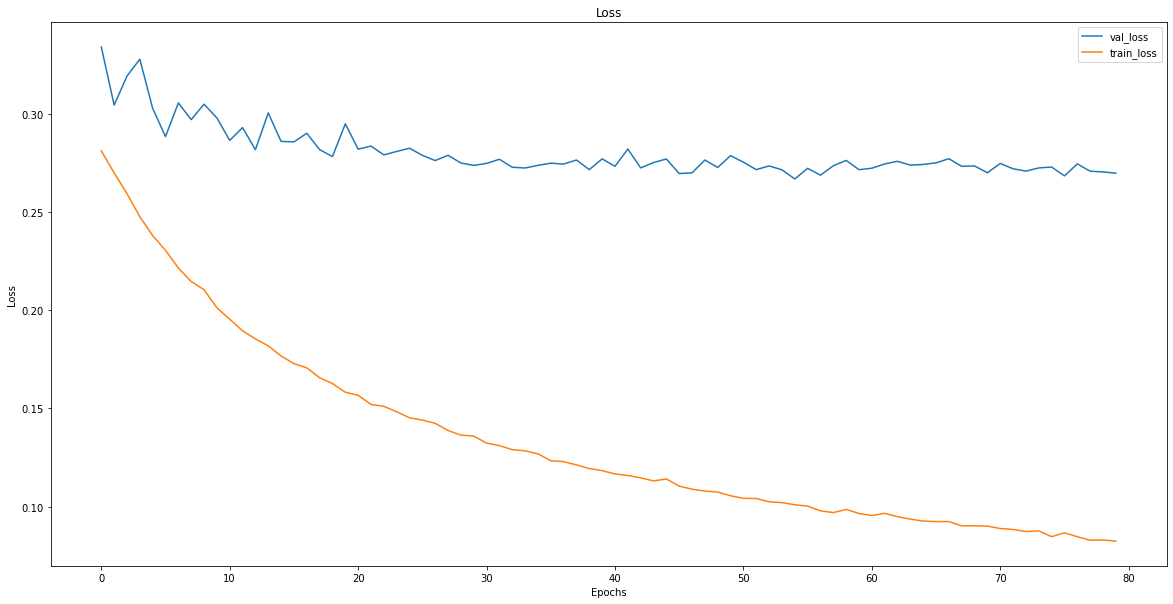

In [143]:
visualize_training_results(results)

### Simple CNN base

In [144]:
basic_cnn = basic_cnn_branch()

results, basic_cnn_aug_model = run_nn(basic_cnn, image_train_generator, y_train, image_val_generator, y_val, 15, "basic_cnn_augments", generator=True)

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 299, 299, 64)      9472      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 149, 149, 128)     73856     
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 149, 149, 128)     147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 74, 74, 256)       295

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 328 steps, validate for 41 steps
Epoch 1/500
327/328 [============================>.] - ETA: 0s - loss: 3.2443 - mean_absolute_error: 3.2443 - mean_squared_error: 19.4941
Epoch 00001: val_loss improved from inf to 1.87111, saving model to best_basic_cnn_augments_model.hdf5
328/328 [==============================] - 245s 748ms/step - loss: 3.2407 - mean_absolute_error: 3.2407 - mean_squared_error: 19.4563 - val_loss: 1.8711 - val_mean_absolute_error: 1.8711 - val_mean_squared_error: 3.6912
Epoch 2/500
327/328 [============================>.] - ETA: 0s - loss: 1.5781 - mean_absolute_error: 1.5781 - mean_squared_error: 4.1218
Epoch 00002: val_loss improved from 1.87111 to 0.34057, saving model to best_basic_cnn_augments_model.hdf5
328/328 [==============================] - 239s 729ms/step - loss: 1.5760 - mean_absolute_error: 1.5760 - mean_squared_error: 4.1131 - val_loss: 0.3406 - val_mean_absolute_error: 0.3406 - val_mean_squared_error: 0.1927
Epoch 3/500
327/328 [============

Epoch 40/500
327/328 [============================>.] - ETA: 0s - loss: 0.3356 - mean_absolute_error: 0.3356 - mean_squared_error: 0.1898
Epoch 00040: val_loss did not improve from 0.34004
328/328 [==============================] - 243s 742ms/step - loss: 0.3356 - mean_absolute_error: 0.3356 - mean_squared_error: 0.1899 - val_loss: 0.3401 - val_mean_absolute_error: 0.3401 - val_mean_squared_error: 0.1917
Epoch 41/500
327/328 [============================>.] - ETA: 0s - loss: 0.3349 - mean_absolute_error: 0.3349 - mean_squared_error: 0.1887
Epoch 00041: val_loss improved from 0.34004 to 0.34004, saving model to best_basic_cnn_augments_model.hdf5
328/328 [==============================] - 244s 744ms/step - loss: 0.3355 - mean_absolute_error: 0.3355 - mean_squared_error: 0.1894 - val_loss: 0.3400 - val_mean_absolute_error: 0.3400 - val_mean_squared_error: 0.1909
Epoch 42/500
327/328 [============================>.] - ETA: 0s - loss: 0.3352 - mean_absolute_error: 0.3352 - mean_squared_erro

### Multi-Input NN

In [207]:
mlp_baseline, mlp_inputs =  mlp_branch(X_train_tabular.shape[1], [1024, 512, 256, 128, 64], multi=True, dropout=False, norm=False)
nlp_baseline, nlp_inputs = nlp_branch(num_tokens, embedding_matrix, max_words, multi=True)
cnn_baseline, cnn_inputs = inception_cnn_branch(transfer_trainable=False, multi=True)

multi_model = joined_model([mlp_baseline, nlp_baseline, cnn_baseline], [mlp_inputs, nlp_inputs, cnn_inputs])

Adding initial Dense layers with  1024
Adding Dense layer with  512
Adding Dense layer with  256
Adding Dense layer with  128
Adding last layer with  64
Outputting multi-nn model layer - Tabular
Outputting multi-nn model layer - NLP
Outputting multi-nn model layer - CNN
Model: "model_108"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_113 (InputLayer)          [(None, 61)]         0                                            
__________________________________________________________________________________________________
input_114 (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
dense_819 (Dense)               (None, 1024)         63488       input_113[0][0]                  
_________________

In [208]:
results, multi_model = run_nn(multi_model, [X_train_tabular, tokenized_train, images_train], y_train, [X_val_tabular, tokenized_val, images_val], y_val, 50, "multi", generator=False)

[INFO] training model...
Train on 10471 samples, validate on 1309 samples
Epoch 1/500
10464/10471 [============================>.] - ETA: 0s - loss: 1.3145 - mean_absolute_error: 1.3145 - mean_squared_error: 6.0922
Epoch 00001: val_loss improved from inf to 0.40653, saving model to best_multi_model.hdf5
10471/10471 [==============================] - 98s 9ms/sample - loss: 1.3140 - mean_absolute_error: 1.3124 - mean_squared_error: 6.0750 - val_loss: 0.4065 - val_mean_absolute_error: 0.4067 - val_mean_squared_error: 0.2654
Epoch 2/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.5519 - mean_absolute_error: 0.5519 - mean_squared_error: 0.5666
Epoch 00002: val_loss improved from 0.40653 to 0.34813, saving model to best_multi_model.hdf5
10471/10471 [==============================] - 83s 8ms/sample - loss: 0.5517 - mean_absolute_error: 0.5510 - mean_squared_error: 0.5652 - val_loss: 0.3481 - val_mean_absolute_error: 0.3481 - val_mean_squared_error: 0.2004
Epoch 3/500
1046

10471/10471 [==============================] - 83s 8ms/sample - loss: 0.1364 - mean_absolute_error: 0.1364 - mean_squared_error: 0.0355 - val_loss: 0.1576 - val_mean_absolute_error: 0.1576 - val_mean_squared_error: 0.0478
Epoch 20/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1203 - mean_absolute_error: 0.1203 - mean_squared_error: 0.0289
Epoch 00020: val_loss did not improve from 0.15765
10471/10471 [==============================] - 81s 8ms/sample - loss: 0.1203 - mean_absolute_error: 0.1203 - mean_squared_error: 0.0289 - val_loss: 0.1587 - val_mean_absolute_error: 0.1586 - val_mean_squared_error: 0.0504
Epoch 21/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1193 - mean_absolute_error: 0.1193 - mean_squared_error: 0.0284
Epoch 00021: val_loss did not improve from 0.15765
10471/10471 [==============================] - 81s 8ms/sample - loss: 0.1193 - mean_absolute_error: 0.1194 - mean_squared_error: 0.0284 - val_loss: 0.3005 - val_mean_abso

10464/10471 [============================>.] - ETA: 0s - loss: 0.1006 - mean_absolute_error: 0.1006 - mean_squared_error: 0.0195
Epoch 00039: val_loss did not improve from 0.15020
10471/10471 [==============================] - 81s 8ms/sample - loss: 0.1006 - mean_absolute_error: 0.1007 - mean_squared_error: 0.0195 - val_loss: 0.1689 - val_mean_absolute_error: 0.1689 - val_mean_squared_error: 0.0513
Epoch 40/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.1047 - mean_absolute_error: 0.1047 - mean_squared_error: 0.0202
Epoch 00040: val_loss did not improve from 0.15020
10471/10471 [==============================] - 81s 8ms/sample - loss: 0.1047 - mean_absolute_error: 0.1047 - mean_squared_error: 0.0202 - val_loss: 0.1917 - val_mean_absolute_error: 0.1918 - val_mean_squared_error: 0.0606
Epoch 41/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.0922 - mean_absolute_error: 0.0922 - mean_squared_error: 0.0167
Epoch 00041: val_loss did not improve fro

Epoch 59/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.0820 - mean_absolute_error: 0.0820 - mean_squared_error: 0.0128
Epoch 00059: val_loss did not improve from 0.14389
10471/10471 [==============================] - 80s 8ms/sample - loss: 0.0821 - mean_absolute_error: 0.0821 - mean_squared_error: 0.0128 - val_loss: 0.1495 - val_mean_absolute_error: 0.1495 - val_mean_squared_error: 0.0466
Epoch 60/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.0800 - mean_absolute_error: 0.0800 - mean_squared_error: 0.0121
Epoch 00060: val_loss did not improve from 0.14389
10471/10471 [==============================] - 80s 8ms/sample - loss: 0.0800 - mean_absolute_error: 0.0801 - mean_squared_error: 0.0121 - val_loss: 0.1582 - val_mean_absolute_error: 0.1582 - val_mean_squared_error: 0.0490
Epoch 61/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.0775 - mean_absolute_error: 0.0775 - mean_squared_error: 0.0114
Epoch 00061: val_loss did no

Epoch 79/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.0742 - mean_absolute_error: 0.0742 - mean_squared_error: 0.0100
Epoch 00079: val_loss did not improve from 0.14389
10471/10471 [==============================] - 80s 8ms/sample - loss: 0.0742 - mean_absolute_error: 0.0744 - mean_squared_error: 0.0101 - val_loss: 0.1526 - val_mean_absolute_error: 0.1525 - val_mean_squared_error: 0.0489
Epoch 80/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.0693 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0090
Epoch 00080: val_loss did not improve from 0.14389
10471/10471 [==============================] - 80s 8ms/sample - loss: 0.0694 - mean_absolute_error: 0.0696 - mean_squared_error: 0.0091 - val_loss: 0.1544 - val_mean_absolute_error: 0.1544 - val_mean_squared_error: 0.0487
Epoch 81/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.0641 - mean_absolute_error: 0.0641 - mean_squared_error: 0.0077
Epoch 00081: val_loss did no

Epoch 99/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.0568 - mean_absolute_error: 0.0568 - mean_squared_error: 0.0061
Epoch 00099: val_loss did not improve from 0.14389
10471/10471 [==============================] - 80s 8ms/sample - loss: 0.0567 - mean_absolute_error: 0.0567 - mean_squared_error: 0.0061 - val_loss: 0.1750 - val_mean_absolute_error: 0.1750 - val_mean_squared_error: 0.0562
Epoch 100/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.0649 - mean_absolute_error: 0.0649 - mean_squared_error: 0.0078
Epoch 00100: val_loss did not improve from 0.14389
10471/10471 [==============================] - 80s 8ms/sample - loss: 0.0649 - mean_absolute_error: 0.0649 - mean_squared_error: 0.0078 - val_loss: 0.1470 - val_mean_absolute_error: 0.1470 - val_mean_squared_error: 0.0451
Epoch 101/500
10464/10471 [============================>.] - ETA: 0s - loss: 0.0596 - mean_absolute_error: 0.0596 - mean_squared_error: 0.0068
Epoch 00101: val_loss did 

## Standard Model Tuning

##### KNN

In [106]:
mae_val = [] #to store mae values for different k

# checks mean absolute error scores on k from 1 to 20
for K in range(0, 20):
    K = K+1 
    # set up the KNN regressor
    model = KNeighborsRegressor(n_neighbors = K)
    # get accuracy cross val score for cv 5
    scores = cross_validate(model, X_train_refined, y_train, cv=5,
        scoring=('neg_mean_absolute_error'),
        return_train_score=True)
    mae = round(scores['test_score'].mean(), 4) 
    mae_val.append(mae) #store mae values
    print('MAE value for k= ' , K , 'is:', mae)
    
# gets optimal k-value based on score minimum
index_max = np.argmax(mae_val) + 1
print(index_max)

MAE value for k=  1 is: -0.2072
MAE value for k=  2 is: -0.1826
MAE value for k=  3 is: -0.1741
MAE value for k=  4 is: -0.1704
MAE value for k=  5 is: -0.1683
MAE value for k=  6 is: -0.1669
MAE value for k=  7 is: -0.1663
MAE value for k=  8 is: -0.1658
MAE value for k=  9 is: -0.1661
MAE value for k=  10 is: -0.1662
MAE value for k=  11 is: -0.1665
MAE value for k=  12 is: -0.1667
MAE value for k=  13 is: -0.1669
MAE value for k=  14 is: -0.1676
MAE value for k=  15 is: -0.1678
MAE value for k=  16 is: -0.1683
MAE value for k=  17 is: -0.1688
MAE value for k=  18 is: -0.1692
MAE value for k=  19 is: -0.1694
MAE value for k=  20 is: -0.1698
8


MAE value for k=  1 is: -0.2072
MAE value for k=  2 is: -0.1826
MAE value for k=  3 is: -0.1741
MAE value for k=  4 is: -0.1704
MAE value for k=  5 is: -0.1683
MAE value for k=  6 is: -0.1669
MAE value for k=  7 is: -0.1663
MAE value for k=  8 is: -0.1658
MAE value for k=  9 is: -0.1661
MAE value for k=  10 is: -0.1662
MAE value for k=  11 is: -0.1665
MAE value for k=  12 is: -0.1667
MAE value for k=  13 is: -0.1669
MAE value for k=  14 is: -0.1676
MAE value for k=  15 is: -0.1678
MAE value for k=  16 is: -0.1683
MAE value for k=  17 is: -0.1688
MAE value for k=  18 is: -0.1692
MAE value for k=  19 is: -0.1694
MAE value for k=  20 is: -0.1698
8

##### Extra Trees

In [109]:
param_grid = {"max_depth": [5, 15, 25],
              'max_features':['auto','sqrt']
              }

extra_trees = ExtraTreesRegressor(random_state = randomstate, 
                                  n_estimators=250,
                                  criterion='squared_error',
                                  
                                 )

best_params = grid_optimizer(extra_trees, param_grid, X_train_refined, y_train)    

Making Search
Running Grid
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 3490
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 3490
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START max_depth=5, max_features=auto..............................
[CV 1/5; 1/6] END max_depth=5, max_features=auto;, score=(train=-0.181, test=-0.185) total time=   0.7s
[CV 2/5; 1/6] START max_depth=5, max_features=auto..............................
[CV 2/5; 1/6] END max_depth=5, max_features=auto;, score=(train=-0.182, test=-0.188) total time=   0.7s
[CV 3/5; 1/6] START max_depth=5, max_features=auto..............................
[CV 3/5; 1/6] END max_depth=5, max_features=auto;, score=(train=-0.182, test=-0.179) total time=   0.7s
[CV 4/5; 1/6] START max_depth=5, max_features=auto..............................
[CV 4/5; 1/6] END max_depth=5, max_features=auto;, score=(train=-0.184, tes

Best mae: -0.134
Best parameters set found on train set: 

{'max_depth': 25, 'max_features': 'auto'}

In [114]:
param_grid = {"max_depth": [20, 25, 30],
                "n_estimators": [250, 500, 1000],
              }

extra_trees = ExtraTreesRegressor(random_state = randomstate, 
                                  criterion='squared_error',
                                  max_features='auto'
                                  
                                 )

best_params = grid_optimizer(extra_trees, param_grid, X_train_refined, y_train)   

Making Search
Running Grid
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1163
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 1163
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START max_depth=20, n_estimators=250..............................
[CV 1/5; 1/9] END max_depth=20, n_estimators=250;, score=(train=-0.002, test=-0.146) total time=   1.0s
[CV 2/5; 1/9] START max_depth=20, n_estimators=250..............................
[CV 2/5; 1/9] END max_depth=20, n_estimators=250;, score=(train=-0.003, test=-0.173) total time=   1.0s
[CV 3/5; 1/9] START max_depth=20, n_estimators=250..............................
[CV 3/5; 1/9] END max_depth=20, n_estimators=250;, score=(train=-0.003, test=-0.173) total time=   1.0s
[CV 4/5; 1/9] START max_depth=20, n_estimators=250..............................
[CV 4/5; 1/9] END max_depth=20, n_estimators=250;, score=(train=-0.002, tes

[CV 4/5; 9/9] END max_depth=30, n_estimators=1000;, score=(train=-0.000, test=-0.162) total time=   4.2s
[CV 5/5; 9/9] START max_depth=30, n_estimators=1000.............................
[CV 5/5; 9/9] END max_depth=30, n_estimators=1000;, score=(train=-0.000, test=-0.170) total time=   4.3s
----------
iter: 1
n_candidates: 3
n_resources: 3489
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START max_depth=25, n_estimators=1000.............................
[CV 1/5; 1/3] END max_depth=25, n_estimators=1000;, score=(train=-0.001, test=-0.154) total time=  12.7s
[CV 2/5; 1/3] START max_depth=25, n_estimators=1000.............................
[CV 2/5; 1/3] END max_depth=25, n_estimators=1000;, score=(train=-0.001, test=-0.137) total time=  12.6s
[CV 3/5; 1/3] START max_depth=25, n_estimators=1000.............................
[CV 3/5; 1/3] END max_depth=25, n_estimators=1000;, score=(train=-0.001, test=-0.131) total time=  12.6s
[CV 4/5; 1/3] START max_depth=25, n_es

Best mae: -0.133
Best parameters set found on train set: 

{'max_depth': 25, 'n_estimators': 500}

In [ ]:
extra_trees = ExtraTreesRegressor(random_state = randomstate, 
                                  n_estimators=500,
                                  criterion='squared_error',
                                  max_depth=25,
                                  max_features='auto'
                                 )

##### Random Forest

In [110]:
param_grid = {"max_depth": [5, 10, 15],
              "criterion" : ['squared_error', 'absolute_error']
              }

random_forest = RandomForestRegressor(
                n_estimators=250,
                random_state=randomstate,
                n_jobs=-1)

best_params = grid_optimizer(random_forest, param_grid, X_train_refined, y_train)

Making Search
Running Grid
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 3490
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 3490
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START criterion=squared_error, max_depth=5........................
[CV 1/5; 1/6] END criterion=squared_error, max_depth=5;, score=(train=-0.164, test=-0.169) total time=   1.3s
[CV 2/5; 1/6] START criterion=squared_error, max_depth=5........................
[CV 2/5; 1/6] END criterion=squared_error, max_depth=5;, score=(train=-0.166, test=-0.184) total time=   0.3s
[CV 3/5; 1/6] START criterion=squared_error, max_depth=5........................
[CV 3/5; 1/6] END criterion=squared_error, max_depth=5;, score=(train=-0.166, test=-0.180) total time=   0.3s
[CV 4/5; 1/6] START criterion=squared_error, max_depth=5........................
[CV 4/5; 1/6] END criterion=squared_error, max_depth=5;, 

Best mae: -0.138
Best parameters set found on train set: 

{'criterion': 'absolute_error', 'max_depth': 15}

In [119]:
param_grid = {'bootstrap': [True, False],
              'min_samples_leaf' : [1, 10],
              "max_depth": [15, 25]
              }

random_forest = RandomForestRegressor(
                n_estimators=250,
                random_state=randomstate,
                criterion='squared_error',
                max_features='auto',)

best_params = grid_optimizer(random_forest, param_grid, X_train_refined, y_train)

Making Search
Running Grid
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 3490
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 3490
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START bootstrap=True, max_depth=15, min_samples_leaf=1............
[CV 1/5; 1/8] END bootstrap=True, max_depth=15, min_samples_leaf=1;, score=(train=-0.059, test=-0.153) total time=   3.8s
[CV 2/5; 1/8] START bootstrap=True, max_depth=15, min_samples_leaf=1............
[CV 2/5; 1/8] END bootstrap=True, max_depth=15, min_samples_leaf=1;, score=(train=-0.061, test=-0.158) total time=   3.7s
[CV 3/5; 1/8] START bootstrap=True, max_depth=15, min_samples_leaf=1............
[CV 3/5; 1/8] END bootstrap=True, max_depth=15, min_samples_leaf=1;, score=(train=-0.058, test=-0.147) total time=   3.7s
[CV 4/5; 1/8] START bootstrap=True, max_depth=15, min_samples_leaf=1............
[CV 4/5; 1/8] END boo

[CV 5/5; 8/8] END bootstrap=False, max_depth=25, min_samples_leaf=10;, score=(train=-0.130, test=-0.186) total time=   3.8s
----------
iter: 1
n_candidates: 3
n_resources: 10470
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START bootstrap=True, max_depth=25, min_samples_leaf=10...........
[CV 1/5; 1/3] END bootstrap=True, max_depth=25, min_samples_leaf=10;, score=(train=-0.111, test=-0.146) total time=   7.8s
[CV 2/5; 1/3] START bootstrap=True, max_depth=25, min_samples_leaf=10...........
[CV 2/5; 1/3] END bootstrap=True, max_depth=25, min_samples_leaf=10;, score=(train=-0.111, test=-0.146) total time=   7.7s
[CV 3/5; 1/3] START bootstrap=True, max_depth=25, min_samples_leaf=10...........
[CV 3/5; 1/3] END bootstrap=True, max_depth=25, min_samples_leaf=10;, score=(train=-0.113, test=-0.135) total time=   7.8s
[CV 4/5; 1/3] START bootstrap=True, max_depth=25, min_samples_leaf=10...........
[CV 4/5; 1/3] END bootstrap=True, max_depth=25, min_samples_leaf=10;,

Best mae: -0.138
Best parameters set found on train set: 

{'bootstrap': True, 'max_depth': 25, 'min_samples_leaf': 1}

In [ ]:
random_forest = RandomForestRegressor(
                n_estimators=250,
                random_state=randomstate,
                criterion='squared_error',
                max_depth=25,
                min_samples_leaf=1,
                max_features='auto',
                bootstrap=True,
                    )


##### XGB

In [111]:
param_grid = {"max_depth": [5, 10, 15],
              "min_child_weight" : [2, 7],
              'eta': [.05, .1],
              }

xgbr = xgb.XGBRegressor(
                n_estimators=250,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1)

best_params = grid_optimizer(xgbr, param_grid, X_train_refined, y_train)

Making Search
Running Grid
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1163
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 1163
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START eta=0.05, max_depth=5, min_child_weight=2..................
[CV 1/5; 1/12] END eta=0.05, max_depth=5, min_child_weight=2;, score=(train=-0.069, test=-0.185) total time=   0.1s
[CV 2/5; 1/12] START eta=0.05, max_depth=5, min_child_weight=2..................
[CV 2/5; 1/12] END eta=0.05, max_depth=5, min_child_weight=2;, score=(train=-0.062, test=-0.152) total time=   0.1s
[CV 3/5; 1/12] START eta=0.05, max_depth=5, min_child_weight=2..................
[CV 3/5; 1/12] END eta=0.05, max_depth=5, min_child_weight=2;, score=(train=-0.064, test=-0.149) total time=   0.1s
[CV 4/5; 1/12] START eta=0.05, max_depth=5, min_child_weight=2..................
[CV 4/5; 1/12] END eta=0.05, max_dept

[CV 1/5; 9/12] END eta=0.1, max_depth=10, min_child_weight=2;, score=(train=-0.001, test=-0.185) total time=   0.3s
[CV 2/5; 9/12] START eta=0.1, max_depth=10, min_child_weight=2..................
[CV 2/5; 9/12] END eta=0.1, max_depth=10, min_child_weight=2;, score=(train=-0.001, test=-0.161) total time=   0.3s
[CV 3/5; 9/12] START eta=0.1, max_depth=10, min_child_weight=2..................
[CV 3/5; 9/12] END eta=0.1, max_depth=10, min_child_weight=2;, score=(train=-0.001, test=-0.162) total time=   0.3s
[CV 4/5; 9/12] START eta=0.1, max_depth=10, min_child_weight=2..................
[CV 4/5; 9/12] END eta=0.1, max_depth=10, min_child_weight=2;, score=(train=-0.001, test=-0.146) total time=   0.3s
[CV 5/5; 9/12] START eta=0.1, max_depth=10, min_child_weight=2..................
[CV 5/5; 9/12] END eta=0.1, max_depth=10, min_child_weight=2;, score=(train=-0.001, test=-0.151) total time=   0.3s
[CV 1/5; 10/12] START eta=0.1, max_depth=10, min_child_weight=7.................
[CV 1/5; 10/12]

[CV 2/5; 1/2] END eta=0.1, max_depth=5, min_child_weight=7;, score=(train=-0.100, test=-0.136) total time=   0.5s
[CV 3/5; 1/2] START eta=0.1, max_depth=5, min_child_weight=7....................
[CV 3/5; 1/2] END eta=0.1, max_depth=5, min_child_weight=7;, score=(train=-0.101, test=-0.128) total time=   0.5s
[CV 4/5; 1/2] START eta=0.1, max_depth=5, min_child_weight=7....................
[CV 4/5; 1/2] END eta=0.1, max_depth=5, min_child_weight=7;, score=(train=-0.102, test=-0.130) total time=   0.5s
[CV 5/5; 1/2] START eta=0.1, max_depth=5, min_child_weight=7....................
[CV 5/5; 1/2] END eta=0.1, max_depth=5, min_child_weight=7;, score=(train=-0.100, test=-0.134) total time=   0.4s
[CV 1/5; 2/2] START eta=0.1, max_depth=5, min_child_weight=2....................
[CV 1/5; 2/2] END eta=0.1, max_depth=5, min_child_weight=2;, score=(train=-0.098, test=-0.139) total time=   0.5s
[CV 2/5; 2/2] START eta=0.1, max_depth=5, min_child_weight=2....................
[CV 2/5; 2/2] END eta=0.1

Best mae: -0.133
Best parameters set found on train set: 

{'eta': 0.1, 'max_depth': 5, 'min_child_weight': 7}

In [117]:
param_grid = {"max_depth": [3, 5, 7],
              "min_child_weight" : [7, 10],
              'eta': [.1, .3],
              }

xgbr = xgb.XGBRegressor(
                n_estimators=250,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1)

best_params = grid_optimizer(xgbr, param_grid, X_train_refined, y_train)

Making Search
Running Grid
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1163
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 1163
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START eta=0.1, max_depth=3, min_child_weight=7...................
ERROR! Session/line number was not unique in database. History logging moved to new session 3454
[CV 1/5; 1/12] END eta=0.1, max_depth=3, min_child_weight=7;, score=(train=-0.092, test=-0.173) total time=   0.0s
[CV 2/5; 1/12] START eta=0.1, max_depth=3, min_child_weight=7...................
[CV 2/5; 1/12] END eta=0.1, max_depth=3, min_child_weight=7;, score=(train=-0.093, test=-0.163) total time=   0.0s
[CV 3/5; 1/12] START eta=0.1, max_depth=3, min_child_weight=7...................
[CV 3/5; 1/12] END eta=0.1, max_depth=3, min_child_weight=7;, score=(train=-0.098, test=-0.155) total time=   0.0s
[CV 4/5; 1/12] START eta

[CV 2/5; 9/12] START eta=0.3, max_depth=5, min_child_weight=7...................
[CV 2/5; 9/12] END eta=0.3, max_depth=5, min_child_weight=7;, score=(train=-0.006, test=-0.175) total time=   0.1s
[CV 3/5; 9/12] START eta=0.3, max_depth=5, min_child_weight=7...................
[CV 3/5; 9/12] END eta=0.3, max_depth=5, min_child_weight=7;, score=(train=-0.006, test=-0.180) total time=   0.1s
[CV 4/5; 9/12] START eta=0.3, max_depth=5, min_child_weight=7...................
[CV 4/5; 9/12] END eta=0.3, max_depth=5, min_child_weight=7;, score=(train=-0.005, test=-0.168) total time=   0.1s
[CV 5/5; 9/12] START eta=0.3, max_depth=5, min_child_weight=7...................
[CV 5/5; 9/12] END eta=0.3, max_depth=5, min_child_weight=7;, score=(train=-0.005, test=-0.158) total time=   0.1s
[CV 1/5; 10/12] START eta=0.3, max_depth=5, min_child_weight=10.................
[CV 1/5; 10/12] END eta=0.3, max_depth=5, min_child_weight=10;, score=(train=-0.007, test=-0.178) total time=   0.1s
[CV 2/5; 10/12] ST

[CV 3/5; 1/2] END eta=0.1, max_depth=3, min_child_weight=10;, score=(train=-0.128, test=-0.131) total time=   0.2s
[CV 4/5; 1/2] START eta=0.1, max_depth=3, min_child_weight=10...................
[CV 4/5; 1/2] END eta=0.1, max_depth=3, min_child_weight=10;, score=(train=-0.127, test=-0.134) total time=   0.2s
[CV 5/5; 1/2] START eta=0.1, max_depth=3, min_child_weight=10...................
[CV 5/5; 1/2] END eta=0.1, max_depth=3, min_child_weight=10;, score=(train=-0.124, test=-0.139) total time=   0.2s
[CV 1/5; 2/2] START eta=0.1, max_depth=5, min_child_weight=7....................
[CV 1/5; 2/2] END eta=0.1, max_depth=5, min_child_weight=7;, score=(train=-0.100, test=-0.139) total time=   0.4s
[CV 2/5; 2/2] START eta=0.1, max_depth=5, min_child_weight=7....................
[CV 2/5; 2/2] END eta=0.1, max_depth=5, min_child_weight=7;, score=(train=-0.100, test=-0.137) total time=   0.4s
[CV 3/5; 2/2] START eta=0.1, max_depth=5, min_child_weight=7....................
[CV 3/5; 2/2] END eta=

Best mae: -0.133
Best parameters set found on train set: 

{'eta': 0.1, 'max_depth': 5, 'min_child_weight': 7}

In [120]:
param_grid = {'gamma': [0, .4, .8],
              'subsample':[.2, .6, 1],

              }

xgbr = xgb.XGBRegressor(
                n_estimators=250,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 5,
                eta = .1,
                min_child_weight = 7)

best_params = grid_optimizer(xgbr, param_grid, X_train_refined, y_train)

Making Search
Running Grid
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1163
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 1163
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START gamma=0, subsample=0.2......................................
[CV 1/5; 1/9] END gamma=0, subsample=0.2;, score=(train=-0.047, test=-0.175) total time=   0.2s
[CV 2/5; 1/9] START gamma=0, subsample=0.2......................................
[CV 2/5; 1/9] END gamma=0, subsample=0.2;, score=(train=-0.050, test=-0.185) total time=   0.2s
[CV 3/5; 1/9] START gamma=0, subsample=0.2......................................
[CV 3/5; 1/9] END gamma=0, subsample=0.2;, score=(train=-0.048, test=-0.164) total time=   0.2s
[CV 4/5; 1/9] START gamma=0, subsample=0.2......................................
[CV 4/5; 1/9] END gamma=0, subsample=0.2;, score=(train=-0.054, test=-0.175) total time=   0.2s
[CV

[CV 1/5; 1/3] END gamma=0.4, subsample=0.6;, score=(train=-0.119, test=-0.152) total time=   0.5s
[CV 2/5; 1/3] START gamma=0.4, subsample=0.6....................................
[CV 2/5; 1/3] END gamma=0.4, subsample=0.6;, score=(train=-0.123, test=-0.147) total time=   0.5s
[CV 3/5; 1/3] START gamma=0.4, subsample=0.6....................................
[CV 3/5; 1/3] END gamma=0.4, subsample=0.6;, score=(train=-0.121, test=-0.142) total time=   0.5s
[CV 4/5; 1/3] START gamma=0.4, subsample=0.6....................................
[CV 4/5; 1/3] END gamma=0.4, subsample=0.6;, score=(train=-0.119, test=-0.144) total time=   0.5s
[CV 5/5; 1/3] START gamma=0.4, subsample=0.6....................................
[CV 5/5; 1/3] END gamma=0.4, subsample=0.6;, score=(train=-0.118, test=-0.147) total time=   0.5s
[CV 1/5; 2/3] START gamma=0, subsample=0.6......................................
[CV 1/5; 2/3] END gamma=0, subsample=0.6;, score=(train=-0.046, test=-0.149) total time=   0.5s
[CV 2/5; 

Best mae: -0.133
Best parameters set found on train set: 

{'gamma': 0, 'subsample': 1}

In [122]:
param_grid = {'colsample_bytree':[.2, .4, .6, .8, 1],
              }

xgbr = xgb.XGBRegressor(
                n_estimators=250,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 5,
                eta = .1,
                min_child_weight = 7,
    gamma = 0,
    subsample=1,
                )

best_params = grid_optimizer(xgbr, param_grid, X_train_refined, y_train)

Making Search
Running Grid
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 3490
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 5
n_resources: 3490
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START colsample_bytree=0.2........................................
[CV 1/5; 1/5] END colsample_bytree=0.2;, score=(train=-0.088, test=-0.150) total time=   0.1s
[CV 2/5; 1/5] START colsample_bytree=0.2........................................
[CV 2/5; 1/5] END colsample_bytree=0.2;, score=(train=-0.092, test=-0.145) total time=   0.1s
[CV 3/5; 1/5] START colsample_bytree=0.2........................................
[CV 3/5; 1/5] END colsample_bytree=0.2;, score=(train=-0.089, test=-0.135) total time=   0.2s
[CV 4/5; 1/5] START colsample_bytree=0.2........................................
[CV 4/5; 1/5] END colsample_bytree=0.2;, score=(train=-0.089, test=-0.135) total time=   0.1s
[CV 5/5; 1/

Best mae: -0.133
Best parameters set found on train set: 

{'colsample_bytree': 0.4}

In [123]:
param_grid = {'reg_alpha':[1e-5, 1, 100],
              'reg_lambda':[1e-5, 1, 100],
              }

xgbr = xgb.XGBRegressor(
                n_estimators=250,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 5,
                eta = .1,
                min_child_weight = 7,
                gamma = 0,
                subsample=1,
                colsample_bytree=.4

            )

best_params = grid_optimizer(xgbr, param_grid, X_train_refined, y_train)

Making Search
Running Grid
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1163
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 1163
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START reg_alpha=1e-05, reg_lambda=1e-05...........................
[CV 1/5; 1/9] END reg_alpha=1e-05, reg_lambda=1e-05;, score=(train=-0.042, test=-0.173) total time=   0.1s
[CV 2/5; 1/9] START reg_alpha=1e-05, reg_lambda=1e-05...........................
[CV 2/5; 1/9] END reg_alpha=1e-05, reg_lambda=1e-05;, score=(train=-0.041, test=-0.164) total time=   0.1s
[CV 3/5; 1/9] START reg_alpha=1e-05, reg_lambda=1e-05...........................
[CV 3/5; 1/9] END reg_alpha=1e-05, reg_lambda=1e-05;, score=(train=-0.041, test=-0.145) total time=   0.1s
[CV 4/5; 1/9] START reg_alpha=1e-05, reg_lambda=1e-05...........................
[CV 4/5; 1/9] END reg_alpha=1e-05, reg_lambda=1e-05;, score=(train

[CV 4/5; 9/9] START reg_alpha=100, reg_lambda=100...............................
[CV 4/5; 9/9] END reg_alpha=100, reg_lambda=100;, score=(train=-0.246, test=-0.264) total time=   0.0s
[CV 5/5; 9/9] START reg_alpha=100, reg_lambda=100...............................
[CV 5/5; 9/9] END reg_alpha=100, reg_lambda=100;, score=(train=-0.241, test=-0.261) total time=   0.0s
----------
iter: 1
n_candidates: 3
n_resources: 3489
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START reg_alpha=1, reg_lambda=1...................................
[CV 1/5; 1/3] END reg_alpha=1, reg_lambda=1;, score=(train=-0.091, test=-0.148) total time=   0.2s
[CV 2/5; 1/3] START reg_alpha=1, reg_lambda=1...................................
[CV 2/5; 1/3] END reg_alpha=1, reg_lambda=1;, score=(train=-0.090, test=-0.144) total time=   0.2s
[CV 3/5; 1/3] START reg_alpha=1, reg_lambda=1...................................
[CV 3/5; 1/3] END reg_alpha=1, reg_lambda=1;, score=(train=-0.095, test=-0.136

Best mae: -0.133
Best parameters set found on train set: 

{'reg_alpha': 1, 'reg_lambda': 1}

In [124]:
param_grid = {'n_estimators' : [250, 500, 1000],
              }

xgbr = xgb.XGBRegressor(
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 5,
                eta = .1,
                min_child_weight = 7,
                gamma = 0,
                subsample=1,
                colsample_bytree=.4

            )

best_params = grid_optimizer(xgbr, param_grid, X_train_refined, y_train)

Making Search
Running Grid
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 3490
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 3490
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START n_estimators=250............................................
[CV 1/5; 1/3] END n_estimators=250;, score=(train=-0.081, test=-0.139) total time=   0.1s
[CV 2/5; 1/3] START n_estimators=250............................................
[CV 2/5; 1/3] END n_estimators=250;, score=(train=-0.080, test=-0.133) total time=   0.1s
[CV 3/5; 1/3] START n_estimators=250............................................
[CV 3/5; 1/3] END n_estimators=250;, score=(train=-0.085, test=-0.128) total time=   0.1s
[CV 4/5; 1/3] START n_estimators=250............................................
[CV 4/5; 1/3] END n_estimators=250;, score=(train=-0.086, test=-0.134) total time=   0.2s
[CV 5/5; 1/3] START n_estim

Best mae: -0.133
Best parameters set found on train set: 

{'n_estimators': 250}

In [ ]:
xgbr = xgb.XGBRegressor(
                n_estimators=250,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 10,
                eta = .05,
                min_child_weight = 7,
                gamma = 0,
                subsample=1,
                colsample_bytree=.4
            )

##### Nu SVR

In [107]:
param_grid = {'kernel' : ['linear', 'rbf', 'poly'],
              'gamma' : ['scale', 'auto']            
              }

nu_svr = NuSVR()

best_params = grid_optimizer(nu_svr, param_grid, X_train_refined, y_train)

Making Search
Running Grid
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 3490
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 3490
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START gamma=scale, kernel=linear..................................
ERROR! Session/line number was not unique in database. History logging moved to new session 3452
[CV 1/5; 1/8] END gamma=scale, kernel=linear;, score=(train=-0.145, test=-0.148) total time=   1.8s
[CV 2/5; 1/8] START gamma=scale, kernel=linear..................................
[CV 2/5; 1/8] END gamma=scale, kernel=linear;, score=(train=-0.139, test=-0.143) total time=   1.8s
[CV 3/5; 1/8] START gamma=scale, kernel=linear..................................
[CV 3/5; 1/8] END gamma=scale, kernel=linear;, score=(train=-0.144, test=-0.134) total time=   1.8s
[CV 4/5; 1/8] START gamma=scale, kernel=linear.........................

[CV 4/5; 1/3] END gamma=auto, kernel=linear;, score=(train=-0.144, test=-0.137) total time=  16.1s
[CV 5/5; 1/3] START gamma=auto, kernel=linear...................................
[CV 5/5; 1/3] END gamma=auto, kernel=linear;, score=(train=-0.141, test=-0.148) total time=  16.9s
[CV 1/5; 2/3] START gamma=scale, kernel=rbf.....................................
[CV 1/5; 2/3] END gamma=scale, kernel=rbf;, score=(train=-0.097, test=-0.137) total time=   5.8s
[CV 2/5; 2/3] START gamma=scale, kernel=rbf.....................................
[CV 2/5; 2/3] END gamma=scale, kernel=rbf;, score=(train=-0.097, test=-0.137) total time=   5.9s
[CV 3/5; 2/3] START gamma=scale, kernel=rbf.....................................
[CV 3/5; 2/3] END gamma=scale, kernel=rbf;, score=(train=-0.099, test=-0.127) total time=   5.8s
[CV 4/5; 2/3] START gamma=scale, kernel=rbf.....................................
[CV 4/5; 2/3] END gamma=scale, kernel=rbf;, score=(train=-0.098, test=-0.130) total time=   5.8s
[CV 5/5; 

Best mae: -0.133
Best parameters set found on train set: 

{'gamma': 'auto', 'kernel': 'rbf'}

In [112]:
param_grid = {'C': [.1, 1, 10]         
              }

nu_svr = NuSVR(gamma='auto', kernel='rbf')

best_params = grid_optimizer(nu_svr, param_grid, X_train_refined, y_train)

Making Search
Running Grid
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 3490
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 3490
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START C=0.1.......................................................
[CV 1/5; 1/3] END ..C=0.1;, score=(train=-0.151, test=-0.177) total time=   0.3s
[CV 2/5; 1/3] START C=0.1.......................................................
[CV 2/5; 1/3] END ..C=0.1;, score=(train=-0.154, test=-0.167) total time=   0.3s
[CV 3/5; 1/3] START C=0.1.......................................................
[CV 3/5; 1/3] END ..C=0.1;, score=(train=-0.155, test=-0.159) total time=   0.3s
[CV 4/5; 1/3] START C=0.1.......................................................
[CV 4/5; 1/3] END ..C=0.1;, score=(train=-0.151, test=-0.156) total time=   0.3s
[CV 5/5; 1/3] START C=0.1......................................

Best mae: -0.133
Best parameters set found on train set: 

{'C': 1}

In [ ]:
nu_svr = NuSVR(gamma='auto', kernel='rbf')

##### Gradient Boosted

In [108]:
param_grid = {"max_depth": [5, 10, 15],
              'learning_rate': [.1, .3],
              }

gradient_boost = GradientBoostingRegressor(
                n_estimators=250,
                random_state=randomstate,
                )

best_params = grid_optimizer(gradient_boost, param_grid, X_train_refined, y_train)

Making Search
Running Grid
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 3490
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 3490
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START learning_rate=0.1, max_depth=5..............................
[CV 1/5; 1/6] END learning_rate=0.1, max_depth=5;, score=(train=-0.060, test=-0.148) total time=   2.2s
[CV 2/5; 1/6] START learning_rate=0.1, max_depth=5..............................
[CV 2/5; 1/6] END learning_rate=0.1, max_depth=5;, score=(train=-0.062, test=-0.150) total time=   2.2s
[CV 3/5; 1/6] START learning_rate=0.1, max_depth=5..............................
[CV 3/5; 1/6] END learning_rate=0.1, max_depth=5;, score=(train=-0.061, test=-0.148) total time=   2.2s
[CV 4/5; 1/6] START learning_rate=0.1, max_depth=5..............................
[CV 4/5; 1/6] END learning_rate=0.1, max_depth=5;, score=(train=-0.063, tes

Best mae: -0.134
Best parameters set found on train set: 

{'learning_rate': 0.1, 'max_depth': 5}

In [113]:
param_grid = {"max_depth": [3, 5, 7],
              'learning_rate': [.15, .3],
              }

gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                )

best_params = grid_optimizer(gradient_boost, param_grid, X_train_refined, y_train)

Making Search
Running Grid
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 3490
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 3490
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START learning_rate=0.15, max_depth=3.............................
[CV 1/5; 1/6] END learning_rate=0.15, max_depth=3;, score=(train=-0.075, test=-0.151) total time=   2.7s
[CV 2/5; 1/6] START learning_rate=0.15, max_depth=3.............................
[CV 2/5; 1/6] END learning_rate=0.15, max_depth=3;, score=(train=-0.076, test=-0.144) total time=   2.7s
[CV 3/5; 1/6] START learning_rate=0.15, max_depth=3.............................
[CV 3/5; 1/6] END learning_rate=0.15, max_depth=3;, score=(train=-0.077, test=-0.139) total time=   2.7s
[CV 4/5; 1/6] START learning_rate=0.15, max_depth=3.............................
[CV 4/5; 1/6] END learning_rate=0.15, max_depth=3;, score=(train=-0.077,

Best mae: -0.134
Best parameters set found on train set: 

{'learning_rate': 0.15, 'max_depth': 3}

In [116]:
param_grid = {"min_impurity_decrease" : [0, .5],
              'max_features': ['auto', 'sqrt', 'log2'],
              "max_depth": [5, 10, 15],
              }

gradient_boost = GradientBoostingRegressor(
                n_estimators=250,
                random_state=randomstate,
                max_depth = 3,
                learning_rate=.15,
                )

best_params = grid_optimizer(gradient_boost, param_grid, X_train_refined, y_train)

Making Search
Running Grid
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1163
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 1163
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 1/18] START max_depth=5, max_features=auto, min_impurity_decrease=0....
[CV 1/5; 1/18] END max_depth=5, max_features=auto, min_impurity_decrease=0;, score=(train=-0.011, test=-0.170) total time=   0.7s
[CV 2/5; 1/18] START max_depth=5, max_features=auto, min_impurity_decrease=0....
[CV 2/5; 1/18] END max_depth=5, max_features=auto, min_impurity_decrease=0;, score=(train=-0.012, test=-0.155) total time=   0.7s
[CV 3/5; 1/18] START max_depth=5, max_features=auto, min_impurity_decrease=0....
[CV 3/5; 1/18] END max_depth=5, max_features=auto, min_impurity_decrease=0;, score=(train=-0.013, test=-0.144) total time=   0.7s
[CV 4/5; 1/18] START max_depth=5, max_features=auto, min_impurity_decrease=0

[CV 3/5; 8/18] END max_depth=10, max_features=auto, min_impurity_decrease=0.5;, score=(train=-0.135, test=-0.175) total time=   0.1s
[CV 4/5; 8/18] START max_depth=10, max_features=auto, min_impurity_decrease=0.5.
[CV 4/5; 8/18] END max_depth=10, max_features=auto, min_impurity_decrease=0.5;, score=(train=-0.129, test=-0.175) total time=   0.1s
[CV 5/5; 8/18] START max_depth=10, max_features=auto, min_impurity_decrease=0.5.
[CV 5/5; 8/18] END max_depth=10, max_features=auto, min_impurity_decrease=0.5;, score=(train=-0.129, test=-0.167) total time=   0.1s
[CV 1/5; 9/18] START max_depth=10, max_features=sqrt, min_impurity_decrease=0...
[CV 1/5; 9/18] END max_depth=10, max_features=sqrt, min_impurity_decrease=0;, score=(train=-0.000, test=-0.167) total time=   0.2s
[CV 2/5; 9/18] START max_depth=10, max_features=sqrt, min_impurity_decrease=0...
[CV 2/5; 9/18] END max_depth=10, max_features=sqrt, min_impurity_decrease=0;, score=(train=-0.000, test=-0.167) total time=   0.2s
[CV 3/5; 9/18] 

[CV 4/5; 16/18] END max_depth=15, max_features=sqrt, min_impurity_decrease=0.5;, score=(train=-0.138, test=-0.171) total time=   0.0s
[CV 5/5; 16/18] START max_depth=15, max_features=sqrt, min_impurity_decrease=0.5
[CV 5/5; 16/18] END max_depth=15, max_features=sqrt, min_impurity_decrease=0.5;, score=(train=-0.138, test=-0.165) total time=   0.0s
[CV 1/5; 17/18] START max_depth=15, max_features=log2, min_impurity_decrease=0..
[CV 1/5; 17/18] END max_depth=15, max_features=log2, min_impurity_decrease=0;, score=(train=-0.000, test=-0.180) total time=   0.1s
[CV 2/5; 17/18] START max_depth=15, max_features=log2, min_impurity_decrease=0..
[CV 2/5; 17/18] END max_depth=15, max_features=log2, min_impurity_decrease=0;, score=(train=-0.000, test=-0.168) total time=   0.1s
[CV 3/5; 17/18] START max_depth=15, max_features=log2, min_impurity_decrease=0..
[CV 3/5; 17/18] END max_depth=15, max_features=log2, min_impurity_decrease=0;, score=(train=-0.000, test=-0.165) total time=   0.1s
[CV 4/5; 17/

[CV 3/5; 6/6] END max_depth=5, max_features=auto, min_impurity_decrease=0;, score=(train=-0.047, test=-0.138) total time=   2.2s
[CV 4/5; 6/6] START max_depth=5, max_features=auto, min_impurity_decrease=0.....
[CV 4/5; 6/6] END max_depth=5, max_features=auto, min_impurity_decrease=0;, score=(train=-0.047, test=-0.148) total time=   2.2s
[CV 5/5; 6/6] START max_depth=5, max_features=auto, min_impurity_decrease=0.....
[CV 5/5; 6/6] END max_depth=5, max_features=auto, min_impurity_decrease=0;, score=(train=-0.044, test=-0.150) total time=   2.2s
----------
iter: 2
n_candidates: 2
n_resources: 10467
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START max_depth=5, max_features=log2, min_impurity_decrease=0.....
[CV 1/5; 1/2] END max_depth=5, max_features=log2, min_impurity_decrease=0;, score=(train=-0.099, test=-0.140) total time=   0.6s
[CV 2/5; 1/2] START max_depth=5, max_features=log2, min_impurity_decrease=0.....
[CV 2/5; 1/2] END max_depth=5, max_features=lo

Best mae: -0.135
Best parameters set found on train set: 

{'max_depth': 5, 'max_features': 'auto', 'min_impurity_decrease': 0}

In [118]:
param_grid = {'subsample' : [.3, .7, 1],
              'loss': ['lad', 'ls']
              }

gradient_boost = GradientBoostingRegressor(
                n_estimators=250,
                random_state=randomstate,
                max_depth = 5,
                learning_rate=.15,
                max_features='auto',
                min_impurity_decrease=0,
                )

best_params = grid_optimizer(gradient_boost, param_grid, X_train_refined, y_train)

Making Search
Running Grid
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 3490
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 3490
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START loss=lad, subsample=0.3.....................................
[CV 1/5; 1/6] END loss=lad, subsample=0.3;, score=(train=-0.080, test=-0.149) total time=   1.5s
[CV 2/5; 1/6] START loss=lad, subsample=0.3.....................................
[CV 2/5; 1/6] END loss=lad, subsample=0.3;, score=(train=-0.082, test=-0.154) total time=   1.5s
[CV 3/5; 1/6] START loss=lad, subsample=0.3.....................................
[CV 3/5; 1/6] END loss=lad, subsample=0.3;, score=(train=-0.078, test=-0.136) total time=   1.5s
[CV 4/5; 1/6] START loss=lad, subsample=0.3.....................................
[CV 4/5; 1/6] END loss=lad, subsample=0.3;, score=(train=-0.082, test=-0.149) total time=   1.5s

Best mae: -0.130
Best parameters set found on train set: 

{'loss': 'lad', 'subsample': 0.7}

In [121]:
param_grid = {'n_estimators' : [500,1000,5000]
              }

gradient_boost = GradientBoostingRegressor(
                random_state=randomstate,
                max_depth = 5,
                learning_rate=.15,
                max_features='auto',
                min_impurity_decrease=0,
                loss='lad',
                subsample=.7,
                )

best_params = grid_optimizer(gradient_boost, param_grid, X_train_refined, y_train)

Making Search
Running Grid
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 3490
max_resources_: 10471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 3490
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START n_estimators=500............................................
[CV 1/5; 1/3] END n_estimators=500;, score=(train=-0.061, test=-0.154) total time=   4.9s
[CV 2/5; 1/3] START n_estimators=500............................................
[CV 2/5; 1/3] END n_estimators=500;, score=(train=-0.061, test=-0.145) total time=   4.9s
[CV 3/5; 1/3] START n_estimators=500............................................
[CV 3/5; 1/3] END n_estimators=500;, score=(train=-0.059, test=-0.139) total time=   4.9s
[CV 4/5; 1/3] START n_estimators=500............................................
[CV 4/5; 1/3] END n_estimators=500;, score=(train=-0.062, test=-0.145) total time=   4.8s
[CV 5/5; 1/3] START n_estim

Best mae: -0.131
Best parameters set found on train set: 

{'n_estimators': 500}

In [ ]:
gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                max_depth = 5,
                learning_rate=.15,
                max_features='auto',
                min_impurity_decrease=0,
                loss='lad',
                subsample=.7,
                )

## Resources

https://machinelearningmastery.com/snapshot-ensemble-deep-learning-neural-network/

https://arxiv.org/abs/1704.00109

https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

https://www.pyimagesearch.com/2019/01/21/regression-with-keras/?_ga=2.96326428.1656616260.1633398874-339321111.1633398874

https://www.pyimagesearch.com/2021/05/31/hyperparameter-tuning-for-deep-learning-with-scikit-learn-keras-and-tensorflow/

https://rosenfelder.ai/keras-regression-efficient-net/

https://nlp.stanford.edu/projects/glove/
